## Optimization of generator prompt

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dspy_judge.llm_caller.utils import load_secrets
from dspy_judge.data_loader.dataset_loader import CustomerSupportDatasetLoader
from dspy_judge.processor.parallel_processor import ParallelProcessor
from dspy_judge.prompts.dspy_signatures import SupportTranscriptJudge, SupportTranscriptNextResponse
from dspy_judge.processor.utils import convert_dataset_to_dspy_examples, extract_llm_response_fields_dspy, concat_latest_response_dspy
from dspy_judge.processor.parallel_processor import ParallelProcessor
from dspy_judge.metrics import match_judge_metric
from dspy_judge.plotting import plot_judge_results
import numpy as np
from sklearn.metrics import cohen_kappa_score
import dspy

/Users/rmartinshort/Documents/DS_projects/dspy_judge/judgemodel/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
secrets = load_secrets()

In [5]:
data_loader = CustomerSupportDatasetLoader()

## Load split dataset (final output of notebook 1)

In [6]:
split_dataset = data_loader.load_local_dataset("datasets/preprocessed_dev_judge_dataset_split/")

2025-08-18 21:38:17 - dspy_judge.data_loader.dataset_loader - INFO - Local dataset loaded from datasets/preprocessed_dev_judge_dataset_split/. Size: 2


In [8]:
dev_dataset = split_dataset["train"]
judge_dataset = split_dataset["test"]

## Run baseline generator on dev dataset to generate baseline result

This is actually a repeat of the processing already done in notebook 1 and could be skipped

In [9]:
# Create DSPy configuration for multiprocessing
dspy_config = {
  "model_name": "openai/gpt-3.5-turbo",
  "api_key": secrets["OPENAI_API_KEY"],
  "temperature": 1
}

support_transcript_generator_module = dspy.ChainOfThought(SupportTranscriptNextResponse)

# Initialize processor with both module and config
generation_processor = ParallelProcessor()

baseline_results = generation_processor.process_dataset_with_dspy(
  dev_dataset,
  input_field="company_and_transcript",
  dspy_module=support_transcript_generator_module,
  dspy_config=dspy_config,
)

2025-08-18 21:38:40 - dspy_judge.processor.parallel_processor - INFO - Initialized ParallelProcessor with max_workers=4
2025-08-18 21:38:40 - dspy_judge.processor.parallel_processor - INFO - Processing 240 examples with 4 workers using DSPy...


Processing with DSPy:   0%|                                                                                                | 0/240 [00:00<?, ?it/s]

2025-08-18 21:38:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   0%|▎                                                                                       | 1/240 [00:04<18:07,  4.55s/it]21:38:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model

2025-08-18 21:38:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   2%|██▏                                                                                     | 6/240 [00:05<02:57,  1.32it/s]21:38:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   3%|██▉                                                                                     | 8/240 [00:06<02:35,  1.50it/s]21:38:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   4%|███▎                                                                                    | 9/240 [00:08<03:15,  1.18it/s]21:38:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   6%|█████                                                                                  | 14/240 [00:08<01:18,  2.88it/s]21:38:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   7%|██████▏                                                                                | 17/240 [00:09<01:04,  3.44it/s]21:38:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   8%|██████▉                                                                                | 19/240 [00:09<01:03,  3.48it/s]21:38:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   9%|███████▌                                                                               | 21/240 [00:10<01:01,  3.54it/s]21:38:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   9%|███████▉                                                                               | 22/240 [00:10<01:02,  3.48it/s]21:38:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  10%|████████▋                                                                              | 24/240 [00:10<00:47,  4.52it/s]21:38:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  10%|█████████                                                                              | 25/240 [00:11<01:07,  3.19it/s]21:38:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  11%|█████████▍                                                                             | 26/240 [00:11<01:03,  3.36it/s]21:38:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  12%|██████████▌                                                                            | 29/240 [00:11<00:46,  4.58it/s]21:38:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  13%|███████████▏                                                                           | 31/240 [00:12<00:49,  4.26it/s]21:38:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  14%|████████████▎                                                                          | 34/240 [00:12<00:42,  4.84it/s]21:38:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  15%|████████████▋                                                                          | 35/240 [00:13<00:40,  5.06it/s]21:38:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  15%|█████████████                                                                          | 36/240 [00:13<00:45,  4.51it/s]21:38:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  16%|█████████████▊                                                                         | 38/240 [00:14<00:52,  3.88it/s]21:38:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  17%|██████████████▊                                                                        | 41/240 [00:14<00:36,  5.50it/s]21:38:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  18%|███████████████▏                                                                       | 42/240 [00:14<00:36,  5.46it/s]21:38:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  18%|███████████████▌                                                                       | 43/240 [00:14<00:46,  4.23it/s]21:38:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  19%|████████████████▎                                                                      | 45/240 [00:15<00:34,  5.61it/s]21:38:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  19%|████████████████▋                                                                      | 46/240 [00:15<00:44,  4.31it/s]21:38:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  20%|█████████████████                                                                      | 47/240 [00:16<01:18,  2.46it/s]21:38:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  22%|██████████████████▊                                                                    | 52/240 [00:17<00:42,  4.46it/s]21:38:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  22%|███████████████████▏                                                                   | 53/240 [00:17<00:47,  3.94it/s]21:38:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  23%|████████████████████▎                                                                  | 56/240 [00:18<00:39,  4.62it/s]21:38:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  24%|████████████████████▋                                                                  | 57/240 [00:18<00:45,  4.06it/s]21:38:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  25%|█████████████████████▊                                                                 | 60/240 [00:18<00:39,  4.59it/s]21:38:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:38:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:38:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  26%|██████████████████████▊                                                                | 63/240 [00:19<00:28,  6.22it/s]21:38:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:38:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:38:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:38:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:38:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  27%|███████████████████████▏                                                               | 64/240 [00:20<00:48,  3.61it/s]21:39:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  28%|████████████████████████▋                                                              | 68/240 [00:20<00:34,  4.99it/s]21:39:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  29%|█████████████████████████                                                              | 69/240 [00:21<00:44,  3.81it/s]21:39:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  30%|██████████████████████████                                                             | 72/240 [00:21<00:40,  4.10it/s]21:39:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  31%|██████████████████████████▊                                                            | 74/240 [00:22<00:38,  4.28it/s]21:39:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  32%|███████████████████████████▌                                                           | 76/240 [00:22<00:36,  4.47it/s]21:39:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  32%|████████████████████████████▎                                                          | 78/240 [00:23<00:38,  4.24it/s]21:39:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  33%|████████████████████████████▋                                                          | 79/240 [00:23<00:39,  4.03it/s]21:39:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  34%|█████████████████████████████▋                                                         | 82/240 [00:24<00:38,  4.10it/s]21:39:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Processing with DSPy:  35%|██████████████████████████████                                                         | 83/240 [00:24<00:39,  3.93it/s]21:39:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  35%|██████████████████████████████▍                                                        | 84/240 [00:24<00:37,  4.19it/s]21:39:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  36%|███████████████████████████████▏                                                       | 86/240 [00:25<00:42,  3.66it/s]21:39:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  36%|███████████████████████████████▌                                                       | 87/240 [00:26<00:54,  2.80it/s]21:39:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Processing with DSPy:  38%|████████████████████████████████▋                                                      | 90/240 [00:27<00:52,  2.85it/s]

2025-08-18 21:39:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  39%|██████████████████████████████████                                                     | 94/240 [00:28<00:44,  3.28it/s]21:39:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  40%|██████████████████████████████████▊                                                    | 96/240 [00:28<00:35,  4.08it/s]21:39:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:08 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:08 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:08 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  41%|███████████████████████████████████▌                                                   | 98/240 [00:28<00:33,  4.25it/s]21:39:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:08 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  41%|███████████████████████████████████▉                                                   | 99/240 [00:28<00:35,  3.93it/s]21:39:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  42%|███████████████████████████████████▊                                                  | 100/240 [00:29<00:41,  3.39it/s]21:39:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  43%|████████████████████████████████████▉                                                 | 103/240 [00:29<00:29,  4.57it/s]21:39:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:10 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:10 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:10 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  44%|█████████████████████████████████████▋                                                | 105/240 [00:30<00:43,  3.09it/s]21:39:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  45%|███████████████████████████████████████                                               | 109/240 [00:31<00:32,  4.09it/s]21:39:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  47%|████████████████████████████████████████▏                                             | 112/240 [00:32<00:27,  4.70it/s]21:39:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:12 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:12 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  48%|████████████████████████████████████████▊                                             | 114/240 [00:32<00:26,  4.71it/s]21:39:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  48%|█████████████████████████████████████████▏                                            | 115/240 [00:32<00:25,  4.81it/s]21:39:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:12 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:12 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:12 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  49%|█████████████████████████████████████████▉                                            | 117/240 [00:32<00:23,  5.34it/s]21:39:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  49%|██████████████████████████████████████████▎                                           | 118/240 [00:33<00:22,  5.31it/s]21:39:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:12 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:13 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  50%|██████████████████████████████████████████▋                                           | 119/240 [00:33<00:25,  4.66it/s]21:39:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:13 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  50%|███████████████████████████████████████████                                           | 120/240 [00:33<00:27,  4.31it/s]21:39:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:13 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  50%|███████████████████████████████████████████▎                                          | 121/240 [00:33<00:28,  4.24it/s]21:39:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  51%|███████████████████████████████████████████▋                                          | 122/240 [00:34<00:31,  3.76it/s]21:39:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  52%|████████████████████████████████████████████▍                                         | 124/240 [00:34<00:21,  5.36it/s]21:39:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  52%|████████████████████████████████████████████▊                                         | 125/240 [00:34<00:28,  4.02it/s]21:39:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:15 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  52%|█████████████████████████████████████████████▏                                        | 126/240 [00:35<00:32,  3.50it/s]21:39:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:15 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:15 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  54%|██████████████████████████████████████████████▏                                       | 129/240 [00:35<00:25,  4.28it/s]21:39:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  54%|██████████████████████████████████████████████▌                                       | 130/240 [00:36<00:23,  4.67it/s]21:39:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:15 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:16 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:16 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  55%|██████████████████████████████████████████████▉                                       | 131/240 [00:36<00:28,  3.79it/s]21:39:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:16 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  55%|███████████████████████████████████████████████▋                                      | 133/240 [00:36<00:22,  4.84it/s]21:39:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:16 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:16 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  56%|████████████████████████████████████████████████                                      | 134/240 [00:37<00:32,  3.25it/s]21:39:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  57%|█████████████████████████████████████████████████                                     | 137/240 [00:37<00:20,  4.92it/s]21:39:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  57%|█████████████████████████████████████████████████▍                                    | 138/240 [00:37<00:19,  5.23it/s]21:39:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  58%|█████████████████████████████████████████████████▊                                    | 139/240 [00:38<00:27,  3.68it/s]21:39:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  59%|██████████████████████████████████████████████████▉                                   | 142/240 [00:38<00:16,  5.89it/s]21:39:18 - LiteLLM:INFO: utils.py:323

2025-08-18 21:39:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  60%|███████████████████████████████████████████████████▏                                  | 143/240 [00:39<00:25,  3.76it/s]21:39:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  60%|███████████████████████████████████████████████████▌                                  | 144/240 [00:39<00:30,  3.12it/s]21:39:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  61%|████████████████████████████████████████████████████▋                                 | 147/240 [00:40<00:24,  3.77it/s]21:39:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  62%|█████████████████████████████████████████████████████▊                                | 150/240 [00:40<00:19,  4.56it/s]21:39:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  63%|██████████████████████████████████████████████████████                                | 151/240 [00:41<00:19,  4.55it/s]21:39:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  64%|██████████████████████████████████████████████████████▊                               | 153/240 [00:41<00:14,  5.83it/s]21:39:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  64%|███████████████████████████████████████████████████████▏                              | 154/240 [00:41<00:19,  4.48it/s]21:39:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  65%|███████████████████████████████████████████████████████▌                              | 155/240 [00:41<00:21,  4.04it/s]21:39:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  65%|███████████████████████████████████████████████████████▉                              | 156/240 [00:42<00:20,  4.18it/s]21:39:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  66%|████████████████████████████████████████████████████████▌                             | 158/240 [00:42<00:17,  4.80it/s]21:39:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  66%|████████████████████████████████████████████████████████▉                             | 159/240 [00:42<00:19,  4.14it/s]21:39:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  67%|█████████████████████████████████████████████████████████▋                            | 161/240 [00:42<00:13,  5.83it/s]21:39:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  68%|██████████████████████████████████████████████████████████                            | 162/240 [00:43<00:18,  4.13it/s]21:39:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  68%|██████████████████████████████████████████████████████████▊                           | 164/240 [00:43<00:15,  4.84it/s]21:39:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  69%|███████████████████████████████████████████████████████████▍                          | 166/240 [00:44<00:19,  3.71it/s]21:39:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:39:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


Processing with DSPy:  70%|████████████████████████████████████████████████████████████▏                         | 168/240 [00:44<00:15,  4.70it/s]21:39:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  70%|████████████████████████████████████████████████████████████▌                         | 169/240 [00:44<00:13,  5.19it/s]21:39:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  71%|████████████████████████████████████████████████████████████▉                         | 170/240 [00:45<00:16,  4.36it/s]21:39:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  72%|█████████████████████████████████████████████████████████████▋                        | 172/240 [00:45<00:15,  4.51it/s]21:39:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  72%|█████████████████████████████████████████████████████████████▉                        | 173/240 [00:46<00:21,  3.17it/s]21:39:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  73%|███████████████████████████████████████████████████████████████                       | 176/240 [00:46<00:12,  5.25it/s]21:39:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  74%|███████████████████████████████████████████████████████████████▍                      | 177/240 [00:47<00:17,  3.61it/s]21:39:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  75%|████████████████████████████████████████████████████████████████▏                     | 179/240 [00:47<00:13,  4.63it/s]21:39:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  75%|████████████████████████████████████████████████████████████████▊                     | 181/240 [00:48<00:16,  3.60it/s]21:39:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  77%|██████████████████████████████████████████████████████████████████▎                   | 185/240 [00:48<00:13,  4.07it/s]21:39:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  78%|███████████████████████████████████████████████████████████████████▎                  | 188/240 [00:49<00:09,  5.22it/s]21:39:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  79%|███████████████████████████████████████████████████████████████████▋                  | 189/240 [00:49<00:11,  4.41it/s]21:39:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  79%|████████████████████████████████████████████████████████████████████                  | 190/240 [00:49<00:11,  4.32it/s]21:39:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  80%|████████████████████████████████████████████████████████████████████▊                 | 192/240 [00:50<00:09,  5.33it/s]

2025-08-18 21:39:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  80%|█████████████████████████████████████████████████████████████████████▏                | 193/240 [00:50<00:10,  4.54it/s]21:39:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  81%|█████████████████████████████████████████████████████████████████████▉                | 195/240 [00:51<00:11,  4.09it/s]21:39:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  82%|██████████████████████████████████████████████████████████████████████▉               | 198/240 [00:51<00:08,  5.18it/s]21:39:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  83%|███████████████████████████████████████████████████████████████████████▎              | 199/240 [00:51<00:08,  4.89it/s]21:39:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  83%|███████████████████████████████████████████████████████████████████████▋              | 200/240 [00:51<00:08,  4.77it/s]21:39:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  84%|████████████████████████████████████████████████████████████████████████              | 201/240 [00:52<00:07,  5.29it/s]21:39:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  84%|████████████████████████████████████████████████████████████████████████▍             | 202/240 [00:52<00:07,  4.86it/s]21:39:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  85%|█████████████████████████████████████████████████████████████████████████             | 204/240 [00:52<00:08,  4.15it/s]21:39:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  85%|█████████████████████████████████████████████████████████████████████████▍            | 205/240 [00:53<00:09,  3.84it/s]21:39:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  87%|██████████████████████████████████████████████████████████████████████████▌           | 208/240 [00:53<00:07,  4.31it/s]21:39:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  87%|██████████████████████████████████████████████████████████████████████████▉           | 209/240 [00:54<00:07,  4.27it/s]21:39:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  88%|███████████████████████████████████████████████████████████████████████████▎          | 210/240 [00:54<00:07,  3.92it/s]21:39:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  88%|███████████████████████████████████████████████████████████████████████████▉          | 212/240 [00:54<00:05,  5.04it/s]21:39:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  89%|████████████████████████████████████████████████████████████████████████████▎         | 213/240 [00:54<00:04,  5.43it/s]21:39:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  89%|████████████████████████████████████████████████████████████████████████████▋         | 214/240 [00:55<00:08,  3.01it/s]21:39:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  91%|██████████████████████████████████████████████████████████████████████████████        | 218/240 [00:56<00:04,  4.64it/s]21:39:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:36 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:36 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  91%|██████████████████████████████████████████████████████████████████████████████▍       | 219/240 [00:56<00:04,  4.36it/s]21:39:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:36 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:36 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  92%|███████████████████████████████████████████████████████████████████████████████▌      | 222/240 [00:56<00:03,  5.21it/s]21:39:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:36 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  93%|███████████████████████████████████████████████████████████████████████████████▉      | 223/240 [00:57<00:03,  4.37it/s]21:39:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  94%|████████████████████████████████████████████████████████████████████████████████▉     | 226/240 [00:58<00:03,  3.99it/s]21:39:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  96%|██████████████████████████████████████████████████████████████████████████████████▍   | 230/240 [00:58<00:02,  4.40it/s]21:39:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  97%|███████████████████████████████████████████████████████████████████████████████████▏  | 232/240 [00:59<00:01,  4.79it/s]21:39:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  97%|███████████████████████████████████████████████████████████████████████████████████▍  | 233/240 [00:59<00:01,  4.41it/s]21:39:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:39:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:39:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  98%|███████████████████████████████████████████████████████████████████████████████████▊  | 234/240 [00:59<00:01,  4.00it/s]21:39:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:39:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:39:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:39:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:39:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:39:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy: 100%|█████████████████████████████████████████████████████████████████████████████████████▋| 239/240 [01:00<00:00,  5.17it/s]

2025-08-18 21:39:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:39:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:39:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy: 100%|██████████████████████████████████████████████████████████████████████████████████████| 240/240 [01:00<00:00,  3.94it/s]

2025-08-18 21:39:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


In [10]:
baseline_results = baseline_results.map(concat_latest_response_dspy)

Map: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 13529.47 examples/s]


## Run optimized judge on baseline results

In [11]:
optimized_judge = dspy.load(
    "dspy_modules/optimized_llm_judge"
)

In [12]:
optimized_judge.inspect_history(n=1)





[2025-08-08T21:29:02.216546]

System message:

Your input fields are:
1. `transcript` (str): Input transcript to judge
Your output fields are:
1. `reasoning` (str): 
2. `satisfied` (bool): Whether the agent satisfied the customer query
All interactions will be structured in the following way, with the appropriate values filled in.

Inputs will have the following structure:

[[ ## transcript ## ]]
{transcript}

Outputs will be a JSON object with the following fields.

{
  "reasoning": "{reasoning}",
  "satisfied": "{satisfied}        # note: the value you produce must be True or False"
}
In adhering to this structure, your objective is: 
        You are an expert in customer service, judging agent responses to customer interactions.  Analyze the following transcript, focusing on the agent's last response. Consider politeness, helpfulness, clarity, and effectiveness in addressing the customer's needs.  Is the agent's response satisfactory? Explain your judgment concisely (under 20 wo

In [40]:
dspy_judge_config = {
  "model_name":"gemini/gemini-1.5-flash",
  "api_key":secrets["GEMINI_API_KEY"],
  "temperature": 0
}

dspy_judge_processor = ParallelProcessor()

dspy_judge_results = dspy_judge_processor.process_dataset_with_dspy(
  baseline_results.select_columns(
    ["conversation_id","output_transcript"]
  ),
  input_field="output_transcript",
  dspy_module=optimized_judge,
  dspy_config=dspy_judge_config
)

2025-08-18 22:08:04 - dspy_judge.processor.parallel_processor - INFO - Initialized ParallelProcessor with max_workers=4
2025-08-18 22:08:04 - dspy_judge.processor.parallel_processor - INFO - Processing 240 examples with 4 workers using DSPy...


Processing with DSPy:   0%|                                                                                                | 0/240 [00:00<?, ?it/s]

2025-08-18 22:08:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   0%|▎                                                                  

2025-08-18 22:08:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   2%|█▊                                                                                      | 5/240 [00:03<02:08,  1.83it/s]22:08:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   3%|██▉                                                                                     | 8/240 [00:03<01:11,  3.26it/s]22:08:08 - LiteLLM:INFO: uti

2025-08-18 22:08:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   4%|███▋                                                                                   | 10/240 [00:04<01:03,  3.64it/s]22:08:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   5%|████▋                                                                                  | 13/240 [00:04<00:53,  4.27it/s]22:08:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:09 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:09 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:09 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:09 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Processing with DSPy:   7%|██████▏                                                                                | 17/240 [00:05<00:41,  5.34it/s]22:08:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:09 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:09 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   9%|███████▌                                                                               | 21/240 [00:05<00:36,  6.08it/s]22:08:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  10%|█████████                                                                              | 25/240 [00:06<00:32,  6.68it/s]22:08:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:11 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  12%|██████████▌                                                                            | 29/240 [00:06<00:28,  7.29it/s]22:08:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:11 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:11 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:11 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:11 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  14%|███████████▉                                                                           | 33/240 [00:06<00:27,  7.55it/s]22:08:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:11 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:11 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:11 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:11 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Processing with DSPy:  15%|█████████████▍                                                                         | 37/240 [00:07<00:26,  7.61it/s]

2025-08-18 22:08:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:12 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:12 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:12 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:12 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  17%|██████████████▊                                                                        | 41/240 [00:07<00:24,  8.14it/s]22:08:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:12 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:12 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:12 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:12 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  19%|████████████████▎                                                                      | 45/240 [00:08<00:23,  8.42it/s]22:08:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  20%|█████████████████▍                                                                     | 48/240 [00:08<00:18, 10.20it/s]22:08:13 - LiteLLM:INFO: uti

2025-08-18 22:08:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:13 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:13 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:13 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:13 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  21%|██████████████████▏                                                                    | 50/240 [00:08<00:22,  8.49it/s]22:08:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:13 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:13 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:13 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:13 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  22%|███████████████████▏                                                                   | 53/240 [00:09<00:23,  7.91it/s]22:08:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:14 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:14 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:14 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:14 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  24%|████████████████████▋                                                                  | 57/240 [00:09<00:22,  7.98it/s]22:08:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  25%|█████████████████████▍                                                                 | 59/240 [00:09<00:20,  8.83it/s]22:08:14 - LiteLLM:INFO: uti

2025-08-18 22:08:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:14 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:14 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:14 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:14 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  25%|██████████████████████                                                                 | 61/240 [00:10<00:21,  8.42it/s]22:08:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  27%|███████████████████████▏                                                               | 64/240 [00:10<00:16, 10.79it/s]22:08:15 - LiteLLM:INFO: uti

2025-08-18 22:08:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:15 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:15 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:15 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:15 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  28%|███████████████████████▉                                                               | 66/240 [00:10<00:21,  8.01it/s]22:08:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:15 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:15 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:15 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:15 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  29%|█████████████████████████                                                              | 69/240 [00:11<00:26,  6.49it/s]22:08:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:16 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:16 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:16 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:16 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  30%|██████████████████████████▍                                                            | 73/240 [00:11<00:21,  7.88it/s]22:08:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:16 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:16 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:16 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  32%|███████████████████████████▌                                                           | 76/240 [00:12<00:20,  8.07it/s]22:08:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  33%|████████████████████████████▋                                                          | 79/240 [00:12<00:16,  9.70it/s]22:08:17 - LiteLLM:INFO: uti

2025-08-18 22:08:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:17 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:17 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:17 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:17 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  34%|█████████████████████████████▎                                                         | 81/240 [00:12<00:20,  7.70it/s]22:08:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:17 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:17 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:17 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:17 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  35%|██████████████████████████████▍                                                        | 84/240 [00:13<00:20,  7.54it/s]22:08:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:18 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:18 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:18 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  36%|███████████████████████████████▌                                                       | 87/240 [00:13<00:22,  6.92it/s]22:08:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  38%|████████████████████████████████▋                                                      | 90/240 [00:13<00:16,  9.07it/s]22:08:18 - LiteLLM:INFO: uti

2025-08-18 22:08:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:18 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:18 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:18 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:18 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  38%|█████████████████████████████████▎                                                     | 92/240 [00:14<00:19,  7.78it/s]22:08:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  40%|██████████████████████████████████▍                                                    | 95/240 [00:14<00:19,  7.45it/s]22:08:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  41%|███████████████████████████████████▉                                                   | 99/240 [00:14<00:17,  8.27it/s]22:08:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:20 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:20 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  42%|████████████████████████████████████▏                                                 | 101/240 [00:15<00:17,  7.76it/s]22:08:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:20 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  43%|████████████████████████████████████▉                                                 | 103/240 [00:15<00:16,  8.10it/s]22:08:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  44%|█████████████████████████████████████▋                                                | 105/240 [00:15<00:15,  8.66it/s]22:08:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:20 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:20 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:20 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:20 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:20 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  45%|██████████████████████████████████████▎                                               | 107/240 [00:15<00:16,  8.24it/s]22:08:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  45%|███████████████████████████████████████                                               | 109/240 [00:16<00:13,  9.37it/s]22:08:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:20 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  46%|███████████████████████████████████████▊                                              | 111/240 [00:16<00:14,  9.04it/s]22:08:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  47%|████████████████████████████████████████▏                                             | 112/240 [00:16<00:14,  8.81it/s]22:08:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  48%|████████████████████████████████████████▊                                             | 114/240 [00:16<00:13,  9.68it/s]22:08:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  48%|█████████████████████████████████████████▌                                            | 116/240 [00:17<00:18,  6.77it/s]22:08:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  50%|██████████████████████████████████████████▋                                           | 119/240 [00:17<00:12,  9.58it/s]22:08:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  50%|███████████████████████████████████████████▎                                          | 121/240 [00:17<00:13,  8.99it/s]22:08:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  51%|████████████████████████████████████████████                                          | 123/240 [00:17<00:12,  9.34it/s]22:08:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  52%|████████████████████████████████████████████▊                                         | 125/240 [00:17<00:12,  8.94it/s]22:08:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  53%|█████████████████████████████████████████████▌                                        | 127/240 [00:18<00:12,  9.28it/s]22:08:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  54%|██████████████████████████████████████████████▏                                       | 129/240 [00:18<00:12,  8.75it/s]22:08:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  54%|██████████████████████████████████████████████▌                                       | 130/240 [00:18<00:17,  6.29it/s]22:08:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  56%|████████████████████████████████████████████████                                      | 134/240 [00:19<00:14,  7.35it/s]22:08:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  57%|█████████████████████████████████████████████████▍                                    | 138/240 [00:19<00:12,  7.91it/s]22:08:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  59%|██████████████████████████████████████████████████▌                                   | 141/240 [00:19<00:10,  9.34it/s]22:08:24 - LiteLLM:INFO: uti

2025-08-18 22:08:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  60%|███████████████████████████████████████████████████▏                                  | 143/240 [00:20<00:12,  7.88it/s]22:08:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  61%|████████████████████████████████████████████████████▎                                 | 146/240 [00:20<00:11,  7.97it/s]22:08:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  61%|████████████████████████████████████████████████████▋                                 | 147/240 [00:20<00:12,  7.52it/s]22:08:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  62%|█████████████████████████████████████████████████████▊                                | 150/240 [00:21<00:11,  8.09it/s]22:08:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  63%|██████████████████████████████████████████████████████▍                               | 152/240 [00:21<00:10,  8.61it/s]22:08:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  64%|███████████████████████████████████████████████████████▏                              | 154/240 [00:21<00:10,  8.13it/s]22:08:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  65%|███████████████████████████████████████████████████████▌                              | 155/240 [00:21<00:10,  8.30it/s]22:08:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  65%|███████████████████████████████████████████████████████▉                              | 156/240 [00:21<00:10,  7.95it/s]22:08:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  66%|████████████████████████████████████████████████████████▌                             | 158/240 [00:22<00:12,  6.52it/s]22:08:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  68%|██████████████████████████████████████████████████████████                            | 162/240 [00:22<00:10,  7.47it/s]22:08:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  69%|███████████████████████████████████████████████████████████▍                          | 166/240 [00:23<00:09,  8.15it/s]22:08:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  70%|████████████████████████████████████████████████████████████▌                         | 169/240 [00:23<00:07,  9.54it/s]22:08:28 - LiteLLM:INFO: uti

2025-08-18 22:08:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  71%|█████████████████████████████████████████████████████████████▎                        | 171/240 [00:23<00:07,  9.01it/s]22:08:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  72%|█████████████████████████████████████████████████████████████▉                        | 173/240 [00:23<00:08,  7.55it/s]22:08:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Processing with DSPy:  74%|███████████████████████████████████████████████████████████████▍                      | 177/240 [00:24<00:08,  7.61it/s]22:08:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Processing with DSPy:  75%|████████████████████████████████████████████████████████████████▊                     | 181/240 [00:24<00:07,  7.70it/s]22:08:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Processing with DSPy:  77%|██████████████████████████████████████████████████████████████████▎                   | 185/240 [00:25<00:07,  7.48it/s]22:08:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  79%|███████████████████████████████████████████████████████████████████▋                  | 189/240 [00:25<00:06,  8.08it/s]22:08:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  80%|█████████████████████████████████████████████████████████████████████▏                | 193/240 [00:26<00:05,  7.88it/s]22:08:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  82%|██████████████████████████████████████████████████████████████████████▌               | 197/240 [00:26<00:05,  8.56it/s]22:08:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  83%|███████████████████████████████████████████████████████████████████████▋              | 200/240 [00:27<00:04,  9.49it/s]22:08:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  84%|████████████████████████████████████████████████████████████████████████▍             | 202/240 [00:27<00:04,  9.04it/s]22:08:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Processing with DSPy:  85%|█████████████████████████████████████████████████████████████████████████             | 204/240 [00:27<00:05,  7.10it/s]22:08:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  87%|██████████████████████████████████████████████████████████████████████████▌           | 208/240 [00:28<00:04,  6.98it/s]22:08:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  88%|███████████████████████████████████████████████████████████████████████████▉          | 212/240 [00:28<00:03,  7.96it/s]22:08:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  90%|█████████████████████████████████████████████████████████████████████████████▍        | 216/240 [00:29<00:02,  8.10it/s]22:08:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  92%|██████████████████████████████████████████████████████████████████████████████▊       | 220/240 [00:29<00:02,  8.07it/s]22:08:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  93%|████████████████████████████████████████████████████████████████████████████████▎     | 224/240 [00:30<00:01,  8.56it/s]22:08:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  95%|█████████████████████████████████████████████████████████████████████████████████▋    | 228/240 [00:30<00:01,  8.88it/s]22:08:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  95%|██████████████████████████████████████████████████████████████████████████████████    | 229/240 [00:30<00:01,  8.53it/s]22:08:35 - LiteLLM:INFO: uti

2025-08-18 22:08:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  97%|███████████████████████████████████████████████████████████████████████████████████▏  | 232/240 [00:31<00:00,  8.98it/s]22:08:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  97%|███████████████████████████████████████████████████████████████████████████████████▍  | 233/240 [00:31<00:00,  7.96it/s]22:08:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:08:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:08:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:08:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  98%|████████████████████████████████████████████████████████████████████████████████████▌ | 236/240 [00:31<00:00,  8.57it/s]22:08:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:08:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy: 100%|█████████████████████████████████████████████████████████████████████████████████████▋| 239/240 [00:31<00:00, 10.47it/s]

2025-08-18 22:08:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:08:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:08:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:08:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy: 100%|██████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:31<00:00,  7.51it/s]

2025-08-18 22:08:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


In [41]:
baseline_dspy_judge_results = dspy_judge_results.map(
    extract_llm_response_fields_dspy
)

Map: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 15120.97 examples/s]


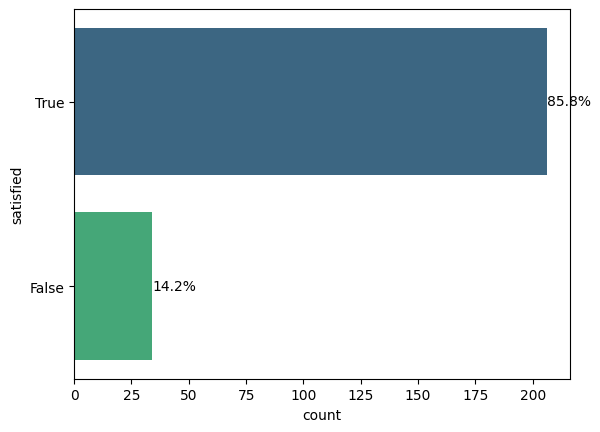

In [42]:
plot_judge_results(
    baseline_dspy_judge_results.to_pandas()
)

## Optimization: Apply the optimized judge in a new judge metric function to optimize the generator

In [18]:
judge_lm = dspy.LM(
    "gemini/gemini-1.5-flash",
    api_key=secrets["GEMINI_API_KEY"],
    cache=False,
    temperature=0
)


# A helper that runs a module with a specific LM context
class ModuleWithLM(dspy.Module):
    def __init__(self, lm, module):
        super().__init__()
        self.lm = lm
        self.module = module

    def forward(self, **kwargs):
        with dspy.context(lm=self.lm):
            return self.module(**kwargs)

optimized_judge_program = ModuleWithLM(judge_lm, optimized_judge)

In [19]:
generate_model = dspy.LM(
    "openai/gpt-3.5-turbo",
    api_key=secrets["OPENAI_API_KEY"],
    cache=False,
    temperature=0
)
dspy.configure(lm=generate_model,track_usage=True,adapter=dspy.JSONAdapter())
generate_response = support_transcript_generator_module

In [20]:
generate_response.save("dspy_modules/baseline_generation",save_program=True)

In [21]:
def LLM_judge_metric(example, pred, trace=None):

    # the input transcript
    transcript_text = str(example.transcript)

    # the output llm response
    output_text = str(pred.llm_response)

    transcript_text = f"{transcript_text}\nSupport: {output_text}"
    
    if not transcript_text:
        # Fallback or raise; metric must be deterministic
        return False

    judged = optimized_judge_program(transcript=transcript_text)
    # judged.satisfied is expected to be a bool with JSONAdapter or a string convertible to bool
    return bool(judged.satisfied)

In [22]:
dev_dataset_examples = convert_dataset_to_dspy_examples(
    dev_dataset,
    field_mapping = {"transcript":"company_and_transcript"},
    input_field="transcript"
)

2025-08-18 21:43:51 - dspy_judge.processor.utils - INFO - Processed 240 training examples


## Crude test/train split

In [24]:
training_set = dev_dataset_examples[:200]
validation_set = dev_dataset_examples[200:]

## Run the optimization

In [25]:
optimizer = dspy.MIPROv2(
    metric=LLM_judge_metric,
    auto="medium",
    init_temperature=1.0,
    seed=101
)

generate_reasoning_optimized = optimizer.compile(
    generate_response,
    trainset=training_set,
    requires_permission_to_run=False,
)

2025/08/18 21:50:06 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING MEDIUM AUTO RUN SETTINGS:
num_trials: 18
minibatch: True
num_fewshot_candidates: 12
num_instruct_candidates: 6
valset size: 160

2025/08/18 21:50:06 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/08/18 21:50:06 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/08/18 21:50:06 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=12 sets of demonstrations...


Bootstrapping set 1/12
Bootstrapping set 2/12
Bootstrapping set 3/12



  0%|                                                                                                                       | 0/40 [00:00<?, ?it/s]21:50:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



  2%|██▊                                                                                                            | 1/40 [00:01<00:54,  1.39s/it]21:50:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



  5%|█████▌                                                                                                         | 2/40 [00:02<00:49,  1.30s/it]21:50:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:08 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:09 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



  8%|████████▎                                                                                                      | 3/40 [00:03<00:48,  1.31s/it]21:50:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



 10%|███████████                                                                                                    | 4/40 [00:05<00:47,  1.32s/it]


Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Bootstrapping set 4/12



  0%|                                                                                                                       | 0/40 [00:00<?, ?it/s]21:50:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:12 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



  2%|██▊                                                                                                            | 1/40 [00:01<00:53,  1.37s/it]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 5/12



  0%|                                                                                                                       | 0/40 [00:00<?, ?it/s]21:50:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:12 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:13 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



  2%|██▊                                                                                                            | 1/40 [00:01<00:45,  1.17s/it]21:50:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:13 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:14 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



  5%|█████▌                                                                                                         | 2/40 [00:02<00:49,  1.30s/it]


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 6/12



  0%|                                                                                                                       | 0/40 [00:00<?, ?it/s]21:50:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:15 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:16 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



  2%|██▊                                                                                                            | 1/40 [00:01<00:54,  1.40s/it]21:50:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:16 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:17 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



  5%|█████▌                                                                                                         | 2/40 [00:03<01:01,  1.62s/it]21:50:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



  8%|████████▎                                                                                                      | 3/40 [00:04<00:54,  1.47s/it]


Bootstrapped 2 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.
Bootstrapping set 7/12



  0%|                                                                                                                       | 0/40 [00:00<?, ?it/s]21:50:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:20 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



  2%|██▊                                                                                                            | 1/40 [00:01<00:55,  1.42s/it]21:50:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



  5%|█████▌                                                                                                         | 2/40 [00:02<00:57,  1.51s/it]21:50:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



  8%|████████▎                                                                                                      | 3/40 [00:04<00:54,  1.46s/it]


Bootstrapped 3 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.
Bootstrapping set 8/12



  0%|                                                                                                                       | 0/40 [00:00<?, ?it/s]21:50:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



  2%|██▊                                                                                                            | 1/40 [00:01<01:07,  1.73s/it]21:50:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



  5%|█████▌                                                                                                         | 2/40 [00:04<01:26,  2.27s/it]21:50:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



  8%|████████▎                                                                                                      | 3/40 [00:06<01:13,  1.98s/it]21:50:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



 10%|███████████                                                                                                    | 4/40 [00:07<01:11,  1.98s/it]


Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Bootstrapping set 9/12



  0%|                                                                                                                       | 0/40 [00:00<?, ?it/s]21:50:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



  2%|██▊                                                                                                            | 1/40 [00:01<00:57,  1.47s/it]21:50:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



  5%|█████▌                                                                                                         | 2/40 [00:03<01:07,  1.78s/it]21:50:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



  8%|████████▎                                                                                                      | 3/40 [00:05<01:02,  1.70s/it]21:50:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



 10%|███████████                                                                                                    | 4/40 [00:06<00:54,  1.51s/it]21:50:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



 12%|█████████████▉                                                                                                 | 5/40 [00:08<00:55,  1.59s/it]21:50:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



 15%|████████████████▋                                                                                              | 6/40 [00:09<00:51,  1.53s/it]


Bootstrapped 4 full traces after 6 examples for up to 1 rounds, amounting to 6 attempts.
Bootstrapping set 10/12



  0%|                                                                                                                       | 0/40 [00:00<?, ?it/s]21:50:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:41 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



  2%|██▊                                                                                                            | 1/40 [00:01<00:51,  1.33s/it]21:50:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



  5%|█████▌                                                                                                         | 2/40 [00:03<00:58,  1.54s/it]


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 11/12



  0%|                                                                                                                       | 0/40 [00:00<?, ?it/s]21:50:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



  2%|██▊                                                                                                            | 1/40 [00:01<00:52,  1.35s/it]21:50:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



  5%|█████▌                                                                                                         | 2/40 [00:02<00:54,  1.44s/it]21:50:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



  8%|████████▎                                                                                                      | 3/40 [00:04<00:52,  1.41s/it]21:50:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



 10%|███████████                                                                                                    | 4/40 [00:05<00:47,  1.32s/it]21:50:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



 12%|█████████████▉                                                                                                 | 5/40 [00:06<00:44,  1.28s/it]


Bootstrapped 3 full traces after 5 examples for up to 1 rounds, amounting to 5 attempts.
Bootstrapping set 12/12



  0%|                                                                                                                       | 0/40 [00:00<?, ?it/s]21:50:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:50:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:50:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler



  2%|██▊                                                                                                            | 1/40 [00:01<00:44,  1.14s/it]
2025/08/18 21:50:51 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/08/18 21:50:51 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
21:50:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
2025-08-18 21:50:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


2025/08/18 21:50:57 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing N=6 instructions...

21:50:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:50:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:50:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:50:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:50:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:08 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:10 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:13 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:16 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


2025/08/18 21:51:17 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/08/18 21:51:17 INFO dspy.teleprompt.mipro_optimizer_v2: 0: You are a customer service agent whose job is to provide single, concise response to a customer query.
You will receive a transcript of the interaction so far, and your job is to respond to the latest customer message.
You'll also be given the name of the company you work for, which should help you understand the context of the messages.

2025/08/18 21:51:17 INFO dspy.teleprompt.mipro_optimizer_v2: 1: As a customer service agent at a high-end fashion brand, you have a VIP client contacting support services regarding a missing delivery of a limited edition dress just before a major event. Provide a compassionate and efficient response to address the issue with a focus on resolving the situation promptly and ensuring customer satisfaction.

2025/08/18 21:51:17 INFO dspy.teleprompt.mipro_optimizer_v2: 2: As a customer service 

2025-08-18 21:51:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
  0%|                                                                                                                      | 0/160 [00:00<?, ?it/s]2025-08-18 21:51:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:18 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:18 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:18 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:18 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:18 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 1.00 / 1 (100.0%):   0%|                                                                                   | 0/160 [00:01<?, ?it/s]2025-08-18 21:51:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 1.00 / 1 (100.0%):   1%|▍                                                                          | 1/160 [00:01<03:32,  1.33s/it]

21:51:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:18 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:18 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 2.00 / 2 (100.0%):   1%|▍                                                                          | 1/160 [00:01<03:32,  1.33s/it]2025-08-18 21:51:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 2.00 / 2 (100.0%):   1%|▉                                                                          | 2/160 [00:01<01:52,  1.40it/s]

21:51:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 3.00 / 3 (100.0%):   1%|▉                                                                          | 2/160 [00:01<01:52,  1.40it/s]2025-08-18 21:51:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 4.00 / 4 (100.0%):   2%|█▍                                                                         | 3/160 [00:01<01:52,  1.40it/s]2025-08-18 21:51:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 4.00 / 4 (100.0%):   2%|█▉                                                                         | 4/160 [00:01<00:49,  3.18it/s]

21:51:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 5.00 / 5 (100.0%):   2%|█▉                                                                         | 4/160 [00:01<00:49,  3.18it/s]2025-08-18 21:51:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 5.00 / 6 (83.3%):   3%|██▍                                                                         | 5/160 [00:01<00:48,  3.18it/s]2025-08-18 21:51:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 5.00 / 6 (83.3%):   4%|██▊                                                                         | 6/160 [00:01<00:31,  4.92it/s]

21:51:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 5.00 / 7 (71.4%):   4%|███▎                                                                        | 7/160 [00:02<00:49,  3.09it/s]

21:51:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:20 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 6.00 / 8 (75.0%):   4%|███▎                                                                        | 7/160 [00:03<00:49,  3.09it/s]

21:51:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 6.00 / 8 (75.0%):   5%|███▊                                                                        | 8/160 [00:03<00:54,  2.80it/s]

21:51:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 7.00 / 9 (77.8%):   5%|███▊                                                                        | 8/160 [00:03<00:54,  2.80it/s]

21:51:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 7.00 / 10 (70.0%):   6%|████▏                                                                      | 9/160 [00:03<00:54,  2.80it/s]

21:51:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:51:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:51:20 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 8.00 / 11 (72.7%):   6%|████▋                                                                     | 10/160 [00:03<00:53,  2.80it/s]

21:51:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 12 (66.7%):   7%|█████                                                                     | 11/160 [00:03<00:53,  2.80it/s]2025-08-18 21:51:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 8.00 / 12 (66.7%):   8%|█████▌                                                                    | 12/160 [00:03<00:25,  5.80it/s]

21:51:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:20 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 9.00 / 13 (69.2%):   8%|█████▌                                                                    | 12/160 [00:03<00:25,  5.80it/s]2025-08-18 21:51:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 9.00 / 13 (69.2%):   8%|██████                                                                    | 13/160 [00:03<00:28,  5.08it/s]

21:51:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 9.00 / 14 (64.3%):   8%|██████                                                                    | 13/160 [00:04<00:28,  5.08it/s]2025-08-18 21:51:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 9.00 / 14 (64.3%):   9%|██████▍                                                                   | 14/160 [00:04<00:36,  4.03it/s]

21:51:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 10.00 / 15 (66.7%):   9%|██████▍                                                                  | 14/160 [00:04<00:36,  4.03it/s]2025-08-18 21:51:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 10.00 / 15 (66.7%):   9%|██████▊                                                                  | 15/160 [00:04<00:38,  3.75it/s]

21:51:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 11.00 / 16 (68.8%):   9%|██████▊                                                                  | 15/160 [00:04<00:38,  3.75it/s]

21:51:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 12.00 / 17 (70.6%):  10%|███████▎                                                                 | 16/160 [00:04<00:38,  3.75it/s]

21:51:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 12.00 / 17 (70.6%):  11%|███████▊                                                                 | 17/160 [00:04<00:26,  5.49it/s]2025-08-18 21:51:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 13.00 / 18 (72.2%):  11%|███████▊                                                                 | 17/160 [00:04<00:26,  5.49it/s]

21:51:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 14.00 / 19 (73.7%):  11%|████████▏                                                                | 18/160 [00:04<00:25,  5.49it/s]

21:51:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 14.00 / 19 (73.7%):  12%|████████▋                                                                | 19/160 [00:04<00:30,  4.67it/s]

21:51:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 14.00 / 20 (70.0%):  12%|████████▋                                                                | 19/160 [00:05<00:30,  4.67it/s]

21:51:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 21 (71.4%):  12%|█████████▏                                                               | 20/160 [00:05<00:30,  4.67it/s]2025-08-18 21:51:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 15.00 / 21 (71.4%):  13%|█████████▌                                                               | 21/160 [00:05<00:35,  3.95it/s]

21:51:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 16.00 / 22 (72.7%):  13%|█████████▌                                                               | 21/160 [00:05<00:35,  3.95it/s]2025-08-18 21:51:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 16.00 / 23 (69.6%):  14%|██████████                                                               | 22/160 [00:06<00:34,  3.95it/s]

21:51:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 16.00 / 23 (69.6%):  14%|██████████▍                                                              | 23/160 [00:06<00:31,  4.35it/s]

21:51:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 17.00 / 24 (70.8%):  14%|██████████▍                                                              | 23/160 [00:06<00:31,  4.35it/s]2025-08-18 21:51:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 17.00 / 25 (68.0%):  15%|██████████▉                                                              | 24/160 [00:06<00:31,  4.35it/s]2025-08-18 21:51:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 18.00 / 26 (69.2%):  16%|███████████▍                                                             | 25/160 [00:06<00:31,  4.35it/s]2025-08-18 21:51:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 18.00 / 26 (69.2%):  16%|███████████▊                                                             | 26/160 [00:06<00:20,  6.49it/s]

21:51:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 19.00 / 27 (70.4%):  16%|███████████▊                                                             | 26/160 [00:06<00:20,  6.49it/s]2025-08-18 21:51:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
21:51:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:51:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 20.00 / 28 (71.4%):  17%|████████████▎                                                            | 27/160 [00:06<00:20,  6.49it/s]2025-08-18 21:51:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 20.00 / 28 (71.4%):  18%|████████████▊                                                            | 28/160 [00:06<00:29,  4.48it/s]

21:51:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 21.00 / 29 (72.4%):  18%|████████████▊                                                            | 28/160 [00:07<00:29,  4.48it/s]2025-08-18 21:51:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 21.00 / 29 (72.4%):  18%|█████████████▏                                                           | 29/160 [00:07<00:27,  4.80it/s]

21:51:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 22.00 / 30 (73.3%):  18%|█████████████▏                                                           | 29/160 [00:07<00:27,  4.80it/s]2025-08-18 21:51:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 22.00 / 30 (73.3%):  19%|█████████████▋                                                           | 30/160 [00:07<00:26,  4.85it/s]

21:51:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 23.00 / 31 (74.2%):  19%|█████████████▋                                                           | 30/160 [00:07<00:26,  4.85it/s]2025-08-18 21:51:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 23.00 / 31 (74.2%):  19%|██████████████▏                                                          | 31/160 [00:07<00:24,  5.28it/s]

21:51:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 24.00 / 32 (75.0%):  19%|██████████████▏                                                          | 31/160 [00:07<00:24,  5.28it/s]2025-08-18 21:51:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 25.00 / 33 (75.8%):  20%|██████████████▌                                                          | 32/160 [00:08<00:24,  5.28it/s]

21:51:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 25.00 / 33 (75.8%):  21%|███████████████                                                          | 33/160 [00:08<00:30,  4.22it/s]

21:51:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 26.00 / 34 (76.5%):  21%|███████████████                                                          | 33/160 [00:08<00:30,  4.22it/s]2025-08-18 21:51:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 26.00 / 34 (76.5%):  21%|███████████████▌                                                         | 34/160 [00:08<00:28,  4.35it/s]

21:51:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 26.00 / 35 (74.3%):  21%|███████████████▌                                                         | 34/160 [00:08<00:28,  4.35it/s]

21:51:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:51:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:51:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 27.00 / 36 (75.0%):  22%|███████████████▉                                                         | 35/160 [00:08<00:28,  4.35it/s]

21:51:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 27.00 / 37 (73.0%):  22%|████████████████▍                                                        | 36/160 [00:08<00:28,  4.35it/s]2025-08-18 21:51:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 27.00 / 37 (73.0%):  23%|████████████████▉                                                        | 37/160 [00:08<00:21,  5.79it/s]

21:51:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 28.00 / 38 (73.7%):  23%|████████████████▉                                                        | 37/160 [00:08<00:21,  5.79it/s]2025-08-18 21:51:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 29.00 / 39 (74.4%):  24%|█████████████████▎                                                       | 38/160 [00:08<00:21,  5.79it/s]

21:51:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 29.00 / 39 (74.4%):  24%|█████████████████▊                                                       | 39/160 [00:08<00:17,  7.02it/s]2025-08-18 21:51:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 29.00 / 40 (72.5%):  24%|█████████████████▊                                                       | 39/160 [00:09<00:17,  7.02it/s]2025-08-18 21:51:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 29.00 / 40 (72.5%):  25%|██████████████████▎                                                      | 40/160 [00:09<00:27,  4.35it/s]

21:51:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 30.00 / 41 (73.2%):  25%|██████████████████▎                                                      | 40/160 [00:09<00:27,  4.35it/s]2025-08-18 21:51:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 30.00 / 41 (73.2%):  26%|██████████████████▋                                                      | 41/160 [00:09<00:31,  3.83it/s]

21:51:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 31.00 / 42 (73.8%):  26%|██████████████████▋                                                      | 41/160 [00:09<00:31,  3.83it/s]2025-08-18 21:51:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 31.00 / 43 (72.1%):  26%|███████████████████▏                                                     | 42/160 [00:09<00:30,  3.83it/s]2025-08-18 21:51:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 32.00 / 44 (72.7%):  27%|███████████████████▌                                                     | 43/160 [00:10<00:30,  3.83it/s]

21:51:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 32.00 / 44 (72.7%):  28%|████████████████████                                                     | 44/160 [00:10<00:24,  4.77it/s]2025-08-18 21:51:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 33.00 / 45 (73.3%):  28%|████████████████████                                                     | 44/160 [00:10<00:24,  4.77it/s]2025-08-18 21:51:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 33.00 / 45 (73.3%):  28%|████████████████████▌                                                    | 45/160 [00:10<00:23,  4.95it/s]

21:51:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 34.00 / 46 (73.9%):  28%|████████████████████▌                                                    | 45/160 [00:10<00:23,  4.95it/s]2025-08-18 21:51:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 35.00 / 47 (74.5%):  29%|████████████████████▉                                                    | 46/160 [00:10<00:23,  4.95it/s]

21:51:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 35.00 / 47 (74.5%):  29%|█████████████████████▍                                                   | 47/160 [00:10<00:23,  4.89it/s]2025-08-18 21:51:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 36.00 / 48 (75.0%):  29%|█████████████████████▍                                                   | 47/160 [00:10<00:23,  4.89it/s]2025-08-18 21:51:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 36.00 / 48 (75.0%):  30%|█████████████████████▉                                                   | 48/160 [00:10<00:21,  5.28it/s]

21:51:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:51:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 37.00 / 49 (75.5%):  30%|█████████████████████▉                                                   | 48/160 [00:11<00:21,  5.28it/s]

21:51:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 37.00 / 49 (75.5%):  31%|██████████████████████▎                                                  | 49/160 [00:11<00:24,  4.46it/s]2025-08-18 21:51:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 38.00 / 50 (76.0%):  31%|██████████████████████▎                                                  | 49/160 [00:11<00:24,  4.46it/s]

21:51:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 39.00 / 51 (76.5%):  31%|██████████████████████▊                                                  | 50/160 [00:11<00:24,  4.46it/s]2025-08-18 21:51:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 39.00 / 51 (76.5%):  32%|███████████████████████▎                                                 | 51/160 [00:11<00:24,  4.47it/s]

21:51:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 40.00 / 52 (76.9%):  32%|███████████████████████▎                                                 | 51/160 [00:11<00:24,  4.47it/s]2025-08-18 21:51:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 40.00 / 52 (76.9%):  32%|███████████████████████▋                                                 | 52/160 [00:11<00:24,  4.46it/s]

21:51:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 41.00 / 53 (77.4%):  32%|███████████████████████▋                                                 | 52/160 [00:11<00:24,  4.46it/s]

21:51:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 42.00 / 54 (77.8%):  33%|████████████████████████▏                                                | 53/160 [00:12<00:24,  4.46it/s]2025-08-18 21:51:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 42.00 / 54 (77.8%):  34%|████████████████████████▋                                                | 54/160 [00:12<00:18,  5.87it/s]

21:51:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 43.00 / 55 (78.2%):  34%|████████████████████████▋                                                | 54/160 [00:12<00:18,  5.87it/s]

21:51:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 43.00 / 55 (78.2%):  34%|█████████████████████████                                                | 55/160 [00:12<00:20,  5.10it/s]2025-08-18 21:51:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:51:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 43.00 / 56 (76.8%):  35%|█████████████████████████▌                                               | 56/160 [00:12<00:23,  4.49it/s]2025-08-18 21:51:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 44.00 / 57 (77.2%):  35%|█████████████████████████▌                                               | 56/160 [00:12<00:23,  4.49it/s]2025-08-18 21:51:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 45.00 / 58 (77.6%):  36%|██████████████████████████                                               | 57/160 [00:13<00:22,  4.49it/s]

21:51:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 45.00 / 58 (77.6%):  36%|██████████████████████████▍                                              | 58/160 [00:13<00:23,  4.30it/s]

21:51:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 46.00 / 59 (78.0%):  36%|██████████████████████████▍                                              | 58/160 [00:13<00:23,  4.30it/s]2025-08-18 21:51:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 47.00 / 60 (78.3%):  37%|██████████████████████████▉                                              | 59/160 [00:13<00:23,  4.30it/s]2025-08-18 21:51:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 47.00 / 60 (78.3%):  38%|███████████████████████████▍                                             | 60/160 [00:13<00:16,  5.98it/s]

21:51:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 48.00 / 61 (78.7%):  38%|███████████████████████████▍                                             | 60/160 [00:13<00:16,  5.98it/s]2025-08-18 21:51:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 49.00 / 62 (79.0%):  38%|███████████████████████████▊                                             | 61/160 [00:13<00:16,  5.98it/s]

21:51:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 49.00 / 62 (79.0%):  39%|████████████████████████████▎                                            | 62/160 [00:13<00:21,  4.62it/s]

21:51:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 50.00 / 63 (79.4%):  39%|████████████████████████████▎                                            | 62/160 [00:13<00:21,  4.62it/s]

21:51:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 51.00 / 64 (79.7%):  39%|████████████████████████████▋                                            | 63/160 [00:14<00:20,  4.62it/s]2025-08-18 21:51:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 51.00 / 64 (79.7%):  40%|█████████████████████████████▏                                           | 64/160 [00:14<00:24,  3.90it/s]

21:51:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 51.00 / 65 (78.5%):  40%|█████████████████████████████▏                                           | 64/160 [00:14<00:24,  3.90it/s]2025-08-18 21:51:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 52.00 / 66 (78.8%):  41%|██████████████████████████████                                           | 66/160 [00:14<00:19,  4.81it/s]

21:51:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:51:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:51:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 53.00 / 67 (79.1%):  41%|██████████████████████████████                                           | 66/160 [00:14<00:19,  4.81it/s]2025-08-18 21:51:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 53.00 / 67 (79.1%):  42%|██████████████████████████████▌                                          | 67/160 [00:14<00:18,  5.11it/s]

21:51:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 54.00 / 68 (79.4%):  42%|██████████████████████████████▌                                          | 67/160 [00:15<00:18,  5.11it/s]

21:51:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 54.00 / 68 (79.4%):  42%|███████████████████████████████                                          | 68/160 [00:15<00:17,  5.26it/s]

21:51:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 54.00 / 69 (78.3%):  42%|███████████████████████████████                                          | 68/160 [00:15<00:17,  5.26it/s]2025-08-18 21:51:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 54.00 / 69 (78.3%):  43%|███████████████████████████████▍                                         | 69/160 [00:15<00:17,  5.20it/s]

21:51:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 55.00 / 70 (78.6%):  43%|███████████████████████████████▍                                         | 69/160 [00:15<00:17,  5.20it/s]2025-08-18 21:51:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 55.00 / 70 (78.6%):  44%|███████████████████████████████▉                                         | 70/160 [00:15<00:21,  4.09it/s]

21:51:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 55.00 / 71 (77.5%):  44%|███████████████████████████████▉                                         | 70/160 [00:16<00:21,  4.09it/s]2025-08-18 21:51:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 55.00 / 71 (77.5%):  44%|████████████████████████████████▍                                        | 71/160 [00:16<00:23,  3.77it/s]

21:51:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 56.00 / 72 (77.8%):  44%|████████████████████████████████▍                                        | 71/160 [00:16<00:23,  3.77it/s]2025-08-18 21:51:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 57.00 / 73 (78.1%):  45%|████████████████████████████████▊                                        | 72/160 [00:16<00:23,  3.77it/s]2025-08-18 21:51:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 58.00 / 74 (78.4%):  46%|█████████████████████████████████▎                                       | 73/160 [00:16<00:23,  3.77it/s]2025-08-18 21:51:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 58.00 / 74 (78.4%):  46%|█████████████████████████████████▊                                       | 74/160 [00:16<00:15,  5.47it/s]

21:51:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 59.00 / 75 (78.7%):  46%|█████████████████████████████████▊                                       | 74/160 [00:16<00:15,  5.47it/s]2025-08-18 21:51:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 59.00 / 75 (78.7%):  47%|██████████████████████████████████▏                                      | 75/160 [00:16<00:17,  4.81it/s]

21:51:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 60.00 / 76 (78.9%):  48%|██████████████████████████████████▋                                      | 76/160 [00:16<00:16,  5.05it/s]2025-08-18 21:51:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 61.00 / 77 (79.2%):  48%|██████████████████████████████████▋                                      | 76/160 [00:17<00:16,  5.05it/s]2025-08-18 21:51:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 61.00 / 77 (79.2%):  48%|███████████████████████████████████▏                                     | 77/160 [00:17<00:20,  4.07it/s]

21:51:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 62.00 / 78 (79.5%):  48%|███████████████████████████████████▏                                     | 77/160 [00:17<00:20,  4.07it/s]2025-08-18 21:51:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 63.00 / 79 (79.7%):  49%|███████████████████████████████████▌                                     | 78/160 [00:17<00:20,  4.07it/s]2025-08-18 21:51:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 63.00 / 79 (79.7%):  49%|████████████████████████████████████                                     | 79/160 [00:17<00:16,  4.88it/s]

21:51:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 64.00 / 80 (80.0%):  49%|████████████████████████████████████                                     | 79/160 [00:17<00:16,  4.88it/s]

21:51:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 65.00 / 81 (80.2%):  51%|████████████████████████████████████▉                                    | 81/160 [00:17<00:16,  4.89it/s]2025-08-18 21:51:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 66.00 / 82 (80.5%):  51%|████████████████████████████████████▉                                    | 81/160 [00:18<00:16,  4.89it/s]2025-08-18 21:51:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 66.00 / 82 (80.5%):  51%|█████████████████████████████████████▍                                   | 82/160 [00:18<00:14,  5.43it/s]

21:51:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 67.00 / 83 (80.7%):  51%|█████████████████████████████████████▍                                   | 82/160 [00:18<00:14,  5.43it/s]

21:51:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 68.00 / 84 (81.0%):  52%|█████████████████████████████████████▊                                   | 83/160 [00:18<00:14,  5.43it/s]2025-08-18 21:51:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 68.00 / 84 (81.0%):  52%|██████████████████████████████████████▎                                  | 84/160 [00:18<00:11,  6.78it/s]

21:51:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 69.00 / 85 (81.2%):  52%|██████████████████████████████████████▎                                  | 84/160 [00:18<00:11,  6.78it/s]2025-08-18 21:51:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 69.00 / 85 (81.2%):  53%|██████████████████████████████████████▊                                  | 85/160 [00:18<00:13,  5.66it/s]

21:51:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 70.00 / 86 (81.4%):  53%|██████████████████████████████████████▊                                  | 85/160 [00:18<00:13,  5.66it/s]2025-08-18 21:51:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:36 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 70.00 / 86 (81.4%):  54%|███████████████████████████████████████▏                                 | 86/160 [00:18<00:17,  4.32it/s]

21:51:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 71.00 / 87 (81.6%):  54%|███████████████████████████████████████▏                                 | 86/160 [00:18<00:17,  4.32it/s]2025-08-18 21:51:36 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 72.00 / 88 (81.8%):  54%|███████████████████████████████████████▋                                 | 87/160 [00:18<00:16,  4.32it/s]2025-08-18 21:51:36 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 73.00 / 89 (82.0%):  55%|████████████████████████████████████████▏                                | 88/160 [00:19<00:16,  4.32it/s]2025-08-18 21:51:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:36 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 73.00 / 89 (82.0%):  56%|████████████████████████████████████████▌                                | 89/160 [00:19<00:14,  4.88it/s]

21:51:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 74.00 / 90 (82.2%):  56%|████████████████████████████████████████▌                                | 89/160 [00:19<00:14,  4.88it/s]2025-08-18 21:51:36 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 74.00 / 90 (82.2%):  56%|█████████████████████████████████████████                                | 90/160 [00:19<00:14,  4.99it/s]

21:51:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 75.00 / 91 (82.4%):  57%|█████████████████████████████████████████▌                               | 91/160 [00:19<00:15,  4.35it/s]

21:51:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 75.00 / 92 (81.5%):  57%|█████████████████████████████████████████▌                               | 91/160 [00:20<00:15,  4.35it/s]2025-08-18 21:51:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 75.00 / 92 (81.5%):  57%|█████████████████████████████████████████▉                               | 92/160 [00:20<00:15,  4.28it/s]

21:51:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 76.00 / 93 (81.7%):  58%|██████████████████████████████████████████▍                              | 93/160 [00:20<00:14,  4.65it/s]

21:51:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 77.00 / 94 (81.9%):  58%|██████████████████████████████████████████▍                              | 93/160 [00:20<00:14,  4.65it/s]2025-08-18 21:51:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
21:51:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:51:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 78.00 / 95 (82.1%):  59%|██████████████████████████████████████████▉                              | 94/160 [00:20<00:14,  4.65it/s]2025-08-18 21:51:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 78.00 / 95 (82.1%):  59%|███████████████████████████████████████████▎                             | 95/160 [00:20<00:10,  6.43it/s]

21:51:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 79.00 / 96 (82.3%):  59%|███████████████████████████████████████████▎                             | 95/160 [00:20<00:10,  6.43it/s]2025-08-18 21:51:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 79.00 / 96 (82.3%):  60%|███████████████████████████████████████████▊                             | 96/160 [00:20<00:13,  4.66it/s]

21:51:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 80.00 / 97 (82.5%):  60%|███████████████████████████████████████████▊                             | 96/160 [00:21<00:13,  4.66it/s]

21:51:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 80.00 / 97 (82.5%):  61%|████████████████████████████████████████████▎                            | 97/160 [00:21<00:12,  5.18it/s]

21:51:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 81.00 / 98 (82.7%):  61%|████████████████████████████████████████████▎                            | 97/160 [00:21<00:12,  5.18it/s]2025-08-18 21:51:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 81.00 / 98 (82.7%):  61%|████████████████████████████████████████████▋                            | 98/160 [00:21<00:11,  5.19it/s]

21:51:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 82.00 / 99 (82.8%):  62%|█████████████████████████████████████████████▏                           | 99/160 [00:21<00:12,  4.88it/s]2025-08-18 21:51:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 83.00 / 100 (83.0%):  62%|████████████████████████████████████████████▌                           | 99/160 [00:21<00:12,  4.88it/s]

21:51:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 83.00 / 100 (83.0%):  62%|████████████████████████████████████████████▍                          | 100/160 [00:21<00:14,  4.25it/s]

21:51:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 84.00 / 101 (83.2%):  62%|████████████████████████████████████████████▍                          | 100/160 [00:21<00:14,  4.25it/s]

21:51:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 85.00 / 102 (83.3%):  63%|████████████████████████████████████████████▊                          | 101/160 [00:21<00:13,  4.25it/s]2025-08-18 21:51:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 85.00 / 103 (82.5%):  64%|█████████████████████████████████████████████▎                         | 102/160 [00:22<00:13,  4.25it/s]2025-08-18 21:51:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 85.00 / 103 (82.5%):  64%|█████████████████████████████████████████████▋                         | 103/160 [00:22<00:13,  4.24it/s]

21:51:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 86.00 / 104 (82.7%):  64%|█████████████████████████████████████████████▋                         | 103/160 [00:22<00:13,  4.24it/s]2025-08-18 21:51:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 87.00 / 105 (82.9%):  65%|██████████████████████████████████████████████▏                        | 104/160 [00:22<00:13,  4.24it/s]2025-08-18 21:51:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 87.00 / 105 (82.9%):  66%|██████████████████████████████████████████████▌                        | 105/160 [00:22<00:10,  5.45it/s]

21:51:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 88.00 / 106 (83.0%):  66%|██████████████████████████████████████████████▌                        | 105/160 [00:23<00:10,  5.45it/s]2025-08-18 21:51:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 88.00 / 106 (83.0%):  66%|███████████████████████████████████████████████                        | 106/160 [00:23<00:11,  4.64it/s]2025-08-18 21:51:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 89.00 / 107 (83.2%):  66%|███████████████████████████████████████████████                        | 106/160 [00:23<00:11,  4.64it/s]

21:51:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 89.00 / 108 (82.4%):  67%|███████████████████████████████████████████████▍                       | 107/160 [00:23<00:11,  4.64it/s]

21:51:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 90.00 / 109 (82.6%):  68%|███████████████████████████████████████████████▉                       | 108/160 [00:23<00:11,  4.64it/s]2025-08-18 21:51:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 90.00 / 109 (82.6%):  68%|████████████████████████████████████████████████▎                      | 109/160 [00:23<00:09,  5.48it/s]

21:51:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 91.00 / 110 (82.7%):  68%|████████████████████████████████████████████████▎                      | 109/160 [00:24<00:09,  5.48it/s]2025-08-18 21:51:41 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 91.00 / 110 (82.7%):  69%|████████████████████████████████████████████████▊                      | 110/160 [00:24<00:12,  3.97it/s]

21:51:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 92.00 / 111 (82.9%):  69%|████████████████████████████████████████████████▊                      | 110/160 [00:24<00:12,  3.97it/s]2025-08-18 21:51:41 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 93.00 / 112 (83.0%):  69%|█████████████████████████████████████████████████▎                     | 111/160 [00:24<00:12,  3.97it/s]2025-08-18 21:51:41 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 93.00 / 112 (83.0%):  70%|█████████████████████████████████████████████████▋                     | 112/160 [00:24<00:10,  4.72it/s]

21:51:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 94.00 / 113 (83.2%):  70%|█████████████████████████████████████████████████▋                     | 112/160 [00:24<00:10,  4.72it/s]

21:51:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:41 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 94.00 / 113 (83.2%):  71%|██████████████████████████████████████████████████▏                    | 113/160 [00:24<00:09,  5.14it/s]

21:51:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:41 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 95.00 / 114 (83.3%):  71%|██████████████████████████████████████████████████▏                    | 113/160 [00:24<00:09,  5.14it/s]

21:51:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 95.00 / 115 (82.6%):  71%|██████████████████████████████████████████████████▌                    | 114/160 [00:24<00:08,  5.14it/s]2025-08-18 21:51:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 95.00 / 115 (82.6%):  72%|███████████████████████████████████████████████████                    | 115/160 [00:24<00:09,  4.93it/s]

21:51:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 95.00 / 116 (81.9%):  72%|███████████████████████████████████████████████████▍                   | 116/160 [00:24<00:08,  5.24it/s]2025-08-18 21:51:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 96.00 / 117 (82.1%):  72%|███████████████████████████████████████████████████▍                   | 116/160 [00:25<00:08,  5.24it/s]2025-08-18 21:51:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 96.00 / 117 (82.1%):  73%|███████████████████████████████████████████████████▉                   | 117/160 [00:25<00:10,  4.11it/s]

21:51:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 97.00 / 118 (82.2%):  73%|███████████████████████████████████████████████████▉                   | 117/160 [00:25<00:10,  4.11it/s]2025-08-18 21:51:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 98.00 / 119 (82.4%):  74%|████████████████████████████████████████████████████▎                  | 118/160 [00:25<00:10,  4.11it/s]

21:51:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 99.00 / 120 (82.5%):  74%|████████████████████████████████████████████████████▊                  | 119/160 [00:25<00:09,  4.11it/s]2025-08-18 21:51:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 99.00 / 120 (82.5%):  75%|█████████████████████████████████████████████████████▎                 | 120/160 [00:25<00:07,  5.71it/s]

21:51:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 100.00 / 121 (82.6%):  75%|████████████████████████████████████████████████████▌                 | 120/160 [00:25<00:07,  5.71it/s]2025-08-18 21:51:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 101.00 / 122 (82.8%):  76%|████████████████████████████████████████████████████▉                 | 121/160 [00:26<00:06,  5.71it/s]2025-08-18 21:51:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 101.00 / 122 (82.8%):  76%|█████████████████████████████████████████████████████▍                | 122/160 [00:26<00:08,  4.44it/s]

21:51:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 102.00 / 123 (82.9%):  76%|█████████████████████████████████████████████████████▍                | 122/160 [00:26<00:08,  4.44it/s]2025-08-18 21:51:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 102.00 / 123 (82.9%):  77%|█████████████████████████████████████████████████████▊                | 123/160 [00:26<00:07,  4.93it/s]

21:51:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 103.00 / 124 (83.1%):  77%|█████████████████████████████████████████████████████▊                | 123/160 [00:26<00:07,  4.93it/s]

21:51:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 103.00 / 124 (83.1%):  78%|██████████████████████████████████████████████████████▎               | 124/160 [00:26<00:08,  4.39it/s]2025-08-18 21:51:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 104.00 / 125 (83.2%):  78%|██████████████████████████████████████████████████████▎               | 124/160 [00:26<00:08,  4.39it/s]2025-08-18 21:51:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 105.00 / 126 (83.3%):  78%|██████████████████████████████████████████████████████▋               | 125/160 [00:27<00:07,  4.39it/s]2025-08-18 21:51:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 105.00 / 126 (83.3%):  79%|███████████████████████████████████████████████████████▏              | 126/160 [00:27<00:06,  5.38it/s]

21:51:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 106.00 / 127 (83.5%):  79%|███████████████████████████████████████████████████████▏              | 126/160 [00:27<00:06,  5.38it/s]

21:51:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 106.00 / 127 (83.5%):  79%|███████████████████████████████████████████████████████▌              | 127/160 [00:27<00:06,  5.29it/s]2025-08-18 21:51:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 107.00 / 128 (83.6%):  79%|███████████████████████████████████████████████████████▌              | 127/160 [00:27<00:06,  5.29it/s]2025-08-18 21:51:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 108.00 / 129 (83.7%):  80%|████████████████████████████████████████████████████████              | 128/160 [00:27<00:06,  5.29it/s]2025-08-18 21:51:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 108.00 / 129 (83.7%):  81%|████████████████████████████████████████████████████████▍             | 129/160 [00:27<00:06,  4.43it/s]

21:51:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 109.00 / 130 (83.8%):  81%|████████████████████████████████████████████████████████▍             | 129/160 [00:28<00:06,  4.43it/s]2025-08-18 21:51:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 109.00 / 130 (83.8%):  81%|████████████████████████████████████████████████████████▉             | 130/160 [00:28<00:07,  4.13it/s]

21:51:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 110.00 / 131 (84.0%):  81%|████████████████████████████████████████████████████████▉             | 130/160 [00:28<00:07,  4.13it/s]

21:51:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 110.00 / 131 (84.0%):  82%|█████████████████████████████████████████████████████████▎            | 131/160 [00:28<00:06,  4.19it/s]2025-08-18 21:51:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 111.00 / 132 (84.1%):  82%|█████████████████████████████████████████████████████████▎            | 131/160 [00:28<00:06,  4.19it/s]2025-08-18 21:51:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 112.00 / 133 (84.2%):  82%|█████████████████████████████████████████████████████████▊            | 132/160 [00:28<00:06,  4.19it/s]2025-08-18 21:51:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 112.00 / 133 (84.2%):  83%|██████████████████████████████████████████████████████████▏           | 133/160 [00:28<00:04,  6.07it/s]

21:51:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 113.00 / 134 (84.3%):  83%|██████████████████████████████████████████████████████████▏           | 133/160 [00:28<00:04,  6.07it/s]2025-08-18 21:51:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 113.00 / 134 (84.3%):  84%|██████████████████████████████████████████████████████████▋           | 134/160 [00:28<00:04,  5.82it/s]

21:51:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 114.00 / 135 (84.4%):  84%|██████████████████████████████████████████████████████████▋           | 134/160 [00:28<00:04,  5.82it/s]

21:51:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 114.00 / 135 (84.4%):  84%|███████████████████████████████████████████████████████████           | 135/160 [00:28<00:05,  4.89it/s]2025-08-18 21:51:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 115.00 / 136 (84.6%):  84%|███████████████████████████████████████████████████████████           | 135/160 [00:29<00:05,  4.89it/s]

21:51:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 115.00 / 136 (84.6%):  85%|███████████████████████████████████████████████████████████▌          | 136/160 [00:29<00:07,  3.11it/s]2025-08-18 21:51:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 116.00 / 137 (84.7%):  85%|███████████████████████████████████████████████████████████▌          | 136/160 [00:29<00:07,  3.11it/s]2025-08-18 21:51:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 117.00 / 138 (84.8%):  86%|███████████████████████████████████████████████████████████▉          | 137/160 [00:29<00:07,  3.11it/s]

21:51:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 117.00 / 138 (84.8%):  86%|████████████████████████████████████████████████████████████▍         | 138/160 [00:29<00:04,  4.70it/s]

21:51:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 117.00 / 139 (84.2%):  86%|████████████████████████████████████████████████████████████▍         | 138/160 [00:29<00:04,  4.70it/s]

21:51:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 118.00 / 140 (84.3%):  87%|████████████████████████████████████████████████████████████▊         | 139/160 [00:29<00:04,  4.70it/s]2025-08-18 21:51:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 118.00 / 140 (84.3%):  88%|█████████████████████████████████████████████████████████████▎        | 140/160 [00:29<00:03,  5.61it/s]

21:51:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 119.00 / 141 (84.4%):  88%|█████████████████████████████████████████████████████████████▎        | 140/160 [00:30<00:03,  5.61it/s]2025-08-18 21:51:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 119.00 / 141 (84.4%):  88%|█████████████████████████████████████████████████████████████▋        | 141/160 [00:30<00:03,  6.13it/s]

21:51:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:51:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:51:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 120.00 / 142 (84.5%):  88%|█████████████████████████████████████████████████████████████▋        | 141/160 [00:31<00:03,  6.13it/s]

21:51:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 120.00 / 142 (84.5%):  89%|██████████████████████████████████████████████████████████████▏       | 142/160 [00:31<00:06,  2.71it/s]

21:51:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 121.00 / 143 (84.6%):  89%|██████████████████████████████████████████████████████████████▏       | 142/160 [00:31<00:06,  2.71it/s]2025-08-18 21:51:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 122.00 / 144 (84.7%):  89%|██████████████████████████████████████████████████████████████▌       | 143/160 [00:31<00:06,  2.71it/s]2025-08-18 21:51:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 123.00 / 145 (84.8%):  90%|███████████████████████████████████████████████████████████████       | 144/160 [00:31<00:05,  2.71it/s]2025-08-18 21:51:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 124.00 / 146 (84.9%):  91%|███████████████████████████████████████████████████████████████▍      | 145/160 [00:31<00:05,  2.71it/s]

21:51:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 124.00 / 146 (84.9%):  91%|███████████████████████████████████████████████████████████████▉      | 146/160 [00:31<00:02,  5.55it/s]2025-08-18 21:51:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 125.00 / 147 (85.0%):  91%|███████████████████████████████████████████████████████████████▉      | 146/160 [00:31<00:02,  5.55it/s]2025-08-18 21:51:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 126.00 / 148 (85.1%):  92%|████████████████████████████████████████████████████████████████▎     | 147/160 [00:31<00:02,  5.55it/s]2025-08-18 21:51:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 126.00 / 148 (85.1%):  92%|████████████████████████████████████████████████████████████████▊     | 148/160 [00:31<00:01,  6.57it/s]

21:51:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 127.00 / 149 (85.2%):  92%|████████████████████████████████████████████████████████████████▊     | 148/160 [00:32<00:01,  6.57it/s]2025-08-18 21:51:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 128.00 / 150 (85.3%):  93%|█████████████████████████████████████████████████████████████████▏    | 149/160 [00:32<00:01,  6.57it/s]2025-08-18 21:51:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 128.00 / 150 (85.3%):  94%|█████████████████████████████████████████████████████████████████▋    | 150/160 [00:32<00:02,  4.03it/s]

21:51:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 129.00 / 151 (85.4%):  94%|█████████████████████████████████████████████████████████████████▋    | 150/160 [00:32<00:02,  4.03it/s]

21:51:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 130.00 / 152 (85.5%):  94%|██████████████████████████████████████████████████████████████████    | 151/160 [00:32<00:02,  4.42it/s]2025-08-18 21:51:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:51:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:51:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 131.00 / 153 (85.6%):  96%|██████████████████████████████████████████████████████████████████▉   | 153/160 [00:32<00:01,  5.78it/s]

21:51:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 132.00 / 154 (85.7%):  96%|██████████████████████████████████████████████████████████████████▉   | 153/160 [00:32<00:01,  5.78it/s]

21:51:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 132.00 / 155 (85.2%):  97%|███████████████████████████████████████████████████████████████████▊  | 155/160 [00:32<00:00,  6.41it/s]

21:51:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 133.00 / 156 (85.3%):  97%|███████████████████████████████████████████████████████████████████▊  | 155/160 [00:33<00:00,  6.41it/s]

21:51:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:51:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:51:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:51:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 134.00 / 157 (85.4%):  98%|████████████████████████████████████████████████████████████████████▋ | 157/160 [00:33<00:00,  3.79it/s]

21:51:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 135.00 / 158 (85.4%):  98%|████████████████████████████████████████████████████████████████████▋ | 157/160 [00:33<00:00,  3.79it/s]

21:51:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:51:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 136.00 / 159 (85.5%):  99%|█████████████████████████████████████████████████████████████████████▌| 159/160 [00:34<00:00,  3.86it/s]

21:53:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 136.00 / 160 (85.0%): 100%|██████████████████████████████████████████████████████████████████████| 160/160 [02:03<00:00,  1.30it/s]

2025/08/18 21:53:20 INFO dspy.evaluate.evaluate: Average Metric: 136 / 160 (85.0%)
2025/08/18 21:53:20 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 85.0

2025/08/18 21:53:20 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 2 / 23 - Minibatch ==
21:53:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai



2025-08-18 21:53:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
  0%|                                                                                                                       | 0/35 [00:00<?, ?it/s]

21:53:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 1.00 / 1 (100.0%):   0%|                                                                                    | 0/35 [00:01<?, ?it/s]2025-08-18 21:53:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 1.00 / 1 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:45,  1.35s/it]2025-08-18 21:53:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:53:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:53:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 2.00 / 2 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:45,  1.35s/it]2025-08-18 21:53:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 2.00 / 2 (100.0%):   6%|████▎                                                                       | 2/35 [00:01<00:28,  1.15it/s]

21:53:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:53:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 4.00 / 4 (100.0%):   9%|██████▌                                                                     | 3/35 [00:01<00:27,  1.15it/s]2025-08-18 21:53:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 4.00 / 5 (80.0%):  11%|████████▊                                                                    | 4/35 [00:01<00:27,  1.15it/s]2025-08-18 21:53:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 5.00 / 6 (83.3%):  14%|███████████                                                                  | 5/35 [00:01<00:26,  1.15it/s]

21:53:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 6.00 / 7 (85.7%):  17%|█████████████▏                                                               | 6/35 [00:01<00:25,  1.15it/s]2025-08-18 21:53:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 7.00 / 8 (87.5%):  20%|███████████████▍                                                             | 7/35 [00:02<00:24,  1.15it/s]2025-08-18 21:53:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 7.00 / 8 (87.5%):  23%|█████████████████▌                                                           | 8/35 [00:02<00:04,  5.95it/s]

21:53:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 9 (88.9%):  23%|█████████████████▌                                                           | 8/35 [00:03<00:04,  5.95it/s]2025-08-18 21:53:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:53:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 9.00 / 10 (90.0%):  29%|█████████████████████▍                                                     | 10/35 [00:03<00:07,  3.35it/s]2025-08-18 21:53:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 10.00 / 11 (90.9%):  29%|█████████████████████▏                                                    | 10/35 [00:03<00:07,  3.35it/s]

21:53:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 11.00 / 12 (91.7%):  31%|███████████████████████▎                                                  | 11/35 [00:03<00:07,  3.35it/s]2025-08-18 21:53:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 11.00 / 12 (91.7%):  34%|█████████████████████████▎                                                | 12/35 [00:03<00:05,  4.16it/s]

21:53:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 12.00 / 13 (92.3%):  34%|█████████████████████████▎                                                | 12/35 [00:03<00:05,  4.16it/s]2025-08-18 21:53:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 13.00 / 14 (92.9%):  37%|███████████████████████████▍                                              | 13/35 [00:03<00:05,  4.16it/s]2025-08-18 21:53:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 13.00 / 14 (92.9%):  40%|█████████████████████████████▌                                            | 14/35 [00:03<00:04,  4.63it/s]

21:53:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 14.00 / 15 (93.3%):  40%|█████████████████████████████▌                                            | 14/35 [00:03<00:04,  4.63it/s]2025-08-18 21:53:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 14.00 / 15 (93.3%):  43%|███████████████████████████████▋                                          | 15/35 [00:03<00:04,  4.90it/s]

21:53:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 16 (93.8%):  43%|███████████████████████████████▋                                          | 15/35 [00:03<00:04,  4.90it/s]2025-08-18 21:53:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 17 (88.2%):  46%|█████████████████████████████████▊                                        | 16/35 [00:04<00:03,  4.90it/s]2025-08-18 21:53:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 15.00 / 17 (88.2%):  49%|███████████████████████████████████▉                                      | 17/35 [00:04<00:04,  4.18it/s]

21:53:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 18 (83.3%):  49%|███████████████████████████████████▉                                      | 17/35 [00:04<00:04,  4.18it/s]2025-08-18 21:53:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 15.00 / 18 (83.3%):  51%|██████████████████████████████████████                                    | 18/35 [00:04<00:03,  4.26it/s]

21:53:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 16.00 / 19 (84.2%):  51%|██████████████████████████████████████                                    | 18/35 [00:05<00:03,  4.26it/s]2025-08-18 21:53:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 16.00 / 19 (84.2%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:05<00:03,  4.35it/s]

21:53:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 17.00 / 20 (85.0%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:05<00:03,  4.35it/s]2025-08-18 21:53:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 18.00 / 21 (85.7%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:05<00:03,  4.35it/s]2025-08-18 21:53:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 18.00 / 21 (85.7%):  60%|████████████████████████████████████████████▍                             | 21/35 [00:05<00:02,  4.82it/s]

21:53:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 19.00 / 22 (86.4%):  60%|████████████████████████████████████████████▍                             | 21/35 [00:05<00:02,  4.82it/s]2025-08-18 21:53:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 20.00 / 23 (87.0%):  63%|██████████████████████████████████████████████▌                           | 22/35 [00:05<00:02,  4.82it/s]2025-08-18 21:53:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 20.00 / 23 (87.0%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:05<00:01,  6.47it/s]

21:53:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 21.00 / 24 (87.5%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:05<00:01,  6.47it/s]

21:53:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 21.00 / 24 (87.5%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:05<00:02,  4.56it/s]2025-08-18 21:53:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 22.00 / 25 (88.0%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:06<00:02,  4.56it/s]2025-08-18 21:53:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 22.00 / 25 (88.0%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:06<00:02,  4.05it/s]

21:53:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 23.00 / 26 (88.5%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:06<00:02,  4.05it/s]2025-08-18 21:53:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 23.00 / 26 (88.5%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:06<00:02,  3.59it/s]

21:53:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 24.00 / 27 (88.9%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:06<00:02,  3.59it/s]

21:53:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 24.00 / 27 (88.9%):  77%|█████████████████████████████████████████████████████████                 | 27/35 [00:06<00:01,  4.13it/s]

21:53:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 24.00 / 28 (85.7%):  80%|███████████████████████████████████████████████████████████▏              | 28/35 [00:07<00:01,  4.00it/s]

21:53:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 25.00 / 29 (86.2%):  80%|███████████████████████████████████████████████████████████▏              | 28/35 [00:07<00:01,  4.00it/s]

21:53:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 26.00 / 30 (86.7%):  86%|███████████████████████████████████████████████████████████████▍          | 30/35 [00:07<00:00,  5.87it/s]

21:53:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 27.00 / 31 (87.1%):  86%|███████████████████████████████████████████████████████████████▍          | 30/35 [00:07<00:00,  5.87it/s]

21:53:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 28.00 / 32 (87.5%):  91%|███████████████████████████████████████████████████████████████████▋      | 32/35 [00:07<00:00,  6.81it/s]

21:53:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 28.00 / 33 (84.8%):  94%|█████████████████████████████████████████████████████████████████████▊    | 33/35 [00:07<00:00,  6.59it/s]

21:53:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 29.00 / 34 (85.3%):  97%|███████████████████████████████████████████████████████████████████████▉  | 34/35 [00:07<00:00,  5.27it/s]

21:53:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 30.00 / 35 (85.7%): 100%|██████████████████████████████████████████████████████████████████████████| 35/35 [00:08<00:00,  4.20it/s]

2025/08/18 21:53:28 INFO dspy.evaluate.evaluate: Average Metric: 30 / 35 (85.7%)
2025/08/18 21:53:28 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 85.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 5', 'Predictor 0: Few-Shot Set 8'].
2025/08/18 21:53:28 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71]
2025/08/18 21:53:28 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [85.0]
2025/08/18 21:53:28 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 85.0
2025/08/18 21:53:28 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/18 21:53:28 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 3 / 23 - Minibatch ==
21:53:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai



2025-08-18 21:53:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
  0%|                                                                                                                       | 0/35 [00:00<?, ?it/s]

21:53:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 1.00 / 1 (100.0%):   0%|                                                                                    | 0/35 [00:01<?, ?it/s]2025-08-18 21:53:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 1.00 / 1 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:40,  1.20s/it]

21:53:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 2.00 / 2 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:40,  1.20s/it]2025-08-18 21:53:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 2.00 / 2 (100.0%):   6%|████▎                                                                       | 2/35 [00:01<00:19,  1.69it/s]

21:53:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 3.00 / 3 (100.0%):   6%|████▎                                                                       | 2/35 [00:01<00:19,  1.69it/s]2025-08-18 21:53:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 3.00 / 4 (75.0%):   9%|██████▌                                                                      | 3/35 [00:01<00:18,  1.69it/s]2025-08-18 21:53:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 4.00 / 5 (80.0%):  11%|████████▊                                                                    | 4/35 [00:01<00:18,  1.69it/s]2025-08-18 21:53:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 5.00 / 6 (83.3%):  14%|███████████                                                                  | 5/35 [00:01<00:17,  1.69it/s]2025-08-18 21:53:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 5.00 / 6 (83.3%):  17%|█████████████▏                                                               | 6/35 [00:01<00:05,  5.77it/s]

21:53:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 6.00 / 7 (85.7%):  17%|█████████████▏                                                               | 6/35 [00:02<00:05,  5.77it/s]

21:53:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 7.00 / 8 (87.5%):  20%|███████████████▍                                                             | 7/35 [00:02<00:04,  5.77it/s]2025-08-18 21:53:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 7.00 / 8 (87.5%):  23%|█████████████████▌                                                           | 8/35 [00:02<00:05,  4.65it/s]

21:53:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 9 (88.9%):  23%|█████████████████▌                                                           | 8/35 [00:02<00:05,  4.65it/s]2025-08-18 21:53:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 8.00 / 9 (88.9%):  26%|███████████████████▊                                                         | 9/35 [00:02<00:06,  3.83it/s]2025-08-18 21:53:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 9.00 / 10 (90.0%):  26%|███████████████████▌                                                        | 9/35 [00:02<00:06,  3.83it/s]2025-08-18 21:53:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 10.00 / 11 (90.9%):  29%|█████████████████████▏                                                    | 10/35 [00:02<00:06,  3.83it/s]2025-08-18 21:53:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 11.00 / 12 (91.7%):  31%|███████████████████████▎                                                  | 11/35 [00:02<00:06,  3.83it/s]2025-08-18 21:53:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 11.00 / 12 (91.7%):  34%|█████████████████████████▎                                                | 12/35 [00:02<00:03,  6.14it/s]

21:53:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


Average Metric: 12.00 / 13 (92.3%):  34%|█████████████████████████▎                                                | 12/35 [00:02<00:03,  6.14it/s]2025-08-18 21:53:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 13.00 / 14 (92.9%):  37%|███████████████████████████▍                                              | 13/35 [00:03<00:03,  6.14it/s]

21:53:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 13.00 / 14 (92.9%):  40%|█████████████████████████████▌                                            | 14/35 [00:03<00:03,  5.87it/s]2025-08-18 21:53:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 14.00 / 15 (93.3%):  40%|█████████████████████████████▌                                            | 14/35 [00:03<00:03,  5.87it/s]2025-08-18 21:53:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 14.00 / 15 (93.3%):  43%|███████████████████████████████▋                                          | 15/35 [00:03<00:03,  5.15it/s]

21:53:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 16 (93.8%):  43%|███████████████████████████████▋                                          | 15/35 [00:03<00:03,  5.15it/s]2025-08-18 21:53:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 15.00 / 16 (93.8%):  46%|█████████████████████████████████▊                                        | 16/35 [00:03<00:03,  5.66it/s]

21:53:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 15.00 / 17 (88.2%):  46%|█████████████████████████████████▊                                        | 16/35 [00:03<00:03,  5.66it/s]

21:53:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 17 (88.2%):  49%|███████████████████████████████████▉                                      | 17/35 [00:03<00:04,  4.31it/s]2025-08-18 21:53:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:53:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:53:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 16.00 / 18 (88.9%):  49%|███████████████████████████████████▉                                      | 17/35 [00:04<00:04,  4.31it/s]2025-08-18 21:53:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 16.00 / 18 (88.9%):  51%|██████████████████████████████████████                                    | 18/35 [00:04<00:03,  4.72it/s]

21:53:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 17.00 / 19 (89.5%):  51%|██████████████████████████████████████                                    | 18/35 [00:04<00:03,  4.72it/s]

21:53:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 17.00 / 19 (89.5%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:04<00:03,  4.19it/s]

21:53:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
21:53:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:53:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 18.00 / 20 (90.0%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:04<00:03,  4.19it/s]2025-08-18 21:53:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 19.00 / 21 (90.5%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:04<00:03,  4.19it/s]

21:53:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 19.00 / 21 (90.5%):  60%|████████████████████████████████████████████▍                             | 21/35 [00:04<00:02,  5.74it/s]2025-08-18 21:53:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 20.00 / 22 (90.9%):  60%|████████████████████████████████████████████▍                             | 21/35 [00:04<00:02,  5.74it/s]2025-08-18 21:53:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 20.00 / 22 (90.9%):  63%|██████████████████████████████████████████████▌                           | 22/35 [00:04<00:02,  6.09it/s]

21:53:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 21.00 / 23 (91.3%):  63%|██████████████████████████████████████████████▌                           | 22/35 [00:04<00:02,  6.09it/s]

21:53:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 21.00 / 23 (91.3%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:04<00:01,  6.35it/s]2025-08-18 21:53:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 22.00 / 24 (91.7%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:04<00:01,  6.35it/s]2025-08-18 21:53:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 23.00 / 25 (92.0%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:05<00:01,  6.35it/s]2025-08-18 21:53:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 23.00 / 25 (92.0%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:05<00:02,  4.18it/s]

21:53:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 24.00 / 26 (92.3%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:06<00:02,  4.18it/s]2025-08-18 21:53:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 24.00 / 26 (92.3%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:06<00:02,  3.37it/s]

21:53:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 25.00 / 27 (92.6%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:06<00:02,  3.37it/s]2025-08-18 21:53:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 26.00 / 28 (92.9%):  77%|█████████████████████████████████████████████████████████                 | 27/35 [00:06<00:02,  3.37it/s]

21:53:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 26.00 / 29 (89.7%):  83%|█████████████████████████████████████████████████████████████▎            | 29/35 [00:06<00:00,  6.02it/s]

21:53:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 27.00 / 30 (90.0%):  83%|█████████████████████████████████████████████████████████████▎            | 29/35 [00:06<00:00,  6.02it/s]

21:53:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 28.00 / 31 (90.3%):  89%|█████████████████████████████████████████████████████████████████▌        | 31/35 [00:06<00:00,  5.49it/s]

21:53:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 29.00 / 32 (90.6%):  91%|███████████████████████████████████████████████████████████████████▋      | 32/35 [00:07<00:00,  3.41it/s]

21:53:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 29.00 / 33 (87.9%):  91%|███████████████████████████████████████████████████████████████████▋      | 32/35 [00:07<00:00,  3.41it/s]

21:53:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 30.00 / 34 (88.2%):  97%|███████████████████████████████████████████████████████████████████████▉  | 34/35 [00:07<00:00,  4.77it/s]

21:53:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 31.00 / 35 (88.6%): 100%|██████████████████████████████████████████████████████████████████████████| 35/35 [00:09<00:00,  3.87it/s]

2025/08/18 21:53:38 INFO dspy.evaluate.evaluate: Average Metric: 31 / 35 (88.6%)
2025/08/18 21:53:38 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 88.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 1'].
2025/08/18 21:53:38 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71, 88.57]
2025/08/18 21:53:38 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [85.0]
2025/08/18 21:53:38 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 85.0
2025/08/18 21:53:38 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/18 21:53:38 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 4 / 23 - Minibatch ==
21:53:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai



2025-08-18 21:53:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


  0%|                                                                                                                       | 0/35 [00:00<?, ?it/s]2025-08-18 21:53:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 1.00 / 1 (100.0%):   0%|                                                                                    | 0/35 [00:01<?, ?it/s]2025-08-18 21:53:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 1.00 / 1 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:57,  1.69s/it]

21:53:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 2.00 / 2 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:57,  1.69s/it]2025-08-18 21:53:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 3.00 / 3 (100.0%):   6%|████▎                                                                       | 2/35 [00:01<00:55,  1.69s/it]

21:53:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 3.00 / 3 (100.0%):   9%|██████▌                                                                     | 3/35 [00:01<00:15,  2.02it/s]2025-08-18 21:53:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 4.00 / 4 (100.0%):   9%|██████▌                                                                     | 3/35 [00:01<00:15,  2.02it/s]2025-08-18 21:53:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 5.00 / 5 (100.0%):  11%|████████▋                                                                   | 4/35 [00:01<00:15,  2.02it/s]2025-08-18 21:53:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 6.00 / 6 (100.0%):  14%|██████████▊                                                                 | 5/35 [00:01<00:14,  2.02it/s]2025-08-18 21:53:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 7.00 / 7 (100.0%):  17%|█████████████                                                               | 6/35 [00:01<00:14,  2.02it/s]2025-08-18 21:53:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 7.00 / 7 (100.0%):  20%|███████████████▏                                                            | 7/35 [00:01<00:05,  5.48it/s]

21:53:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 8 (100.0%):  20%|███████████████▏                                                            | 7/35 [00:02<00:05,  5.48it/s]2025-08-18 21:53:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 9.00 / 9 (100.0%):  23%|█████████████████▎                                                          | 8/35 [00:03<00:04,  5.48it/s]2025-08-18 21:53:41 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 9.00 / 9 (100.0%):  26%|███████████████████▌                                                        | 9/35 [00:03<00:08,  2.93it/s]

21:53:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 10.00 / 10 (100.0%):  26%|███████████████████                                                       | 9/35 [00:03<00:08,  2.93it/s]

21:53:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:41 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 11.00 / 11 (100.0%):  29%|████████████████████▊                                                    | 10/35 [00:03<00:08,  2.93it/s]2025-08-18 21:53:41 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 11.00 / 11 (100.0%):  31%|██████████████████████▉                                                  | 11/35 [00:03<00:06,  3.92it/s]

21:53:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 12.00 / 12 (100.0%):  31%|██████████████████████▉                                                  | 11/35 [00:03<00:06,  3.92it/s]2025-08-18 21:53:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 13.00 / 13 (100.0%):  34%|█████████████████████████                                                | 12/35 [00:03<00:05,  3.92it/s]2025-08-18 21:53:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 13.00 / 13 (100.0%):  37%|███████████████████████████                                              | 13/35 [00:03<00:05,  3.99it/s]2025-08-18 21:53:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 14.00 / 14 (100.0%):  37%|███████████████████████████                                              | 13/35 [00:03<00:05,  3.99it/s]

21:53:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 15.00 / 15 (100.0%):  40%|█████████████████████████████▏                                           | 14/35 [00:04<00:05,  3.99it/s]

21:53:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 15 (100.0%):  43%|███████████████████████████████▎                                         | 15/35 [00:04<00:04,  4.93it/s]2025-08-18 21:53:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 16.00 / 16 (100.0%):  46%|█████████████████████████████████▎                                       | 16/35 [00:04<00:05,  3.34it/s]2025-08-18 21:53:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 16.00 / 17 (94.1%):  46%|█████████████████████████████████▊                                        | 16/35 [00:04<00:05,  3.34it/s]2025-08-18 21:53:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 16.00 / 17 (94.1%):  49%|███████████████████████████████████▉                                      | 17/35 [00:05<00:04,  3.78it/s]

21:53:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 16.00 / 18 (88.9%):  49%|███████████████████████████████████▉                                      | 17/35 [00:05<00:04,  3.78it/s]2025-08-18 21:53:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 17.00 / 19 (89.5%):  51%|██████████████████████████████████████                                    | 18/35 [00:05<00:04,  3.78it/s]2025-08-18 21:53:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 17.00 / 19 (89.5%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:05<00:03,  4.91it/s]

21:53:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 18.00 / 20 (90.0%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:05<00:02,  5.11it/s]

21:53:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 19.00 / 21 (90.5%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:05<00:02,  5.11it/s]

21:53:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 20.00 / 22 (90.9%):  60%|████████████████████████████████████████████▍                             | 21/35 [00:05<00:02,  5.11it/s]2025-08-18 21:53:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 21.00 / 23 (91.3%):  63%|██████████████████████████████████████████████▌                           | 22/35 [00:05<00:02,  5.11it/s]2025-08-18 21:53:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 21.00 / 23 (91.3%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:05<00:02,  6.00it/s]

21:53:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 22.00 / 24 (91.7%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:06<00:02,  6.00it/s]2025-08-18 21:53:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 22.00 / 24 (91.7%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:06<00:02,  4.77it/s]

21:53:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 23.00 / 25 (92.0%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:06<00:02,  4.77it/s]2025-08-18 21:53:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 23.00 / 25 (92.0%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:06<00:02,  4.28it/s]

21:53:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 24.00 / 26 (92.3%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:06<00:02,  4.28it/s]2025-08-18 21:53:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 24.00 / 26 (92.3%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:06<00:01,  4.54it/s]

21:53:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 25.00 / 27 (92.6%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:07<00:01,  4.54it/s]2025-08-18 21:53:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 25.00 / 27 (92.6%):  77%|█████████████████████████████████████████████████████████                 | 27/35 [00:07<00:02,  3.67it/s]2025-08-18 21:53:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 27.00 / 29 (93.1%):  80%|███████████████████████████████████████████████████████████▏              | 28/35 [00:07<00:01,  3.67it/s]

21:53:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 28.00 / 30 (93.3%):  83%|█████████████████████████████████████████████████████████████▎            | 29/35 [00:07<00:01,  3.67it/s]

21:53:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 29.00 / 31 (93.5%):  89%|█████████████████████████████████████████████████████████████████▌        | 31/35 [00:07<00:00,  4.95it/s]

21:53:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 30.00 / 32 (93.8%):  89%|█████████████████████████████████████████████████████████████████▌        | 31/35 [00:07<00:00,  4.95it/s]

21:53:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 31.00 / 33 (93.9%):  94%|█████████████████████████████████████████████████████████████████████▊    | 33/35 [00:08<00:00,  4.49it/s]

21:53:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 33.00 / 35 (94.3%): 100%|██████████████████████████████████████████████████████████████████████████| 35/35 [00:08<00:00,  4.00it/s]

2025/08/18 21:53:46 INFO dspy.evaluate.evaluate: Average Metric: 33 / 35 (94.3%)
2025/08/18 21:53:46 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 94.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 1'].
2025/08/18 21:53:46 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71, 88.57, 94.29]
2025/08/18 21:53:46 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [85.0]
2025/08/18 21:53:46 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 85.0
2025/08/18 21:53:46 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/18 21:53:46 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 5 / 23 - Minibatch ==
21:53:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai



2025-08-18 21:53:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:53:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:53:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:53:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


  0%|                                                                                                                       | 0/35 [00:00<?, ?it/s]2025-08-18 21:53:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:53:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 1.00 / 1 (100.0%):   0%|                                                                                    | 0/35 [00:01<?, ?it/s]2025-08-18 21:53:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 1.00 / 1 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:37,  1.11s/it]

21:53:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 2.00 / 2 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:37,  1.11s/it]2025-08-18 21:53:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 2.00 / 2 (100.0%):   6%|████▎                                                                       | 2/35 [00:01<00:19,  1.70it/s]

21:53:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 3.00 / 3 (100.0%):   9%|██████▌                                                                     | 3/35 [00:01<00:12,  2.51it/s]

21:53:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 4.00 / 4 (100.0%):   9%|██████▌                                                                     | 3/35 [00:01<00:12,  2.51it/s]

21:53:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 5.00 / 5 (100.0%):  11%|████████▋                                                                   | 4/35 [00:01<00:12,  2.51it/s]2025-08-18 21:53:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 5.00 / 6 (83.3%):  14%|███████████                                                                  | 5/35 [00:01<00:11,  2.51it/s]2025-08-18 21:53:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 5.00 / 6 (83.3%):  17%|█████████████▏                                                               | 6/35 [00:01<00:06,  4.60it/s]

21:53:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 6.00 / 7 (85.7%):  17%|█████████████▏                                                               | 6/35 [00:02<00:06,  4.60it/s]

21:53:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 6.00 / 7 (85.7%):  20%|███████████████▍                                                             | 7/35 [00:02<00:05,  5.04it/s]2025-08-18 21:53:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 7.00 / 8 (87.5%):  20%|███████████████▍                                                             | 7/35 [00:02<00:05,  5.04it/s]

21:53:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 7.00 / 8 (87.5%):  23%|█████████████████▌                                                           | 8/35 [00:02<00:05,  5.15it/s]

21:53:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 9 (88.9%):  23%|█████████████████▌                                                           | 8/35 [00:02<00:05,  5.15it/s]2025-08-18 21:53:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 8.00 / 9 (88.9%):  26%|███████████████████▊                                                         | 9/35 [00:02<00:07,  3.71it/s]

21:53:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 9.00 / 10 (90.0%):  26%|███████████████████▌                                                        | 9/35 [00:02<00:07,  3.71it/s]

21:53:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 10.00 / 11 (90.9%):  29%|█████████████████████▏                                                    | 10/35 [00:02<00:06,  3.71it/s]

21:53:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 10.00 / 11 (90.9%):  31%|███████████████████████▎                                                  | 11/35 [00:02<00:04,  5.41it/s]

21:53:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 11.00 / 12 (91.7%):  31%|███████████████████████▎                                                  | 11/35 [00:03<00:04,  5.41it/s]

21:53:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 11.00 / 12 (91.7%):  34%|█████████████████████████▎                                                | 12/35 [00:03<00:06,  3.79it/s]2025-08-18 21:53:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 12.00 / 13 (92.3%):  34%|█████████████████████████▎                                                | 12/35 [00:03<00:06,  3.79it/s]

21:53:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 12.00 / 13 (92.3%):  37%|███████████████████████████▍                                              | 13/35 [00:03<00:05,  3.92it/s]2025-08-18 21:53:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 13.00 / 14 (92.9%):  37%|███████████████████████████▍                                              | 13/35 [00:03<00:05,  3.92it/s]2025-08-18 21:53:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 14.00 / 15 (93.3%):  40%|█████████████████████████████▌                                            | 14/35 [00:03<00:05,  3.92it/s]2025-08-18 21:53:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 14.00 / 15 (93.3%):  43%|███████████████████████████████▋                                          | 15/35 [00:03<00:03,  5.35it/s]

21:53:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 16 (93.8%):  43%|███████████████████████████████▋                                          | 15/35 [00:04<00:03,  5.35it/s]2025-08-18 21:53:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 15.00 / 16 (93.8%):  46%|█████████████████████████████████▊                                        | 16/35 [00:04<00:03,  4.88it/s]

21:53:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 16.00 / 17 (94.1%):  46%|█████████████████████████████████▊                                        | 16/35 [00:04<00:03,  4.88it/s]

21:53:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 16.00 / 17 (94.1%):  49%|███████████████████████████████████▉                                      | 17/35 [00:04<00:03,  4.79it/s]2025-08-18 21:53:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 17.00 / 18 (94.4%):  49%|███████████████████████████████████▉                                      | 17/35 [00:04<00:03,  4.79it/s]2025-08-18 21:53:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 18.00 / 19 (94.7%):  51%|██████████████████████████████████████                                    | 18/35 [00:04<00:03,  4.79it/s]2025-08-18 21:53:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 18.00 / 19 (94.7%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:04<00:02,  6.57it/s]

21:53:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 19.00 / 20 (95.0%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:04<00:02,  6.57it/s]2025-08-18 21:53:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 19.00 / 20 (95.0%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:04<00:03,  4.54it/s]

21:53:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 20.00 / 21 (95.2%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:05<00:03,  4.54it/s]2025-08-18 21:53:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 20.00 / 21 (95.2%):  60%|████████████████████████████████████████████▍                             | 21/35 [00:05<00:03,  3.89it/s]

21:53:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 20.00 / 22 (90.9%):  60%|████████████████████████████████████████████▍                             | 21/35 [00:05<00:03,  3.89it/s]2025-08-18 21:53:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 21.00 / 23 (91.3%):  63%|██████████████████████████████████████████████▌                           | 22/35 [00:05<00:03,  3.89it/s]2025-08-18 21:53:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 22.00 / 24 (91.7%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:05<00:03,  3.89it/s]2025-08-18 21:53:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 22.00 / 24 (91.7%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:05<00:01,  6.11it/s]

21:53:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 22.00 / 25 (88.0%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:05<00:01,  6.11it/s]2025-08-18 21:53:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 22.00 / 25 (88.0%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:05<00:01,  5.48it/s]

21:53:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 22.00 / 26 (84.6%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:05<00:01,  5.48it/s]2025-08-18 21:53:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 22.00 / 27 (81.5%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:06<00:01,  5.48it/s]2025-08-18 21:53:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 22.00 / 27 (81.5%):  77%|█████████████████████████████████████████████████████████                 | 27/35 [00:06<00:01,  5.45it/s]

21:53:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 23.00 / 28 (82.1%):  80%|███████████████████████████████████████████████████████████▏              | 28/35 [00:06<00:01,  3.92it/s]

21:53:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 24.00 / 29 (82.8%):  80%|███████████████████████████████████████████████████████████▏              | 28/35 [00:06<00:01,  3.92it/s]

21:53:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 24.00 / 30 (80.0%):  86%|███████████████████████████████████████████████████████████████▍          | 30/35 [00:06<00:01,  4.73it/s]

21:53:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 24.00 / 31 (77.4%):  89%|█████████████████████████████████████████████████████████████████▌        | 31/35 [00:06<00:00,  5.26it/s]

21:53:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 25.00 / 32 (78.1%):  89%|█████████████████████████████████████████████████████████████████▌        | 31/35 [00:07<00:00,  5.26it/s]

21:53:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 26.00 / 33 (78.8%):  91%|███████████████████████████████████████████████████████████████████▋      | 32/35 [00:07<00:00,  5.26it/s]

21:53:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 27.00 / 34 (79.4%):  97%|███████████████████████████████████████████████████████████████████████▉  | 34/35 [00:07<00:00,  5.95it/s]

21:53:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 28.00 / 35 (80.0%): 100%|██████████████████████████████████████████████████████████████████████████| 35/35 [00:07<00:00,  4.70it/s]

2025/08/18 21:53:54 INFO dspy.evaluate.evaluate: Average Metric: 28 / 35 (80.0%)
2025/08/18 21:53:54 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 80.0 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 2'].
2025/08/18 21:53:54 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71, 88.57, 94.29, 80.0]
2025/08/18 21:53:54 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [85.0]
2025/08/18 21:53:54 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 85.0
2025/08/18 21:53:54 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/18 21:53:54 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 6 / 23 - Minibatch ==
21:53:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai



2025-08-18 21:53:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:53:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:53:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
  0%|                                                                                                                       | 0/35 [00:00<?, ?it/s]

21:53:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 1.00 / 1 (100.0%):   0%|                                                                                    | 0/35 [00:01<?, ?it/s]

21:53:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 1.00 / 1 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:36,  1.09s/it]

21:53:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 2.00 / 2 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:36,  1.09s/it]2025-08-18 21:53:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 3.00 / 3 (100.0%):   6%|████▎                                                                       | 2/35 [00:01<00:35,  1.09s/it]

21:53:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 3.00 / 3 (100.0%):   9%|██████▌                                                                     | 3/35 [00:01<00:11,  2.88it/s]

21:53:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:53:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 4.00 / 4 (100.0%):   9%|██████▌                                                                     | 3/35 [00:01<00:11,  2.88it/s]

21:53:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:53:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 5.00 / 5 (100.0%):  11%|████████▋                                                                   | 4/35 [00:01<00:10,  2.88it/s]

21:53:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 6.00 / 6 (100.0%):  14%|██████████▊                                                                 | 5/35 [00:01<00:10,  2.88it/s]2025-08-18 21:53:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 6.00 / 6 (100.0%):  17%|█████████████                                                               | 6/35 [00:01<00:06,  4.68it/s]

21:53:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 7.00 / 7 (100.0%):  17%|█████████████                                                               | 6/35 [00:01<00:06,  4.68it/s]2025-08-18 21:53:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 8.00 / 8 (100.0%):  20%|███████████████▏                                                            | 7/35 [00:01<00:05,  4.68it/s]

21:53:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 8 (100.0%):  23%|█████████████████▎                                                          | 8/35 [00:01<00:04,  5.45it/s]2025-08-18 21:53:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 9.00 / 9 (100.0%):  23%|█████████████████▎                                                          | 8/35 [00:02<00:04,  5.45it/s]

21:53:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 9.00 / 9 (100.0%):  26%|███████████████████▌                                                        | 9/35 [00:02<00:06,  4.25it/s]2025-08-18 21:53:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 10.00 / 10 (100.0%):  26%|███████████████████                                                       | 9/35 [00:02<00:06,  4.25it/s]2025-08-18 21:53:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 10.00 / 10 (100.0%):  29%|████████████████████▊                                                    | 10/35 [00:02<00:06,  3.65it/s]

21:53:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 11.00 / 11 (100.0%):  29%|████████████████████▊                                                    | 10/35 [00:02<00:06,  3.65it/s]

21:53:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 12.00 / 12 (100.0%):  31%|██████████████████████▉                                                  | 11/35 [00:02<00:06,  3.65it/s]2025-08-18 21:53:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 12.00 / 13 (92.3%):  34%|█████████████████████████▎                                                | 12/35 [00:02<00:06,  3.65it/s]2025-08-18 21:53:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 13.00 / 14 (92.9%):  37%|███████████████████████████▍                                              | 13/35 [00:03<00:06,  3.65it/s]2025-08-18 21:53:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 13.00 / 14 (92.9%):  40%|█████████████████████████████▌                                            | 14/35 [00:03<00:03,  5.57it/s]

21:53:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 14.00 / 15 (93.3%):  40%|█████████████████████████████▌                                            | 14/35 [00:03<00:03,  5.57it/s]2025-08-18 21:53:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 15.00 / 16 (93.8%):  43%|███████████████████████████████▋                                          | 15/35 [00:03<00:03,  5.57it/s]

21:53:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 15.00 / 16 (93.8%):  46%|█████████████████████████████████▊                                        | 16/35 [00:03<00:02,  7.02it/s]

21:53:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 16.00 / 17 (94.1%):  46%|█████████████████████████████████▊                                        | 16/35 [00:03<00:02,  7.02it/s]2025-08-18 21:53:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 17.00 / 18 (94.4%):  49%|███████████████████████████████████▉                                      | 17/35 [00:04<00:02,  7.02it/s]2025-08-18 21:53:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 17.00 / 18 (94.4%):  51%|██████████████████████████████████████                                    | 18/35 [00:04<00:03,  4.47it/s]

21:53:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 18.00 / 19 (94.7%):  51%|██████████████████████████████████████                                    | 18/35 [00:04<00:03,  4.47it/s]2025-08-18 21:53:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 18.00 / 19 (94.7%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:04<00:03,  4.79it/s]

21:53:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 18.00 / 20 (90.0%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:04<00:03,  4.79it/s]

21:53:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 19.00 / 21 (90.5%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:04<00:03,  4.79it/s]

21:53:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 20.00 / 22 (90.9%):  63%|██████████████████████████████████████████████▌                           | 22/35 [00:04<00:01,  6.70it/s]2025-08-18 21:53:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 21.00 / 23 (91.3%):  63%|██████████████████████████████████████████████▌                           | 22/35 [00:04<00:01,  6.70it/s]2025-08-18 21:53:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 21.00 / 23 (91.3%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:04<00:01,  6.99it/s]

21:53:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 22.00 / 24 (91.7%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:04<00:01,  6.99it/s]2025-08-18 21:53:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 23.00 / 25 (92.0%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:05<00:01,  6.99it/s]2025-08-18 21:53:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 23.00 / 25 (92.0%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:05<00:02,  3.95it/s]2025-08-18 21:53:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 24.00 / 26 (92.3%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:05<00:02,  3.95it/s]2025-08-18 21:53:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:53:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:53:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:53:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:53:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:53:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:53:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 25.00 / 27 (92.6%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:05<00:02,  3.95it/s]2025-08-18 21:54:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 26.00 / 28 (92.9%):  80%|███████████████████████████████████████████████████████████▏              | 28/35 [00:05<00:01,  5.87it/s]

21:54:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 27.00 / 29 (93.1%):  80%|███████████████████████████████████████████████████████████▏              | 28/35 [00:05<00:01,  5.87it/s]

21:54:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 28.00 / 30 (93.3%):  86%|███████████████████████████████████████████████████████████████▍          | 30/35 [00:05<00:00,  6.27it/s]

21:54:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 28.00 / 31 (90.3%):  86%|███████████████████████████████████████████████████████████████▍          | 30/35 [00:06<00:00,  6.27it/s]

21:54:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 28.00 / 31 (90.3%):  89%|█████████████████████████████████████████████████████████████████▌        | 31/35 [00:06<00:00,  5.52it/s]2025-08-18 21:54:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 29.00 / 32 (90.6%):  91%|███████████████████████████████████████████████████████████████████▋      | 32/35 [00:06<00:00,  5.60it/s]

21:54:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 29.00 / 33 (87.9%):  94%|█████████████████████████████████████████████████████████████████████▊    | 33/35 [00:06<00:00,  4.68it/s]

21:54:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 30.00 / 34 (88.2%):  94%|█████████████████████████████████████████████████████████████████████▊    | 33/35 [00:06<00:00,  4.68it/s]

21:54:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 31.00 / 35 (88.6%): 100%|██████████████████████████████████████████████████████████████████████████| 35/35 [00:06<00:00,  5.11it/s]

2025/08/18 21:54:01 INFO dspy.evaluate.evaluate: Average Metric: 31 / 35 (88.6%)
2025/08/18 21:54:01 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 88.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 6'].
2025/08/18 21:54:01 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71, 88.57, 94.29, 80.0, 88.57]
2025/08/18 21:54:01 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [85.0]
2025/08/18 21:54:01 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 85.0
2025/08/18 21:54:01 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/18 21:54:01 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 23 - Full Evaluation =====
2025/08/18 21:54:01 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 94.29) from minibatch trials...
21:54:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-


2025-08-18 21:54:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:54:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
  0%|                                                                                                                      | 0/160 [00:00<?, ?it/s]

21:54:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:54:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:54:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:54:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
21:54:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:54:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 1.00 / 1 (100.0%):   0%|                                                                                   | 0/160 [00:01<?, ?it/s]2025-08-18 21:54:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 1.00 / 1 (100.0%):   1%|▍                                                                          | 1/160 [00:01<04:07,  1.56s/it]

21:54:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 2.00 / 2 (100.0%):   1%|▍                                                                          | 1/160 [00:01<04:07,  1.56s/it]2025-08-18 21:54:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 3.00 / 3 (100.0%):   1%|▉                                                                          | 2/160 [00:01<04:06,  1.56s/it]2025-08-18 21:54:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 4.00 / 4 (100.0%):   2%|█▍                                                                         | 3/160 [00:01<04:04,  1.56s/it]

21:54:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 4.00 / 4 (100.0%):   2%|█▉                                                                         | 4/160 [00:01<00:51,  3.03it/s]2025-08-18 21:54:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 5.00 / 5 (100.0%):   2%|█▉                                                                         | 4/160 [00:01<00:51,  3.03it/s]2025-08-18 21:54:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 6.00 / 6 (100.0%):   3%|██▎                                                                        | 5/160 [00:01<00:51,  3.03it/s]2025-08-18 21:54:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 6.00 / 6 (100.0%):   4%|██▊                                                                        | 6/160 [00:01<00:35,  4.32it/s]

21:54:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 7.00 / 7 (100.0%):   4%|██▊                                                                        | 6/160 [00:01<00:35,  4.32it/s]

21:54:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 7.00 / 8 (87.5%):   4%|███▎                                                                        | 7/160 [00:02<00:35,  4.32it/s]

21:54:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 7.00 / 8 (87.5%):   5%|███▊                                                                        | 8/160 [00:02<00:26,  5.73it/s]

21:54:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:03 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:04 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:04 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:04 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 8.00 / 9 (88.9%):   5%|███▊                                                                        | 8/160 [00:02<00:26,  5.73it/s]

21:54:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:04 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:04 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:04 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 9.00 / 10 (90.0%):   6%|████▋                                                                     | 10/160 [00:03<00:46,  3.24it/s]2025-08-18 21:54:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 9.00 / 11 (81.8%):   6%|████▋                                                                     | 10/160 [00:03<00:46,  3.24it/s]2025-08-18 21:54:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 9.00 / 11 (81.8%):   7%|█████                                                                     | 11/160 [00:03<00:40,  3.69it/s]

21:54:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:04 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 10.00 / 12 (83.3%):   7%|█████                                                                    | 11/160 [00:03<00:40,  3.69it/s]2025-08-18 21:54:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 10.00 / 12 (83.3%):   8%|█████▍                                                                   | 12/160 [00:03<00:34,  4.28it/s]

21:54:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 11.00 / 13 (84.6%):   8%|█████▍                                                                   | 12/160 [00:03<00:34,  4.28it/s]2025-08-18 21:54:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 12.00 / 14 (85.7%):   8%|█████▉                                                                   | 13/160 [00:03<00:34,  4.28it/s]2025-08-18 21:54:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 12.00 / 14 (85.7%):   9%|██████▍                                                                  | 14/160 [00:03<00:24,  5.94it/s]

21:54:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 13.00 / 15 (86.7%):   9%|██████▍                                                                  | 14/160 [00:03<00:24,  5.94it/s]

21:54:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:54:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:54:05 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 14.00 / 16 (87.5%):   9%|██████▊                                                                  | 15/160 [00:03<00:24,  5.94it/s]

21:54:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 14.00 / 16 (87.5%):  10%|███████▎                                                                 | 16/160 [00:03<00:27,  5.26it/s]

21:54:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:05 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:05 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:05 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 17 (88.2%):  10%|███████▎                                                                 | 16/160 [00:04<00:27,  5.26it/s]2025-08-18 21:54:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 15.00 / 17 (88.2%):  11%|███████▊                                                                 | 17/160 [00:04<00:36,  3.90it/s]

21:54:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 16.00 / 18 (88.9%):  11%|███████▊                                                                 | 17/160 [00:04<00:36,  3.90it/s]2025-08-18 21:54:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 17.00 / 19 (89.5%):  11%|████████▏                                                                | 18/160 [00:04<00:36,  3.90it/s]2025-08-18 21:54:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 17.00 / 19 (89.5%):  12%|████████▋                                                                | 19/160 [00:04<00:26,  5.35it/s]

21:54:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 18.00 / 20 (90.0%):  12%|████████▋                                                                | 19/160 [00:04<00:26,  5.35it/s]

21:54:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 18.00 / 20 (90.0%):  12%|█████████▏                                                               | 20/160 [00:04<00:26,  5.22it/s]2025-08-18 21:54:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 19.00 / 21 (90.5%):  12%|█████████▏                                                               | 20/160 [00:05<00:26,  5.22it/s]2025-08-18 21:54:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 19.00 / 21 (90.5%):  13%|█████████▌                                                               | 21/160 [00:05<00:31,  4.43it/s]

21:54:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 19.00 / 22 (86.4%):  14%|██████████                                                               | 22/160 [00:05<00:34,  4.02it/s]

21:54:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 20.00 / 23 (87.0%):  14%|██████████                                                               | 22/160 [00:05<00:34,  4.02it/s]2025-08-18 21:54:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 20.00 / 23 (87.0%):  14%|██████████▍                                                              | 23/160 [00:05<00:29,  4.69it/s]

21:54:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 21.00 / 24 (87.5%):  14%|██████████▍                                                              | 23/160 [00:06<00:29,  4.69it/s]

21:54:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 21.00 / 24 (87.5%):  15%|██████████▉                                                              | 24/160 [00:06<00:38,  3.50it/s]2025-08-18 21:54:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 21.00 / 25 (84.0%):  15%|██████████▉                                                              | 24/160 [00:06<00:38,  3.50it/s]2025-08-18 21:54:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 22.00 / 26 (84.6%):  16%|███████████▍                                                             | 25/160 [00:06<00:38,  3.50it/s]2025-08-18 21:54:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 22.00 / 26 (84.6%):  16%|███████████▊                                                             | 26/160 [00:06<00:25,  5.24it/s]

21:54:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 23.00 / 27 (85.2%):  16%|███████████▊                                                             | 26/160 [00:06<00:25,  5.24it/s]2025-08-18 21:54:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 24.00 / 28 (85.7%):  17%|████████████▎                                                            | 27/160 [00:06<00:25,  5.24it/s]2025-08-18 21:54:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 24.00 / 28 (85.7%):  18%|████████████▊                                                            | 28/160 [00:06<00:21,  6.23it/s]

21:54:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 25.00 / 29 (86.2%):  18%|████████████▊                                                            | 28/160 [00:07<00:21,  6.23it/s]2025-08-18 21:54:08 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 25.00 / 29 (86.2%):  18%|█████████████▏                                                           | 29/160 [00:07<00:33,  3.95it/s]

21:54:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 26.00 / 30 (86.7%):  18%|█████████████▏                                                           | 29/160 [00:07<00:33,  3.95it/s]2025-08-18 21:54:08 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 26.00 / 30 (86.7%):  19%|█████████████▋                                                           | 30/160 [00:07<00:38,  3.39it/s]

21:54:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 27.00 / 31 (87.1%):  19%|█████████████▋                                                           | 30/160 [00:07<00:38,  3.39it/s]2025-08-18 21:54:08 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 28.00 / 32 (87.5%):  19%|██████████████▏                                                          | 31/160 [00:07<00:38,  3.39it/s]

21:54:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:08 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 29.00 / 33 (87.9%):  20%|██████████████▌                                                          | 32/160 [00:07<00:37,  3.39it/s]2025-08-18 21:54:08 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:09 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 30.00 / 34 (88.2%):  21%|███████████████                                                          | 33/160 [00:08<00:37,  3.39it/s]2025-08-18 21:54:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 30.00 / 34 (88.2%):  21%|███████████████▌                                                         | 34/160 [00:08<00:26,  4.79it/s]

21:54:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 31.00 / 35 (88.6%):  21%|███████████████▌                                                         | 34/160 [00:08<00:26,  4.79it/s]2025-08-18 21:54:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 32.00 / 36 (88.9%):  22%|███████████████▉                                                         | 35/160 [00:08<00:26,  4.79it/s]2025-08-18 21:54:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 32.00 / 36 (88.9%):  22%|████████████████▍                                                        | 36/160 [00:08<00:20,  6.00it/s]

21:54:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:09 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:09 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 33.00 / 37 (89.2%):  22%|████████████████▍                                                        | 36/160 [00:08<00:20,  6.00it/s]

21:54:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 33.00 / 37 (89.2%):  23%|████████████████▉                                                        | 37/160 [00:08<00:27,  4.43it/s]2025-08-18 21:54:10 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 34.00 / 38 (89.5%):  23%|████████████████▉                                                        | 37/160 [00:08<00:27,  4.43it/s]2025-08-18 21:54:10 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 34.00 / 38 (89.5%):  24%|█████████████████▎                                                       | 38/160 [00:08<00:28,  4.32it/s]

21:54:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 35.00 / 39 (89.7%):  24%|█████████████████▎                                                       | 38/160 [00:09<00:28,  4.32it/s]2025-08-18 21:54:10 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 35.00 / 39 (89.7%):  24%|█████████████████▊                                                       | 39/160 [00:09<00:27,  4.38it/s]

21:54:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 35.00 / 40 (87.5%):  24%|█████████████████▊                                                       | 39/160 [00:09<00:27,  4.38it/s]

21:54:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 35.00 / 40 (87.5%):  25%|██████████████████▎                                                      | 40/160 [00:09<00:29,  4.08it/s]2025-08-18 21:54:10 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 36.00 / 41 (87.8%):  25%|██████████████████▎                                                      | 40/160 [00:09<00:29,  4.08it/s]

21:54:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 36.00 / 41 (87.8%):  26%|██████████████████▋                                                      | 41/160 [00:09<00:26,  4.47it/s]2025-08-18 21:54:10 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:11 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 37.00 / 42 (88.1%):  26%|██████████████████▋                                                      | 41/160 [00:10<00:26,  4.47it/s]2025-08-18 21:54:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 37.00 / 42 (88.1%):  26%|███████████████████▏                                                     | 42/160 [00:10<00:31,  3.78it/s]

21:54:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:11 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:11 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:11 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 38.00 / 43 (88.4%):  26%|███████████████████▏                                                     | 42/160 [00:10<00:31,  3.78it/s]

21:54:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 38.00 / 43 (88.4%):  27%|███████████████████▌                                                     | 43/160 [00:10<00:33,  3.47it/s]2025-08-18 21:54:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 39.00 / 44 (88.6%):  27%|███████████████████▌                                                     | 43/160 [00:10<00:33,  3.47it/s]2025-08-18 21:54:12 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 39.00 / 44 (88.6%):  28%|████████████████████                                                     | 44/160 [00:10<00:35,  3.23it/s]

21:54:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 40.00 / 45 (88.9%):  28%|████████████████████                                                     | 44/160 [00:10<00:35,  3.23it/s]

21:54:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:12 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:12 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:12 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 41.00 / 46 (89.1%):  28%|████████████████████▌                                                    | 45/160 [00:10<00:35,  3.23it/s]2025-08-18 21:54:12 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 41.00 / 46 (89.1%):  29%|████████████████████▉                                                    | 46/160 [00:10<00:24,  4.74it/s]

21:54:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:12 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:12 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:12 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 42.00 / 47 (89.4%):  29%|████████████████████▉                                                    | 46/160 [00:11<00:24,  4.74it/s]

21:54:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 42.00 / 47 (89.4%):  29%|█████████████████████▍                                                   | 47/160 [00:11<00:29,  3.83it/s]2025-08-18 21:54:12 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 43.00 / 48 (89.6%):  29%|█████████████████████▍                                                   | 47/160 [00:11<00:29,  3.83it/s]2025-08-18 21:54:12 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 43.00 / 48 (89.6%):  30%|█████████████████████▉                                                   | 48/160 [00:11<00:25,  4.43it/s]

21:54:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 44.00 / 49 (89.8%):  30%|█████████████████████▉                                                   | 48/160 [00:11<00:25,  4.43it/s]2025-08-18 21:54:12 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 45.00 / 50 (90.0%):  31%|██████████████████████▎                                                  | 49/160 [00:11<00:25,  4.43it/s]2025-08-18 21:54:12 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:13 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 46.00 / 51 (90.2%):  31%|██████████████████████▊                                                  | 50/160 [00:11<00:24,  4.43it/s]2025-08-18 21:54:13 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 46.00 / 51 (90.2%):  32%|███████████████████████▎                                                 | 51/160 [00:11<00:18,  6.01it/s]

21:54:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:13 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:13 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 47.00 / 52 (90.4%):  32%|███████████████████████▎                                                 | 51/160 [00:12<00:18,  6.01it/s]

21:54:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 47.00 / 52 (90.4%):  32%|███████████████████████▋                                                 | 52/160 [00:12<00:24,  4.34it/s]2025-08-18 21:54:13 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 48.00 / 53 (90.6%):  32%|███████████████████████▋                                                 | 52/160 [00:12<00:24,  4.34it/s]2025-08-18 21:54:13 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 49.00 / 54 (90.7%):  33%|████████████████████████▏                                                | 53/160 [00:12<00:24,  4.34it/s]2025-08-18 21:54:13 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:13 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:13 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 50.00 / 55 (90.9%):  34%|████████████████████████▋                                                | 54/160 [00:12<00:24,  4.34it/s]2025-08-18 21:54:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 50.00 / 55 (90.9%):  34%|█████████████████████████                                                | 55/160 [00:12<00:21,  4.90it/s]

21:54:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:14 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 51.00 / 56 (91.1%):  34%|█████████████████████████                                                | 55/160 [00:12<00:21,  4.90it/s]2025-08-18 21:54:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 51.00 / 56 (91.1%):  35%|█████████████████████████▌                                               | 56/160 [00:12<00:19,  5.30it/s]

21:54:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:14 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:14 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 52.00 / 57 (91.2%):  35%|█████████████████████████▌                                               | 56/160 [00:13<00:19,  5.30it/s]

21:54:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 52.00 / 57 (91.2%):  36%|██████████████████████████                                               | 57/160 [00:13<00:24,  4.21it/s]

21:54:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 53.00 / 58 (91.4%):  36%|██████████████████████████                                               | 57/160 [00:13<00:24,  4.21it/s]2025-08-18 21:54:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 53.00 / 58 (91.4%):  36%|██████████████████████████▍                                              | 58/160 [00:13<00:22,  4.60it/s]

21:54:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:14 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:15 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 54.00 / 59 (91.5%):  36%|██████████████████████████▍                                              | 58/160 [00:13<00:22,  4.60it/s]2025-08-18 21:54:15 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 54.00 / 59 (91.5%):  37%|██████████████████████████▉                                              | 59/160 [00:13<00:24,  4.11it/s]

21:54:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 55.00 / 60 (91.7%):  37%|██████████████████████████▉                                              | 59/160 [00:14<00:24,  4.11it/s]2025-08-18 21:54:15 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 55.00 / 60 (91.7%):  38%|███████████████████████████▍                                             | 60/160 [00:14<00:27,  3.57it/s]

21:54:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 56.00 / 61 (91.8%):  38%|███████████████████████████▍                                             | 60/160 [00:14<00:27,  3.57it/s]2025-08-18 21:54:15 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:15 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:15 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:15 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 57.00 / 62 (91.9%):  38%|███████████████████████████▊                                             | 61/160 [00:14<00:27,  3.57it/s]2025-08-18 21:54:16 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 57.00 / 62 (91.9%):  39%|████████████████████████████▎                                            | 62/160 [00:14<00:26,  3.66it/s]

21:54:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 58.00 / 63 (92.1%):  39%|████████████████████████████▎                                            | 62/160 [00:14<00:26,  3.66it/s]

21:54:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:16 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 59.00 / 64 (92.2%):  39%|████████████████████████████▋                                            | 63/160 [00:14<00:26,  3.66it/s]2025-08-18 21:54:16 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:16 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:16 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:16 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 60.00 / 65 (92.3%):  40%|█████████████████████████████▏                                           | 64/160 [00:15<00:26,  3.66it/s]2025-08-18 21:54:16 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 60.00 / 65 (92.3%):  41%|█████████████████████████████▋                                           | 65/160 [00:15<00:26,  3.55it/s]

21:54:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:16 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:17 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:17 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 61.00 / 66 (92.4%):  41%|█████████████████████████████▋                                           | 65/160 [00:15<00:26,  3.55it/s]2025-08-18 21:54:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 61.00 / 66 (92.4%):  41%|██████████████████████████████                                           | 66/160 [00:16<00:28,  3.27it/s]

21:54:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 62.00 / 67 (92.5%):  41%|██████████████████████████████                                           | 66/160 [00:16<00:28,  3.27it/s]

21:54:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 62.00 / 68 (91.2%):  42%|██████████████████████████████▌                                          | 67/160 [00:16<00:28,  3.27it/s]2025-08-18 21:54:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:17 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 63.00 / 69 (91.3%):  42%|███████████████████████████████                                          | 68/160 [00:16<00:28,  3.27it/s]2025-08-18 21:54:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 63.00 / 69 (91.3%):  43%|███████████████████████████████▍                                         | 69/160 [00:16<00:18,  5.01it/s]

21:54:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 63.00 / 70 (90.0%):  43%|███████████████████████████████▍                                         | 69/160 [00:16<00:18,  5.01it/s]

21:54:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 63.00 / 70 (90.0%):  44%|███████████████████████████████▉                                         | 70/160 [00:16<00:17,  5.03it/s]

21:54:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 64.00 / 71 (90.1%):  44%|███████████████████████████████▉                                         | 70/160 [00:16<00:17,  5.03it/s]2025-08-18 21:54:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 64.00 / 71 (90.1%):  44%|████████████████████████████████▍                                        | 71/160 [00:16<00:16,  5.49it/s]

21:54:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:17 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:18 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:18 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 65.00 / 72 (90.3%):  44%|████████████████████████████████▍                                        | 71/160 [00:17<00:16,  5.49it/s]2025-08-18 21:54:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 65.00 / 72 (90.3%):  45%|████████████████████████████████▊                                        | 72/160 [00:17<00:25,  3.43it/s]

21:54:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:18 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 66.00 / 73 (90.4%):  45%|████████████████████████████████▊                                        | 72/160 [00:17<00:25,  3.43it/s]2025-08-18 21:54:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 67.00 / 74 (90.5%):  46%|█████████████████████████████████▎                                       | 73/160 [00:17<00:25,  3.43it/s]

21:54:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 67.00 / 74 (90.5%):  46%|█████████████████████████████████▊                                       | 74/160 [00:17<00:18,  4.71it/s]2025-08-18 21:54:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:18 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:18 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 68.00 / 75 (90.7%):  46%|█████████████████████████████████▊                                       | 74/160 [00:17<00:18,  4.71it/s]2025-08-18 21:54:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 68.00 / 75 (90.7%):  47%|██████████████████████████████████▏                                      | 75/160 [00:17<00:20,  4.17it/s]

21:54:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 69.00 / 76 (90.8%):  47%|██████████████████████████████████▏                                      | 75/160 [00:17<00:20,  4.17it/s]

21:54:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 69.00 / 76 (90.8%):  48%|██████████████████████████████████▋                                      | 76/160 [00:17<00:21,  3.94it/s]

21:54:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 70.00 / 77 (90.9%):  48%|██████████████████████████████████▋                                      | 76/160 [00:18<00:21,  3.94it/s]2025-08-18 21:54:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 71.00 / 78 (91.0%):  49%|███████████████████████████████████▌                                     | 78/160 [00:18<00:21,  3.76it/s]

21:54:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 71.00 / 79 (89.9%):  49%|███████████████████████████████████▌                                     | 78/160 [00:18<00:21,  3.76it/s]2025-08-18 21:54:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 72.00 / 80 (90.0%):  49%|████████████████████████████████████                                     | 79/160 [00:18<00:21,  3.76it/s]2025-08-18 21:54:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:20 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 73.00 / 81 (90.1%):  50%|████████████████████████████████████▌                                    | 80/160 [00:18<00:21,  3.76it/s]2025-08-18 21:54:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 73.00 / 81 (90.1%):  51%|████████████████████████████████████▉                                    | 81/160 [00:18<00:16,  4.80it/s]

21:54:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 74.00 / 82 (90.2%):  51%|████████████████████████████████████▉                                    | 81/160 [00:19<00:16,  4.80it/s]2025-08-18 21:54:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:20 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 75.00 / 83 (90.4%):  51%|█████████████████████████████████████▍                                   | 82/160 [00:19<00:16,  4.80it/s]2025-08-18 21:54:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 75.00 / 83 (90.4%):  52%|█████████████████████████████████████▊                                   | 83/160 [00:19<00:14,  5.25it/s]

21:54:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:20 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 76.00 / 84 (90.5%):  52%|█████████████████████████████████████▊                                   | 83/160 [00:19<00:14,  5.25it/s]2025-08-18 21:54:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 76.00 / 84 (90.5%):  52%|██████████████████████████████████████▎                                  | 84/160 [00:19<00:16,  4.53it/s]

21:54:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 77.00 / 85 (90.6%):  52%|██████████████████████████████████████▎                                  | 84/160 [00:20<00:16,  4.53it/s]2025-08-18 21:54:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 77.00 / 85 (90.6%):  53%|██████████████████████████████████████▊                                  | 85/160 [00:20<00:20,  3.72it/s]

21:54:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 78.00 / 86 (90.7%):  53%|██████████████████████████████████████▊                                  | 85/160 [00:20<00:20,  3.72it/s]2025-08-18 21:54:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 78.00 / 86 (90.7%):  54%|███████████████████████████████████████▏                                 | 86/160 [00:20<00:17,  4.13it/s]

21:54:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
21:54:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 79.00 / 87 (90.8%):  54%|███████████████████████████████████████▏                                 | 86/160 [00:20<00:17,  4.13it/s]

21:54:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 79.00 / 87 (90.8%):  54%|███████████████████████████████████████▋                                 | 87/160 [00:20<00:17,  4.25it/s]2025-08-18 21:54:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:54:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 80.00 / 88 (90.9%):  54%|███████████████████████████████████████▋                                 | 87/160 [00:20<00:17,  4.25it/s]2025-08-18 21:54:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 81.00 / 89 (91.0%):  55%|████████████████████████████████████████▏                                | 88/160 [00:20<00:16,  4.25it/s]

21:54:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 81.00 / 89 (91.0%):  56%|████████████████████████████████████████▌                                | 89/160 [00:20<00:14,  4.99it/s]2025-08-18 21:54:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 82.00 / 90 (91.1%):  56%|████████████████████████████████████████▌                                | 89/160 [00:20<00:14,  4.99it/s]2025-08-18 21:54:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 83.00 / 91 (91.2%):  56%|█████████████████████████████████████████                                | 90/160 [00:20<00:14,  4.99it/s]2025-08-18 21:54:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 83.00 / 91 (91.2%):  57%|█████████████████████████████████████████▌                               | 91/160 [00:20<00:11,  6.10it/s]2025-08-18 21:54:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 84.00 / 92 (91.3%):  57%|█████████████████████████████████████████▌                               | 91/160 [00:21<00:11,  6.10it/s]

21:54:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 84.00 / 92 (91.3%):  57%|█████████████████████████████████████████▉                               | 92/160 [00:21<00:15,  4.40it/s]2025-08-18 21:54:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 85.00 / 93 (91.4%):  57%|█████████████████████████████████████████▉                               | 92/160 [00:21<00:15,  4.40it/s]2025-08-18 21:54:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 85.00 / 93 (91.4%):  58%|██████████████████████████████████████████▍                              | 93/160 [00:21<00:17,  3.94it/s]

21:54:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 86.00 / 94 (91.5%):  58%|██████████████████████████████████████████▍                              | 93/160 [00:22<00:17,  3.94it/s]2025-08-18 21:54:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 86.00 / 94 (91.5%):  59%|██████████████████████████████████████████▉                              | 94/160 [00:22<00:22,  2.92it/s]

21:54:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 87.00 / 95 (91.6%):  59%|██████████████████████████████████████████▉                              | 94/160 [00:22<00:22,  2.92it/s]2025-08-18 21:54:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 87.00 / 95 (91.6%):  59%|███████████████████████████████████████████▎                             | 95/160 [00:22<00:18,  3.45it/s]

21:54:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 88.00 / 96 (91.7%):  59%|███████████████████████████████████████████▎                             | 95/160 [00:22<00:18,  3.45it/s]

21:54:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 88.00 / 96 (91.7%):  60%|███████████████████████████████████████████▊                             | 96/160 [00:22<00:15,  4.11it/s]

21:54:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 89.00 / 97 (91.8%):  60%|███████████████████████████████████████████▊                             | 96/160 [00:22<00:15,  4.11it/s]2025-08-18 21:54:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 90.00 / 98 (91.8%):  61%|████████████████████████████████████████████▋                            | 98/160 [00:23<00:14,  4.16it/s]2025-08-18 21:54:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 91.00 / 99 (91.9%):  61%|████████████████████████████████████████████▋                            | 98/160 [00:23<00:14,  4.16it/s]2025-08-18 21:54:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 92.00 / 100 (92.0%):  62%|████████████████████████████████████████████▌                           | 99/160 [00:23<00:14,  4.16it/s]2025-08-18 21:54:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 92.00 / 100 (92.0%):  62%|████████████████████████████████████████████▍                          | 100/160 [00:23<00:12,  4.97it/s]2025-08-18 21:54:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 93.00 / 101 (92.1%):  62%|████████████████████████████████████████████▍                          | 100/160 [00:23<00:12,  4.97it/s]2025-08-18 21:54:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 93.00 / 101 (92.1%):  63%|████████████████████████████████████████████▊                          | 101/160 [00:23<00:10,  5.44it/s]

21:54:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 94.00 / 102 (92.2%):  64%|█████████████████████████████████████████████▎                         | 102/160 [00:23<00:13,  4.17it/s]2025-08-18 21:54:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 95.00 / 103 (92.2%):  64%|█████████████████████████████████████████████▎                         | 102/160 [00:24<00:13,  4.17it/s]2025-08-18 21:54:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 95.00 / 103 (92.2%):  64%|█████████████████████████████████████████████▋                         | 103/160 [00:24<00:14,  3.91it/s]

21:54:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 96.00 / 104 (92.3%):  64%|█████████████████████████████████████████████▋                         | 103/160 [00:24<00:14,  3.91it/s]2025-08-18 21:54:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 96.00 / 104 (92.3%):  65%|██████████████████████████████████████████████▏                        | 104/160 [00:24<00:14,  3.75it/s]

21:54:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 97.00 / 105 (92.4%):  65%|██████████████████████████████████████████████▏                        | 104/160 [00:24<00:14,  3.75it/s]

21:54:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 97.00 / 105 (92.4%):  66%|██████████████████████████████████████████████▌                        | 105/160 [00:24<00:13,  4.21it/s]2025-08-18 21:54:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 98.00 / 106 (92.5%):  66%|██████████████████████████████████████████████▌                        | 105/160 [00:24<00:13,  4.21it/s]2025-08-18 21:54:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 99.00 / 107 (92.5%):  66%|███████████████████████████████████████████████                        | 106/160 [00:25<00:12,  4.21it/s]

21:54:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 99.00 / 107 (92.5%):  67%|███████████████████████████████████████████████▍                       | 107/160 [00:25<00:11,  4.75it/s]2025-08-18 21:54:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 100.00 / 108 (92.6%):  67%|██████████████████████████████████████████████▊                       | 107/160 [00:25<00:11,  4.75it/s]2025-08-18 21:54:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 100.00 / 108 (92.6%):  68%|███████████████████████████████████████████████▎                      | 108/160 [00:25<00:11,  4.41it/s]

21:54:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 101.00 / 109 (92.7%):  68%|███████████████████████████████████████████████▎                      | 108/160 [00:25<00:11,  4.41it/s]

21:54:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 101.00 / 109 (92.7%):  68%|███████████████████████████████████████████████▋                      | 109/160 [00:25<00:10,  4.91it/s]

21:54:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 102.00 / 110 (92.7%):  68%|███████████████████████████████████████████████▋                      | 109/160 [00:25<00:10,  4.91it/s]2025-08-18 21:54:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 103.00 / 111 (92.8%):  69%|████████████████████████████████████████████████▏                     | 110/160 [00:26<00:10,  4.91it/s]

21:54:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 103.00 / 111 (92.8%):  69%|████████████████████████████████████████████████▌                     | 111/160 [00:26<00:12,  4.03it/s]2025-08-18 21:54:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 103.00 / 112 (92.0%):  69%|████████████████████████████████████████████████▌                     | 111/160 [00:26<00:12,  4.03it/s]2025-08-18 21:54:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 104.00 / 113 (92.0%):  70%|█████████████████████████████████████████████████                     | 112/160 [00:26<00:11,  4.03it/s]2025-08-18 21:54:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 104.00 / 113 (92.0%):  71%|█████████████████████████████████████████████████▍                    | 113/160 [00:26<00:11,  4.01it/s]

21:54:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:54:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:54:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 104.00 / 114 (91.2%):  71%|█████████████████████████████████████████████████▍                    | 113/160 [00:26<00:11,  4.01it/s]

21:54:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 104.00 / 114 (91.2%):  71%|█████████████████████████████████████████████████▉                    | 114/160 [00:26<00:11,  4.16it/s]2025-08-18 21:54:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 105.00 / 115 (91.3%):  71%|█████████████████████████████████████████████████▉                    | 114/160 [00:26<00:11,  4.16it/s]2025-08-18 21:54:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 106.00 / 116 (91.4%):  72%|██████████████████████████████████████████████████▎                   | 115/160 [00:27<00:10,  4.16it/s]2025-08-18 21:54:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 106.00 / 116 (91.4%):  72%|██████████████████████████████████████████████████▊                   | 116/160 [00:27<00:10,  4.35it/s]

21:54:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 107.00 / 117 (91.5%):  72%|██████████████████████████████████████████████████▊                   | 116/160 [00:27<00:10,  4.35it/s]2025-08-18 21:54:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 108.00 / 118 (91.5%):  73%|███████████████████████████████████████████████████▏                  | 117/160 [00:27<00:09,  4.35it/s]2025-08-18 21:54:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 108.00 / 118 (91.5%):  74%|███████████████████████████████████████████████████▋                  | 118/160 [00:27<00:08,  4.67it/s]

21:54:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 109.00 / 119 (91.6%):  74%|███████████████████████████████████████████████████▋                  | 118/160 [00:27<00:08,  4.67it/s]

21:54:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 109.00 / 119 (91.6%):  74%|████████████████████████████████████████████████████                  | 119/160 [00:27<00:07,  5.16it/s]

21:54:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 109.00 / 120 (90.8%):  74%|████████████████████████████████████████████████████                  | 119/160 [00:27<00:07,  5.16it/s]2025-08-18 21:54:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 109.00 / 120 (90.8%):  75%|████████████████████████████████████████████████████▌                 | 120/160 [00:27<00:07,  5.37it/s]

21:54:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 110.00 / 121 (90.9%):  75%|████████████████████████████████████████████████████▌                 | 120/160 [00:28<00:07,  5.37it/s]2025-08-18 21:54:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 110.00 / 121 (90.9%):  76%|████████████████████████████████████████████████████▉                 | 121/160 [00:28<00:07,  5.18it/s]

21:54:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 111.00 / 122 (91.0%):  76%|████████████████████████████████████████████████████▉                 | 121/160 [00:28<00:07,  5.18it/s]2025-08-18 21:54:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 111.00 / 122 (91.0%):  76%|█████████████████████████████████████████████████████▍                | 122/160 [00:28<00:06,  5.81it/s]

21:54:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 112.00 / 123 (91.1%):  76%|█████████████████████████████████████████████████████▍                | 122/160 [00:28<00:06,  5.81it/s]2025-08-18 21:54:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 112.00 / 123 (91.1%):  77%|█████████████████████████████████████████████████████▊                | 123/160 [00:28<00:10,  3.57it/s]

21:54:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 113.00 / 124 (91.1%):  77%|█████████████████████████████████████████████████████▊                | 123/160 [00:29<00:10,  3.57it/s]

21:54:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 113.00 / 124 (91.1%):  78%|██████████████████████████████████████████████████████▎               | 124/160 [00:29<00:10,  3.36it/s]2025-08-18 21:54:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 114.00 / 125 (91.2%):  78%|██████████████████████████████████████████████████████▎               | 124/160 [00:29<00:10,  3.36it/s]2025-08-18 21:54:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 114.00 / 125 (91.2%):  78%|██████████████████████████████████████████████████████▋               | 125/160 [00:29<00:08,  3.89it/s]

21:54:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 115.00 / 126 (91.3%):  78%|██████████████████████████████████████████████████████▋               | 125/160 [00:29<00:08,  3.89it/s]

21:54:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 115.00 / 126 (91.3%):  79%|███████████████████████████████████████████████████████▏              | 126/160 [00:29<00:07,  4.72it/s]

21:54:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 116.00 / 127 (91.3%):  79%|███████████████████████████████████████████████████████▏              | 126/160 [00:29<00:07,  4.72it/s]

21:54:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 116.00 / 127 (91.3%):  79%|███████████████████████████████████████████████████████▌              | 127/160 [00:29<00:07,  4.33it/s]2025-08-18 21:54:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 117.00 / 128 (91.4%):  79%|███████████████████████████████████████████████████████▌              | 127/160 [00:29<00:07,  4.33it/s]2025-08-18 21:54:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 117.00 / 128 (91.4%):  80%|████████████████████████████████████████████████████████              | 128/160 [00:29<00:06,  4.62it/s]

21:54:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 118.00 / 129 (91.5%):  80%|████████████████████████████████████████████████████████              | 128/160 [00:29<00:06,  4.62it/s]2025-08-18 21:54:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
21:54:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 119.00 / 130 (91.5%):  81%|████████████████████████████████████████████████████████▉             | 130/160 [00:30<00:04,  6.14it/s]2025-08-18 21:54:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 120.00 / 131 (91.6%):  81%|████████████████████████████████████████████████████████▉             | 130/160 [00:30<00:04,  6.14it/s]

21:54:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 120.00 / 131 (91.6%):  82%|█████████████████████████████████████████████████████████▎            | 131/160 [00:30<00:06,  4.33it/s]

21:54:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 121.00 / 132 (91.7%):  82%|█████████████████████████████████████████████████████████▎            | 131/160 [00:30<00:06,  4.33it/s]

21:54:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 121.00 / 132 (91.7%):  82%|█████████████████████████████████████████████████████████▊            | 132/160 [00:30<00:06,  4.07it/s]2025-08-18 21:54:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 122.00 / 133 (91.7%):  82%|█████████████████████████████████████████████████████████▊            | 132/160 [00:30<00:06,  4.07it/s]2025-08-18 21:54:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 122.00 / 133 (91.7%):  83%|██████████████████████████████████████████████████████████▏           | 133/160 [00:30<00:06,  4.36it/s]

21:54:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 123.00 / 134 (91.8%):  83%|██████████████████████████████████████████████████████████▏           | 133/160 [00:31<00:06,  4.36it/s]2025-08-18 21:54:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 123.00 / 134 (91.8%):  84%|██████████████████████████████████████████████████████████▋           | 134/160 [00:31<00:05,  5.05it/s]

21:54:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 124.00 / 135 (91.9%):  84%|██████████████████████████████████████████████████████████▋           | 134/160 [00:31<00:05,  5.05it/s]2025-08-18 21:54:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 124.00 / 135 (91.9%):  84%|███████████████████████████████████████████████████████████           | 135/160 [00:31<00:05,  4.50it/s]

21:54:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 125.00 / 136 (91.9%):  84%|███████████████████████████████████████████████████████████           | 135/160 [00:31<00:05,  4.50it/s]2025-08-18 21:54:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 125.00 / 136 (91.9%):  85%|███████████████████████████████████████████████████████████▌          | 136/160 [00:31<00:06,  3.75it/s]

21:54:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 126.00 / 137 (92.0%):  85%|███████████████████████████████████████████████████████████▌          | 136/160 [00:31<00:06,  3.75it/s]

21:54:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 127.00 / 138 (92.0%):  86%|███████████████████████████████████████████████████████████▉          | 137/160 [00:31<00:06,  3.75it/s]2025-08-18 21:54:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 127.00 / 138 (92.0%):  86%|████████████████████████████████████████████████████████████▍         | 138/160 [00:31<00:04,  5.36it/s]

21:54:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 128.00 / 139 (92.1%):  86%|████████████████████████████████████████████████████████████▍         | 138/160 [00:32<00:04,  5.36it/s]

21:54:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 128.00 / 139 (92.1%):  87%|████████████████████████████████████████████████████████████▊         | 139/160 [00:32<00:05,  3.62it/s]2025-08-18 21:54:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 128.00 / 140 (91.4%):  87%|████████████████████████████████████████████████████████████▊         | 139/160 [00:32<00:05,  3.62it/s]2025-08-18 21:54:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 128.00 / 140 (91.4%):  88%|█████████████████████████████████████████████████████████████▎        | 140/160 [00:32<00:04,  4.15it/s]

21:54:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 129.00 / 141 (91.5%):  88%|█████████████████████████████████████████████████████████████▎        | 140/160 [00:32<00:04,  4.15it/s]

21:54:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 129.00 / 141 (91.5%):  88%|█████████████████████████████████████████████████████████████▋        | 141/160 [00:32<00:04,  4.24it/s]

21:54:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:54:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 130.00 / 142 (91.5%):  88%|█████████████████████████████████████████████████████████████▋        | 141/160 [00:32<00:04,  4.24it/s]2025-08-18 21:54:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 131.00 / 143 (91.6%):  89%|██████████████████████████████████████████████████████████████▏       | 142/160 [00:32<00:04,  4.24it/s]

21:54:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 131.00 / 143 (91.6%):  89%|██████████████████████████████████████████████████████████████▌       | 143/160 [00:32<00:02,  6.00it/s]2025-08-18 21:54:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 132.00 / 144 (91.7%):  89%|██████████████████████████████████████████████████████████████▌       | 143/160 [00:33<00:02,  6.00it/s]2025-08-18 21:54:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 132.00 / 144 (91.7%):  90%|███████████████████████████████████████████████████████████████       | 144/160 [00:33<00:03,  4.10it/s]

21:54:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 133.00 / 145 (91.7%):  90%|███████████████████████████████████████████████████████████████       | 144/160 [00:33<00:03,  4.10it/s]2025-08-18 21:54:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 133.00 / 145 (91.7%):  91%|███████████████████████████████████████████████████████████████▍      | 145/160 [00:33<00:03,  4.61it/s]

21:54:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 134.00 / 146 (91.8%):  91%|███████████████████████████████████████████████████████████████▍      | 145/160 [00:33<00:03,  4.61it/s]2025-08-18 21:54:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 134.00 / 146 (91.8%):  91%|███████████████████████████████████████████████████████████████▉      | 146/160 [00:33<00:02,  4.89it/s]2025-08-18 21:54:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 135.00 / 147 (91.8%):  91%|███████████████████████████████████████████████████████████████▉      | 146/160 [00:34<00:02,  4.89it/s]2025-08-18 21:54:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 135.00 / 147 (91.8%):  92%|████████████████████████████████████████████████████████████████▎     | 147/160 [00:34<00:03,  3.79it/s]2025-08-18 21:54:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 136.00 / 148 (91.9%):  92%|████████████████████████████████████████████████████████████████▎     | 147/160 [00:34<00:03,  3.79it/s]2025-08-18 21:54:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 137.00 / 149 (91.9%):  92%|████████████████████████████████████████████████████████████████▊     | 148/160 [00:34<00:03,  3.79it/s]2025-08-18 21:54:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 137.00 / 149 (91.9%):  93%|█████████████████████████████████████████████████████████████████▏    | 149/160 [00:34<00:01,  5.63it/s]

21:54:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 138.00 / 150 (92.0%):  93%|█████████████████████████████████████████████████████████████████▏    | 149/160 [00:34<00:01,  5.63it/s]

21:54:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 138.00 / 150 (92.0%):  94%|█████████████████████████████████████████████████████████████████▋    | 150/160 [00:34<00:02,  4.59it/s]2025-08-18 21:54:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 139.00 / 151 (92.1%):  94%|█████████████████████████████████████████████████████████████████▋    | 150/160 [00:34<00:02,  4.59it/s]2025-08-18 21:54:36 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 140.00 / 152 (92.1%):  95%|██████████████████████████████████████████████████████████████████▌   | 152/160 [00:34<00:01,  5.70it/s]2025-08-18 21:54:36 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 141.00 / 153 (92.2%):  96%|██████████████████████████████████████████████████████████████████▉   | 153/160 [00:35<00:01,  5.78it/s]

21:54:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 142.00 / 154 (92.2%):  96%|███████████████████████████████████████████████████████████████████▍  | 154/160 [00:35<00:01,  3.18it/s]

21:54:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 143.00 / 155 (92.3%):  96%|███████████████████████████████████████████████████████████████████▍  | 154/160 [00:35<00:01,  3.18it/s]

21:54:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 144.00 / 156 (92.3%):  98%|████████████████████████████████████████████████████████████████████▎ | 156/160 [00:35<00:00,  4.66it/s]

21:54:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 145.00 / 157 (92.4%):  98%|████████████████████████████████████████████████████████████████████▋ | 157/160 [00:36<00:00,  4.25it/s]

21:54:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 146.00 / 158 (92.4%):  98%|████████████████████████████████████████████████████████████████████▋ | 157/160 [00:36<00:00,  4.25it/s]

21:54:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 147.00 / 159 (92.5%):  99%|█████████████████████████████████████████████████████████████████████▌| 159/160 [00:36<00:00,  5.40it/s]

21:54:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 148.00 / 160 (92.5%): 100%|██████████████████████████████████████████████████████████████████████| 160/160 [00:36<00:00,  4.34it/s]

2025/08/18 21:54:38 INFO dspy.evaluate.evaluate: Average Metric: 148 / 160 (92.5%)
2025/08/18 21:54:38 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 92.5
2025/08/18 21:54:38 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [85.0, 92.5]
2025/08/18 21:54:38 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 92.5
2025/08/18 21:54:38 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/18 21:54:38 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/18 21:54:38 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 8 / 23 - Minibatch ==
21:54:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai



2025-08-18 21:54:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
  0%|                                                                                                                       | 0/35 [00:00<?, ?it/s]

21:54:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 1.00 / 1 (100.0%):   0%|                                                                                    | 0/35 [00:01<?, ?it/s]2025-08-18 21:54:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 1.00 / 1 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:45,  1.33s/it]

21:54:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 1.00 / 2 (50.0%):   3%|██▏                                                                          | 1/35 [00:01<00:45,  1.33s/it]2025-08-18 21:54:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 2.00 / 3 (66.7%):   6%|████▍                                                                        | 2/35 [00:01<00:43,  1.33s/it]2025-08-18 21:54:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 3.00 / 4 (75.0%):   9%|██████▌                                                                      | 3/35 [00:01<00:42,  1.33s/it]2025-08-18 21:54:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 3.00 / 4 (75.0%):  11%|████████▊                                                                    | 4/35 [00:01<00:09,  3.19it/s]

21:54:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 4.00 / 5 (80.0%):  11%|████████▊                                                                    | 4/35 [00:01<00:09,  3.19it/s]

21:54:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 5.00 / 6 (83.3%):  14%|███████████                                                                  | 5/35 [00:01<00:09,  3.19it/s]2025-08-18 21:54:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 5.00 / 6 (83.3%):  17%|█████████████▏                                                               | 6/35 [00:01<00:05,  5.03it/s]

21:54:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 6.00 / 7 (85.7%):  17%|█████████████▏                                                               | 6/35 [00:02<00:05,  5.03it/s]2025-08-18 21:54:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 7.00 / 8 (87.5%):  20%|███████████████▍                                                             | 7/35 [00:02<00:05,  5.03it/s]

21:54:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 7.00 / 8 (87.5%):  23%|█████████████████▌                                                           | 8/35 [00:02<00:06,  4.05it/s]2025-08-18 21:54:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 8.00 / 9 (88.9%):  23%|█████████████████▌                                                           | 8/35 [00:02<00:06,  4.05it/s]

21:54:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 9 (88.9%):  26%|███████████████████▊                                                         | 9/35 [00:02<00:07,  3.40it/s]2025-08-18 21:54:41 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 9.00 / 10 (90.0%):  26%|███████████████████▌                                                        | 9/35 [00:03<00:07,  3.40it/s]

21:54:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 9.00 / 10 (90.0%):  29%|█████████████████████▍                                                     | 10/35 [00:03<00:07,  3.45it/s]2025-08-18 21:54:41 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 10.00 / 11 (90.9%):  29%|█████████████████████▏                                                    | 10/35 [00:03<00:07,  3.45it/s]2025-08-18 21:54:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:41 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 10.00 / 12 (83.3%):  31%|███████████████████████▎                                                  | 11/35 [00:03<00:06,  3.45it/s]

21:54:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:41 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 11.00 / 13 (84.6%):  34%|█████████████████████████▎                                                | 12/35 [00:03<00:06,  3.45it/s]

21:54:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:41 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 11.00 / 13 (84.6%):  37%|███████████████████████████▍                                              | 13/35 [00:03<00:03,  5.94it/s]

21:54:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 12.00 / 14 (85.7%):  37%|███████████████████████████▍                                              | 13/35 [00:03<00:03,  5.94it/s]2025-08-18 21:54:41 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 13.00 / 15 (86.7%):  40%|█████████████████████████████▌                                            | 14/35 [00:03<00:03,  5.94it/s]2025-08-18 21:54:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 13.00 / 15 (86.7%):  43%|███████████████████████████████▋                                          | 15/35 [00:03<00:04,  4.64it/s]2025-08-18 21:54:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 14.00 / 16 (87.5%):  43%|███████████████████████████████▋                                          | 15/35 [00:03<00:04,  4.64it/s]2025-08-18 21:54:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 17 (88.2%):  46%|█████████████████████████████████▊                                        | 16/35 [00:04<00:04,  4.64it/s]2025-08-18 21:54:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 15.00 / 17 (88.2%):  49%|███████████████████████████████████▉                                      | 17/35 [00:04<00:04,  4.49it/s]

21:54:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 18 (83.3%):  49%|███████████████████████████████████▉                                      | 17/35 [00:04<00:04,  4.49it/s]2025-08-18 21:54:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 16.00 / 19 (84.2%):  51%|██████████████████████████████████████                                    | 18/35 [00:04<00:03,  4.49it/s]

21:54:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 16.00 / 19 (84.2%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:04<00:03,  5.10it/s]2025-08-18 21:54:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:54:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:54:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


Average Metric: 17.00 / 20 (85.0%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:04<00:03,  5.10it/s]2025-08-18 21:54:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 18.00 / 21 (85.7%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:04<00:02,  5.10it/s]2025-08-18 21:54:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 18.00 / 21 (85.7%):  60%|████████████████████████████████████████████▍                             | 21/35 [00:04<00:02,  5.20it/s]

21:54:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


Average Metric: 18.00 / 22 (81.8%):  60%|████████████████████████████████████████████▍                             | 21/35 [00:05<00:02,  5.20it/s]2025-08-18 21:54:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 18.00 / 22 (81.8%):  63%|██████████████████████████████████████████████▌                           | 22/35 [00:05<00:02,  5.06it/s]2025-08-18 21:54:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 18.00 / 23 (78.3%):  63%|██████████████████████████████████████████████▌                           | 22/35 [00:05<00:02,  5.06it/s]2025-08-18 21:54:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 18.00 / 23 (78.3%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:05<00:02,  5.28it/s]

21:54:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 19.00 / 24 (79.2%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:05<00:02,  5.28it/s]2025-08-18 21:54:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 19.00 / 24 (79.2%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:05<00:02,  4.33it/s]

21:54:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 20.00 / 25 (80.0%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:05<00:02,  4.33it/s]2025-08-18 21:54:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 21.00 / 26 (80.8%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:06<00:02,  4.33it/s]

21:54:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 21.00 / 26 (80.8%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:06<00:02,  4.25it/s]

21:54:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 22.00 / 27 (81.5%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:06<00:02,  4.25it/s]

21:54:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 23.00 / 28 (82.1%):  80%|███████████████████████████████████████████████████████████▏              | 28/35 [00:06<00:01,  4.46it/s]

21:54:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 24.00 / 29 (82.8%):  80%|███████████████████████████████████████████████████████████▏              | 28/35 [00:06<00:01,  4.46it/s]

21:54:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 25.00 / 30 (83.3%):  86%|███████████████████████████████████████████████████████████████▍          | 30/35 [00:06<00:00,  5.89it/s]

21:54:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 26.00 / 31 (83.9%):  89%|█████████████████████████████████████████████████████████████████▌        | 31/35 [00:06<00:00,  6.30it/s]

21:54:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 27.00 / 32 (84.4%):  91%|███████████████████████████████████████████████████████████████████▋      | 32/35 [00:07<00:00,  4.01it/s]

21:54:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 27.00 / 33 (81.8%):  91%|███████████████████████████████████████████████████████████████████▋      | 32/35 [00:07<00:00,  4.01it/s]

21:54:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 28.00 / 34 (82.4%):  97%|███████████████████████████████████████████████████████████████████████▉  | 34/35 [00:07<00:00,  4.50it/s]

21:54:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 29.00 / 35 (82.9%): 100%|██████████████████████████████████████████████████████████████████████████| 35/35 [00:08<00:00,  4.31it/s]

2025/08/18 21:54:46 INFO dspy.evaluate.evaluate: Average Metric: 29 / 35 (82.9%)
2025/08/18 21:54:46 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 82.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 5', 'Predictor 0: Few-Shot Set 8'].
2025/08/18 21:54:46 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71, 88.57, 94.29, 80.0, 88.57, 82.86]
2025/08/18 21:54:46 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [85.0, 92.5]
2025/08/18 21:54:46 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 92.5
2025/08/18 21:54:46 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/18 21:54:46 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 9 / 23 - Minibatch ==
21:54:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai



2025-08-18 21:54:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


  0%|                                                                                                                       | 0/35 [00:00<?, ?it/s]2025-08-18 21:54:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


Average Metric: 1.00 / 1 (100.0%):   0%|                                                                                    | 0/35 [00:01<?, ?it/s]2025-08-18 21:54:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 1.00 / 1 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:37,  1.10s/it]2025-08-18 21:54:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 2.00 / 2 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:37,  1.10s/it]2025-08-18 21:54:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 2.00 / 2 (100.0%):   6%|████▎                                                                       | 2/35 [00:01<00:22,  1.45it/s]

21:54:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 3.00 / 3 (100.0%):   6%|████▎                                                                       | 2/35 [00:01<00:22,  1.45it/s]2025-08-18 21:54:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 3.00 / 4 (75.0%):   9%|██████▌                                                                      | 3/35 [00:01<00:22,  1.45it/s]2025-08-18 21:54:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 4.00 / 5 (80.0%):  11%|████████▊                                                                    | 4/35 [00:01<00:21,  1.45it/s]2025-08-18 21:54:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 4.00 / 5 (80.0%):  14%|███████████                                                                  | 5/35 [00:01<00:06,  4.41it/s]

21:54:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 5.00 / 6 (83.3%):  14%|███████████                                                                  | 5/35 [00:01<00:06,  4.41it/s]

21:54:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 6.00 / 7 (85.7%):  17%|█████████████▏                                                               | 6/35 [00:01<00:06,  4.41it/s]2025-08-18 21:54:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 6.00 / 7 (85.7%):  20%|███████████████▍                                                             | 7/35 [00:01<00:04,  6.09it/s]

21:54:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 7.00 / 8 (87.5%):  20%|███████████████▍                                                             | 7/35 [00:02<00:04,  6.09it/s]

21:54:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
21:54:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:54:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 9 (88.9%):  23%|█████████████████▌                                                           | 8/35 [00:02<00:04,  6.09it/s]2025-08-18 21:54:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 8.00 / 9 (88.9%):  26%|███████████████████▊                                                         | 9/35 [00:02<00:08,  3.13it/s]

21:54:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 9.00 / 10 (90.0%):  26%|███████████████████▌                                                        | 9/35 [00:02<00:08,  3.13it/s]2025-08-18 21:54:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 10.00 / 11 (90.9%):  29%|█████████████████████▏                                                    | 10/35 [00:02<00:07,  3.13it/s]2025-08-18 21:54:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 11.00 / 12 (91.7%):  31%|███████████████████████▎                                                  | 11/35 [00:03<00:07,  3.13it/s]2025-08-18 21:54:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 11.00 / 13 (84.6%):  34%|█████████████████████████▎                                                | 12/35 [00:03<00:07,  3.13it/s]2025-08-18 21:54:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 11.00 / 13 (84.6%):  37%|███████████████████████████▍                                              | 13/35 [00:03<00:04,  5.43it/s]

21:54:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 12.00 / 14 (85.7%):  37%|███████████████████████████▍                                              | 13/35 [00:03<00:04,  5.43it/s]2025-08-18 21:54:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 13.00 / 15 (86.7%):  43%|███████████████████████████████▋                                          | 15/35 [00:03<00:03,  6.08it/s]2025-08-18 21:54:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 14.00 / 16 (87.5%):  43%|███████████████████████████████▋                                          | 15/35 [00:04<00:03,  6.08it/s]2025-08-18 21:54:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 14.00 / 17 (82.4%):  46%|█████████████████████████████████▊                                        | 16/35 [00:04<00:03,  6.08it/s]

21:54:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 14.00 / 17 (82.4%):  49%|███████████████████████████████████▉                                      | 17/35 [00:04<00:04,  4.21it/s]

21:54:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 18 (83.3%):  49%|███████████████████████████████████▉                                      | 17/35 [00:04<00:04,  4.21it/s]2025-08-18 21:54:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 16.00 / 19 (84.2%):  51%|██████████████████████████████████████                                    | 18/35 [00:04<00:04,  4.21it/s]2025-08-18 21:54:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 16.00 / 19 (84.2%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:04<00:03,  4.76it/s]

21:54:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 16.00 / 20 (80.0%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:04<00:03,  4.76it/s]2025-08-18 21:54:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 17.00 / 21 (81.0%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:04<00:03,  4.76it/s]2025-08-18 21:54:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 17.00 / 21 (81.0%):  60%|████████████████████████████████████████████▍                             | 21/35 [00:04<00:02,  5.78it/s]

21:54:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 18.00 / 22 (81.8%):  60%|████████████████████████████████████████████▍                             | 21/35 [00:04<00:02,  5.78it/s]2025-08-18 21:54:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 18.00 / 22 (81.8%):  63%|██████████████████████████████████████████████▌                           | 22/35 [00:04<00:02,  5.82it/s]

21:54:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 19.00 / 23 (82.6%):  63%|██████████████████████████████████████████████▌                           | 22/35 [00:05<00:02,  5.82it/s]2025-08-18 21:54:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 19.00 / 23 (82.6%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:05<00:03,  3.82it/s]

21:54:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 19.00 / 24 (79.2%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:05<00:03,  3.82it/s]2025-08-18 21:54:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 20.00 / 25 (80.0%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:05<00:02,  3.82it/s]

21:54:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 20.00 / 25 (80.0%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:05<00:01,  5.07it/s]2025-08-18 21:54:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 21.00 / 26 (80.8%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:05<00:01,  5.07it/s]

21:54:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 21.00 / 26 (80.8%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:05<00:01,  5.06it/s]

21:54:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 22.00 / 27 (81.5%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:05<00:01,  5.06it/s]2025-08-18 21:54:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 22.00 / 28 (78.6%):  80%|███████████████████████████████████████████████████████████▏              | 28/35 [00:05<00:01,  6.64it/s]

21:54:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 23.00 / 29 (79.3%):  80%|███████████████████████████████████████████████████████████▏              | 28/35 [00:06<00:01,  6.64it/s]

21:54:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 24.00 / 30 (80.0%):  86%|███████████████████████████████████████████████████████████████▍          | 30/35 [00:06<00:01,  4.93it/s]

21:54:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 24.00 / 31 (77.4%):  89%|█████████████████████████████████████████████████████████████████▌        | 31/35 [00:06<00:00,  4.76it/s]

21:54:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 24.00 / 32 (75.0%):  91%|███████████████████████████████████████████████████████████████████▋      | 32/35 [00:07<00:00,  4.10it/s]

21:54:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 25.00 / 33 (75.8%):  91%|███████████████████████████████████████████████████████████████████▋      | 32/35 [00:07<00:00,  4.10it/s]

21:54:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 26.00 / 34 (76.5%):  97%|███████████████████████████████████████████████████████████████████████▉  | 34/35 [00:07<00:00,  5.21it/s]

21:54:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 27.00 / 35 (77.1%): 100%|██████████████████████████████████████████████████████████████████████████| 35/35 [00:07<00:00,  4.71it/s]

2025/08/18 21:54:53 INFO dspy.evaluate.evaluate: Average Metric: 27 / 35 (77.1%)
2025/08/18 21:54:53 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 0'].


2025/08/18 21:54:53 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71, 88.57, 94.29, 80.0, 88.57, 82.86, 77.14]
2025/08/18 21:54:53 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [85.0, 92.5]
2025/08/18 21:54:53 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 92.5
2025/08/18 21:54:53 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/18 21:54:53 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 10 / 23 - Minibatch ==
21:54:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:54:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:54:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


  0%|                                                                                                                       | 0/35 [00:00<?, ?it/s]2025-08-18 21:54:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 1.00 / 1 (100.0%):   0%|                                                                                    | 0/35 [00:01<?, ?it/s]2025-08-18 21:54:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 1.00 / 1 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:55,  1.63s/it]2025-08-18 21:54:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 1.00 / 2 (50.0%):   3%|██▏                                                                          | 1/35 [00:01<00:55,  1.63s/it]2025-08-18 21:54:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 2.00 / 3 (66.7%):   6%|████▍                                                                        | 2/35 [00:01<00:53,  1.63s/it]

21:54:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 3.00 / 4 (75.0%):   9%|██████▌                                                                      | 3/35 [00:01<00:52,  1.63s/it]2025-08-18 21:54:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 3.00 / 4 (75.0%):  11%|████████▊                                                                    | 4/35 [00:01<00:11,  2.81it/s]

21:54:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 4.00 / 5 (80.0%):  11%|████████▊                                                                    | 4/35 [00:01<00:11,  2.81it/s]2025-08-18 21:54:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 5.00 / 6 (83.3%):  14%|███████████                                                                  | 5/35 [00:01<00:10,  2.81it/s]2025-08-18 21:54:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 5.00 / 6 (83.3%):  17%|█████████████▏                                                               | 6/35 [00:01<00:06,  4.44it/s]

21:54:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 6.00 / 7 (85.7%):  17%|█████████████▏                                                               | 6/35 [00:01<00:06,  4.44it/s]

21:54:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 7.00 / 8 (87.5%):  20%|███████████████▍                                                             | 7/35 [00:02<00:06,  4.44it/s]2025-08-18 21:54:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 7.00 / 8 (87.5%):  23%|█████████████████▌                                                           | 8/35 [00:02<00:06,  4.36it/s]

21:54:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 9 (88.9%):  23%|█████████████████▌                                                           | 8/35 [00:03<00:06,  4.36it/s]2025-08-18 21:54:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 9.00 / 10 (90.0%):  26%|███████████████████▌                                                        | 9/35 [00:03<00:05,  4.36it/s]2025-08-18 21:54:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 9.00 / 10 (90.0%):  29%|█████████████████████▍                                                     | 10/35 [00:03<00:08,  2.82it/s]

21:54:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 10.00 / 11 (90.9%):  29%|█████████████████████▏                                                    | 10/35 [00:03<00:08,  2.82it/s]

21:54:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 10.00 / 11 (90.9%):  31%|███████████████████████▎                                                  | 11/35 [00:03<00:07,  3.12it/s]2025-08-18 21:54:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 11.00 / 12 (91.7%):  34%|█████████████████████████▎                                                | 12/35 [00:04<00:07,  3.20it/s]2025-08-18 21:54:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 12.00 / 13 (92.3%):  37%|███████████████████████████▍                                              | 13/35 [00:04<00:05,  3.81it/s]2025-08-18 21:54:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 12.00 / 14 (85.7%):  37%|███████████████████████████▍                                              | 13/35 [00:04<00:05,  3.81it/s]2025-08-18 21:54:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 13.00 / 15 (86.7%):  40%|█████████████████████████████▌                                            | 14/35 [00:04<00:05,  3.81it/s]

21:54:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 14.00 / 16 (87.5%):  43%|███████████████████████████████▋                                          | 15/35 [00:04<00:05,  3.81it/s]2025-08-18 21:54:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 14.00 / 16 (87.5%):  46%|█████████████████████████████████▊                                        | 16/35 [00:04<00:04,  4.49it/s]

21:54:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 17 (88.2%):  46%|█████████████████████████████████▊                                        | 16/35 [00:05<00:04,  4.49it/s]2025-08-18 21:54:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 15.00 / 17 (88.2%):  49%|███████████████████████████████████▉                                      | 17/35 [00:05<00:04,  3.70it/s]

21:54:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 16.00 / 18 (88.9%):  49%|███████████████████████████████████▉                                      | 17/35 [00:05<00:04,  3.70it/s]2025-08-18 21:54:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 16.00 / 18 (88.9%):  51%|██████████████████████████████████████                                    | 18/35 [00:05<00:05,  3.01it/s]

21:54:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:54:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 17.00 / 19 (89.5%):  51%|██████████████████████████████████████                                    | 18/35 [00:05<00:05,  3.01it/s]2025-08-18 21:54:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 17.00 / 19 (89.5%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:05<00:04,  3.26it/s]

21:54:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 18.00 / 20 (90.0%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:05<00:04,  3.26it/s]

21:54:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:54:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 19.00 / 21 (90.5%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:06<00:04,  3.26it/s]2025-08-18 21:54:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:54:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:54:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:54:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:54:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 20.00 / 22 (90.9%):  60%|████████████████████████████████████████████▍                             | 21/35 [00:06<00:04,  3.26it/s]2025-08-18 21:55:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 20.00 / 22 (90.9%):  63%|██████████████████████████████████████████████▌                           | 22/35 [00:06<00:02,  5.40it/s]

21:55:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 21.00 / 23 (91.3%):  63%|██████████████████████████████████████████████▌                           | 22/35 [00:06<00:02,  5.40it/s]

21:55:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 22.00 / 24 (91.7%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:06<00:02,  5.40it/s]2025-08-18 21:55:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 22.00 / 24 (91.7%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:06<00:02,  4.90it/s]

21:55:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 23.00 / 25 (92.0%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:06<00:02,  4.90it/s]2025-08-18 21:55:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 23.00 / 25 (92.0%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:06<00:01,  5.41it/s]

21:55:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 24.00 / 26 (92.3%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:07<00:01,  5.41it/s]2025-08-18 21:55:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 24.00 / 26 (92.3%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:07<00:02,  4.24it/s]

21:55:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:01 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 25.00 / 27 (92.6%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:07<00:02,  4.24it/s]2025-08-18 21:55:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 25.00 / 27 (92.6%):  77%|█████████████████████████████████████████████████████████                 | 27/35 [00:07<00:01,  4.56it/s]

21:55:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 26.00 / 28 (92.9%):  80%|███████████████████████████████████████████████████████████▏              | 28/35 [00:07<00:01,  4.65it/s]

21:55:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:01 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:01 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 27.00 / 29 (93.1%):  83%|█████████████████████████████████████████████████████████████▎            | 29/35 [00:07<00:01,  4.40it/s]

21:55:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:01 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:01 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 28.00 / 30 (93.3%):  86%|███████████████████████████████████████████████████████████████▍          | 30/35 [00:08<00:01,  3.97it/s]

21:55:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 29.00 / 31 (93.5%):  89%|█████████████████████████████████████████████████████████████████▌        | 31/35 [00:08<00:00,  4.76it/s]

21:55:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 30.00 / 32 (93.8%):  89%|█████████████████████████████████████████████████████████████████▌        | 31/35 [00:08<00:00,  4.76it/s]

21:55:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 31.00 / 33 (93.9%):  94%|█████████████████████████████████████████████████████████████████████▊    | 33/35 [00:08<00:00,  5.85it/s]

21:55:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 32.00 / 34 (94.1%):  97%|███████████████████████████████████████████████████████████████████████▉  | 34/35 [00:08<00:00,  4.33it/s]

21:55:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 33.00 / 35 (94.3%): 100%|██████████████████████████████████████████████████████████████████████████| 35/35 [00:09<00:00,  3.88it/s]

2025/08/18 21:55:02 INFO dspy.evaluate.evaluate: Average Metric: 33 / 35 (94.3%)
2025/08/18 21:55:02 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 94.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 1'].
2025/08/18 21:55:02 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71, 88.57, 94.29, 80.0, 88.57, 82.86, 77.14, 94.29]


2025/08/18 21:55:02 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [85.0, 92.5]
2025/08/18 21:55:02 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 92.5
2025/08/18 21:55:02 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/18 21:55:02 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 11 / 23 - Minibatch ==
21:55:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:55:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:55:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
  0%|                                                                                                                       | 0/35 [00:00<?, ?it/s]

21:55:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:55:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:55:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:03 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:03 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:03 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:03 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:03 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:03 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:04 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 1.00 / 1 (100.0%):   0%|                                                                                    | 0/35 [00:01<?, ?it/s]2025-08-18 21:55:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 1.00 / 1 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:37,  1.10s/it]

21:55:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 2.00 / 2 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:37,  1.10s/it]2025-08-18 21:55:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 2.00 / 2 (100.0%):   6%|████▎                                                                       | 2/35 [00:01<00:19,  1.71it/s]2025-08-18 21:55:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 3.00 / 3 (100.0%):   6%|████▎                                                                       | 2/35 [00:01<00:19,  1.71it/s]

21:55:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:55:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 4.00 / 4 (100.0%):   9%|██████▌                                                                     | 3/35 [00:01<00:18,  1.71it/s]

21:55:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 5.00 / 5 (100.0%):  11%|████████▋                                                                   | 4/35 [00:01<00:18,  1.71it/s]2025-08-18 21:55:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:04 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 5.00 / 6 (83.3%):  14%|███████████                                                                  | 5/35 [00:01<00:17,  1.71it/s]

21:55:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 5.00 / 6 (83.3%):  17%|█████████████▏                                                               | 6/35 [00:01<00:05,  5.68it/s]

21:55:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 6.00 / 7 (85.7%):  17%|█████████████▏                                                               | 6/35 [00:01<00:05,  5.68it/s]2025-08-18 21:55:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 7.00 / 8 (87.5%):  20%|███████████████▍                                                             | 7/35 [00:02<00:04,  5.68it/s]2025-08-18 21:55:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 7.00 / 8 (87.5%):  23%|█████████████████▌                                                           | 8/35 [00:02<00:05,  5.10it/s]

21:55:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:05 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:05 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:05 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:05 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:05 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 9 (88.9%):  23%|█████████████████▌                                                           | 8/35 [00:02<00:05,  5.10it/s]2025-08-18 21:55:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 8.00 / 9 (88.9%):  26%|███████████████████▊                                                         | 9/35 [00:02<00:06,  3.84it/s]

21:55:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:05 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 9.00 / 10 (90.0%):  26%|███████████████████▌                                                        | 9/35 [00:02<00:06,  3.84it/s]2025-08-18 21:55:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 9.00 / 10 (90.0%):  29%|█████████████████████▍                                                     | 10/35 [00:02<00:05,  4.39it/s]

21:55:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:05 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 10.00 / 11 (90.9%):  29%|█████████████████████▏                                                    | 10/35 [00:02<00:05,  4.39it/s]

21:55:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 10.00 / 11 (90.9%):  31%|███████████████████████▎                                                  | 11/35 [00:02<00:06,  3.97it/s]

21:55:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 10.00 / 12 (83.3%):  31%|███████████████████████▎                                                  | 11/35 [00:02<00:06,  3.97it/s]2025-08-18 21:55:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:55:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:55:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 11.00 / 13 (84.6%):  34%|█████████████████████████▎                                                | 12/35 [00:03<00:05,  3.97it/s]

21:55:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 11.00 / 14 (78.6%):  37%|███████████████████████████▍                                              | 13/35 [00:03<00:05,  3.97it/s]

21:55:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 11.00 / 14 (78.6%):  40%|█████████████████████████████▌                                            | 14/35 [00:03<00:02,  7.02it/s]2025-08-18 21:55:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 11.00 / 15 (73.3%):  40%|█████████████████████████████▌                                            | 14/35 [00:03<00:02,  7.02it/s]2025-08-18 21:55:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 12.00 / 16 (75.0%):  43%|███████████████████████████████▋                                          | 15/35 [00:03<00:02,  7.02it/s]2025-08-18 21:55:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 12.00 / 16 (75.0%):  46%|█████████████████████████████████▊                                        | 16/35 [00:03<00:03,  6.24it/s]

21:55:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 13.00 / 17 (76.5%):  46%|█████████████████████████████████▊                                        | 16/35 [00:03<00:03,  6.24it/s]2025-08-18 21:55:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 14.00 / 18 (77.8%):  49%|███████████████████████████████████▉                                      | 17/35 [00:04<00:02,  6.24it/s]

21:55:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 14.00 / 18 (77.8%):  51%|██████████████████████████████████████                                    | 18/35 [00:04<00:04,  4.20it/s]2025-08-18 21:55:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 19 (78.9%):  51%|██████████████████████████████████████                                    | 18/35 [00:04<00:04,  4.20it/s]2025-08-18 21:55:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 20 (75.0%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:04<00:03,  4.20it/s]2025-08-18 21:55:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 15.00 / 20 (75.0%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:04<00:02,  5.20it/s]

21:55:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 16.00 / 21 (76.2%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:04<00:02,  5.20it/s]2025-08-18 21:55:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 17.00 / 22 (77.3%):  60%|████████████████████████████████████████████▍                             | 21/35 [00:04<00:02,  5.20it/s]2025-08-18 21:55:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 18.00 / 23 (78.3%):  63%|██████████████████████████████████████████████▌                           | 22/35 [00:04<00:02,  5.20it/s]2025-08-18 21:55:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 18.00 / 23 (78.3%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:04<00:01,  7.73it/s]

21:55:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 19.00 / 24 (79.2%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:04<00:01,  7.73it/s]2025-08-18 21:55:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 20.00 / 25 (80.0%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:05<00:01,  7.73it/s]2025-08-18 21:55:08 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 20.00 / 25 (80.0%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:05<00:02,  4.45it/s]

21:55:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 21.00 / 26 (80.8%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:05<00:02,  4.45it/s]2025-08-18 21:55:08 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 22.00 / 27 (81.5%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:05<00:02,  4.45it/s]

21:55:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:08 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 22.00 / 27 (81.5%):  77%|█████████████████████████████████████████████████████████                 | 27/35 [00:05<00:01,  5.11it/s]

21:55:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 23.00 / 28 (82.1%):  77%|█████████████████████████████████████████████████████████                 | 27/35 [00:05<00:01,  5.11it/s]

21:55:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 24.00 / 29 (82.8%):  83%|█████████████████████████████████████████████████████████████▎            | 29/35 [00:05<00:00,  6.23it/s]

21:55:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 25.00 / 30 (83.3%):  83%|█████████████████████████████████████████████████████████████▎            | 29/35 [00:06<00:00,  6.23it/s]

21:55:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:09 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:09 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:09 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:09 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 26.00 / 31 (83.9%):  86%|███████████████████████████████████████████████████████████████▍          | 30/35 [00:07<00:00,  6.23it/s]2025-08-18 21:55:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 28.00 / 33 (84.8%):  91%|███████████████████████████████████████████████████████████████████▋      | 32/35 [00:07<00:00,  3.61it/s]

21:55:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 29.00 / 34 (85.3%):  94%|█████████████████████████████████████████████████████████████████████▊    | 33/35 [00:07<00:00,  3.61it/s]

21:55:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 30.00 / 35 (85.7%): 100%|██████████████████████████████████████████████████████████████████████████| 35/35 [00:16<00:00,  2.10it/s]

2025/08/18 21:55:19 INFO dspy.evaluate.evaluate: Average Metric: 30 / 35 (85.7%)
2025/08/18 21:55:19 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 85.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 11'].
2025/08/18 21:55:19 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71, 88.57, 94.29, 80.0, 88.57, 82.86, 77.14, 94.29, 85.71]
2025/08/18 21:55:19 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [85.0, 92.5]
2025/08/18 21:55:19 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 92.5
2025/08/18 21:55:19 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/18 21:55:19 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 12 / 23 - Minibatch ==
21:55:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai



2025-08-18 21:55:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


  0%|                                                                                                                       | 0/35 [00:00<?, ?it/s]2025-08-18 21:55:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:20 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:20 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:20 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 1.00 / 1 (100.0%):   0%|                                                                                    | 0/35 [00:01<?, ?it/s]2025-08-18 21:55:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 1.00 / 1 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:55,  1.62s/it]2025-08-18 21:55:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 2.00 / 2 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:55,  1.62s/it]

21:55:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 3.00 / 3 (100.0%):   6%|████▎                                                                       | 2/35 [00:01<00:53,  1.62s/it]2025-08-18 21:55:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 4.00 / 4 (100.0%):   9%|██████▌                                                                     | 3/35 [00:01<00:51,  1.62s/it]2025-08-18 21:55:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 4.00 / 4 (100.0%):  11%|████████▋                                                                   | 4/35 [00:01<00:10,  2.98it/s]

21:55:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 5.00 / 5 (100.0%):  11%|████████▋                                                                   | 4/35 [00:01<00:10,  2.98it/s]2025-08-18 21:55:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 5.00 / 6 (83.3%):  14%|███████████                                                                  | 5/35 [00:01<00:10,  2.98it/s]2025-08-18 21:55:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 5.00 / 6 (83.3%):  17%|█████████████▏                                                               | 6/35 [00:01<00:06,  4.28it/s]

21:55:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 6.00 / 7 (85.7%):  17%|█████████████▏                                                               | 6/35 [00:02<00:06,  4.28it/s]

21:55:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 7.00 / 8 (87.5%):  20%|███████████████▍                                                             | 7/35 [00:02<00:06,  4.28it/s]

21:55:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 7.00 / 8 (87.5%):  23%|█████████████████▌                                                           | 8/35 [00:02<00:04,  6.07it/s]2025-08-18 21:55:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 7.00 / 9 (77.8%):  23%|█████████████████▌                                                           | 8/35 [00:03<00:04,  6.07it/s]

21:55:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
21:55:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:55:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 10 (80.0%):  26%|███████████████████▌                                                        | 9/35 [00:03<00:04,  6.07it/s]2025-08-18 21:55:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 8.00 / 10 (80.0%):  29%|█████████████████████▍                                                     | 10/35 [00:03<00:07,  3.18it/s]

21:55:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 9.00 / 11 (81.8%):  29%|█████████████████████▍                                                     | 10/35 [00:03<00:07,  3.18it/s]2025-08-18 21:55:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 10.00 / 12 (83.3%):  31%|███████████████████████▎                                                  | 11/35 [00:03<00:07,  3.18it/s]

21:55:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 10.00 / 12 (83.3%):  34%|█████████████████████████▎                                                | 12/35 [00:03<00:05,  3.85it/s]2025-08-18 21:55:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 11.00 / 13 (84.6%):  34%|█████████████████████████▎                                                | 12/35 [00:03<00:05,  3.85it/s]2025-08-18 21:55:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 12.00 / 14 (85.7%):  37%|███████████████████████████▍                                              | 13/35 [00:03<00:05,  3.85it/s]2025-08-18 21:55:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 13.00 / 15 (86.7%):  40%|█████████████████████████████▌                                            | 14/35 [00:03<00:05,  3.85it/s]2025-08-18 21:55:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 13.00 / 15 (86.7%):  43%|███████████████████████████████▋                                          | 15/35 [00:03<00:03,  5.43it/s]

21:55:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 13.00 / 16 (81.2%):  43%|███████████████████████████████▋                                          | 15/35 [00:03<00:03,  5.43it/s]

21:55:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 14.00 / 17 (82.4%):  46%|█████████████████████████████████▊                                        | 16/35 [00:04<00:03,  5.43it/s]

21:55:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


Average Metric: 14.00 / 17 (82.4%):  49%|███████████████████████████████████▉                                      | 17/35 [00:04<00:04,  3.72it/s]2025-08-18 21:55:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 18 (83.3%):  49%|███████████████████████████████████▉                                      | 17/35 [00:04<00:04,  3.72it/s]2025-08-18 21:55:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 16.00 / 19 (84.2%):  51%|██████████████████████████████████████                                    | 18/35 [00:04<00:04,  3.72it/s]2025-08-18 21:55:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 16.00 / 19 (84.2%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:04<00:03,  4.55it/s]

21:55:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 17.00 / 20 (85.0%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:05<00:03,  4.55it/s]2025-08-18 21:55:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 17.00 / 20 (85.0%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:05<00:03,  4.20it/s]

21:55:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 18.00 / 21 (85.7%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:05<00:03,  4.20it/s]2025-08-18 21:55:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 19.00 / 22 (86.4%):  60%|████████████████████████████████████████████▍                             | 21/35 [00:05<00:03,  4.20it/s]2025-08-18 21:55:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 20.00 / 23 (87.0%):  63%|██████████████████████████████████████████████▌                           | 22/35 [00:05<00:03,  4.20it/s]2025-08-18 21:55:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 20.00 / 23 (87.0%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:05<00:02,  5.15it/s]

21:55:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 21.00 / 24 (87.5%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:06<00:02,  5.15it/s]2025-08-18 21:55:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 21.00 / 24 (87.5%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:06<00:02,  4.14it/s]

21:55:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 22.00 / 25 (88.0%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:06<00:02,  4.14it/s]2025-08-18 21:55:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 23.00 / 26 (88.5%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:06<00:02,  4.14it/s]2025-08-18 21:55:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 23.00 / 26 (88.5%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:06<00:02,  4.43it/s]

21:55:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
21:55:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:55:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 24.00 / 27 (88.9%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:06<00:02,  4.43it/s]2025-08-18 21:55:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 24.00 / 27 (88.9%):  77%|█████████████████████████████████████████████████████████                 | 27/35 [00:06<00:01,  4.59it/s]

21:55:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 25.00 / 28 (89.3%):  80%|███████████████████████████████████████████████████████████▏              | 28/35 [00:07<00:01,  4.16it/s]

21:55:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 25.00 / 29 (86.2%):  80%|███████████████████████████████████████████████████████████▏              | 28/35 [00:07<00:01,  4.16it/s]

21:55:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 26.00 / 30 (86.7%):  86%|███████████████████████████████████████████████████████████████▍          | 30/35 [00:07<00:00,  5.63it/s]

21:55:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 27.00 / 31 (87.1%):  89%|█████████████████████████████████████████████████████████████████▌        | 31/35 [00:07<00:00,  6.14it/s]

21:55:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 28.00 / 32 (87.5%):  91%|███████████████████████████████████████████████████████████████████▋      | 32/35 [00:07<00:00,  6.30it/s]

21:55:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 29.00 / 33 (87.9%):  94%|█████████████████████████████████████████████████████████████████████▊    | 33/35 [00:07<00:00,  5.91it/s]

21:55:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 30.00 / 34 (88.2%):  97%|███████████████████████████████████████████████████████████████████████▉  | 34/35 [00:08<00:00,  3.60it/s]

21:55:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 31.00 / 35 (88.6%): 100%|██████████████████████████████████████████████████████████████████████████| 35/35 [00:08<00:00,  4.03it/s]

2025/08/18 21:55:28 INFO dspy.evaluate.evaluate: Average Metric: 31 / 35 (88.6%)
2025/08/18 21:55:28 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 88.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 1'].
2025/08/18 21:55:28 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71, 88.57, 94.29, 80.0, 88.57, 82.86, 77.14, 94.29, 85.71, 88.57]
2025/08/18 21:55:28 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [85.0, 92.5]
2025/08/18 21:55:28 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 92.5
2025/08/18 21:55:28 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/18 21:55:28 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 13 / 23 - Full Evaluation =====
2025/08/18 21:55:28 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 88.57) from minibatch trials...
21:55:28 - LiteLLM:INFO: utils.py:3


2025-08-18 21:55:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
  0%|                                                                                                                      | 0/160 [00:00<?, ?it/s]

21:55:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:55:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:55:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 1.00 / 1 (100.0%):   0%|                                                                                   | 0/160 [00:01<?, ?it/s]2025-08-18 21:55:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 1.00 / 1 (100.0%):   1%|▍                                                                          | 1/160 [00:01<03:32,  1.33s/it]

21:55:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 2.00 / 2 (100.0%):   1%|▍                                                                          | 1/160 [00:01<03:32,  1.33s/it]2025-08-18 21:55:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 3.00 / 3 (100.0%):   1%|▉                                                                          | 2/160 [00:01<03:30,  1.33s/it]

21:55:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 4.00 / 4 (100.0%):   2%|█▍                                                                         | 3/160 [00:01<03:29,  1.33s/it]

21:55:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 4.00 / 4 (100.0%):   2%|█▉                                                                         | 4/160 [00:01<00:46,  3.35it/s]

21:55:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 4.00 / 5 (80.0%):   2%|█▉                                                                          | 4/160 [00:01<00:46,  3.35it/s]

21:55:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:55:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 5.00 / 6 (83.3%):   4%|██▊                                                                         | 6/160 [00:01<00:35,  4.36it/s]2025-08-18 21:55:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 5.00 / 7 (71.4%):   4%|██▊                                                                         | 6/160 [00:01<00:35,  4.36it/s]

21:55:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 6.00 / 8 (75.0%):   4%|███▎                                                                        | 7/160 [00:02<00:35,  4.36it/s]2025-08-18 21:55:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 6.00 / 8 (75.0%):   5%|███▊                                                                        | 8/160 [00:02<00:29,  5.17it/s]

21:55:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 7.00 / 9 (77.8%):   5%|███▊                                                                        | 8/160 [00:02<00:29,  5.17it/s]

21:55:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 7.00 / 9 (77.8%):   6%|████▎                                                                       | 9/160 [00:02<00:40,  3.72it/s]

21:55:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 10 (80.0%):   6%|████▏                                                                      | 9/160 [00:02<00:40,  3.72it/s]2025-08-18 21:55:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 11 (72.7%):   6%|████▋                                                                     | 10/160 [00:02<00:40,  3.72it/s]2025-08-18 21:55:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 8.00 / 11 (72.7%):   7%|█████                                                                     | 11/160 [00:02<00:28,  5.28it/s]

21:55:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 9.00 / 12 (75.0%):   7%|█████                                                                     | 11/160 [00:02<00:28,  5.28it/s]2025-08-18 21:55:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 10.00 / 13 (76.9%):   8%|█████▍                                                                   | 12/160 [00:03<00:28,  5.28it/s]2025-08-18 21:55:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 10.00 / 13 (76.9%):   8%|█████▉                                                                   | 13/160 [00:03<00:27,  5.33it/s]

21:55:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 10.00 / 14 (71.4%):   8%|█████▉                                                                   | 13/160 [00:03<00:27,  5.33it/s]2025-08-18 21:55:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:55:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:55:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 10.00 / 15 (66.7%):   9%|██████▍                                                                  | 14/160 [00:03<00:27,  5.33it/s]2025-08-18 21:55:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 10.00 / 15 (66.7%):   9%|██████▊                                                                  | 15/160 [00:03<00:32,  4.41it/s]

21:55:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 11.00 / 16 (68.8%):   9%|██████▊                                                                  | 15/160 [00:03<00:32,  4.41it/s]2025-08-18 21:55:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 12.00 / 17 (70.6%):  10%|███████▎                                                                 | 16/160 [00:03<00:32,  4.41it/s]2025-08-18 21:55:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 12.00 / 17 (70.6%):  11%|███████▊                                                                 | 17/160 [00:03<00:27,  5.15it/s]

21:55:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 13.00 / 18 (72.2%):  11%|███████▊                                                                 | 17/160 [00:03<00:27,  5.15it/s]2025-08-18 21:55:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 14.00 / 19 (73.7%):  11%|████████▏                                                                | 18/160 [00:04<00:27,  5.15it/s]2025-08-18 21:55:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 14.00 / 19 (73.7%):  12%|████████▋                                                                | 19/160 [00:04<00:21,  6.64it/s]

21:55:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 20 (75.0%):  12%|████████▋                                                                | 19/160 [00:04<00:21,  6.64it/s]2025-08-18 21:55:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 21 (71.4%):  12%|█████████▏                                                               | 20/160 [00:04<00:21,  6.64it/s]2025-08-18 21:55:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 15.00 / 21 (71.4%):  13%|█████████▌                                                               | 21/160 [00:04<00:24,  5.67it/s]

21:55:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 22 (68.2%):  14%|██████████                                                               | 22/160 [00:05<00:33,  4.15it/s]2025-08-18 21:55:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 16.00 / 23 (69.6%):  14%|██████████                                                               | 22/160 [00:05<00:33,  4.15it/s]2025-08-18 21:55:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 16.00 / 23 (69.6%):  14%|██████████▍                                                              | 23/160 [00:05<00:30,  4.55it/s]

21:55:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 17.00 / 24 (70.8%):  14%|██████████▍                                                              | 23/160 [00:05<00:30,  4.55it/s]2025-08-18 21:55:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 17.00 / 24 (70.8%):  15%|██████████▉                                                              | 24/160 [00:05<00:26,  5.11it/s]

21:55:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 18.00 / 25 (72.0%):  16%|███████████▍                                                             | 25/160 [00:05<00:25,  5.28it/s]2025-08-18 21:55:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 19.00 / 26 (73.1%):  16%|███████████▍                                                             | 25/160 [00:05<00:25,  5.28it/s]

21:55:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 20.00 / 27 (74.1%):  16%|███████████▊                                                             | 26/160 [00:05<00:25,  5.28it/s]2025-08-18 21:55:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 20.00 / 27 (74.1%):  17%|████████████▎                                                            | 27/160 [00:05<00:23,  5.56it/s]

21:55:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 21.00 / 28 (75.0%):  17%|████████████▎                                                            | 27/160 [00:05<00:23,  5.56it/s]

21:55:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 22.00 / 29 (75.9%):  18%|████████████▊                                                            | 28/160 [00:06<00:23,  5.56it/s]2025-08-18 21:55:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 22.00 / 29 (75.9%):  18%|█████████████▏                                                           | 29/160 [00:06<00:22,  5.95it/s]

21:55:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:55:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 23.00 / 30 (76.7%):  18%|█████████████▏                                                           | 29/160 [00:06<00:22,  5.95it/s]2025-08-18 21:55:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 23.00 / 30 (76.7%):  19%|█████████████▋                                                           | 30/160 [00:06<00:28,  4.49it/s]2025-08-18 21:55:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 24.00 / 31 (77.4%):  19%|█████████████▋                                                           | 30/160 [00:06<00:28,  4.49it/s]2025-08-18 21:55:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 24.00 / 31 (77.4%):  19%|██████████████▏                                                          | 31/160 [00:06<00:35,  3.65it/s]

21:55:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 25.00 / 32 (78.1%):  19%|██████████████▏                                                          | 31/160 [00:07<00:35,  3.65it/s]

21:55:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 26.00 / 33 (78.8%):  20%|██████████████▌                                                          | 32/160 [00:07<00:35,  3.65it/s]2025-08-18 21:55:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 26.00 / 33 (78.8%):  21%|███████████████                                                          | 33/160 [00:07<00:26,  4.76it/s]2025-08-18 21:55:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 27.00 / 34 (79.4%):  21%|███████████████                                                          | 33/160 [00:07<00:26,  4.76it/s]

21:55:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 28.00 / 35 (80.0%):  21%|███████████████▌                                                         | 34/160 [00:07<00:26,  4.76it/s]

21:55:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 29.00 / 36 (80.6%):  22%|███████████████▉                                                         | 35/160 [00:07<00:26,  4.76it/s]

21:55:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 29.00 / 36 (80.6%):  22%|████████████████▍                                                        | 36/160 [00:07<00:18,  6.55it/s]2025-08-18 21:55:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 29.00 / 37 (78.4%):  22%|████████████████▍                                                        | 36/160 [00:07<00:18,  6.55it/s]2025-08-18 21:55:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 30.00 / 38 (78.9%):  23%|████████████████▉                                                        | 37/160 [00:07<00:18,  6.55it/s]2025-08-18 21:55:36 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 30.00 / 38 (78.9%):  24%|█████████████████▎                                                       | 38/160 [00:07<00:21,  5.68it/s]2025-08-18 21:55:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 31.00 / 39 (79.5%):  24%|█████████████████▎                                                       | 38/160 [00:08<00:21,  5.68it/s]

21:55:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 31.00 / 39 (79.5%):  24%|█████████████████▊                                                       | 39/160 [00:08<00:23,  5.21it/s]2025-08-18 21:55:36 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 31.00 / 40 (77.5%):  24%|█████████████████▊                                                       | 39/160 [00:08<00:23,  5.21it/s]2025-08-18 21:55:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 31.00 / 40 (77.5%):  25%|██████████████████▎                                                      | 40/160 [00:08<00:27,  4.32it/s]2025-08-18 21:55:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 31.00 / 41 (75.6%):  25%|██████████████████▎                                                      | 40/160 [00:08<00:27,  4.32it/s]2025-08-18 21:55:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 32.00 / 42 (76.2%):  26%|██████████████████▋                                                      | 41/160 [00:08<00:27,  4.32it/s]2025-08-18 21:55:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 32.00 / 42 (76.2%):  26%|███████████████████▏                                                     | 42/160 [00:08<00:20,  5.89it/s]

21:55:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 32.00 / 43 (74.4%):  26%|███████████████████▏                                                     | 42/160 [00:08<00:20,  5.89it/s]2025-08-18 21:55:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 32.00 / 44 (72.7%):  27%|███████████████████▌                                                     | 43/160 [00:09<00:19,  5.89it/s]2025-08-18 21:55:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 32.00 / 44 (72.7%):  28%|████████████████████                                                     | 44/160 [00:09<00:20,  5.58it/s]

21:55:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 33.00 / 45 (73.3%):  28%|████████████████████▌                                                    | 45/160 [00:09<00:35,  3.28it/s]

21:55:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:55:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 33.00 / 46 (71.7%):  28%|████████████████████▌                                                    | 45/160 [00:09<00:35,  3.28it/s]2025-08-18 21:55:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
21:55:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:55:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 34.00 / 47 (72.3%):  29%|█████████████████████▍                                                   | 47/160 [00:10<00:34,  3.29it/s]2025-08-18 21:55:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 35.00 / 48 (72.9%):  29%|█████████████████████▍                                                   | 47/160 [00:10<00:34,  3.29it/s]2025-08-18 21:55:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 36.00 / 49 (73.5%):  30%|█████████████████████▉                                                   | 48/160 [00:10<00:34,  3.29it/s]

21:55:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 37.00 / 50 (74.0%):  31%|██████████████████████▎                                                  | 49/160 [00:10<00:33,  3.29it/s]2025-08-18 21:55:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 38.00 / 51 (74.5%):  31%|██████████████████████▊                                                  | 50/160 [00:10<00:33,  3.29it/s]

21:55:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 39.00 / 52 (75.0%):  32%|███████████████████████▎                                                 | 51/160 [00:11<00:33,  3.29it/s]

21:55:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 39.00 / 52 (75.0%):  32%|███████████████████████▋                                                 | 52/160 [00:11<00:22,  4.83it/s]2025-08-18 21:55:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 40.00 / 53 (75.5%):  32%|███████████████████████▋                                                 | 52/160 [00:11<00:22,  4.83it/s]2025-08-18 21:55:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 40.00 / 53 (75.5%):  33%|████████████████████████▏                                                | 53/160 [00:11<00:23,  4.64it/s]

21:55:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 41.00 / 54 (75.9%):  33%|████████████████████████▏                                                | 53/160 [00:11<00:23,  4.64it/s]2025-08-18 21:55:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 41.00 / 54 (75.9%):  34%|████████████████████████▋                                                | 54/160 [00:11<00:24,  4.39it/s]

21:55:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 42.00 / 55 (76.4%):  34%|████████████████████████▋                                                | 54/160 [00:11<00:24,  4.39it/s]2025-08-18 21:55:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 42.00 / 56 (75.0%):  35%|█████████████████████████▌                                               | 56/160 [00:11<00:18,  5.75it/s]2025-08-18 21:55:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 43.00 / 57 (75.4%):  35%|█████████████████████████▌                                               | 56/160 [00:12<00:18,  5.75it/s]2025-08-18 21:55:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 43.00 / 57 (75.4%):  36%|██████████████████████████                                               | 57/160 [00:12<00:19,  5.29it/s]

21:55:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 44.00 / 58 (75.9%):  36%|██████████████████████████                                               | 57/160 [00:12<00:19,  5.29it/s]

21:55:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 45.00 / 59 (76.3%):  36%|██████████████████████████▍                                              | 58/160 [00:12<00:19,  5.29it/s]2025-08-18 21:55:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 46.00 / 60 (76.7%):  37%|██████████████████████████▉                                              | 59/160 [00:12<00:19,  5.29it/s]2025-08-18 21:55:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 46.00 / 60 (76.7%):  38%|███████████████████████████▍                                             | 60/160 [00:12<00:14,  6.78it/s]

21:55:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 47.00 / 61 (77.0%):  38%|███████████████████████████▍                                             | 60/160 [00:12<00:14,  6.78it/s]2025-08-18 21:55:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 47.00 / 61 (77.0%):  38%|███████████████████████████▊                                             | 61/160 [00:12<00:22,  4.46it/s]2025-08-18 21:55:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:41 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
21:55:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:55:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
21:55:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:55:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 48.00 / 62 (77.4%):  38%|███████████████████████████▊                                             | 61/160 [00:13<00:22,  4.46it/s]

21:55:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:41 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 48.00 / 62 (77.4%):  39%|████████████████████████████▎                                            | 62/160 [00:13<00:21,  4.50it/s]

21:55:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 49.00 / 63 (77.8%):  39%|████████████████████████████▎                                            | 62/160 [00:13<00:21,  4.50it/s]2025-08-18 21:55:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 49.00 / 63 (77.8%):  39%|████████████████████████████▋                                            | 63/160 [00:13<00:27,  3.53it/s]2025-08-18 21:55:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 50.00 / 64 (78.1%):  39%|████████████████████████████▋                                            | 63/160 [00:13<00:27,  3.53it/s]

21:55:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 51.00 / 65 (78.5%):  40%|█████████████████████████████▏                                           | 64/160 [00:13<00:27,  3.53it/s]

21:55:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 51.00 / 66 (77.3%):  41%|█████████████████████████████▋                                           | 65/160 [00:13<00:26,  3.53it/s]2025-08-18 21:55:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 52.00 / 67 (77.6%):  41%|██████████████████████████████                                           | 66/160 [00:13<00:26,  3.53it/s]2025-08-18 21:55:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 52.00 / 67 (77.6%):  42%|██████████████████████████████▌                                          | 67/160 [00:13<00:13,  6.68it/s]

21:55:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 53.00 / 68 (77.9%):  42%|██████████████████████████████▌                                          | 67/160 [00:14<00:13,  6.68it/s]2025-08-18 21:55:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 53.00 / 68 (77.9%):  42%|███████████████████████████████                                          | 68/160 [00:14<00:13,  6.76it/s]

21:55:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:55:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:55:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 54.00 / 69 (78.3%):  42%|███████████████████████████████                                          | 68/160 [00:14<00:13,  6.76it/s]2025-08-18 21:55:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 54.00 / 69 (78.3%):  43%|███████████████████████████████▍                                         | 69/160 [00:14<00:23,  3.93it/s]

21:55:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 55.00 / 70 (78.6%):  43%|███████████████████████████████▍                                         | 69/160 [00:14<00:23,  3.93it/s]

21:55:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 56.00 / 71 (78.9%):  44%|███████████████████████████████▉                                         | 70/160 [00:14<00:22,  3.93it/s]2025-08-18 21:55:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 56.00 / 71 (78.9%):  44%|████████████████████████████████▍                                        | 71/160 [00:14<00:16,  5.48it/s]

21:55:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 56.00 / 72 (77.8%):  44%|████████████████████████████████▍                                        | 71/160 [00:15<00:16,  5.48it/s]

21:55:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 57.00 / 73 (78.1%):  45%|████████████████████████████████▊                                        | 72/160 [00:15<00:16,  5.48it/s]2025-08-18 21:55:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 57.00 / 73 (78.1%):  46%|█████████████████████████████████▎                                       | 73/160 [00:15<00:15,  5.47it/s]

21:55:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 58.00 / 74 (78.4%):  46%|█████████████████████████████████▎                                       | 73/160 [00:15<00:15,  5.47it/s]2025-08-18 21:55:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 58.00 / 74 (78.4%):  46%|█████████████████████████████████▊                                       | 74/160 [00:15<00:20,  4.30it/s]

21:55:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 59.00 / 75 (78.7%):  46%|█████████████████████████████████▊                                       | 74/160 [00:15<00:20,  4.30it/s]2025-08-18 21:55:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 60.00 / 76 (78.9%):  47%|██████████████████████████████████▏                                      | 75/160 [00:15<00:19,  4.30it/s]2025-08-18 21:55:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 60.00 / 76 (78.9%):  48%|██████████████████████████████████▋                                      | 76/160 [00:15<00:17,  4.70it/s]

21:55:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 61.00 / 77 (79.2%):  48%|██████████████████████████████████▋                                      | 76/160 [00:16<00:17,  4.70it/s]2025-08-18 21:55:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 61.00 / 77 (79.2%):  48%|███████████████████████████████████▏                                     | 77/160 [00:16<00:18,  4.53it/s]

21:55:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 62.00 / 78 (79.5%):  48%|███████████████████████████████████▏                                     | 77/160 [00:16<00:18,  4.53it/s]2025-08-18 21:55:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 63.00 / 79 (79.7%):  49%|███████████████████████████████████▌                                     | 78/160 [00:16<00:18,  4.53it/s]2025-08-18 21:55:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 63.00 / 79 (79.7%):  49%|████████████████████████████████████                                     | 79/160 [00:16<00:13,  5.84it/s]

21:55:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 64.00 / 80 (80.0%):  49%|████████████████████████████████████                                     | 79/160 [00:16<00:13,  5.84it/s]

21:55:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 64.00 / 80 (80.0%):  50%|████████████████████████████████████▌                                    | 80/160 [00:16<00:13,  6.07it/s]2025-08-18 21:55:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:55:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:55:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 65.00 / 81 (80.2%):  50%|████████████████████████████████████▌                                    | 80/160 [00:16<00:13,  6.07it/s]

21:55:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 65.00 / 81 (80.2%):  51%|████████████████████████████████████▉                                    | 81/160 [00:16<00:13,  5.64it/s]

21:55:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 66.00 / 82 (80.5%):  51%|████████████████████████████████████▉                                    | 81/160 [00:17<00:13,  5.64it/s]2025-08-18 21:55:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


Average Metric: 66.00 / 82 (80.5%):  51%|█████████████████████████████████████▍                                   | 82/160 [00:17<00:16,  4.72it/s]

21:55:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 67.00 / 83 (80.7%):  51%|█████████████████████████████████████▍                                   | 82/160 [00:17<00:16,  4.72it/s]2025-08-18 21:55:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:55:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 68.00 / 84 (81.0%):  52%|██████████████████████████████████████▎                                  | 84/160 [00:17<00:18,  4.18it/s]2025-08-18 21:55:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 69.00 / 85 (81.2%):  52%|██████████████████████████████████████▎                                  | 84/160 [00:17<00:18,  4.18it/s]

21:55:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 69.00 / 85 (81.2%):  53%|██████████████████████████████████████▊                                  | 85/160 [00:17<00:16,  4.67it/s]2025-08-18 21:55:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 70.00 / 86 (81.4%):  53%|██████████████████████████████████████▊                                  | 85/160 [00:17<00:16,  4.67it/s]2025-08-18 21:55:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 71.00 / 87 (81.6%):  54%|███████████████████████████████████████▏                                 | 86/160 [00:17<00:15,  4.67it/s]2025-08-18 21:55:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 71.00 / 87 (81.6%):  54%|███████████████████████████████████████▋                                 | 87/160 [00:17<00:12,  6.08it/s]

21:55:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 72.00 / 88 (81.8%):  54%|███████████████████████████████████████▋                                 | 87/160 [00:17<00:12,  6.08it/s]2025-08-18 21:55:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 73.00 / 89 (82.0%):  55%|████████████████████████████████████████▏                                | 88/160 [00:18<00:11,  6.08it/s]2025-08-18 21:55:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 73.00 / 90 (81.1%):  56%|████████████████████████████████████████▌                                | 89/160 [00:18<00:11,  6.08it/s]2025-08-18 21:55:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 73.00 / 90 (81.1%):  56%|█████████████████████████████████████████                                | 90/160 [00:18<00:12,  5.71it/s]

21:55:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 74.00 / 91 (81.3%):  56%|█████████████████████████████████████████                                | 90/160 [00:18<00:12,  5.71it/s]

21:55:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 75.00 / 92 (81.5%):  57%|█████████████████████████████████████████▌                               | 91/160 [00:18<00:12,  5.71it/s]2025-08-18 21:55:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 75.00 / 92 (81.5%):  57%|█████████████████████████████████████████▉                               | 92/160 [00:18<00:11,  5.94it/s]

21:55:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 76.00 / 93 (81.7%):  57%|█████████████████████████████████████████▉                               | 92/160 [00:19<00:11,  5.94it/s]

21:55:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 76.00 / 93 (81.7%):  58%|██████████████████████████████████████████▍                              | 93/160 [00:19<00:12,  5.17it/s]

21:55:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 77.00 / 94 (81.9%):  58%|██████████████████████████████████████████▍                              | 93/160 [00:19<00:12,  5.17it/s]2025-08-18 21:55:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 78.00 / 95 (82.1%):  59%|██████████████████████████████████████████▉                              | 94/160 [00:19<00:12,  5.17it/s]

21:55:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 79.00 / 96 (82.3%):  59%|███████████████████████████████████████████▎                             | 95/160 [00:19<00:12,  5.17it/s]2025-08-18 21:55:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 80.00 / 97 (82.5%):  60%|███████████████████████████████████████████▊                             | 96/160 [00:19<00:12,  5.17it/s]2025-08-18 21:55:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 80.00 / 97 (82.5%):  61%|████████████████████████████████████████████▎                            | 97/160 [00:19<00:10,  5.81it/s]

21:55:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 81.00 / 98 (82.7%):  61%|████████████████████████████████████████████▎                            | 97/160 [00:19<00:10,  5.81it/s]2025-08-18 21:55:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 81.00 / 98 (82.7%):  61%|████████████████████████████████████████████▋                            | 98/160 [00:19<00:11,  5.49it/s]

21:55:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 82.00 / 99 (82.8%):  61%|████████████████████████████████████████████▋                            | 98/160 [00:20<00:11,  5.49it/s]2025-08-18 21:55:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 82.00 / 99 (82.8%):  62%|█████████████████████████████████████████████▏                           | 99/160 [00:20<00:11,  5.17it/s]

21:55:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 83.00 / 100 (83.0%):  62%|████████████████████████████████████████████▌                           | 99/160 [00:20<00:11,  5.17it/s]

21:55:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 83.00 / 100 (83.0%):  62%|████████████████████████████████████████████▍                          | 100/160 [00:20<00:11,  5.33it/s]2025-08-18 21:55:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 84.00 / 101 (83.2%):  62%|████████████████████████████████████████████▍                          | 100/160 [00:20<00:11,  5.33it/s]2025-08-18 21:55:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 85.00 / 102 (83.3%):  63%|████████████████████████████████████████████▊                          | 101/160 [00:20<00:11,  5.33it/s]2025-08-18 21:55:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 85.00 / 102 (83.3%):  64%|█████████████████████████████████████████████▎                         | 102/160 [00:20<00:08,  6.57it/s]2025-08-18 21:55:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
21:55:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 86.00 / 103 (83.5%):  64%|█████████████████████████████████████████████▎                         | 102/160 [00:20<00:08,  6.57it/s]2025-08-18 21:55:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 87.00 / 104 (83.7%):  64%|█████████████████████████████████████████████▋                         | 103/160 [00:20<00:08,  6.57it/s]

21:55:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 87.00 / 104 (83.7%):  65%|██████████████████████████████████████████████▏                        | 104/160 [00:20<00:07,  7.87it/s]2025-08-18 21:55:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 88.00 / 105 (83.8%):  65%|██████████████████████████████████████████████▏                        | 104/160 [00:21<00:07,  7.87it/s]2025-08-18 21:55:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 88.00 / 105 (83.8%):  66%|██████████████████████████████████████████████▌                        | 105/160 [00:21<00:09,  6.09it/s]

21:55:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 89.00 / 106 (84.0%):  66%|██████████████████████████████████████████████▌                        | 105/160 [00:21<00:09,  6.09it/s]

21:55:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:55:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:55:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
21:55:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:55:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 90.00 / 107 (84.1%):  66%|███████████████████████████████████████████████                        | 106/160 [00:21<00:08,  6.09it/s]2025-08-18 21:55:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 90.00 / 107 (84.1%):  67%|███████████████████████████████████████████████▍                       | 107/160 [00:21<00:10,  4.96it/s]

21:55:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 91.00 / 108 (84.3%):  67%|███████████████████████████████████████████████▍                       | 107/160 [00:21<00:10,  4.96it/s]2025-08-18 21:55:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 91.00 / 109 (83.5%):  68%|███████████████████████████████████████████████▉                       | 108/160 [00:21<00:10,  4.96it/s]

21:55:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 92.00 / 110 (83.6%):  68%|████████████████████████████████████████████████▎                      | 109/160 [00:22<00:10,  4.96it/s]2025-08-18 21:55:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 92.00 / 110 (83.6%):  69%|████████████████████████████████████████████████▊                      | 110/160 [00:22<00:09,  5.44it/s]

21:55:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 93.00 / 111 (83.8%):  69%|████████████████████████████████████████████████▊                      | 110/160 [00:22<00:09,  5.44it/s]

21:55:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 94.00 / 112 (83.9%):  69%|█████████████████████████████████████████████████▎                     | 111/160 [00:22<00:09,  5.44it/s]

21:55:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 94.00 / 112 (83.9%):  70%|█████████████████████████████████████████████████▋                     | 112/160 [00:22<00:08,  5.95it/s]2025-08-18 21:55:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 95.00 / 113 (84.1%):  70%|█████████████████████████████████████████████████▋                     | 112/160 [00:22<00:08,  5.95it/s]2025-08-18 21:55:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 95.00 / 113 (84.1%):  71%|██████████████████████████████████████████████████▏                    | 113/160 [00:22<00:08,  5.73it/s]

21:55:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 96.00 / 114 (84.2%):  71%|██████████████████████████████████████████████████▏                    | 113/160 [00:22<00:08,  5.73it/s]2025-08-18 21:55:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 97.00 / 115 (84.3%):  71%|██████████████████████████████████████████████████▌                    | 114/160 [00:22<00:08,  5.73it/s]2025-08-18 21:55:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 97.00 / 115 (84.3%):  72%|███████████████████████████████████████████████████                    | 115/160 [00:22<00:07,  6.01it/s]

21:55:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 97.00 / 116 (83.6%):  72%|███████████████████████████████████████████████████                    | 115/160 [00:23<00:07,  6.01it/s]2025-08-18 21:55:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 97.00 / 116 (83.6%):  72%|███████████████████████████████████████████████████▍                   | 116/160 [00:23<00:07,  5.57it/s]

21:55:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 97.00 / 117 (82.9%):  72%|███████████████████████████████████████████████████▍                   | 116/160 [00:23<00:07,  5.57it/s]2025-08-18 21:55:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 97.00 / 117 (82.9%):  73%|███████████████████████████████████████████████████▉                   | 117/160 [00:23<00:09,  4.52it/s]2025-08-18 21:55:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 98.00 / 118 (83.1%):  73%|███████████████████████████████████████████████████▉                   | 117/160 [00:23<00:09,  4.52it/s]2025-08-18 21:55:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 99.00 / 119 (83.2%):  74%|████████████████████████████████████████████████████▎                  | 118/160 [00:23<00:09,  4.52it/s]2025-08-18 21:55:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:55:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


Average Metric: 99.00 / 119 (83.2%):  74%|████████████████████████████████████████████████████▊                  | 119/160 [00:23<00:07,  5.67it/s]2025-08-18 21:55:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:55:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:55:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 100.00 / 120 (83.3%):  75%|████████████████████████████████████████████████████▌                 | 120/160 [00:24<00:09,  4.02it/s]2025-08-18 21:55:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 101.00 / 121 (83.5%):  75%|████████████████████████████████████████████████████▌                 | 120/160 [00:24<00:09,  4.02it/s]2025-08-18 21:55:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 102.00 / 122 (83.6%):  76%|████████████████████████████████████████████████████▉                 | 121/160 [00:24<00:09,  4.02it/s]

21:55:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 103.00 / 123 (83.7%):  76%|█████████████████████████████████████████████████████▍                | 122/160 [00:24<00:09,  4.02it/s]

21:55:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 104.00 / 124 (83.9%):  77%|█████████████████████████████████████████████████████▊                | 123/160 [00:24<00:09,  4.02it/s]2025-08-18 21:55:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 104.00 / 124 (83.9%):  78%|██████████████████████████████████████████████████████▎               | 124/160 [00:24<00:06,  5.39it/s]

21:55:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 105.00 / 125 (84.0%):  78%|██████████████████████████████████████████████████████▎               | 124/160 [00:24<00:06,  5.39it/s]2025-08-18 21:55:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 106.00 / 126 (84.1%):  78%|██████████████████████████████████████████████████████▋               | 125/160 [00:24<00:06,  5.39it/s]2025-08-18 21:55:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 106.00 / 126 (84.1%):  79%|███████████████████████████████████████████████████████▏              | 126/160 [00:24<00:05,  5.89it/s]

21:55:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 107.00 / 127 (84.3%):  79%|███████████████████████████████████████████████████████▏              | 126/160 [00:24<00:05,  5.89it/s]2025-08-18 21:55:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 108.00 / 128 (84.4%):  79%|███████████████████████████████████████████████████████▌              | 127/160 [00:25<00:05,  5.89it/s]2025-08-18 21:55:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 108.00 / 128 (84.4%):  80%|████████████████████████████████████████████████████████              | 128/160 [00:25<00:07,  4.28it/s]

21:55:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 109.00 / 129 (84.5%):  80%|████████████████████████████████████████████████████████              | 128/160 [00:25<00:07,  4.28it/s]2025-08-18 21:55:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 110.00 / 130 (84.6%):  81%|████████████████████████████████████████████████████████▍             | 129/160 [00:25<00:07,  4.28it/s]2025-08-18 21:55:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 111.00 / 131 (84.7%):  81%|████████████████████████████████████████████████████████▉             | 130/160 [00:25<00:07,  4.28it/s]2025-08-18 21:55:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 111.00 / 131 (84.7%):  82%|█████████████████████████████████████████████████████████▎            | 131/160 [00:25<00:04,  6.10it/s]

21:55:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 112.00 / 132 (84.8%):  82%|█████████████████████████████████████████████████████████▎            | 131/160 [00:25<00:04,  6.10it/s]

21:55:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 112.00 / 132 (84.8%):  82%|█████████████████████████████████████████████████████████▊            | 132/160 [00:25<00:04,  6.38it/s]2025-08-18 21:55:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 112.00 / 133 (84.2%):  82%|█████████████████████████████████████████████████████████▊            | 132/160 [00:26<00:04,  6.38it/s]2025-08-18 21:55:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 112.00 / 133 (84.2%):  83%|██████████████████████████████████████████████████████████▏           | 133/160 [00:26<00:04,  6.01it/s]

21:55:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 113.00 / 134 (84.3%):  83%|██████████████████████████████████████████████████████████▏           | 133/160 [00:26<00:04,  6.01it/s]

21:55:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 113.00 / 134 (84.3%):  84%|██████████████████████████████████████████████████████████▋           | 134/160 [00:26<00:04,  5.87it/s]2025-08-18 21:55:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 114.00 / 135 (84.4%):  84%|██████████████████████████████████████████████████████████▋           | 134/160 [00:26<00:04,  5.87it/s]2025-08-18 21:55:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 114.00 / 135 (84.4%):  84%|███████████████████████████████████████████████████████████           | 135/160 [00:26<00:04,  5.96it/s]

21:55:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 115.00 / 136 (84.6%):  84%|███████████████████████████████████████████████████████████           | 135/160 [00:27<00:04,  5.96it/s]2025-08-18 21:55:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 115.00 / 136 (84.6%):  85%|███████████████████████████████████████████████████████████▌          | 136/160 [00:27<00:06,  3.78it/s]2025-08-18 21:55:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 116.00 / 137 (84.7%):  85%|███████████████████████████████████████████████████████████▌          | 136/160 [00:27<00:06,  3.78it/s]2025-08-18 21:55:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 117.00 / 138 (84.8%):  86%|███████████████████████████████████████████████████████████▉          | 137/160 [00:27<00:06,  3.78it/s]

21:55:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 117.00 / 138 (84.8%):  86%|████████████████████████████████████████████████████████████▍         | 138/160 [00:27<00:04,  5.06it/s]2025-08-18 21:55:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 118.00 / 139 (84.9%):  86%|████████████████████████████████████████████████████████████▍         | 138/160 [00:27<00:04,  5.06it/s]2025-08-18 21:55:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 118.00 / 140 (84.3%):  87%|████████████████████████████████████████████████████████████▊         | 139/160 [00:27<00:04,  5.06it/s]2025-08-18 21:55:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 118.00 / 140 (84.3%):  88%|█████████████████████████████████████████████████████████████▎        | 140/160 [00:27<00:03,  5.64it/s]

21:55:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 119.00 / 141 (84.4%):  88%|█████████████████████████████████████████████████████████████▎        | 140/160 [00:27<00:03,  5.64it/s]

21:55:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 120.00 / 142 (84.5%):  88%|█████████████████████████████████████████████████████████████▋        | 141/160 [00:27<00:03,  5.64it/s]

21:55:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 120.00 / 142 (84.5%):  89%|██████████████████████████████████████████████████████████████▏       | 142/160 [00:27<00:02,  6.57it/s]

21:55:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 121.00 / 143 (84.6%):  89%|██████████████████████████████████████████████████████████████▏       | 142/160 [00:28<00:02,  6.57it/s]2025-08-18 21:55:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 121.00 / 143 (84.6%):  89%|██████████████████████████████████████████████████████████████▌       | 143/160 [00:28<00:03,  5.47it/s]

21:55:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 121.00 / 144 (84.0%):  89%|██████████████████████████████████████████████████████████████▌       | 143/160 [00:28<00:03,  5.47it/s]

21:55:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 121.00 / 144 (84.0%):  90%|███████████████████████████████████████████████████████████████       | 144/160 [00:28<00:04,  3.76it/s]2025-08-18 21:55:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:55:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:55:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 122.00 / 145 (84.1%):  90%|███████████████████████████████████████████████████████████████       | 144/160 [00:28<00:04,  3.76it/s]

21:55:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:55:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:55:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 123.00 / 146 (84.2%):  91%|███████████████████████████████████████████████████████████████▍      | 145/160 [00:28<00:03,  3.76it/s]2025-08-18 21:55:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 124.00 / 147 (84.4%):  91%|███████████████████████████████████████████████████████████████▉      | 146/160 [00:29<00:03,  3.76it/s]2025-08-18 21:55:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 124.00 / 147 (84.4%):  92%|████████████████████████████████████████████████████████████████▎     | 147/160 [00:29<00:02,  5.07it/s]

21:55:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 125.00 / 148 (84.5%):  92%|████████████████████████████████████████████████████████████████▎     | 147/160 [00:29<00:02,  5.07it/s]2025-08-18 21:55:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 125.00 / 148 (84.5%):  92%|████████████████████████████████████████████████████████████████▊     | 148/160 [00:29<00:02,  5.50it/s]

21:55:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 126.00 / 149 (84.6%):  92%|████████████████████████████████████████████████████████████████▊     | 148/160 [00:29<00:02,  5.50it/s]2025-08-18 21:55:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 126.00 / 149 (84.6%):  93%|█████████████████████████████████████████████████████████████████▏    | 149/160 [00:29<00:02,  5.35it/s]

21:55:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 127.00 / 150 (84.7%):  93%|█████████████████████████████████████████████████████████████████▏    | 149/160 [00:29<00:02,  5.35it/s]2025-08-18 21:55:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 127.00 / 150 (84.7%):  94%|█████████████████████████████████████████████████████████████████▋    | 150/160 [00:29<00:02,  4.92it/s]

21:55:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:55:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:55:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 128.00 / 151 (84.8%):  94%|█████████████████████████████████████████████████████████████████▋    | 150/160 [00:29<00:02,  4.92it/s]

21:55:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:55:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:55:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 129.00 / 152 (84.9%):  94%|██████████████████████████████████████████████████████████████████    | 151/160 [00:29<00:01,  4.92it/s]2025-08-18 21:55:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 129.00 / 152 (84.9%):  95%|██████████████████████████████████████████████████████████████████▌   | 152/160 [00:29<00:01,  5.63it/s]

21:55:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 130.00 / 153 (85.0%):  96%|██████████████████████████████████████████████████████████████████▉   | 153/160 [00:30<00:01,  5.07it/s]

21:55:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 131.00 / 154 (85.1%):  96%|██████████████████████████████████████████████████████████████████▉   | 153/160 [00:30<00:01,  5.07it/s]

21:55:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 132.00 / 155 (85.2%):  97%|███████████████████████████████████████████████████████████████████▊  | 155/160 [00:30<00:00,  6.72it/s]

21:55:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 132.00 / 156 (84.6%):  98%|████████████████████████████████████████████████████████████████████▎ | 156/160 [00:30<00:00,  5.81it/s]

21:55:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:55:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 133.00 / 157 (84.7%):  98%|████████████████████████████████████████████████████████████████████▋ | 157/160 [00:30<00:00,  4.84it/s]

21:55:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 135.00 / 159 (84.9%):  99%|█████████████████████████████████████████████████████████████████████▏| 158/160 [00:31<00:00,  4.28it/s]

21:55:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:55:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:55:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:55:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 136.00 / 160 (85.0%): 100%|██████████████████████████████████████████████████████████████████████| 160/160 [00:32<00:00,  4.98it/s]

2025/08/18 21:56:00 INFO dspy.evaluate.evaluate: Average Metric: 136 / 160 (85.0%)
2025/08/18 21:56:00 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [85.0, 92.5, 85.0]
2025/08/18 21:56:00 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 92.5
2025/08/18 21:56:00 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/18 21:56:00 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/18 21:56:00 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 14 / 23 - Minibatch ==
21:56:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai



2025-08-18 21:56:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:56:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
  0%|                                                                                                                       | 0/35 [00:00<?, ?it/s]2025-08-18 21:56:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:01 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:01 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:01 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:01 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:01 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:01 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 1.00 / 1 (100.0%):   0%|                                                                                    | 0/35 [00:01<?, ?it/s]2025-08-18 21:56:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 1.00 / 1 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:45,  1.32s/it]

21:56:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 2.00 / 2 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:45,  1.32s/it]2025-08-18 21:56:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 2.00 / 3 (66.7%):   6%|████▍                                                                        | 2/35 [00:01<00:43,  1.32s/it]2025-08-18 21:56:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 2.00 / 3 (66.7%):   9%|██████▌                                                                      | 3/35 [00:01<00:13,  2.32it/s]

21:56:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 3.00 / 4 (75.0%):   9%|██████▌                                                                      | 3/35 [00:01<00:13,  2.32it/s]2025-08-18 21:56:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 3.00 / 4 (75.0%):  11%|████████▊                                                                    | 4/35 [00:01<00:10,  3.06it/s]

21:56:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 4.00 / 5 (80.0%):  11%|████████▊                                                                    | 4/35 [00:01<00:10,  3.06it/s]2025-08-18 21:56:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 5.00 / 6 (83.3%):  14%|███████████                                                                  | 5/35 [00:01<00:09,  3.06it/s]2025-08-18 21:56:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 5.00 / 6 (83.3%):  17%|█████████████▏                                                               | 6/35 [00:01<00:05,  5.20it/s]

21:56:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


Average Metric: 6.00 / 7 (85.7%):  17%|█████████████▏                                                               | 6/35 [00:01<00:05,  5.20it/s]2025-08-18 21:56:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 7.00 / 8 (87.5%):  20%|███████████████▍                                                             | 7/35 [00:02<00:05,  5.20it/s]2025-08-18 21:56:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 7.00 / 8 (87.5%):  23%|█████████████████▌                                                           | 8/35 [00:02<00:05,  4.61it/s]

21:56:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:03 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:03 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 9 (88.9%):  23%|█████████████████▌                                                           | 8/35 [00:02<00:05,  4.61it/s]2025-08-18 21:56:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 8.00 / 9 (88.9%):  26%|███████████████████▊                                                         | 9/35 [00:02<00:07,  3.39it/s]

21:56:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:03 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:03 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 9.00 / 10 (90.0%):  26%|███████████████████▌                                                        | 9/35 [00:03<00:07,  3.39it/s]

21:56:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 9.00 / 10 (90.0%):  29%|█████████████████████▍                                                     | 10/35 [00:03<00:08,  2.96it/s]2025-08-18 21:56:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:03 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:04 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 10.00 / 11 (90.9%):  29%|█████████████████████▏                                                    | 10/35 [00:03<00:08,  2.96it/s]2025-08-18 21:56:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 11.00 / 12 (91.7%):  31%|███████████████████████▎                                                  | 11/35 [00:03<00:08,  2.96it/s]2025-08-18 21:56:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 12.00 / 13 (92.3%):  34%|█████████████████████████▎                                                | 12/35 [00:03<00:07,  2.96it/s]2025-08-18 21:56:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 12.00 / 13 (92.3%):  37%|███████████████████████████▍                                              | 13/35 [00:03<00:04,  4.82it/s]

21:56:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:04 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 13.00 / 14 (92.9%):  40%|█████████████████████████████▌                                            | 14/35 [00:03<00:04,  4.56it/s]

21:56:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 14.00 / 15 (93.3%):  40%|█████████████████████████████▌                                            | 14/35 [00:03<00:04,  4.56it/s]2025-08-18 21:56:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:56:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:56:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:04 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 15.00 / 16 (93.8%):  46%|█████████████████████████████████▊                                        | 16/35 [00:04<00:05,  3.72it/s]

21:56:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:56:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 15.00 / 17 (88.2%):  46%|█████████████████████████████████▊                                        | 16/35 [00:04<00:05,  3.72it/s]

21:56:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:05 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:56:05 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:05 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 16.00 / 18 (88.9%):  49%|███████████████████████████████████▉                                      | 17/35 [00:05<00:04,  3.72it/s]2025-08-18 21:56:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 16.00 / 18 (88.9%):  51%|██████████████████████████████████████                                    | 18/35 [00:05<00:04,  3.91it/s]

21:56:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 16.00 / 19 (84.2%):  51%|██████████████████████████████████████                                    | 18/35 [00:05<00:04,  3.91it/s]2025-08-18 21:56:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 17.00 / 20 (85.0%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:05<00:04,  3.91it/s]2025-08-18 21:56:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 17.00 / 20 (85.0%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:05<00:03,  4.73it/s]

21:56:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 18.00 / 21 (85.7%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:05<00:03,  4.73it/s]2025-08-18 21:56:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 18.00 / 21 (85.7%):  60%|████████████████████████████████████████████▍                             | 21/35 [00:05<00:04,  3.38it/s]

21:56:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:56:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 19.00 / 22 (86.4%):  63%|██████████████████████████████████████████████▌                           | 22/35 [00:06<00:03,  3.70it/s]

21:56:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:56:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 20.00 / 23 (87.0%):  63%|██████████████████████████████████████████████▌                           | 22/35 [00:06<00:03,  3.70it/s]2025-08-18 21:56:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 21.00 / 24 (87.5%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:06<00:03,  3.70it/s]2025-08-18 21:56:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 22.00 / 25 (88.0%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:06<00:02,  3.70it/s]2025-08-18 21:56:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 22.00 / 25 (88.0%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:06<00:02,  4.52it/s]

21:56:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 23.00 / 26 (88.5%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:06<00:02,  4.52it/s]2025-08-18 21:56:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 23.00 / 27 (85.2%):  77%|█████████████████████████████████████████████████████████                 | 27/35 [00:06<00:01,  5.47it/s]2025-08-18 21:56:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 24.00 / 28 (85.7%):  80%|███████████████████████████████████████████████████████████▏              | 28/35 [00:06<00:01,  5.44it/s]

21:56:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 25.00 / 29 (86.2%):  83%|█████████████████████████████████████████████████████████████▎            | 29/35 [00:07<00:01,  4.22it/s]

21:56:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 26.00 / 30 (86.7%):  83%|█████████████████████████████████████████████████████████████▎            | 29/35 [00:07<00:01,  4.22it/s]

21:56:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 27.00 / 31 (87.1%):  89%|█████████████████████████████████████████████████████████████████▌        | 31/35 [00:07<00:00,  4.45it/s]

21:56:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 28.00 / 32 (87.5%):  91%|███████████████████████████████████████████████████████████████████▋      | 32/35 [00:08<00:00,  3.04it/s]

21:56:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 29.00 / 33 (87.9%):  91%|███████████████████████████████████████████████████████████████████▋      | 32/35 [00:08<00:00,  3.04it/s]

21:56:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


Average Metric: 30.00 / 34 (88.2%):  94%|█████████████████████████████████████████████████████████████████████▊    | 33/35 [00:08<00:00,  3.04it/s]2025-08-18 21:56:09 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 31.00 / 35 (88.6%): 100%|██████████████████████████████████████████████████████████████████████████| 35/35 [00:09<00:00,  3.86it/s]

2025/08/18 21:56:09 INFO dspy.evaluate.evaluate: Average Metric: 31 / 35 (88.6%)
2025/08/18 21:56:09 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 88.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 1'].
2025/08/18 21:56:09 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71, 88.57, 94.29, 80.0, 88.57, 82.86, 77.14, 94.29, 85.71, 88.57, 88.57]
2025/08/18 21:56:09 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [85.0, 92.5, 85.0]
2025/08/18 21:56:09 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 92.5
2025/08/18 21:56:09 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/18 21:56:09 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 15 / 23 - Minibatch ==
21:56:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai



2025-08-18 21:56:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:56:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:56:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
  0%|                                                                                                                       | 0/35 [00:00<?, ?it/s]

21:56:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 0.00 / 1 (0.0%):   0%|                                                                                      | 0/35 [00:01<?, ?it/s]2025-08-18 21:56:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 0.00 / 1 (0.0%):   3%|██▏                                                                           | 1/35 [00:01<00:43,  1.29s/it]

21:56:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:11 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 1.00 / 2 (50.0%):   3%|██▏                                                                          | 1/35 [00:01<00:43,  1.29s/it]2025-08-18 21:56:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:56:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 1.00 / 2 (50.0%):   6%|████▍                                                                        | 2/35 [00:01<00:23,  1.41it/s]2025-08-18 21:56:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 1.00 / 3 (33.3%):   6%|████▍                                                                        | 2/35 [00:01<00:23,  1.41it/s]2025-08-18 21:56:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 2.00 / 4 (50.0%):   9%|██████▌                                                                      | 3/35 [00:01<00:22,  1.41it/s]2025-08-18 21:56:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:56:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 3.00 / 5 (60.0%):  11%|████████▊                                                                    | 4/35 [00:01<00:21,  1.41it/s]

21:56:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 4.00 / 6 (66.7%):  14%|███████████                                                                  | 5/35 [00:01<00:21,  1.41it/s]

21:56:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 5.00 / 7 (71.4%):  17%|█████████████▏                                                               | 6/35 [00:01<00:20,  1.41it/s]

21:56:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 5.00 / 7 (71.4%):  20%|███████████████▍                                                             | 7/35 [00:01<00:04,  6.46it/s]

21:56:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 6.00 / 8 (75.0%):  20%|███████████████▍                                                             | 7/35 [00:01<00:04,  6.46it/s]

21:56:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:12 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:12 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:12 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:12 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:12 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:12 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:12 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 7.00 / 9 (77.8%):  23%|█████████████████▌                                                           | 8/35 [00:02<00:04,  6.46it/s]2025-08-18 21:56:12 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 10 (80.0%):  26%|███████████████████▌                                                        | 9/35 [00:02<00:04,  6.46it/s]2025-08-18 21:56:12 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 8.00 / 10 (80.0%):  29%|█████████████████████▍                                                     | 10/35 [00:03<00:06,  3.72it/s]

21:56:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 9.00 / 11 (81.8%):  29%|█████████████████████▍                                                     | 10/35 [00:03<00:06,  3.72it/s]2025-08-18 21:56:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:12 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 10.00 / 12 (83.3%):  31%|███████████████████████▎                                                  | 11/35 [00:03<00:06,  3.72it/s]

21:56:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 10.00 / 12 (83.3%):  34%|█████████████████████████▎                                                | 12/35 [00:03<00:04,  4.76it/s]2025-08-18 21:56:12 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 11.00 / 13 (84.6%):  34%|█████████████████████████▎                                                | 12/35 [00:03<00:04,  4.76it/s]2025-08-18 21:56:13 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 12.00 / 14 (85.7%):  37%|███████████████████████████▍                                              | 13/35 [00:03<00:04,  4.76it/s]2025-08-18 21:56:13 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 12.00 / 14 (85.7%):  40%|█████████████████████████████▌                                            | 14/35 [00:03<00:03,  5.75it/s]

21:56:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 13.00 / 15 (86.7%):  40%|█████████████████████████████▌                                            | 14/35 [00:03<00:03,  5.75it/s]2025-08-18 21:56:13 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:13 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:56:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:56:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:13 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:13 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:13 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:14 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:14 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 14.00 / 16 (87.5%):  43%|███████████████████████████████▋                                          | 15/35 [00:04<00:03,  5.75it/s]2025-08-18 21:56:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 14.00 / 16 (87.5%):  46%|█████████████████████████████████▊                                        | 16/35 [00:04<00:05,  3.34it/s]

21:56:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 15.00 / 17 (88.2%):  46%|█████████████████████████████████▊                                        | 16/35 [00:04<00:05,  3.34it/s]

21:56:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 17 (88.2%):  49%|███████████████████████████████████▉                                      | 17/35 [00:04<00:04,  3.63it/s]2025-08-18 21:56:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 18 (83.3%):  49%|███████████████████████████████████▉                                      | 17/35 [00:04<00:04,  3.63it/s]2025-08-18 21:56:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 16.00 / 19 (84.2%):  51%|██████████████████████████████████████                                    | 18/35 [00:04<00:04,  3.63it/s]2025-08-18 21:56:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 16.00 / 19 (84.2%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:04<00:03,  4.94it/s]2025-08-18 21:56:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 17.00 / 20 (85.0%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:04<00:03,  4.94it/s]

21:56:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 18.00 / 21 (85.7%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:04<00:03,  4.94it/s]2025-08-18 21:56:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 18.00 / 21 (85.7%):  60%|████████████████████████████████████████████▍                             | 21/35 [00:04<00:02,  6.06it/s]

21:56:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
21:56:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:15 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:56:15 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:15 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:15 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:15 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:15 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 18.00 / 22 (81.8%):  60%|████████████████████████████████████████████▍                             | 21/35 [00:05<00:02,  6.06it/s]

21:56:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:15 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 19.00 / 23 (82.6%):  63%|██████████████████████████████████████████████▌                           | 22/35 [00:05<00:02,  6.06it/s]2025-08-18 21:56:15 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 19.00 / 23 (82.6%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:05<00:03,  3.66it/s]

21:56:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:15 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 20.00 / 24 (83.3%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:06<00:03,  3.66it/s]2025-08-18 21:56:15 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 20.00 / 24 (83.3%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:06<00:02,  4.13it/s]

21:56:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 20.00 / 25 (80.0%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:06<00:02,  4.13it/s]2025-08-18 21:56:15 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:16 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 20.00 / 26 (76.9%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:06<00:02,  4.13it/s]

21:56:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 20.00 / 26 (76.9%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:06<00:01,  5.13it/s]2025-08-18 21:56:16 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 21.00 / 27 (77.8%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:06<00:01,  5.13it/s]2025-08-18 21:56:16 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 21.00 / 27 (77.8%):  77%|█████████████████████████████████████████████████████████                 | 27/35 [00:06<00:01,  5.23it/s]

21:56:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 21.00 / 28 (75.0%):  77%|█████████████████████████████████████████████████████████                 | 27/35 [00:06<00:01,  5.23it/s]

21:56:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 22.00 / 29 (75.9%):  83%|█████████████████████████████████████████████████████████████▎            | 29/35 [00:06<00:00,  6.49it/s]

21:56:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:16 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:16 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:16 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:16 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 23.00 / 30 (76.7%):  86%|███████████████████████████████████████████████████████████████▍          | 30/35 [00:07<00:01,  4.01it/s]

21:56:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:17 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 24.00 / 31 (77.4%):  89%|█████████████████████████████████████████████████████████████████▌        | 31/35 [00:07<00:01,  3.77it/s]

21:56:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 25.00 / 32 (78.1%):  89%|█████████████████████████████████████████████████████████████████▌        | 31/35 [00:07<00:01,  3.77it/s]

21:56:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 26.00 / 33 (78.8%):  94%|█████████████████████████████████████████████████████████████████████▊    | 33/35 [00:07<00:00,  5.25it/s]

21:56:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:17 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 26.00 / 34 (76.5%):  97%|███████████████████████████████████████████████████████████████████████▉  | 34/35 [00:07<00:00,  4.76it/s]

21:56:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 27.00 / 35 (77.1%): 100%|██████████████████████████████████████████████████████████████████████████| 35/35 [00:08<00:00,  4.15it/s]

2025/08/18 21:56:18 INFO dspy.evaluate.evaluate: Average Metric: 27 / 35 (77.1%)
2025/08/18 21:56:18 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 9'].
2025/08/18 21:56:18 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71, 88.57, 94.29, 80.0, 88.57, 82.86, 77.14, 94.29, 85.71, 88.57, 88.57, 77.14]
2025/08/18 21:56:18 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [85.0, 92.5, 85.0]
2025/08/18 21:56:18 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 92.5
2025/08/18 21:56:18 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/18 21:56:18 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 16 / 23 - Minibatch ==
21:56:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:56:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3


2025-08-18 21:56:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:56:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
  0%|                                                                                                                       | 0/35 [00:00<?, ?it/s]

21:56:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:56:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:56:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 1.00 / 1 (100.0%):   0%|                                                                                    | 0/35 [00:01<?, ?it/s]2025-08-18 21:56:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 1.00 / 1 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:44,  1.32s/it]

21:56:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 2.00 / 2 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:44,  1.32s/it]2025-08-18 21:56:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 2.00 / 2 (100.0%):   6%|████▎                                                                       | 2/35 [00:01<00:20,  1.65it/s]

21:56:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 3.00 / 3 (100.0%):   6%|████▎                                                                       | 2/35 [00:01<00:20,  1.65it/s]2025-08-18 21:56:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 4.00 / 4 (100.0%):  11%|████████▋                                                                   | 4/35 [00:01<00:10,  2.94it/s]

21:56:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:56:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 5.00 / 5 (100.0%):  11%|████████▋                                                                   | 4/35 [00:01<00:10,  2.94it/s]

21:56:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 6.00 / 6 (100.0%):  14%|██████████▊                                                                 | 5/35 [00:01<00:10,  2.94it/s]

21:56:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:56:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 7.00 / 7 (100.0%):  17%|█████████████                                                               | 6/35 [00:01<00:09,  2.94it/s]

21:56:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 7.00 / 8 (87.5%):  20%|███████████████▍                                                             | 7/35 [00:01<00:09,  2.94it/s]

21:56:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 7.00 / 8 (87.5%):  23%|█████████████████▌                                                           | 8/35 [00:01<00:03,  6.92it/s]2025-08-18 21:56:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:20 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:20 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:20 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:20 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 9 (88.9%):  23%|█████████████████▌                                                           | 8/35 [00:02<00:03,  6.92it/s]2025-08-18 21:56:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 9.00 / 10 (90.0%):  26%|███████████████████▌                                                        | 9/35 [00:02<00:03,  6.92it/s]

21:56:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 9.00 / 10 (90.0%):  29%|█████████████████████▍                                                     | 10/35 [00:02<00:06,  3.93it/s]2025-08-18 21:56:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 10.00 / 11 (90.9%):  29%|█████████████████████▏                                                    | 10/35 [00:02<00:06,  3.93it/s]

21:56:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 10.00 / 12 (83.3%):  31%|███████████████████████▎                                                  | 11/35 [00:03<00:06,  3.93it/s]2025-08-18 21:56:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 10.00 / 12 (83.3%):  34%|█████████████████████████▎                                                | 12/35 [00:03<00:05,  4.48it/s]

21:56:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 11.00 / 13 (84.6%):  34%|█████████████████████████▎                                                | 12/35 [00:03<00:05,  4.48it/s]

21:56:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 11.00 / 13 (84.6%):  37%|███████████████████████████▍                                              | 13/35 [00:03<00:05,  4.22it/s]

21:56:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:56:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 12.00 / 14 (85.7%):  37%|███████████████████████████▍                                              | 13/35 [00:03<00:05,  4.22it/s]

21:56:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 13.00 / 15 (86.7%):  40%|█████████████████████████████▌                                            | 14/35 [00:03<00:04,  4.22it/s]

21:56:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:21 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 14.00 / 16 (87.5%):  43%|███████████████████████████████▋                                          | 15/35 [00:03<00:04,  4.22it/s]2025-08-18 21:56:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 14.00 / 16 (87.5%):  46%|█████████████████████████████████▊                                        | 16/35 [00:03<00:02,  6.73it/s]

21:56:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 17 (88.2%):  46%|█████████████████████████████████▊                                        | 16/35 [00:04<00:02,  6.73it/s]2025-08-18 21:56:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 18 (83.3%):  49%|███████████████████████████████████▉                                      | 17/35 [00:04<00:02,  6.73it/s]2025-08-18 21:56:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 15.00 / 18 (83.3%):  51%|██████████████████████████████████████                                    | 18/35 [00:04<00:03,  5.19it/s]

21:56:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 16.00 / 19 (84.2%):  51%|██████████████████████████████████████                                    | 18/35 [00:04<00:03,  5.19it/s]2025-08-18 21:56:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 17.00 / 20 (85.0%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:04<00:03,  5.19it/s]2025-08-18 21:56:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:56:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 17.00 / 20 (85.0%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:04<00:03,  4.04it/s]2025-08-18 21:56:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 18.00 / 21 (85.7%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:04<00:03,  4.04it/s]2025-08-18 21:56:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
21:56:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:56:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:56:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 19.00 / 22 (86.4%):  60%|████████████████████████████████████████████▍                             | 21/35 [00:05<00:03,  4.04it/s]2025-08-18 21:56:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 19.00 / 22 (86.4%):  63%|██████████████████████████████████████████████▌                           | 22/35 [00:05<00:03,  4.33it/s]

21:56:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 20.00 / 23 (87.0%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:05<00:02,  4.76it/s]2025-08-18 21:56:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 21.00 / 24 (87.5%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:05<00:02,  4.76it/s]

21:56:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 22.00 / 25 (88.0%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:05<00:02,  4.76it/s]2025-08-18 21:56:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 23.00 / 26 (88.5%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:05<00:02,  4.76it/s]2025-08-18 21:56:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 24.00 / 27 (88.9%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:05<00:01,  4.76it/s]2025-08-18 21:56:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 24.00 / 27 (88.9%):  77%|█████████████████████████████████████████████████████████                 | 27/35 [00:05<00:01,  6.23it/s]

21:56:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 25.00 / 28 (89.3%):  80%|███████████████████████████████████████████████████████████▏              | 28/35 [00:06<00:01,  3.50it/s]

21:56:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 26.00 / 29 (89.7%):  80%|███████████████████████████████████████████████████████████▏              | 28/35 [00:06<00:01,  3.50it/s]

21:56:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 26.00 / 30 (86.7%):  86%|███████████████████████████████████████████████████████████████▍          | 30/35 [00:07<00:01,  4.64it/s]

21:56:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 26.00 / 31 (83.9%):  86%|███████████████████████████████████████████████████████████████▍          | 30/35 [00:07<00:01,  4.64it/s]

21:56:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 26.00 / 32 (81.2%):  89%|█████████████████████████████████████████████████████████████████▌        | 31/35 [00:07<00:00,  4.64it/s]

21:56:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 28.00 / 34 (82.4%):  94%|█████████████████████████████████████████████████████████████████████▊    | 33/35 [00:07<00:00,  6.22it/s]

21:56:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 29.00 / 35 (82.9%): 100%|██████████████████████████████████████████████████████████████████████████| 35/35 [00:07<00:00,  4.77it/s]

2025/08/18 21:56:25 INFO dspy.evaluate.evaluate: Average Metric: 29 / 35 (82.9%)
2025/08/18 21:56:25 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 82.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 4'].
2025/08/18 21:56:25 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71, 88.57, 94.29, 80.0, 88.57, 82.86, 77.14, 94.29, 85.71, 88.57, 88.57, 77.14, 82.86]
2025/08/18 21:56:25 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [85.0, 92.5, 85.0]
2025/08/18 21:56:25 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 92.5
2025/08/18 21:56:25 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/18 21:56:25 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 17 / 23 - Minibatch ==
21:56:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai



2025-08-18 21:56:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:56:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:56:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


  0%|                                                                                                                       | 0/35 [00:00<?, ?it/s]2025-08-18 21:56:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 1.00 / 1 (100.0%):   0%|                                                                                    | 0/35 [00:01<?, ?it/s]2025-08-18 21:56:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 1.00 / 1 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:53,  1.57s/it]

21:56:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 1.00 / 2 (50.0%):   3%|██▏                                                                          | 1/35 [00:01<00:53,  1.57s/it]

21:56:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 2.00 / 3 (66.7%):   6%|████▍                                                                        | 2/35 [00:01<00:51,  1.57s/it]

21:56:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 3.00 / 4 (75.0%):   9%|██████▌                                                                      | 3/35 [00:01<00:50,  1.57s/it]2025-08-18 21:56:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 3.00 / 4 (75.0%):  11%|████████▊                                                                    | 4/35 [00:01<00:10,  2.95it/s]2025-08-18 21:56:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 4.00 / 5 (80.0%):  11%|████████▊                                                                    | 4/35 [00:01<00:10,  2.95it/s]2025-08-18 21:56:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 5.00 / 6 (83.3%):  14%|███████████                                                                  | 5/35 [00:01<00:10,  2.95it/s]2025-08-18 21:56:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 5.00 / 7 (71.4%):  17%|█████████████▏                                                               | 6/35 [00:01<00:09,  2.95it/s]2025-08-18 21:56:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 5.00 / 8 (62.5%):  20%|███████████████▍                                                             | 7/35 [00:02<00:09,  2.95it/s]2025-08-18 21:56:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 5.00 / 8 (62.5%):  23%|█████████████████▌                                                           | 8/35 [00:02<00:05,  4.68it/s]

21:56:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 6.00 / 9 (66.7%):  23%|█████████████████▌                                                           | 8/35 [00:03<00:05,  4.68it/s]2025-08-18 21:56:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 6.00 / 9 (66.7%):  26%|███████████████████▊                                                         | 9/35 [00:03<00:08,  3.07it/s]

21:56:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 6.00 / 10 (60.0%):  26%|███████████████████▌                                                        | 9/35 [00:03<00:08,  3.07it/s]2025-08-18 21:56:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 6.00 / 10 (60.0%):  29%|█████████████████████▍                                                     | 10/35 [00:03<00:07,  3.29it/s]

21:56:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 6.00 / 11 (54.5%):  29%|█████████████████████▍                                                     | 10/35 [00:03<00:07,  3.29it/s]2025-08-18 21:56:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 7.00 / 12 (58.3%):  31%|███████████████████████▌                                                   | 11/35 [00:03<00:07,  3.29it/s]2025-08-18 21:56:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 7.00 / 12 (58.3%):  34%|█████████████████████████▋                                                 | 12/35 [00:03<00:04,  4.71it/s]

21:56:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 7.00 / 13 (53.8%):  34%|█████████████████████████▋                                                 | 12/35 [00:03<00:04,  4.71it/s]2025-08-18 21:56:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 14 (57.1%):  37%|███████████████████████████▊                                               | 13/35 [00:04<00:04,  4.71it/s]2025-08-18 21:56:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 8.00 / 14 (57.1%):  40%|██████████████████████████████                                             | 14/35 [00:04<00:05,  4.11it/s]

21:56:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 9.00 / 15 (60.0%):  40%|██████████████████████████████                                             | 14/35 [00:04<00:05,  4.11it/s]2025-08-18 21:56:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 9.00 / 15 (60.0%):  43%|████████████████████████████████▏                                          | 15/35 [00:04<00:05,  3.95it/s]

21:56:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 10.00 / 16 (62.5%):  43%|███████████████████████████████▋                                          | 15/35 [00:04<00:05,  3.95it/s]

21:56:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 10.00 / 16 (62.5%):  46%|█████████████████████████████████▊                                        | 16/35 [00:04<00:05,  3.70it/s]2025-08-18 21:56:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 11.00 / 17 (64.7%):  46%|█████████████████████████████████▊                                        | 16/35 [00:05<00:05,  3.70it/s]2025-08-18 21:56:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 11.00 / 17 (64.7%):  49%|███████████████████████████████████▉                                      | 17/35 [00:05<00:05,  3.14it/s]

21:56:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 12.00 / 18 (66.7%):  49%|███████████████████████████████████▉                                      | 17/35 [00:05<00:05,  3.14it/s]2025-08-18 21:56:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 13.00 / 19 (68.4%):  51%|██████████████████████████████████████                                    | 18/35 [00:05<00:05,  3.14it/s]2025-08-18 21:56:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 13.00 / 19 (68.4%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:05<00:03,  4.38it/s]

21:56:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 14.00 / 20 (70.0%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:05<00:03,  4.38it/s]

21:56:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 14.00 / 20 (70.0%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:05<00:03,  4.89it/s]

21:56:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 21 (71.4%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:05<00:03,  4.89it/s]2025-08-18 21:56:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 15.00 / 21 (71.4%):  60%|████████████████████████████████████████████▍                             | 21/35 [00:05<00:03,  3.58it/s]

21:56:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 16.00 / 22 (72.7%):  60%|████████████████████████████████████████████▍                             | 21/35 [00:06<00:03,  3.58it/s]

21:56:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 16.00 / 22 (72.7%):  63%|██████████████████████████████████████████████▌                           | 22/35 [00:06<00:03,  3.37it/s]

21:56:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 17.00 / 23 (73.9%):  63%|██████████████████████████████████████████████▌                           | 22/35 [00:06<00:03,  3.37it/s]2025-08-18 21:56:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 17.00 / 23 (73.9%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:06<00:03,  3.23it/s]2025-08-18 21:56:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 18.00 / 24 (75.0%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:06<00:03,  3.23it/s]

21:56:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 18.00 / 24 (75.0%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:06<00:02,  3.90it/s]2025-08-18 21:56:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 18.00 / 25 (72.0%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:07<00:02,  3.90it/s]

21:56:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 18.00 / 25 (72.0%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:07<00:03,  3.32it/s]2025-08-18 21:56:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 19.00 / 26 (73.1%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:07<00:03,  3.32it/s]2025-08-18 21:56:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 20.00 / 27 (74.1%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:07<00:02,  3.32it/s]2025-08-18 21:56:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 20.00 / 27 (74.1%):  77%|█████████████████████████████████████████████████████████                 | 27/35 [00:07<00:01,  5.08it/s]

21:56:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 21.00 / 28 (75.0%):  80%|███████████████████████████████████████████████████████████▏              | 28/35 [00:07<00:01,  3.72it/s]

21:56:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 22.00 / 29 (75.9%):  83%|█████████████████████████████████████████████████████████████▎            | 29/35 [00:08<00:01,  3.76it/s]

21:56:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 23.00 / 30 (76.7%):  83%|█████████████████████████████████████████████████████████████▎            | 29/35 [00:08<00:01,  3.76it/s]

21:56:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 24.00 / 31 (77.4%):  89%|█████████████████████████████████████████████████████████████████▌        | 31/35 [00:08<00:00,  4.76it/s]

21:56:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 24.00 / 32 (75.0%):  89%|█████████████████████████████████████████████████████████████████▌        | 31/35 [00:08<00:00,  4.76it/s]

21:56:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 25.00 / 33 (75.8%):  91%|███████████████████████████████████████████████████████████████████▋      | 32/35 [00:08<00:00,  4.76it/s]2025-08-18 21:56:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 27.00 / 35 (77.1%): 100%|██████████████████████████████████████████████████████████████████████████| 35/35 [00:08<00:00,  3.92it/s]

2025/08/18 21:56:35 INFO dspy.evaluate.evaluate: Average Metric: 27 / 35 (77.1%)
2025/08/18 21:56:35 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 7'].
2025/08/18 21:56:35 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71, 88.57, 94.29, 80.0, 88.57, 82.86, 77.14, 94.29, 85.71, 88.57, 88.57, 77.14, 82.86, 77.14]
2025/08/18 21:56:35 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [85.0, 92.5, 85.0]
2025/08/18 21:56:35 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 92.5
2025/08/18 21:56:35 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/18 21:56:35 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 18 / 23 - Minibatch ==
21:56:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai



2025-08-18 21:56:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
  0%|                                                                                                                       | 0/35 [00:00<?, ?it/s]

21:56:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 1.00 / 1 (100.0%):   0%|                                                                                    | 0/35 [00:01<?, ?it/s]2025-08-18 21:56:36 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 1.00 / 1 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:48,  1.43s/it]

21:56:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 2.00 / 2 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:48,  1.43s/it]2025-08-18 21:56:36 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 3.00 / 3 (100.0%):   6%|████▎                                                                       | 2/35 [00:01<00:47,  1.43s/it]2025-08-18 21:56:36 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 4.00 / 4 (100.0%):   9%|██████▌                                                                     | 3/35 [00:01<00:45,  1.43s/it]2025-08-18 21:56:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:36 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 4.00 / 5 (80.0%):  11%|████████▊                                                                    | 4/35 [00:01<00:44,  1.43s/it]

21:56:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:36 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 5.00 / 6 (83.3%):  14%|███████████                                                                  | 5/35 [00:01<00:42,  1.43s/it]2025-08-18 21:56:36 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 6.00 / 7 (85.7%):  17%|█████████████▏                                                               | 6/35 [00:01<00:41,  1.43s/it]2025-08-18 21:56:36 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 6.00 / 7 (85.7%):  20%|███████████████▍                                                             | 7/35 [00:01<00:05,  5.50it/s]

21:56:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 6.00 / 8 (75.0%):  20%|███████████████▍                                                             | 7/35 [00:01<00:05,  5.50it/s]2025-08-18 21:56:36 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:56:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:56:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 7.00 / 9 (77.8%):  23%|█████████████████▌                                                           | 8/35 [00:02<00:04,  5.50it/s]2025-08-18 21:56:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 7.00 / 9 (77.8%):  26%|███████████████████▊                                                         | 9/35 [00:02<00:08,  3.16it/s]2025-08-18 21:56:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 7.00 / 10 (70.0%):  26%|███████████████████▌                                                        | 9/35 [00:02<00:08,  3.16it/s]2025-08-18 21:56:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 11 (72.7%):  29%|█████████████████████▍                                                     | 10/35 [00:02<00:07,  3.16it/s]2025-08-18 21:56:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 9.00 / 12 (75.0%):  31%|███████████████████████▌                                                   | 11/35 [00:03<00:07,  3.16it/s]2025-08-18 21:56:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 9.00 / 12 (75.0%):  34%|█████████████████████████▋                                                 | 12/35 [00:03<00:04,  4.82it/s]

21:56:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 9.00 / 13 (69.2%):  34%|█████████████████████████▋                                                 | 12/35 [00:03<00:04,  4.82it/s]2025-08-18 21:56:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 10.00 / 14 (71.4%):  40%|█████████████████████████████▌                                            | 14/35 [00:03<00:03,  6.06it/s]2025-08-18 21:56:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 11.00 / 15 (73.3%):  40%|█████████████████████████████▌                                            | 14/35 [00:03<00:03,  6.06it/s]2025-08-18 21:56:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 12.00 / 16 (75.0%):  43%|███████████████████████████████▋                                          | 15/35 [00:03<00:03,  6.06it/s]

21:56:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 12.00 / 16 (75.0%):  46%|█████████████████████████████████▊                                        | 16/35 [00:03<00:03,  5.56it/s]2025-08-18 21:56:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:56:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:56:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:56:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:56:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 12.00 / 17 (70.6%):  46%|█████████████████████████████████▊                                        | 16/35 [00:04<00:03,  5.56it/s]2025-08-18 21:56:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 13.00 / 18 (72.2%):  49%|███████████████████████████████████▉                                      | 17/35 [00:04<00:03,  5.56it/s]2025-08-18 21:56:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 13.00 / 18 (72.2%):  51%|██████████████████████████████████████                                    | 18/35 [00:04<00:03,  4.33it/s]

21:56:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 14.00 / 19 (73.7%):  51%|██████████████████████████████████████                                    | 18/35 [00:04<00:03,  4.33it/s]

21:56:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 14.00 / 19 (73.7%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:04<00:03,  4.66it/s]2025-08-18 21:56:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 20 (75.0%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:04<00:03,  4.66it/s]2025-08-18 21:56:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 15.00 / 20 (75.0%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:04<00:02,  5.01it/s]

21:56:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 21 (71.4%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:04<00:02,  5.01it/s]2025-08-18 21:56:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 15.00 / 21 (71.4%):  60%|████████████████████████████████████████████▍                             | 21/35 [00:04<00:02,  5.61it/s]

21:56:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 16.00 / 22 (72.7%):  60%|████████████████████████████████████████████▍                             | 21/35 [00:04<00:02,  5.61it/s]2025-08-18 21:56:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 17.00 / 23 (73.9%):  63%|██████████████████████████████████████████████▌                           | 22/35 [00:05<00:02,  5.61it/s]2025-08-18 21:56:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 17.00 / 23 (73.9%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:05<00:02,  4.84it/s]

21:56:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


Average Metric: 18.00 / 24 (75.0%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:05<00:02,  4.84it/s]2025-08-18 21:56:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 18.00 / 24 (75.0%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:05<00:02,  4.97it/s]

21:56:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 19.00 / 25 (76.0%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:05<00:02,  4.97it/s]2025-08-18 21:56:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 19.00 / 25 (76.0%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:05<00:02,  4.04it/s]

21:56:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 20.00 / 26 (76.9%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:05<00:02,  4.04it/s]2025-08-18 21:56:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 20.00 / 26 (76.9%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:05<00:01,  4.71it/s]

21:56:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 21.00 / 27 (77.8%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:05<00:01,  4.71it/s]2025-08-18 21:56:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 22.00 / 28 (78.6%):  80%|███████████████████████████████████████████████████████████▏              | 28/35 [00:05<00:01,  6.78it/s]

21:56:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 23.00 / 29 (79.3%):  80%|███████████████████████████████████████████████████████████▏              | 28/35 [00:05<00:01,  6.78it/s]

21:56:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 23.00 / 30 (76.7%):  86%|███████████████████████████████████████████████████████████████▍          | 30/35 [00:06<00:00,  6.96it/s]

21:56:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 23.00 / 31 (74.2%):  89%|█████████████████████████████████████████████████████████████████▌        | 31/35 [00:06<00:00,  4.93it/s]

21:56:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:56:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 24.00 / 32 (75.0%):  89%|█████████████████████████████████████████████████████████████████▌        | 31/35 [00:06<00:00,  4.93it/s]2025-08-18 21:56:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 24.00 / 32 (75.0%):  91%|███████████████████████████████████████████████████████████████████▋      | 32/35 [00:06<00:00,  5.17it/s]

21:56:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 25.00 / 33 (75.8%):  94%|█████████████████████████████████████████████████████████████████████▊    | 33/35 [00:07<00:00,  4.14it/s]

21:56:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 26.00 / 34 (76.5%):  94%|█████████████████████████████████████████████████████████████████████▊    | 33/35 [00:07<00:00,  4.14it/s]

21:56:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 26.00 / 35 (74.3%): 100%|██████████████████████████████████████████████████████████████████████████| 35/35 [00:07<00:00,  4.78it/s]

2025/08/18 21:56:42 INFO dspy.evaluate.evaluate: Average Metric: 26 / 35 (74.3%)
2025/08/18 21:56:42 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 74.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 10'].
2025/08/18 21:56:42 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71, 88.57, 94.29, 80.0, 88.57, 82.86, 77.14, 94.29, 85.71, 88.57, 88.57, 77.14, 82.86, 77.14, 74.29]
2025/08/18 21:56:42 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [85.0, 92.5, 85.0]
2025/08/18 21:56:42 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 92.5
2025/08/18 21:56:42 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/18 21:56:42 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 19 / 23 - Full Evaluation =====
2025/08/18 21:56:42 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 88.57) from minibatch tri


2025-08-18 21:56:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:56:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:56:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


  0%|                                                                                                                      | 0/160 [00:00<?, ?it/s]

21:56:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:56:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 1.00 / 1 (100.0%):   0%|                                                                                   | 0/160 [00:01<?, ?it/s]2025-08-18 21:56:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 1.00 / 1 (100.0%):   1%|▍                                                                          | 1/160 [00:01<03:15,  1.23s/it]

21:56:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 2.00 / 2 (100.0%):   1%|▍                                                                          | 1/160 [00:01<03:15,  1.23s/it]2025-08-18 21:56:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 2.00 / 2 (100.0%):   1%|▉                                                                          | 2/160 [00:01<01:40,  1.56it/s]

21:56:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 3.00 / 3 (100.0%):   1%|▉                                                                          | 2/160 [00:01<01:40,  1.56it/s]2025-08-18 21:56:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 4.00 / 4 (100.0%):   2%|█▍                                                                         | 3/160 [00:01<01:40,  1.56it/s]2025-08-18 21:56:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 4.00 / 4 (100.0%):   2%|█▉                                                                         | 4/160 [00:01<00:44,  3.51it/s]

21:56:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 5.00 / 5 (100.0%):   3%|██▎                                                                        | 5/160 [00:01<00:39,  3.96it/s]

21:56:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 6.00 / 6 (100.0%):   3%|██▎                                                                        | 5/160 [00:01<00:39,  3.96it/s]2025-08-18 21:56:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 6.00 / 7 (85.7%):   4%|██▊                                                                         | 6/160 [00:01<00:38,  3.96it/s]

21:56:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 7.00 / 8 (87.5%):   4%|███▎                                                                        | 7/160 [00:01<00:38,  3.96it/s]2025-08-18 21:56:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 9 (88.9%):   5%|███▊                                                                        | 8/160 [00:02<00:38,  3.96it/s]2025-08-18 21:56:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 8.00 / 9 (88.9%):   6%|████▎                                                                       | 9/160 [00:02<00:35,  4.29it/s]

21:56:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 10 (80.0%):   6%|████▏                                                                      | 9/160 [00:02<00:35,  4.29it/s]2025-08-18 21:56:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 8.00 / 10 (80.0%):   6%|████▋                                                                     | 10/160 [00:02<00:34,  4.36it/s]

21:56:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 9.00 / 11 (81.8%):   6%|████▋                                                                     | 10/160 [00:02<00:34,  4.36it/s]2025-08-18 21:56:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 9.00 / 12 (75.0%):   7%|█████                                                                     | 11/160 [00:03<00:34,  4.36it/s]2025-08-18 21:56:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 9.00 / 12 (75.0%):   8%|█████▌                                                                    | 12/160 [00:03<00:26,  5.54it/s]

21:56:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 10.00 / 13 (76.9%):   8%|█████▍                                                                   | 12/160 [00:03<00:26,  5.54it/s]2025-08-18 21:56:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 10.00 / 13 (76.9%):   8%|█████▉                                                                   | 13/160 [00:03<00:25,  5.75it/s]

21:56:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 11.00 / 14 (78.6%):   8%|█████▉                                                                   | 13/160 [00:03<00:25,  5.75it/s]

21:56:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 11.00 / 14 (78.6%):   9%|██████▍                                                                  | 14/160 [00:03<00:29,  4.90it/s]

21:56:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 12.00 / 15 (80.0%):   9%|██████▍                                                                  | 14/160 [00:03<00:29,  4.90it/s]

21:56:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:56:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:56:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 13.00 / 16 (81.2%):   9%|██████▊                                                                  | 15/160 [00:03<00:29,  4.90it/s]

21:56:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 14.00 / 17 (82.4%):  10%|███████▎                                                                 | 16/160 [00:04<00:29,  4.90it/s]2025-08-18 21:56:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 14.00 / 17 (82.4%):  11%|███████▊                                                                 | 17/160 [00:04<00:26,  5.32it/s]

21:56:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 18 (83.3%):  11%|███████▊                                                                 | 17/160 [00:04<00:26,  5.32it/s]2025-08-18 21:56:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 15.00 / 18 (83.3%):  11%|████████▏                                                                | 18/160 [00:04<00:26,  5.27it/s]

21:56:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 16.00 / 19 (84.2%):  11%|████████▏                                                                | 18/160 [00:04<00:26,  5.27it/s]2025-08-18 21:56:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 17.00 / 20 (85.0%):  12%|████████▋                                                                | 19/160 [00:04<00:26,  5.27it/s]2025-08-18 21:56:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 18.00 / 21 (85.7%):  12%|█████████▏                                                               | 20/160 [00:04<00:26,  5.27it/s]

21:56:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 18.00 / 21 (85.7%):  13%|█████████▌                                                               | 21/160 [00:04<00:27,  5.05it/s]2025-08-18 21:56:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 18.00 / 22 (81.8%):  13%|█████████▌                                                               | 21/160 [00:05<00:27,  5.05it/s]

21:56:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 18.00 / 22 (81.8%):  14%|██████████                                                               | 22/160 [00:05<00:26,  5.19it/s]

21:56:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 19.00 / 23 (82.6%):  14%|██████████                                                               | 22/160 [00:05<00:26,  5.19it/s]2025-08-18 21:56:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 19.00 / 23 (82.6%):  14%|██████████▍                                                              | 23/160 [00:05<00:24,  5.51it/s]

21:56:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 20.00 / 24 (83.3%):  14%|██████████▍                                                              | 23/160 [00:05<00:24,  5.51it/s]2025-08-18 21:56:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 20.00 / 24 (83.3%):  15%|██████████▉                                                              | 24/160 [00:05<00:22,  6.02it/s]

21:56:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 21.00 / 25 (84.0%):  15%|██████████▉                                                              | 24/160 [00:05<00:22,  6.02it/s]2025-08-18 21:56:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 22.00 / 26 (84.6%):  16%|███████████▍                                                             | 25/160 [00:05<00:22,  6.02it/s]2025-08-18 21:56:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 22.00 / 26 (84.6%):  16%|███████████▊                                                             | 26/160 [00:05<00:16,  8.11it/s]

21:56:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 23.00 / 27 (85.2%):  16%|███████████▊                                                             | 26/160 [00:05<00:16,  8.11it/s]

21:56:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 24.00 / 28 (85.7%):  17%|████████████▎                                                            | 27/160 [00:05<00:16,  8.11it/s]2025-08-18 21:56:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 24.00 / 28 (85.7%):  18%|████████████▊                                                            | 28/160 [00:05<00:19,  6.91it/s]

21:56:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 25.00 / 29 (86.2%):  18%|████████████▊                                                            | 28/160 [00:06<00:19,  6.91it/s]2025-08-18 21:56:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 25.00 / 29 (86.2%):  18%|█████████████▏                                                           | 29/160 [00:06<00:27,  4.81it/s]

21:56:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 25.00 / 30 (83.3%):  18%|█████████████▏                                                           | 29/160 [00:06<00:27,  4.81it/s]2025-08-18 21:56:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 25.00 / 30 (83.3%):  19%|█████████████▋                                                           | 30/160 [00:06<00:35,  3.71it/s]

21:56:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 26.00 / 31 (83.9%):  19%|█████████████▋                                                           | 30/160 [00:06<00:35,  3.71it/s]2025-08-18 21:56:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 27.00 / 32 (84.4%):  19%|██████████████▏                                                          | 31/160 [00:06<00:34,  3.71it/s]2025-08-18 21:56:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 27.00 / 32 (84.4%):  20%|██████████████▌                                                          | 32/160 [00:06<00:26,  4.87it/s]2025-08-18 21:56:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 28.00 / 33 (84.8%):  20%|██████████████▌                                                          | 32/160 [00:06<00:26,  4.87it/s]2025-08-18 21:56:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 29.00 / 34 (85.3%):  21%|███████████████                                                          | 33/160 [00:06<00:26,  4.87it/s]2025-08-18 21:56:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 30.00 / 35 (85.7%):  21%|███████████████▌                                                         | 34/160 [00:07<00:25,  4.87it/s]

21:56:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 30.00 / 35 (85.7%):  22%|███████████████▉                                                         | 35/160 [00:07<00:19,  6.27it/s]2025-08-18 21:56:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 31.00 / 36 (86.1%):  22%|███████████████▉                                                         | 35/160 [00:07<00:19,  6.27it/s]2025-08-18 21:56:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 32.00 / 37 (86.5%):  22%|████████████████▍                                                        | 36/160 [00:07<00:19,  6.27it/s]2025-08-18 21:56:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 33.00 / 38 (86.8%):  23%|████████████████▉                                                        | 37/160 [00:08<00:19,  6.27it/s]2025-08-18 21:56:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 33.00 / 38 (86.8%):  24%|█████████████████▎                                                       | 38/160 [00:08<00:28,  4.27it/s]

21:56:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 34.00 / 39 (87.2%):  24%|█████████████████▎                                                       | 38/160 [00:08<00:28,  4.27it/s]2025-08-18 21:56:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 35.00 / 40 (87.5%):  24%|█████████████████▊                                                       | 39/160 [00:08<00:28,  4.27it/s]

21:56:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 35.00 / 40 (87.5%):  25%|██████████████████▎                                                      | 40/160 [00:08<00:23,  5.20it/s]2025-08-18 21:56:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 36.00 / 41 (87.8%):  25%|██████████████████▎                                                      | 40/160 [00:08<00:23,  5.20it/s]2025-08-18 21:56:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 37.00 / 42 (88.1%):  26%|██████████████████▋                                                      | 41/160 [00:08<00:22,  5.20it/s]

21:56:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:56:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:56:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 37.00 / 43 (86.0%):  26%|███████████████████▏                                                     | 42/160 [00:08<00:22,  5.20it/s]2025-08-18 21:56:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


Average Metric: 38.00 / 44 (86.4%):  27%|███████████████████▌                                                     | 43/160 [00:08<00:22,  5.20it/s]2025-08-18 21:56:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 38.00 / 44 (86.4%):  28%|████████████████████                                                     | 44/160 [00:08<00:19,  5.99it/s]

21:56:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 39.00 / 45 (86.7%):  28%|████████████████████▌                                                    | 45/160 [00:09<00:24,  4.63it/s]

21:56:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 40.00 / 46 (87.0%):  28%|████████████████████▌                                                    | 45/160 [00:09<00:24,  4.63it/s]2025-08-18 21:56:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 40.00 / 46 (87.0%):  29%|████████████████████▉                                                    | 46/160 [00:09<00:24,  4.64it/s]

21:56:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 41.00 / 47 (87.2%):  29%|████████████████████▉                                                    | 46/160 [00:09<00:24,  4.64it/s]2025-08-18 21:56:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 42.00 / 48 (87.5%):  29%|█████████████████████▍                                                   | 47/160 [00:09<00:24,  4.64it/s]2025-08-18 21:56:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 42.00 / 48 (87.5%):  30%|█████████████████████▉                                                   | 48/160 [00:09<00:19,  5.85it/s]

21:56:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 43.00 / 49 (87.8%):  30%|█████████████████████▉                                                   | 48/160 [00:09<00:19,  5.85it/s]

21:56:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 44.00 / 50 (88.0%):  31%|██████████████████████▎                                                  | 49/160 [00:09<00:18,  5.85it/s]2025-08-18 21:56:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 45.00 / 51 (88.2%):  31%|██████████████████████▊                                                  | 50/160 [00:09<00:18,  5.85it/s]2025-08-18 21:56:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 45.00 / 51 (88.2%):  32%|███████████████████████▎                                                 | 51/160 [00:09<00:13,  8.27it/s]

21:56:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 46.00 / 52 (88.5%):  32%|███████████████████████▎                                                 | 51/160 [00:10<00:13,  8.27it/s]

21:56:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
21:56:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:56:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 47.00 / 53 (88.7%):  32%|███████████████████████▋                                                 | 52/160 [00:10<00:13,  8.27it/s]2025-08-18 21:56:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 47.00 / 53 (88.7%):  33%|████████████████████████▏                                                | 53/160 [00:10<00:23,  4.56it/s]2025-08-18 21:56:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 48.00 / 54 (88.9%):  33%|████████████████████████▏                                                | 53/160 [00:10<00:23,  4.56it/s]2025-08-18 21:56:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 48.00 / 55 (87.3%):  34%|████████████████████████▋                                                | 54/160 [00:11<00:23,  4.56it/s]

21:56:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 49.00 / 56 (87.5%):  34%|█████████████████████████                                                | 55/160 [00:11<00:22,  4.77it/s]

21:56:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 50.00 / 57 (87.7%):  35%|█████████████████████████▌                                               | 56/160 [00:11<00:21,  4.77it/s]2025-08-18 21:56:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 51.00 / 58 (87.9%):  36%|██████████████████████████                                               | 57/160 [00:11<00:21,  4.77it/s]2025-08-18 21:56:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 52.00 / 59 (88.1%):  36%|██████████████████████████▍                                              | 58/160 [00:11<00:21,  4.77it/s]

21:56:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 53.00 / 60 (88.3%):  37%|██████████████████████████▉                                              | 59/160 [00:11<00:21,  4.77it/s]

21:56:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 53.00 / 60 (88.3%):  38%|███████████████████████████▍                                             | 60/160 [00:11<00:14,  6.71it/s]2025-08-18 21:56:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 54.00 / 61 (88.5%):  38%|███████████████████████████▍                                             | 60/160 [00:12<00:14,  6.71it/s]2025-08-18 21:56:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 54.00 / 61 (88.5%):  38%|███████████████████████████▊                                             | 61/160 [00:12<00:23,  4.13it/s]

21:56:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 55.00 / 62 (88.7%):  38%|███████████████████████████▊                                             | 61/160 [00:12<00:23,  4.13it/s]

21:56:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 56.00 / 63 (88.9%):  39%|████████████████████████████▎                                            | 62/160 [00:12<00:23,  4.13it/s]2025-08-18 21:56:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:56:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:56:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


Average Metric: 56.00 / 64 (87.5%):  39%|████████████████████████████▋                                            | 63/160 [00:12<00:23,  4.13it/s]2025-08-18 21:56:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 57.00 / 65 (87.7%):  40%|█████████████████████████████▏                                           | 64/160 [00:12<00:23,  4.13it/s]2025-08-18 21:56:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 58.00 / 66 (87.9%):  41%|█████████████████████████████▋                                           | 65/160 [00:12<00:22,  4.13it/s]2025-08-18 21:56:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 59.00 / 67 (88.1%):  41%|██████████████████████████████                                           | 66/160 [00:13<00:22,  4.13it/s]2025-08-18 21:56:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 59.00 / 67 (88.1%):  42%|██████████████████████████████▌                                          | 67/160 [00:13<00:14,  6.31it/s]

21:56:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 60.00 / 68 (88.2%):  42%|██████████████████████████████▌                                          | 67/160 [00:13<00:14,  6.31it/s]

21:56:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 60.00 / 68 (88.2%):  42%|███████████████████████████████                                          | 68/160 [00:13<00:14,  6.51it/s]2025-08-18 21:56:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
21:56:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:56:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 61.00 / 69 (88.4%):  42%|███████████████████████████████                                          | 68/160 [00:14<00:14,  6.51it/s]2025-08-18 21:56:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 61.00 / 69 (88.4%):  43%|███████████████████████████████▍                                         | 69/160 [00:14<00:22,  4.06it/s]2025-08-18 21:56:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 62.00 / 70 (88.6%):  43%|███████████████████████████████▍                                         | 69/160 [00:14<00:22,  4.06it/s]

21:56:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 63.00 / 71 (88.7%):  44%|███████████████████████████████▉                                         | 70/160 [00:14<00:22,  4.06it/s]2025-08-18 21:56:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 64.00 / 72 (88.9%):  44%|████████████████████████████████▍                                        | 71/160 [00:14<00:21,  4.06it/s]2025-08-18 21:56:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 64.00 / 73 (87.7%):  45%|████████████████████████████████▊                                        | 72/160 [00:14<00:21,  4.06it/s]2025-08-18 21:56:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 64.00 / 73 (87.7%):  46%|█████████████████████████████████▎                                       | 73/160 [00:14<00:13,  6.23it/s]

21:56:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 65.00 / 74 (87.8%):  46%|█████████████████████████████████▎                                       | 73/160 [00:14<00:13,  6.23it/s]

21:56:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 66.00 / 75 (88.0%):  46%|█████████████████████████████████▊                                       | 74/160 [00:14<00:13,  6.23it/s]2025-08-18 21:56:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 66.00 / 75 (88.0%):  47%|██████████████████████████████████▏                                      | 75/160 [00:14<00:13,  6.48it/s]

21:56:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 67.00 / 76 (88.2%):  47%|██████████████████████████████████▏                                      | 75/160 [00:14<00:13,  6.48it/s]2025-08-18 21:56:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:56:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:56:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 68.00 / 77 (88.3%):  48%|██████████████████████████████████▋                                      | 76/160 [00:15<00:12,  6.48it/s]2025-08-18 21:56:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 68.00 / 77 (88.3%):  48%|███████████████████████████████████▏                                     | 77/160 [00:15<00:18,  4.37it/s]

21:56:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:56:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:56:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 69.00 / 78 (88.5%):  48%|███████████████████████████████████▏                                     | 77/160 [00:15<00:18,  4.37it/s]

21:56:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 69.00 / 78 (88.5%):  49%|███████████████████████████████████▌                                     | 78/160 [00:15<00:17,  4.57it/s]

21:56:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 70.00 / 79 (88.6%):  49%|███████████████████████████████████▌                                     | 78/160 [00:15<00:17,  4.57it/s]2025-08-18 21:56:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 71.00 / 80 (88.8%):  49%|████████████████████████████████████                                     | 79/160 [00:15<00:17,  4.57it/s]

21:56:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 72.00 / 81 (88.9%):  50%|████████████████████████████████████▌                                    | 80/160 [00:15<00:17,  4.57it/s]2025-08-18 21:56:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 73.00 / 82 (89.0%):  51%|████████████████████████████████████▉                                    | 81/160 [00:15<00:17,  4.57it/s]2025-08-18 21:56:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 73.00 / 82 (89.0%):  51%|█████████████████████████████████████▍                                   | 82/160 [00:15<00:10,  7.71it/s]

21:56:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 73.00 / 83 (88.0%):  51%|█████████████████████████████████████▍                                   | 82/160 [00:15<00:10,  7.71it/s]2025-08-18 21:56:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 74.00 / 84 (88.1%):  52%|█████████████████████████████████████▊                                   | 83/160 [00:15<00:09,  7.71it/s]2025-08-18 21:56:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 74.00 / 84 (88.1%):  52%|██████████████████████████████████████▎                                  | 84/160 [00:15<00:09,  8.19it/s]

21:56:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 75.00 / 85 (88.2%):  52%|██████████████████████████████████████▎                                  | 84/160 [00:16<00:09,  8.19it/s]2025-08-18 21:56:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 76.00 / 86 (88.4%):  53%|██████████████████████████████████████▊                                  | 85/160 [00:16<00:09,  8.19it/s]

21:56:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 76.00 / 86 (88.4%):  54%|███████████████████████████████████████▏                                 | 86/160 [00:16<00:16,  4.51it/s]2025-08-18 21:56:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 77.00 / 87 (88.5%):  54%|███████████████████████████████████████▏                                 | 86/160 [00:16<00:16,  4.51it/s]2025-08-18 21:56:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 78.00 / 88 (88.6%):  54%|███████████████████████████████████████▋                                 | 87/160 [00:17<00:16,  4.51it/s]

21:56:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 78.00 / 88 (88.6%):  55%|████████████████████████████████████████▏                                | 88/160 [00:17<00:13,  5.17it/s]2025-08-18 21:56:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 79.00 / 89 (88.8%):  55%|████████████████████████████████████████▏                                | 88/160 [00:17<00:13,  5.17it/s]

21:56:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 79.00 / 89 (88.8%):  56%|████████████████████████████████████████▌                                | 89/160 [00:17<00:12,  5.56it/s]2025-08-18 21:56:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:56:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:56:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:56:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:56:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:56:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 80.00 / 90 (88.9%):  56%|████████████████████████████████████████▌                                | 89/160 [00:17<00:12,  5.56it/s]

21:56:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:56:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 80.00 / 90 (88.9%):  56%|█████████████████████████████████████████                                | 90/160 [00:17<00:12,  5.54it/s]

21:56:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 81.00 / 91 (89.0%):  56%|█████████████████████████████████████████                                | 90/160 [00:17<00:12,  5.54it/s]2025-08-18 21:56:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 82.00 / 92 (89.1%):  57%|█████████████████████████████████████████▌                               | 91/160 [00:17<00:12,  5.54it/s]

21:57:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 82.00 / 92 (89.1%):  57%|█████████████████████████████████████████▉                               | 92/160 [00:17<00:11,  5.90it/s]

21:57:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 83.00 / 93 (89.2%):  57%|█████████████████████████████████████████▉                               | 92/160 [00:18<00:11,  5.90it/s]2025-08-18 21:57:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 83.00 / 93 (89.2%):  58%|██████████████████████████████████████████▍                              | 93/160 [00:18<00:19,  3.44it/s]

21:57:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:01 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:01 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 84.00 / 94 (89.4%):  58%|██████████████████████████████████████████▍                              | 93/160 [00:18<00:19,  3.44it/s]2025-08-18 21:57:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 84.00 / 94 (89.4%):  59%|██████████████████████████████████████████▉                              | 94/160 [00:18<00:17,  3.86it/s]

21:57:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 85.00 / 95 (89.5%):  59%|██████████████████████████████████████████▉                              | 94/160 [00:18<00:17,  3.86it/s]2025-08-18 21:57:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 86.00 / 96 (89.6%):  59%|███████████████████████████████████████████▎                             | 95/160 [00:18<00:16,  3.86it/s]2025-08-18 21:57:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 86.00 / 96 (89.6%):  60%|███████████████████████████████████████████▊                             | 96/160 [00:18<00:12,  5.23it/s]

21:57:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 87.00 / 97 (89.7%):  60%|███████████████████████████████████████████▊                             | 96/160 [00:18<00:12,  5.23it/s]2025-08-18 21:57:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 87.00 / 97 (89.7%):  61%|████████████████████████████████████████████▎                            | 97/160 [00:18<00:10,  5.74it/s]

21:57:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 88.00 / 98 (89.8%):  61%|████████████████████████████████████████████▎                            | 97/160 [00:19<00:10,  5.74it/s]

21:57:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 89.00 / 99 (89.9%):  61%|████████████████████████████████████████████▋                            | 98/160 [00:19<00:10,  5.74it/s]2025-08-18 21:57:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 89.00 / 99 (89.9%):  62%|█████████████████████████████████████████████▏                           | 99/160 [00:19<00:07,  7.84it/s]

21:57:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 90.00 / 100 (90.0%):  62%|████████████████████████████████████████████▌                           | 99/160 [00:19<00:07,  7.84it/s]2025-08-18 21:57:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:01 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:01 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 91.00 / 101 (90.1%):  63%|████████████████████████████████████████████▊                          | 101/160 [00:19<00:13,  4.38it/s]2025-08-18 21:57:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 92.00 / 102 (90.2%):  63%|████████████████████████████████████████████▊                          | 101/160 [00:19<00:13,  4.38it/s]2025-08-18 21:57:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 92.00 / 102 (90.2%):  64%|█████████████████████████████████████████████▎                         | 102/160 [00:19<00:11,  4.93it/s]

21:57:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 93.00 / 103 (90.3%):  64%|█████████████████████████████████████████████▎                         | 102/160 [00:20<00:11,  4.93it/s]2025-08-18 21:57:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 93.00 / 103 (90.3%):  64%|█████████████████████████████████████████████▋                         | 103/160 [00:20<00:12,  4.55it/s]

21:57:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 94.00 / 104 (90.4%):  64%|█████████████████████████████████████████████▋                         | 103/160 [00:20<00:12,  4.55it/s]

21:57:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 94.00 / 104 (90.4%):  65%|██████████████████████████████████████████████▏                        | 104/160 [00:20<00:13,  4.14it/s]

21:57:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 95.00 / 105 (90.5%):  65%|██████████████████████████████████████████████▏                        | 104/160 [00:20<00:13,  4.14it/s]

21:57:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:03 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 96.00 / 106 (90.6%):  66%|██████████████████████████████████████████████▌                        | 105/160 [00:20<00:13,  4.14it/s]2025-08-18 21:57:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 97.00 / 107 (90.7%):  66%|███████████████████████████████████████████████                        | 106/160 [00:20<00:13,  4.14it/s]2025-08-18 21:57:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:03 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 98.00 / 108 (90.7%):  67%|███████████████████████████████████████████████▍                       | 107/160 [00:21<00:12,  4.14it/s]2025-08-18 21:57:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 98.00 / 108 (90.7%):  68%|███████████████████████████████████████████████▉                       | 108/160 [00:21<00:09,  5.73it/s]

21:57:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 99.00 / 109 (90.8%):  68%|███████████████████████████████████████████████▉                       | 108/160 [00:21<00:09,  5.73it/s]2025-08-18 21:57:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 99.00 / 109 (90.8%):  68%|████████████████████████████████████████████████▎                      | 109/160 [00:21<00:09,  5.29it/s]

21:57:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:03 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:04 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:04 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:04 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:04 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:04 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:04 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 100.00 / 110 (90.9%):  68%|███████████████████████████████████████████████▋                      | 109/160 [00:22<00:09,  5.29it/s]

21:57:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 100.00 / 110 (90.9%):  69%|████████████████████████████████████████████████▏                     | 110/160 [00:22<00:15,  3.26it/s]

21:57:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 101.00 / 111 (91.0%):  69%|████████████████████████████████████████████████▏                     | 110/160 [00:22<00:15,  3.26it/s]2025-08-18 21:57:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 102.00 / 112 (91.1%):  69%|████████████████████████████████████████████████▌                     | 111/160 [00:22<00:15,  3.26it/s]2025-08-18 21:57:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:04 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 102.00 / 113 (90.3%):  70%|█████████████████████████████████████████████████                     | 112/160 [00:22<00:14,  3.26it/s]2025-08-18 21:57:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 102.00 / 113 (90.3%):  71%|█████████████████████████████████████████████████▍                    | 113/160 [00:22<00:08,  5.39it/s]

21:57:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 103.00 / 114 (90.4%):  71%|█████████████████████████████████████████████████▍                    | 113/160 [00:22<00:08,  5.39it/s]

21:57:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 104.00 / 115 (90.4%):  71%|█████████████████████████████████████████████████▉                    | 114/160 [00:22<00:08,  5.39it/s]

21:57:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 104.00 / 115 (90.4%):  72%|██████████████████████████████████████████████████▎                   | 115/160 [00:22<00:08,  5.58it/s]2025-08-18 21:57:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 105.00 / 116 (90.5%):  72%|██████████████████████████████████████████████████▎                   | 115/160 [00:22<00:08,  5.58it/s]

21:57:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 105.00 / 117 (89.7%):  72%|██████████████████████████████████████████████████▊                   | 116/160 [00:22<00:07,  5.58it/s]2025-08-18 21:57:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:05 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:05 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:05 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:05 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:05 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 106.00 / 118 (89.8%):  74%|███████████████████████████████████████████████████▋                  | 118/160 [00:23<00:09,  4.24it/s]2025-08-18 21:57:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 107.00 / 119 (89.9%):  74%|███████████████████████████████████████████████████▋                  | 118/160 [00:23<00:09,  4.24it/s]2025-08-18 21:57:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 107.00 / 119 (89.9%):  74%|████████████████████████████████████████████████████                  | 119/160 [00:23<00:09,  4.53it/s]

21:57:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 108.00 / 120 (90.0%):  74%|████████████████████████████████████████████████████                  | 119/160 [00:23<00:09,  4.53it/s]2025-08-18 21:57:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 108.00 / 120 (90.0%):  75%|████████████████████████████████████████████████████▌                 | 120/160 [00:23<00:07,  5.02it/s]

21:57:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 109.00 / 121 (90.1%):  75%|████████████████████████████████████████████████████▌                 | 120/160 [00:23<00:07,  5.02it/s]2025-08-18 21:57:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 109.00 / 121 (90.1%):  76%|████████████████████████████████████████████████████▉                 | 121/160 [00:23<00:07,  5.56it/s]

21:57:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 110.00 / 122 (90.2%):  76%|████████████████████████████████████████████████████▉                 | 121/160 [00:23<00:07,  5.56it/s]2025-08-18 21:57:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


Average Metric: 111.00 / 123 (90.2%):  76%|█████████████████████████████████████████████████████▍                | 122/160 [00:24<00:06,  5.56it/s]2025-08-18 21:57:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 111.00 / 123 (90.2%):  77%|█████████████████████████████████████████████████████▊                | 123/160 [00:24<00:06,  5.43it/s]

21:57:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 112.00 / 124 (90.3%):  77%|█████████████████████████████████████████████████████▊                | 123/160 [00:24<00:06,  5.43it/s]2025-08-18 21:57:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 113.00 / 125 (90.4%):  78%|██████████████████████████████████████████████████████▎               | 124/160 [00:24<00:06,  5.43it/s]2025-08-18 21:57:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


Average Metric: 114.00 / 126 (90.5%):  78%|██████████████████████████████████████████████████████▋               | 125/160 [00:24<00:06,  5.43it/s]2025-08-18 21:57:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 114.00 / 126 (90.5%):  79%|███████████████████████████████████████████████████████▏              | 126/160 [00:24<00:06,  5.47it/s]2025-08-18 21:57:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 115.00 / 127 (90.6%):  79%|███████████████████████████████████████████████████████▏              | 126/160 [00:25<00:06,  5.47it/s]

21:57:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 115.00 / 127 (90.6%):  79%|███████████████████████████████████████████████████████▌              | 127/160 [00:25<00:07,  4.33it/s]2025-08-18 21:57:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 116.00 / 128 (90.6%):  79%|███████████████████████████████████████████████████████▌              | 127/160 [00:25<00:07,  4.33it/s]2025-08-18 21:57:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 117.00 / 129 (90.7%):  80%|████████████████████████████████████████████████████████              | 128/160 [00:25<00:07,  4.33it/s]2025-08-18 21:57:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 117.00 / 129 (90.7%):  81%|████████████████████████████████████████████████████████▍             | 129/160 [00:25<00:05,  5.69it/s]

21:57:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 118.00 / 130 (90.8%):  81%|████████████████████████████████████████████████████████▍             | 129/160 [00:25<00:05,  5.69it/s]2025-08-18 21:57:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 119.00 / 131 (90.8%):  81%|████████████████████████████████████████████████████████▉             | 130/160 [00:25<00:05,  5.69it/s]2025-08-18 21:57:08 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 119.00 / 131 (90.8%):  82%|█████████████████████████████████████████████████████████▎            | 131/160 [00:25<00:04,  5.84it/s]

21:57:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 120.00 / 132 (90.9%):  82%|█████████████████████████████████████████████████████████▎            | 131/160 [00:25<00:04,  5.84it/s]2025-08-18 21:57:08 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 121.00 / 133 (91.0%):  82%|█████████████████████████████████████████████████████████▊            | 132/160 [00:26<00:04,  5.84it/s]2025-08-18 21:57:08 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 121.00 / 133 (91.0%):  83%|██████████████████████████████████████████████████████████▏           | 133/160 [00:26<00:06,  4.34it/s]

21:57:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 122.00 / 134 (91.0%):  83%|██████████████████████████████████████████████████████████▏           | 133/160 [00:26<00:06,  4.34it/s]2025-08-18 21:57:08 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 122.00 / 135 (90.4%):  84%|██████████████████████████████████████████████████████████▋           | 134/160 [00:26<00:05,  4.34it/s]2025-08-18 21:57:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 122.00 / 135 (90.4%):  84%|███████████████████████████████████████████████████████████           | 135/160 [00:26<00:04,  5.65it/s]

21:57:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:09 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:09 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:09 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 123.00 / 136 (90.4%):  84%|███████████████████████████████████████████████████████████           | 135/160 [00:26<00:04,  5.65it/s]

21:57:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 123.00 / 136 (90.4%):  85%|███████████████████████████████████████████████████████████▌          | 136/160 [00:26<00:04,  5.02it/s]2025-08-18 21:57:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:09 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 124.00 / 137 (90.5%):  85%|███████████████████████████████████████████████████████████▌          | 136/160 [00:27<00:04,  5.02it/s]2025-08-18 21:57:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 124.00 / 137 (90.5%):  86%|███████████████████████████████████████████████████████████▉          | 137/160 [00:27<00:05,  4.53it/s]

21:57:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 125.00 / 138 (90.6%):  86%|███████████████████████████████████████████████████████████▉          | 137/160 [00:27<00:05,  4.53it/s]2025-08-18 21:57:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:09 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 126.00 / 139 (90.6%):  86%|████████████████████████████████████████████████████████████▍         | 138/160 [00:27<00:04,  4.53it/s]

21:57:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 126.00 / 139 (90.6%):  87%|████████████████████████████████████████████████████████████▊         | 139/160 [00:27<00:03,  5.60it/s]2025-08-18 21:57:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 127.00 / 140 (90.7%):  87%|████████████████████████████████████████████████████████████▊         | 139/160 [00:27<00:03,  5.60it/s]

21:57:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:09 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 128.00 / 141 (90.8%):  88%|█████████████████████████████████████████████████████████████▋        | 141/160 [00:27<00:03,  4.90it/s]2025-08-18 21:57:10 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 128.00 / 142 (90.1%):  88%|█████████████████████████████████████████████████████████████▋        | 141/160 [00:28<00:03,  4.90it/s]

21:57:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 128.00 / 142 (90.1%):  89%|██████████████████████████████████████████████████████████████▏       | 142/160 [00:28<00:03,  5.41it/s]2025-08-18 21:57:10 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 129.00 / 143 (90.2%):  89%|██████████████████████████████████████████████████████████████▏       | 142/160 [00:28<00:03,  5.41it/s]

21:57:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:10 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:10 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 130.00 / 144 (90.3%):  89%|██████████████████████████████████████████████████████████████▌       | 143/160 [00:28<00:03,  5.41it/s]

21:57:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:10 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 130.00 / 144 (90.3%):  90%|███████████████████████████████████████████████████████████████       | 144/160 [00:28<00:03,  4.77it/s]

21:57:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 130.00 / 145 (89.7%):  90%|███████████████████████████████████████████████████████████████       | 144/160 [00:28<00:03,  4.77it/s]2025-08-18 21:57:10 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 131.00 / 146 (89.7%):  91%|███████████████████████████████████████████████████████████████▍      | 145/160 [00:28<00:03,  4.77it/s]2025-08-18 21:57:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 131.00 / 146 (89.7%):  91%|███████████████████████████████████████████████████████████████▉      | 146/160 [00:28<00:02,  5.23it/s]

21:57:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 132.00 / 147 (89.8%):  91%|███████████████████████████████████████████████████████████████▉      | 146/160 [00:28<00:02,  5.23it/s]2025-08-18 21:57:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 133.00 / 148 (89.9%):  92%|████████████████████████████████████████████████████████████████▎     | 147/160 [00:28<00:02,  5.23it/s]2025-08-18 21:57:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:11 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:11 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:11 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:11 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 134.00 / 149 (89.9%):  92%|████████████████████████████████████████████████████████████████▊     | 148/160 [00:29<00:02,  5.23it/s]2025-08-18 21:57:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 134.00 / 149 (89.9%):  93%|█████████████████████████████████████████████████████████████████▏    | 149/160 [00:29<00:02,  5.09it/s]

21:57:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 135.00 / 150 (90.0%):  93%|█████████████████████████████████████████████████████████████████▏    | 149/160 [00:29<00:02,  5.09it/s]2025-08-18 21:57:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:11 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 136.00 / 151 (90.1%):  94%|█████████████████████████████████████████████████████████████████▋    | 150/160 [00:29<00:01,  5.09it/s]

21:57:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 136.00 / 151 (90.1%):  94%|██████████████████████████████████████████████████████████████████    | 151/160 [00:29<00:01,  6.27it/s]2025-08-18 21:57:12 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:12 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 137.00 / 152 (90.1%):  94%|██████████████████████████████████████████████████████████████████    | 151/160 [00:29<00:01,  6.27it/s]2025-08-18 21:57:12 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:12 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:12 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 138.00 / 153 (90.2%):  96%|██████████████████████████████████████████████████████████████████▉   | 153/160 [00:30<00:01,  5.26it/s]

21:57:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 139.00 / 154 (90.3%):  96%|██████████████████████████████████████████████████████████████████▉   | 153/160 [00:30<00:01,  5.26it/s]

21:57:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 140.00 / 155 (90.3%):  96%|███████████████████████████████████████████████████████████████████▍  | 154/160 [00:30<00:01,  5.26it/s]

21:57:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:12 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:12 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 141.00 / 156 (90.4%):  98%|████████████████████████████████████████████████████████████████████▎ | 156/160 [00:30<00:00,  5.98it/s]

21:57:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 142.00 / 157 (90.4%):  98%|████████████████████████████████████████████████████████████████████▋ | 157/160 [00:30<00:00,  4.86it/s]

21:57:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:13 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 143.00 / 158 (90.5%):  98%|████████████████████████████████████████████████████████████████████▋ | 157/160 [00:30<00:00,  4.86it/s]

21:57:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:13 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 144.00 / 159 (90.6%):  99%|█████████████████████████████████████████████████████████████████████▌| 159/160 [00:31<00:00,  4.82it/s]

21:57:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 145.00 / 160 (90.6%): 100%|██████████████████████████████████████████████████████████████████████| 160/160 [00:31<00:00,  5.07it/s]

2025/08/18 21:57:14 INFO dspy.evaluate.evaluate: Average Metric: 145 / 160 (90.6%)
2025/08/18 21:57:14 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [85.0, 92.5, 85.0, 90.62]
2025/08/18 21:57:14 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 92.5
2025/08/18 21:57:14 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/18 21:57:14 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/18 21:57:14 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 20 / 23 - Minibatch ==
21:57:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai



2025-08-18 21:57:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:57:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:57:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


  0%|                                                                                                                       | 0/35 [00:00<?, ?it/s]2025-08-18 21:57:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:14 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:14 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:14 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:14 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:15 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:15 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:15 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 1.00 / 1 (100.0%):   0%|                                                                                    | 0/35 [00:01<?, ?it/s]

21:57:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:15 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 1.00 / 1 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:41,  1.22s/it]

21:57:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 2.00 / 2 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:41,  1.22s/it]2025-08-18 21:57:15 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 3.00 / 3 (100.0%):   6%|████▎                                                                       | 2/35 [00:01<00:40,  1.22s/it]2025-08-18 21:57:15 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 4.00 / 4 (100.0%):   9%|██████▌                                                                     | 3/35 [00:01<00:38,  1.22s/it]2025-08-18 21:57:15 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 5.00 / 5 (100.0%):  11%|████████▋                                                                   | 4/35 [00:01<00:37,  1.22s/it]2025-08-18 21:57:15 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 5.00 / 5 (100.0%):  14%|██████████▊                                                                 | 5/35 [00:01<00:06,  4.38it/s]

21:57:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:15 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 6.00 / 6 (100.0%):  14%|██████████▊                                                                 | 5/35 [00:01<00:06,  4.38it/s]2025-08-18 21:57:15 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 7.00 / 7 (100.0%):  20%|███████████████▏                                                            | 7/35 [00:01<00:05,  5.08it/s]2025-08-18 21:57:15 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:15 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 8.00 / 8 (100.0%):  20%|███████████████▏                                                            | 7/35 [00:01<00:05,  5.08it/s]

21:57:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 8 (100.0%):  23%|█████████████████▎                                                          | 8/35 [00:01<00:05,  5.24it/s]2025-08-18 21:57:15 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:15 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:16 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:16 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 9 (88.9%):  23%|█████████████████▌                                                           | 8/35 [00:02<00:05,  5.24it/s]2025-08-18 21:57:16 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 8.00 / 9 (88.9%):  26%|███████████████████▊                                                         | 9/35 [00:02<00:06,  3.76it/s]

21:57:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 10 (80.0%):  26%|███████████████████▌                                                        | 9/35 [00:02<00:06,  3.76it/s]2025-08-18 21:57:16 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:16 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:16 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:16 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 9.00 / 11 (81.8%):  29%|█████████████████████▍                                                     | 10/35 [00:02<00:06,  3.76it/s]2025-08-18 21:57:16 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 9.00 / 11 (81.8%):  31%|███████████████████████▌                                                   | 11/35 [00:02<00:04,  5.28it/s]

21:57:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 10.00 / 12 (83.3%):  31%|███████████████████████▎                                                  | 11/35 [00:02<00:04,  5.28it/s]2025-08-18 21:57:16 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:16 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 11.00 / 13 (84.6%):  34%|█████████████████████████▎                                                | 12/35 [00:03<00:04,  5.28it/s]

21:57:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 11.00 / 13 (84.6%):  37%|███████████████████████████▍                                              | 13/35 [00:03<00:04,  4.89it/s]2025-08-18 21:57:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:57:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 12.00 / 14 (85.7%):  37%|███████████████████████████▍                                              | 13/35 [00:03<00:04,  4.89it/s]

21:57:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:17 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 13.00 / 15 (86.7%):  40%|█████████████████████████████▌                                            | 14/35 [00:03<00:04,  4.89it/s]

21:57:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:57:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 14.00 / 16 (87.5%):  43%|███████████████████████████████▋                                          | 15/35 [00:03<00:04,  4.89it/s]2025-08-18 21:57:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 14.00 / 16 (87.5%):  46%|█████████████████████████████████▊                                        | 16/35 [00:03<00:02,  6.80it/s]

21:57:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:17 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 17 (88.2%):  46%|█████████████████████████████████▊                                        | 16/35 [00:03<00:02,  6.80it/s]2025-08-18 21:57:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 15.00 / 17 (88.2%):  49%|███████████████████████████████████▉                                      | 17/35 [00:03<00:03,  5.62it/s]

21:57:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:17 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:18 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:18 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:18 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:18 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 18 (83.3%):  49%|███████████████████████████████████▉                                      | 17/35 [00:04<00:03,  5.62it/s]2025-08-18 21:57:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 15.00 / 18 (83.3%):  51%|██████████████████████████████████████                                    | 18/35 [00:04<00:04,  3.76it/s]

21:57:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 16.00 / 19 (84.2%):  51%|██████████████████████████████████████                                    | 18/35 [00:04<00:04,  3.76it/s]2025-08-18 21:57:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 17.00 / 20 (85.0%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:04<00:04,  3.76it/s]

21:57:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 17.00 / 20 (85.0%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:04<00:03,  4.46it/s]2025-08-18 21:57:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:18 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 18.00 / 21 (85.7%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:04<00:03,  4.46it/s]2025-08-18 21:57:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 19.00 / 22 (86.4%):  60%|████████████████████████████████████████████▍                             | 21/35 [00:04<00:03,  4.46it/s]2025-08-18 21:57:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:18 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 20.00 / 23 (87.0%):  63%|██████████████████████████████████████████████▌                           | 22/35 [00:04<00:02,  4.46it/s]2025-08-18 21:57:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 20.00 / 23 (87.0%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:04<00:01,  7.07it/s]

21:57:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 21.00 / 24 (87.5%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:04<00:01,  7.07it/s]

21:57:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 21.00 / 25 (84.0%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:04<00:01,  7.07it/s]2025-08-18 21:57:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 21.00 / 25 (84.0%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:04<00:01,  6.34it/s]

21:57:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 21.00 / 26 (80.8%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:05<00:01,  6.34it/s]2025-08-18 21:57:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 22.00 / 27 (81.5%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:05<00:01,  6.34it/s]2025-08-18 21:57:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 22.00 / 27 (81.5%):  77%|█████████████████████████████████████████████████████████                 | 27/35 [00:05<00:01,  4.54it/s]2025-08-18 21:57:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 23.00 / 28 (82.1%):  77%|█████████████████████████████████████████████████████████                 | 27/35 [00:05<00:01,  4.54it/s]

21:57:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:19 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 24.00 / 29 (82.8%):  80%|███████████████████████████████████████████████████████████▏              | 28/35 [00:05<00:01,  4.54it/s]

21:57:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 25.00 / 30 (83.3%):  83%|█████████████████████████████████████████████████████████████▎            | 29/35 [00:05<00:01,  4.54it/s]

21:57:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 26.00 / 31 (83.9%):  89%|█████████████████████████████████████████████████████████████████▌        | 31/35 [00:06<00:00,  6.24it/s]

21:57:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 26.00 / 32 (81.2%):  89%|█████████████████████████████████████████████████████████████████▌        | 31/35 [00:06<00:00,  6.24it/s]

21:57:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:20 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 27.00 / 33 (81.8%):  94%|█████████████████████████████████████████████████████████████████████▊    | 33/35 [00:06<00:00,  6.60it/s]

21:57:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:20 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 28.00 / 34 (82.4%):  97%|███████████████████████████████████████████████████████████████████████▉  | 34/35 [00:06<00:00,  5.08it/s]

21:57:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 28.00 / 35 (80.0%): 100%|██████████████████████████████████████████████████████████████████████████| 35/35 [00:07<00:00,  4.79it/s]

2025/08/18 21:57:21 INFO dspy.evaluate.evaluate: Average Metric: 28 / 35 (80.0%)
2025/08/18 21:57:21 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 80.0 on minibatch of size 35 with parameters ['Predictor 0: Instruction 5', 'Predictor 0: Few-Shot Set 1'].
2025/08/18 21:57:21 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71, 88.57, 94.29, 80.0, 88.57, 82.86, 77.14, 94.29, 85.71, 88.57, 88.57, 77.14, 82.86, 77.14, 74.29, 80.0]
2025/08/18 21:57:21 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [85.0, 92.5, 85.0, 90.62]
2025/08/18 21:57:21 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 92.5
2025/08/18 21:57:21 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/18 21:57:21 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 21 / 23 - Minibatch ==
21:57:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai



2025-08-18 21:57:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


  0%|                                                                                                                       | 0/35 [00:00<?, ?it/s]2025-08-18 21:57:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:57:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:57:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
21:57:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
21:57:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:57:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:57:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:22 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 1.00 / 1 (100.0%):   0%|                                                                                    | 0/35 [00:01<?, ?it/s]2025-08-18 21:57:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 1.00 / 1 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:44,  1.32s/it]

21:57:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 2.00 / 2 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:44,  1.32s/it]

21:57:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 2.00 / 2 (100.0%):   6%|████▎                                                                       | 2/35 [00:01<00:20,  1.57it/s]

21:57:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 3.00 / 3 (100.0%):   6%|████▎                                                                       | 2/35 [00:01<00:20,  1.57it/s]2025-08-18 21:57:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 4.00 / 4 (100.0%):   9%|██████▌                                                                     | 3/35 [00:01<00:20,  1.57it/s]2025-08-18 21:57:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 4.00 / 5 (80.0%):  11%|████████▊                                                                    | 4/35 [00:01<00:19,  1.57it/s]2025-08-18 21:57:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 4.00 / 6 (66.7%):  14%|███████████                                                                  | 5/35 [00:01<00:19,  1.57it/s]2025-08-18 21:57:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 5.00 / 7 (71.4%):  17%|█████████████▏                                                               | 6/35 [00:01<00:18,  1.57it/s]2025-08-18 21:57:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 5.00 / 7 (71.4%):  20%|███████████████▍                                                             | 7/35 [00:01<00:03,  7.10it/s]

21:57:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 6.00 / 8 (75.0%):  20%|███████████████▍                                                             | 7/35 [00:01<00:03,  7.10it/s]2025-08-18 21:57:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:23 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:57:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:57:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 7.00 / 9 (77.8%):  23%|█████████████████▌                                                           | 8/35 [00:02<00:03,  7.10it/s]

21:57:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 7.00 / 10 (70.0%):  29%|█████████████████████▍                                                     | 10/35 [00:02<00:06,  4.14it/s]2025-08-18 21:57:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 11 (72.7%):  29%|█████████████████████▍                                                     | 10/35 [00:02<00:06,  4.14it/s]2025-08-18 21:57:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 9.00 / 12 (75.0%):  31%|███████████████████████▌                                                   | 11/35 [00:03<00:05,  4.14it/s]2025-08-18 21:57:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 9.00 / 12 (75.0%):  34%|█████████████████████████▋                                                 | 12/35 [00:03<00:04,  4.77it/s]

21:57:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 10.00 / 13 (76.9%):  34%|█████████████████████████▎                                                | 12/35 [00:03<00:04,  4.77it/s]2025-08-18 21:57:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 11.00 / 14 (78.6%):  37%|███████████████████████████▍                                              | 13/35 [00:03<00:04,  4.77it/s]

21:57:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 11.00 / 14 (78.6%):  40%|█████████████████████████████▌                                            | 14/35 [00:03<00:03,  5.99it/s]2025-08-18 21:57:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 12.00 / 15 (80.0%):  40%|█████████████████████████████▌                                            | 14/35 [00:03<00:03,  5.99it/s]2025-08-18 21:57:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:24 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 13.00 / 16 (81.2%):  43%|███████████████████████████████▋                                          | 15/35 [00:04<00:03,  5.99it/s]

21:57:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 13.00 / 16 (81.2%):  46%|█████████████████████████████████▊                                        | 16/35 [00:04<00:04,  3.91it/s]2025-08-18 21:57:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:57:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:57:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 14.00 / 17 (82.4%):  46%|█████████████████████████████████▊                                        | 16/35 [00:04<00:04,  3.91it/s]

21:57:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:57:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:57:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 15.00 / 18 (83.3%):  49%|███████████████████████████████████▉                                      | 17/35 [00:04<00:04,  3.91it/s]

21:57:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 15.00 / 18 (83.3%):  51%|██████████████████████████████████████                                    | 18/35 [00:04<00:04,  4.23it/s]

21:57:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 16.00 / 19 (84.2%):  51%|██████████████████████████████████████                                    | 18/35 [00:04<00:04,  4.23it/s]

21:57:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 17.00 / 20 (85.0%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:04<00:03,  4.23it/s]2025-08-18 21:57:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 18.00 / 21 (85.7%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:04<00:03,  4.23it/s]2025-08-18 21:57:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 19.00 / 22 (86.4%):  60%|████████████████████████████████████████████▍                             | 21/35 [00:04<00:03,  4.23it/s]2025-08-18 21:57:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 19.00 / 22 (86.4%):  63%|██████████████████████████████████████████████▌                           | 22/35 [00:04<00:01,  7.11it/s]

21:57:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 20.00 / 23 (87.0%):  63%|██████████████████████████████████████████████▌                           | 22/35 [00:04<00:01,  7.11it/s]2025-08-18 21:57:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 21.00 / 24 (87.5%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:05<00:01,  7.11it/s]2025-08-18 21:57:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 21.00 / 24 (87.5%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:05<00:02,  4.35it/s]

21:57:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 22.00 / 25 (88.0%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:05<00:02,  4.35it/s]2025-08-18 21:57:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 23.00 / 26 (88.5%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:05<00:01,  5.00it/s]

21:57:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 24.00 / 27 (88.9%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:05<00:01,  5.00it/s]2025-08-18 21:57:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 25.00 / 28 (89.3%):  80%|███████████████████████████████████████████████████████████▏              | 28/35 [00:05<00:01,  6.06it/s]

21:57:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 26.00 / 29 (89.7%):  80%|███████████████████████████████████████████████████████████▏              | 28/35 [00:06<00:01,  6.06it/s]

21:57:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 27.00 / 30 (90.0%):  86%|███████████████████████████████████████████████████████████████▍          | 30/35 [00:06<00:00,  6.04it/s]

21:57:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 28.00 / 31 (90.3%):  86%|███████████████████████████████████████████████████████████████▍          | 30/35 [00:06<00:00,  6.04it/s]

21:57:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 29.00 / 32 (90.6%):  91%|███████████████████████████████████████████████████████████████████▋      | 32/35 [00:07<00:00,  4.20it/s]

21:57:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 30.00 / 33 (90.9%):  91%|███████████████████████████████████████████████████████████████████▋      | 32/35 [00:07<00:00,  4.20it/s]

21:57:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 31.00 / 34 (91.2%):  97%|███████████████████████████████████████████████████████████████████████▉  | 34/35 [00:07<00:00,  4.63it/s]

21:57:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 31.00 / 35 (88.6%): 100%|██████████████████████████████████████████████████████████████████████████| 35/35 [00:07<00:00,  4.60it/s]

2025/08/18 21:57:29 INFO dspy.evaluate.evaluate: Average Metric: 31 / 35 (88.6%)
2025/08/18 21:57:29 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 88.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 2'].


2025/08/18 21:57:29 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71, 88.57, 94.29, 80.0, 88.57, 82.86, 77.14, 94.29, 85.71, 88.57, 88.57, 77.14, 82.86, 77.14, 74.29, 80.0, 88.57]
2025/08/18 21:57:29 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [85.0, 92.5, 85.0, 90.62]
2025/08/18 21:57:29 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 92.5
2025/08/18 21:57:29 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/18 21:57:29 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 22 / 23 - Minibatch ==
21:57:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


  0%|                                                                                                                       | 0/35 [00:00<?, ?it/s]2025-08-18 21:57:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:57:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:57:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 1.00 / 1 (100.0%):   0%|                                                                                    | 0/35 [00:01<?, ?it/s]2025-08-18 21:57:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 1.00 / 1 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:46,  1.35s/it]

21:57:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 2.00 / 2 (100.0%):   3%|██▏                                                                         | 1/35 [00:01<00:46,  1.35s/it]2025-08-18 21:57:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


Average Metric: 3.00 / 3 (100.0%):   6%|████▎                                                                       | 2/35 [00:01<00:44,  1.35s/it]2025-08-18 21:57:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 4.00 / 4 (100.0%):  11%|████████▋                                                                   | 4/35 [00:01<00:08,  3.49it/s]

21:57:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 5.00 / 5 (100.0%):  11%|████████▋                                                                   | 4/35 [00:01<00:08,  3.49it/s]2025-08-18 21:57:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 6.00 / 6 (100.0%):  14%|██████████▊                                                                 | 5/35 [00:01<00:08,  3.49it/s]

21:57:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 6.00 / 6 (100.0%):  17%|█████████████                                                               | 6/35 [00:01<00:06,  4.70it/s]2025-08-18 21:57:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 7.00 / 7 (100.0%):  17%|█████████████                                                               | 6/35 [00:01<00:06,  4.70it/s]2025-08-18 21:57:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 8 (100.0%):  20%|███████████████▏                                                            | 7/35 [00:01<00:05,  4.70it/s]2025-08-18 21:57:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 8.00 / 8 (100.0%):  23%|█████████████████▎                                                          | 8/35 [00:01<00:04,  6.26it/s]

21:57:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 9.00 / 9 (100.0%):  23%|█████████████████▎                                                          | 8/35 [00:02<00:04,  6.26it/s]2025-08-18 21:57:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 10.00 / 10 (100.0%):  26%|███████████████████                                                       | 9/35 [00:02<00:04,  6.26it/s]2025-08-18 21:57:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 10.00 / 10 (100.0%):  29%|████████████████████▊                                                    | 10/35 [00:02<00:07,  3.26it/s]

21:57:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 11.00 / 11 (100.0%):  29%|████████████████████▊                                                    | 10/35 [00:03<00:07,  3.26it/s]

21:57:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 12.00 / 12 (100.0%):  31%|██████████████████████▉                                                  | 11/35 [00:03<00:07,  3.26it/s]

21:57:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 12.00 / 12 (100.0%):  34%|█████████████████████████                                                | 12/35 [00:03<00:05,  4.41it/s]2025-08-18 21:57:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 13.00 / 13 (100.0%):  34%|█████████████████████████                                                | 12/35 [00:03<00:05,  4.41it/s]2025-08-18 21:57:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 14.00 / 14 (100.0%):  37%|███████████████████████████                                              | 13/35 [00:03<00:04,  4.41it/s]

21:57:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 15 (100.0%):  40%|█████████████████████████████▏                                           | 14/35 [00:03<00:04,  4.41it/s]2025-08-18 21:57:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 15.00 / 15 (100.0%):  43%|███████████████████████████████▎                                         | 15/35 [00:03<00:02,  6.75it/s]

21:57:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 16.00 / 16 (100.0%):  43%|███████████████████████████████▎                                         | 15/35 [00:03<00:02,  6.75it/s]2025-08-18 21:57:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 17.00 / 17 (100.0%):  46%|█████████████████████████████████▎                                       | 16/35 [00:04<00:02,  6.75it/s]2025-08-18 21:57:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 17.00 / 17 (100.0%):  49%|███████████████████████████████████▍                                     | 17/35 [00:04<00:04,  4.37it/s]

21:57:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 18.00 / 18 (100.0%):  49%|███████████████████████████████████▍                                     | 17/35 [00:04<00:04,  4.37it/s]2025-08-18 21:57:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 18.00 / 19 (94.7%):  51%|██████████████████████████████████████                                    | 18/35 [00:04<00:03,  4.37it/s]2025-08-18 21:57:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 18.00 / 19 (94.7%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:04<00:04,  3.64it/s]

21:57:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 19.00 / 20 (95.0%):  54%|████████████████████████████████████████▏                                 | 19/35 [00:05<00:04,  3.64it/s]

21:57:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 19.00 / 20 (95.0%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:05<00:03,  3.81it/s]2025-08-18 21:57:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 20.00 / 21 (95.2%):  57%|██████████████████████████████████████████▎                               | 20/35 [00:05<00:03,  3.81it/s]

21:57:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 21.00 / 22 (95.5%):  60%|████████████████████████████████████████████▍                             | 21/35 [00:05<00:03,  3.81it/s]2025-08-18 21:57:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 22.00 / 23 (95.7%):  63%|██████████████████████████████████████████████▌                           | 22/35 [00:05<00:03,  3.81it/s]2025-08-18 21:57:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 22.00 / 23 (95.7%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:05<00:02,  5.47it/s]

21:57:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 23.00 / 24 (95.8%):  66%|████████████████████████████████████████████████▋                         | 23/35 [00:05<00:02,  5.47it/s]2025-08-18 21:57:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 23.00 / 24 (95.8%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:05<00:02,  5.50it/s]

21:57:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 24.00 / 25 (96.0%):  69%|██████████████████████████████████████████████████▋                       | 24/35 [00:06<00:02,  5.50it/s]2025-08-18 21:57:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 24.00 / 25 (96.0%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:06<00:02,  4.02it/s]

21:57:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 24.00 / 26 (92.3%):  71%|████████████████████████████████████████████████████▊                     | 25/35 [00:06<00:02,  4.02it/s]2025-08-18 21:57:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 24.00 / 26 (92.3%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:06<00:02,  4.09it/s]

21:57:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 25.00 / 27 (92.6%):  74%|██████████████████████████████████████████████████████▉                   | 26/35 [00:06<00:02,  4.09it/s]2025-08-18 21:57:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 25.00 / 27 (92.6%):  77%|█████████████████████████████████████████████████████████                 | 27/35 [00:06<00:01,  4.26it/s]

21:57:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 26.00 / 28 (92.9%):  77%|█████████████████████████████████████████████████████████                 | 27/35 [00:06<00:01,  4.26it/s]

21:57:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 27.00 / 29 (93.1%):  80%|███████████████████████████████████████████████████████████▏              | 28/35 [00:06<00:01,  4.26it/s]

21:57:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 27.00 / 29 (93.1%):  83%|█████████████████████████████████████████████████████████████▎            | 29/35 [00:06<00:01,  4.22it/s]2025-08-18 21:57:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 29.00 / 31 (93.5%):  86%|███████████████████████████████████████████████████████████████▍          | 30/35 [00:06<00:01,  4.22it/s]

21:57:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 30.00 / 32 (93.8%):  89%|█████████████████████████████████████████████████████████████████▌        | 31/35 [00:06<00:00,  4.22it/s]

21:57:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 31.00 / 33 (93.9%):  94%|█████████████████████████████████████████████████████████████████████▊    | 33/35 [00:07<00:00,  5.13it/s]

21:57:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 32.00 / 34 (94.1%):  97%|███████████████████████████████████████████████████████████████████████▉  | 34/35 [00:07<00:00,  4.72it/s]

21:57:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 32.00 / 35 (91.4%): 100%|██████████████████████████████████████████████████████████████████████████| 35/35 [00:07<00:00,  4.44it/s]

2025/08/18 21:57:37 INFO dspy.evaluate.evaluate: Average Metric: 32 / 35 (91.4%)
2025/08/18 21:57:37 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 91.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 3'].
2025/08/18 21:57:37 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [85.71, 88.57, 94.29, 80.0, 88.57, 82.86, 77.14, 94.29, 85.71, 88.57, 88.57, 77.14, 82.86, 77.14, 74.29, 80.0, 88.57, 91.43]
2025/08/18 21:57:37 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [85.0, 92.5, 85.0, 90.62]
2025/08/18 21:57:37 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 92.5
2025/08/18 21:57:37 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/18 21:57:37 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 23 / 23 - Full Evaluation =====
2025/08/18 21:57:37 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score:


2025-08-18 21:57:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


  0%|                                                                                                                      | 0/160 [00:00<?, ?it/s]2025-08-18 21:57:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:57:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:57:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 1.00 / 1 (100.0%):   0%|                                                                                   | 0/160 [00:01<?, ?it/s]2025-08-18 21:57:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 1.00 / 1 (100.0%):   1%|▍                                                                          | 1/160 [00:01<03:36,  1.36s/it]

21:57:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 2.00 / 2 (100.0%):   1%|▍                                                                          | 1/160 [00:01<03:36,  1.36s/it]2025-08-18 21:57:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 2.00 / 3 (66.7%):   2%|█▍                                                                          | 3/160 [00:01<01:03,  2.46it/s]2025-08-18 21:57:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 3.00 / 4 (75.0%):   2%|█▍                                                                          | 3/160 [00:01<01:03,  2.46it/s]2025-08-18 21:57:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 3.00 / 4 (75.0%):   2%|█▉                                                                          | 4/160 [00:01<00:57,  2.71it/s]

21:57:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 4.00 / 5 (80.0%):   2%|█▉                                                                          | 4/160 [00:01<00:57,  2.71it/s]2025-08-18 21:57:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 5.00 / 6 (83.3%):   3%|██▍                                                                         | 5/160 [00:01<00:57,  2.71it/s]2025-08-18 21:57:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 6.00 / 7 (85.7%):   4%|██▊                                                                         | 6/160 [00:01<00:56,  2.71it/s]

21:57:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 7.00 / 8 (87.5%):   4%|███▎                                                                        | 7/160 [00:01<00:56,  2.71it/s]2025-08-18 21:57:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 7.00 / 8 (87.5%):   5%|███▊                                                                        | 8/160 [00:01<00:23,  6.46it/s]

21:57:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 9 (88.9%):   5%|███▊                                                                        | 8/160 [00:02<00:23,  6.46it/s]2025-08-18 21:57:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 10 (80.0%):   6%|████▏                                                                      | 9/160 [00:03<00:23,  6.46it/s]2025-08-18 21:57:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 8.00 / 10 (80.0%):   6%|████▋                                                                     | 10/160 [00:03<00:43,  3.48it/s]

21:57:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 11 (72.7%):   6%|████▋                                                                     | 10/160 [00:03<00:43,  3.48it/s]2025-08-18 21:57:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 8.00 / 11 (72.7%):   7%|█████                                                                     | 11/160 [00:03<00:38,  3.90it/s]

21:57:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 9.00 / 12 (75.0%):   7%|█████                                                                     | 11/160 [00:03<00:38,  3.90it/s]2025-08-18 21:57:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 9.00 / 12 (75.0%):   8%|█████▌                                                                    | 12/160 [00:03<00:34,  4.29it/s]

21:57:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 9.00 / 13 (69.2%):   8%|█████▌                                                                    | 12/160 [00:03<00:34,  4.29it/s]2025-08-18 21:57:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 10.00 / 14 (71.4%):   8%|█████▉                                                                   | 13/160 [00:03<00:34,  4.29it/s]2025-08-18 21:57:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 10.00 / 14 (71.4%):   9%|██████▍                                                                  | 14/160 [00:03<00:25,  5.67it/s]

21:57:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 11.00 / 15 (73.3%):   9%|██████▍                                                                  | 14/160 [00:03<00:25,  5.67it/s]2025-08-18 21:57:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 11.00 / 16 (68.8%):   9%|██████▊                                                                  | 15/160 [00:03<00:25,  5.67it/s]2025-08-18 21:57:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 11.00 / 16 (68.8%):  10%|███████▎                                                                 | 16/160 [00:03<00:19,  7.21it/s]

21:57:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 12.00 / 17 (70.6%):  10%|███████▎                                                                 | 16/160 [00:04<00:19,  7.21it/s]2025-08-18 21:57:41 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 13.00 / 18 (72.2%):  11%|███████▊                                                                 | 17/160 [00:04<00:19,  7.21it/s]2025-08-18 21:57:41 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 13.00 / 18 (72.2%):  11%|████████▏                                                                | 18/160 [00:04<00:34,  4.16it/s]

21:57:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 14.00 / 19 (73.7%):  11%|████████▏                                                                | 18/160 [00:04<00:34,  4.16it/s]2025-08-18 21:57:41 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 15.00 / 20 (75.0%):  12%|████████▋                                                                | 19/160 [00:04<00:33,  4.16it/s]

21:57:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 20 (75.0%):  12%|█████████▏                                                               | 20/160 [00:04<00:30,  4.52it/s]2025-08-18 21:57:41 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 16.00 / 21 (76.2%):  13%|█████████▌                                                               | 21/160 [00:05<00:28,  4.86it/s]2025-08-18 21:57:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 17.00 / 22 (77.3%):  13%|█████████▌                                                               | 21/160 [00:05<00:28,  4.86it/s]2025-08-18 21:57:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 18.00 / 23 (78.3%):  14%|██████████                                                               | 22/160 [00:05<00:28,  4.86it/s]2025-08-18 21:57:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 18.00 / 23 (78.3%):  14%|██████████▍                                                              | 23/160 [00:05<00:23,  5.96it/s]

21:57:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 19.00 / 24 (79.2%):  14%|██████████▍                                                              | 23/160 [00:05<00:23,  5.96it/s]2025-08-18 21:57:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 20.00 / 25 (80.0%):  15%|██████████▉                                                              | 24/160 [00:05<00:22,  5.96it/s]

21:57:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 20.00 / 25 (80.0%):  16%|███████████▍                                                             | 25/160 [00:05<00:19,  6.82it/s]2025-08-18 21:57:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 21.00 / 26 (80.8%):  16%|███████████▍                                                             | 25/160 [00:05<00:19,  6.82it/s]

21:57:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 21.00 / 26 (80.8%):  16%|███████████▊                                                             | 26/160 [00:05<00:25,  5.29it/s]2025-08-18 21:57:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:57:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:57:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 22.00 / 27 (81.5%):  16%|███████████▊                                                             | 26/160 [00:06<00:25,  5.29it/s]

21:57:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 22.00 / 27 (81.5%):  17%|████████████▎                                                            | 27/160 [00:06<00:33,  4.01it/s]

21:57:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 23.00 / 28 (82.1%):  17%|████████████▎                                                            | 27/160 [00:06<00:33,  4.01it/s]

21:57:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 24.00 / 29 (82.8%):  18%|████████████▊                                                            | 28/160 [00:06<00:32,  4.01it/s]2025-08-18 21:57:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 24.00 / 29 (82.8%):  18%|█████████████▏                                                           | 29/160 [00:06<00:23,  5.53it/s]

21:57:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 25.00 / 30 (83.3%):  18%|█████████████▏                                                           | 29/160 [00:06<00:23,  5.53it/s]

21:57:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 25.00 / 30 (83.3%):  19%|█████████████▋                                                           | 30/160 [00:06<00:24,  5.32it/s]2025-08-18 21:57:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 26.00 / 31 (83.9%):  19%|█████████████▋                                                           | 30/160 [00:06<00:24,  5.32it/s]2025-08-18 21:57:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 27.00 / 32 (84.4%):  19%|██████████████▏                                                          | 31/160 [00:06<00:24,  5.32it/s]2025-08-18 21:57:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 27.00 / 32 (84.4%):  20%|██████████████▌                                                          | 32/160 [00:06<00:19,  6.52it/s]

21:57:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 28.00 / 33 (84.8%):  20%|██████████████▌                                                          | 32/160 [00:07<00:19,  6.52it/s]2025-08-18 21:57:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 28.00 / 33 (84.8%):  21%|███████████████                                                          | 33/160 [00:07<00:24,  5.29it/s]

21:57:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 28.00 / 34 (82.4%):  21%|███████████████                                                          | 33/160 [00:07<00:24,  5.29it/s]2025-08-18 21:57:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 28.00 / 34 (82.4%):  21%|███████████████▌                                                         | 34/160 [00:07<00:33,  3.75it/s]

21:57:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 29.00 / 35 (82.9%):  21%|███████████████▌                                                         | 34/160 [00:07<00:33,  3.75it/s]2025-08-18 21:57:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 29.00 / 35 (82.9%):  22%|███████████████▉                                                         | 35/160 [00:07<00:30,  4.05it/s]

21:57:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 30.00 / 36 (83.3%):  22%|███████████████▉                                                         | 35/160 [00:07<00:30,  4.05it/s]2025-08-18 21:57:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 31.00 / 37 (83.8%):  22%|████████████████▍                                                        | 36/160 [00:08<00:30,  4.05it/s]2025-08-18 21:57:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 31.00 / 37 (83.8%):  23%|████████████████▉                                                        | 37/160 [00:08<00:20,  6.03it/s]

21:57:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 32.00 / 38 (84.2%):  23%|████████████████▉                                                        | 37/160 [00:08<00:20,  6.03it/s]2025-08-18 21:57:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 32.00 / 38 (84.2%):  24%|█████████████████▎                                                       | 38/160 [00:08<00:21,  5.76it/s]

21:57:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 33.00 / 39 (84.6%):  24%|█████████████████▎                                                       | 38/160 [00:08<00:21,  5.76it/s]

21:57:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 33.00 / 39 (84.6%):  24%|█████████████████▊                                                       | 39/160 [00:08<00:24,  5.00it/s]

21:57:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 34.00 / 40 (85.0%):  24%|█████████████████▊                                                       | 39/160 [00:08<00:24,  5.00it/s]

21:57:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 35.00 / 41 (85.4%):  25%|██████████████████▎                                                      | 40/160 [00:08<00:24,  5.00it/s]2025-08-18 21:57:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 35.00 / 41 (85.4%):  26%|██████████████████▋                                                      | 41/160 [00:08<00:26,  4.55it/s]

21:57:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 35.00 / 42 (83.3%):  26%|██████████████████▋                                                      | 41/160 [00:09<00:26,  4.55it/s]

21:57:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 35.00 / 42 (83.3%):  26%|███████████████████▏                                                     | 42/160 [00:09<00:22,  5.19it/s]2025-08-18 21:57:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 35.00 / 43 (81.4%):  26%|███████████████████▏                                                     | 42/160 [00:09<00:22,  5.19it/s]2025-08-18 21:57:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 35.00 / 43 (81.4%):  27%|███████████████████▌                                                     | 43/160 [00:09<00:22,  5.19it/s]

21:57:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 35.00 / 44 (79.5%):  27%|███████████████████▌                                                     | 43/160 [00:09<00:22,  5.19it/s]2025-08-18 21:57:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 36.00 / 45 (80.0%):  28%|████████████████████                                                     | 44/160 [00:09<00:22,  5.19it/s]2025-08-18 21:57:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 36.00 / 45 (80.0%):  28%|████████████████████▌                                                    | 45/160 [00:09<00:23,  4.87it/s]

21:57:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 37.00 / 46 (80.4%):  29%|████████████████████▉                                                    | 46/160 [00:10<00:26,  4.33it/s]

21:57:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 38.00 / 47 (80.9%):  29%|████████████████████▉                                                    | 46/160 [00:10<00:26,  4.33it/s]2025-08-18 21:57:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 39.00 / 48 (81.2%):  29%|█████████████████████▍                                                   | 47/160 [00:10<00:26,  4.33it/s]2025-08-18 21:57:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 40.00 / 49 (81.6%):  30%|█████████████████████▉                                                   | 48/160 [00:10<00:25,  4.33it/s]2025-08-18 21:57:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 40.00 / 49 (81.6%):  31%|██████████████████████▎                                                  | 49/160 [00:10<00:18,  6.11it/s]

21:57:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 41.00 / 50 (82.0%):  31%|██████████████████████▎                                                  | 49/160 [00:10<00:18,  6.11it/s]

21:57:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 41.00 / 50 (82.0%):  31%|██████████████████████▊                                                  | 50/160 [00:10<00:19,  5.69it/s]2025-08-18 21:57:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 42.00 / 51 (82.4%):  31%|██████████████████████▊                                                  | 50/160 [00:10<00:19,  5.69it/s]2025-08-18 21:57:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 42.00 / 51 (82.4%):  32%|███████████████████████▎                                                 | 51/160 [00:10<00:19,  5.48it/s]

21:57:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 43.00 / 52 (82.7%):  32%|███████████████████████▎                                                 | 51/160 [00:11<00:19,  5.48it/s]

21:57:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 43.00 / 52 (82.7%):  32%|███████████████████████▋                                                 | 52/160 [00:11<00:26,  4.15it/s]2025-08-18 21:57:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:57:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 44.00 / 53 (83.0%):  33%|████████████████████████▏                                                | 53/160 [00:11<00:26,  3.99it/s]

21:57:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 45.00 / 54 (83.3%):  33%|████████████████████████▏                                                | 53/160 [00:11<00:26,  3.99it/s]

21:57:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
21:57:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:57:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 46.00 / 55 (83.6%):  34%|████████████████████████▋                                                | 54/160 [00:11<00:26,  3.99it/s]2025-08-18 21:57:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 47.00 / 56 (83.9%):  34%|█████████████████████████                                                | 55/160 [00:11<00:26,  3.99it/s]2025-08-18 21:57:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 47.00 / 56 (83.9%):  35%|█████████████████████████▌                                               | 56/160 [00:11<00:18,  5.67it/s]

21:57:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 47.00 / 57 (82.5%):  35%|█████████████████████████▌                                               | 56/160 [00:11<00:18,  5.67it/s]

21:57:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 47.00 / 57 (82.5%):  36%|██████████████████████████                                               | 57/160 [00:11<00:18,  5.52it/s]

21:57:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 48.00 / 58 (82.8%):  36%|██████████████████████████                                               | 57/160 [00:11<00:18,  5.52it/s]2025-08-18 21:57:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 49.00 / 59 (83.1%):  36%|██████████████████████████▍                                              | 58/160 [00:12<00:18,  5.52it/s]2025-08-18 21:57:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 49.00 / 59 (83.1%):  37%|██████████████████████████▉                                              | 59/160 [00:12<00:16,  6.22it/s]

21:57:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 50.00 / 60 (83.3%):  38%|███████████████████████████▍                                             | 60/160 [00:12<00:24,  4.02it/s]2025-08-18 21:57:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 50.00 / 61 (82.0%):  38%|███████████████████████████▍                                             | 60/160 [00:12<00:24,  4.02it/s]2025-08-18 21:57:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 50.00 / 61 (82.0%):  38%|███████████████████████████▊                                             | 61/160 [00:12<00:21,  4.62it/s]

21:57:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 51.00 / 62 (82.3%):  38%|███████████████████████████▊                                             | 61/160 [00:13<00:21,  4.62it/s]

21:57:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 51.00 / 62 (82.3%):  39%|████████████████████████████▎                                            | 62/160 [00:13<00:18,  5.27it/s]2025-08-18 21:57:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 52.00 / 63 (82.5%):  39%|████████████████████████████▎                                            | 62/160 [00:13<00:18,  5.27it/s]2025-08-18 21:57:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 52.00 / 64 (81.2%):  39%|████████████████████████████▋                                            | 63/160 [00:13<00:18,  5.27it/s]2025-08-18 21:57:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 52.00 / 64 (81.2%):  40%|█████████████████████████████▏                                           | 64/160 [00:13<00:13,  7.17it/s]

21:57:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 53.00 / 65 (81.5%):  40%|█████████████████████████████▏                                           | 64/160 [00:13<00:13,  7.17it/s]2025-08-18 21:57:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 54.00 / 66 (81.8%):  41%|█████████████████████████████▋                                           | 65/160 [00:13<00:13,  7.17it/s]2025-08-18 21:57:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 54.00 / 66 (81.8%):  41%|██████████████████████████████                                           | 66/160 [00:13<00:14,  6.56it/s]

21:57:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 55.00 / 67 (82.1%):  42%|██████████████████████████████▌                                          | 67/160 [00:14<00:23,  4.01it/s]

21:57:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 56.00 / 68 (82.4%):  42%|██████████████████████████████▌                                          | 67/160 [00:14<00:23,  4.01it/s]2025-08-18 21:57:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 57.00 / 69 (82.6%):  42%|███████████████████████████████                                          | 68/160 [00:14<00:22,  4.01it/s]2025-08-18 21:57:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 57.00 / 69 (82.6%):  43%|███████████████████████████████▍                                         | 69/160 [00:14<00:17,  5.35it/s]

21:57:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 58.00 / 70 (82.9%):  43%|███████████████████████████████▍                                         | 69/160 [00:14<00:17,  5.35it/s]2025-08-18 21:57:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 59.00 / 71 (83.1%):  44%|███████████████████████████████▉                                         | 70/160 [00:14<00:16,  5.35it/s]2025-08-18 21:57:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 59.00 / 71 (83.1%):  44%|████████████████████████████████▍                                        | 71/160 [00:14<00:13,  6.45it/s]

21:57:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 59.00 / 72 (81.9%):  44%|████████████████████████████████▍                                        | 71/160 [00:14<00:13,  6.45it/s]2025-08-18 21:57:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 59.00 / 72 (81.9%):  45%|████████████████████████████████▊                                        | 72/160 [00:14<00:15,  5.66it/s]

21:57:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 60.00 / 73 (82.2%):  45%|████████████████████████████████▊                                        | 72/160 [00:14<00:15,  5.66it/s]2025-08-18 21:57:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 60.00 / 73 (82.2%):  46%|█████████████████████████████████▎                                       | 73/160 [00:14<00:15,  5.71it/s]

21:57:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 61.00 / 74 (82.4%):  46%|█████████████████████████████████▎                                       | 73/160 [00:15<00:15,  5.71it/s]2025-08-18 21:57:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 61.00 / 74 (82.4%):  46%|█████████████████████████████████▊                                       | 74/160 [00:15<00:20,  4.19it/s]

21:57:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 62.00 / 75 (82.7%):  46%|█████████████████████████████████▊                                       | 74/160 [00:15<00:20,  4.19it/s]2025-08-18 21:57:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 62.00 / 75 (82.7%):  47%|██████████████████████████████████▏                                      | 75/160 [00:15<00:19,  4.45it/s]

21:57:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 63.00 / 76 (82.9%):  47%|██████████████████████████████████▏                                      | 75/160 [00:15<00:19,  4.45it/s]2025-08-18 21:57:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 64.00 / 77 (83.1%):  48%|██████████████████████████████████▋                                      | 76/160 [00:15<00:18,  4.45it/s]2025-08-18 21:57:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 64.00 / 77 (83.1%):  48%|███████████████████████████████████▏                                     | 77/160 [00:15<00:16,  5.00it/s]

21:57:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 65.00 / 78 (83.3%):  48%|███████████████████████████████████▏                                     | 77/160 [00:16<00:16,  5.00it/s]

21:57:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 65.00 / 78 (83.3%):  49%|███████████████████████████████████▌                                     | 78/160 [00:16<00:20,  4.03it/s]

21:57:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:57:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 66.00 / 79 (83.5%):  49%|███████████████████████████████████▌                                     | 78/160 [00:16<00:20,  4.03it/s]

21:57:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 67.00 / 80 (83.8%):  49%|████████████████████████████████████                                     | 79/160 [00:16<00:20,  4.03it/s]

21:57:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:57:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 68.00 / 81 (84.0%):  50%|████████████████████████████████████▌                                    | 80/160 [00:16<00:19,  4.03it/s]

21:57:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 68.00 / 81 (84.0%):  51%|████████████████████████████████████▉                                    | 81/160 [00:16<00:11,  7.03it/s]2025-08-18 21:57:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 68.00 / 82 (82.9%):  51%|████████████████████████████████████▉                                    | 81/160 [00:16<00:11,  7.03it/s]2025-08-18 21:57:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 69.00 / 83 (83.1%):  51%|█████████████████████████████████████▍                                   | 82/160 [00:16<00:11,  7.03it/s]2025-08-18 21:57:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 69.00 / 83 (83.1%):  52%|█████████████████████████████████████▊                                   | 83/160 [00:16<00:13,  5.66it/s]

21:57:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 70.00 / 84 (83.3%):  52%|█████████████████████████████████████▊                                   | 83/160 [00:17<00:13,  5.66it/s]2025-08-18 21:57:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 70.00 / 84 (83.3%):  52%|██████████████████████████████████████▎                                  | 84/160 [00:17<00:14,  5.35it/s]

21:57:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 71.00 / 85 (83.5%):  52%|██████████████████████████████████████▎                                  | 84/160 [00:17<00:14,  5.35it/s]

21:57:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 72.00 / 86 (83.7%):  53%|██████████████████████████████████████▊                                  | 85/160 [00:17<00:14,  5.35it/s]2025-08-18 21:57:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 73.00 / 87 (83.9%):  54%|███████████████████████████████████████▏                                 | 86/160 [00:17<00:17,  4.19it/s]

21:57:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 74.00 / 88 (84.1%):  54%|███████████████████████████████████████▋                                 | 87/160 [00:17<00:17,  4.19it/s]2025-08-18 21:57:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 75.00 / 89 (84.3%):  55%|████████████████████████████████████████▏                                | 88/160 [00:17<00:17,  4.19it/s]2025-08-18 21:57:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 76.00 / 90 (84.4%):  56%|████████████████████████████████████████▌                                | 89/160 [00:18<00:16,  4.19it/s]

21:57:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 76.00 / 90 (84.4%):  56%|█████████████████████████████████████████                                | 90/160 [00:18<00:11,  6.05it/s]2025-08-18 21:57:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 77.00 / 91 (84.6%):  56%|█████████████████████████████████████████                                | 90/160 [00:18<00:11,  6.05it/s]2025-08-18 21:57:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 77.00 / 91 (84.6%):  57%|█████████████████████████████████████████▌                               | 91/160 [00:18<00:12,  5.47it/s]

21:57:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 78.00 / 92 (84.8%):  57%|█████████████████████████████████████████▌                               | 91/160 [00:18<00:12,  5.47it/s]

21:57:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 79.00 / 93 (84.9%):  57%|█████████████████████████████████████████▉                               | 92/160 [00:19<00:12,  5.47it/s]

21:57:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 79.00 / 93 (84.9%):  58%|██████████████████████████████████████████▍                              | 93/160 [00:19<00:14,  4.66it/s]2025-08-18 21:57:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 80.00 / 94 (85.1%):  58%|██████████████████████████████████████████▍                              | 93/160 [00:19<00:14,  4.66it/s]2025-08-18 21:57:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 80.00 / 94 (85.1%):  59%|██████████████████████████████████████████▉                              | 94/160 [00:19<00:14,  4.59it/s]

21:57:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 81.00 / 95 (85.3%):  59%|██████████████████████████████████████████▉                              | 94/160 [00:19<00:14,  4.59it/s]

21:57:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 81.00 / 96 (84.4%):  59%|███████████████████████████████████████████▎                             | 95/160 [00:19<00:14,  4.59it/s]

21:57:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 81.00 / 96 (84.4%):  60%|███████████████████████████████████████████▊                             | 96/160 [00:19<00:11,  5.37it/s]

21:57:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 82.00 / 97 (84.5%):  60%|███████████████████████████████████████████▊                             | 96/160 [00:19<00:11,  5.37it/s]2025-08-18 21:57:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 82.00 / 97 (84.5%):  61%|████████████████████████████████████████████▎                            | 97/160 [00:19<00:13,  4.51it/s]2025-08-18 21:57:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 83.00 / 98 (84.7%):  61%|████████████████████████████████████████████▎                            | 97/160 [00:19<00:13,  4.51it/s]2025-08-18 21:57:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 84.00 / 99 (84.8%):  61%|████████████████████████████████████████████▋                            | 98/160 [00:19<00:13,  4.51it/s]2025-08-18 21:57:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 84.00 / 99 (84.8%):  62%|█████████████████████████████████████████████▏                           | 99/160 [00:19<00:09,  6.22it/s]

21:57:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
21:57:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:57:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 85.00 / 100 (85.0%):  62%|████████████████████████████████████████████▌                           | 99/160 [00:20<00:09,  6.22it/s]2025-08-18 21:57:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 85.00 / 100 (85.0%):  62%|████████████████████████████████████████████▍                          | 100/160 [00:20<00:12,  4.65it/s]

21:57:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 86.00 / 101 (85.1%):  62%|████████████████████████████████████████████▍                          | 100/160 [00:20<00:12,  4.65it/s]2025-08-18 21:57:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 86.00 / 101 (85.1%):  63%|████████████████████████████████████████████▊                          | 101/160 [00:20<00:12,  4.90it/s]

21:57:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 87.00 / 102 (85.3%):  63%|████████████████████████████████████████████▊                          | 101/160 [00:20<00:12,  4.90it/s]2025-08-18 21:57:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 87.00 / 102 (85.3%):  64%|█████████████████████████████████████████████▎                         | 102/160 [00:20<00:10,  5.41it/s]2025-08-18 21:57:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 88.00 / 103 (85.4%):  64%|█████████████████████████████████████████████▎                         | 102/160 [00:20<00:10,  5.41it/s]2025-08-18 21:57:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 88.00 / 104 (84.6%):  64%|█████████████████████████████████████████████▋                         | 103/160 [00:21<00:10,  5.41it/s]2025-08-18 21:57:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 88.00 / 104 (84.6%):  65%|██████████████████████████████████████████████▏                        | 104/160 [00:21<00:10,  5.12it/s]2025-08-18 21:57:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 89.00 / 105 (84.8%):  65%|██████████████████████████████████████████████▏                        | 104/160 [00:21<00:10,  5.12it/s]2025-08-18 21:57:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 89.00 / 105 (84.8%):  66%|██████████████████████████████████████████████▌                        | 105/160 [00:21<00:14,  3.91it/s]

21:57:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 89.00 / 106 (84.0%):  66%|██████████████████████████████████████████████▌                        | 105/160 [00:21<00:14,  3.91it/s]2025-08-18 21:57:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 90.00 / 107 (84.1%):  66%|███████████████████████████████████████████████                        | 106/160 [00:21<00:13,  3.91it/s]2025-08-18 21:57:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 90.00 / 107 (84.1%):  67%|███████████████████████████████████████████████▍                       | 107/160 [00:21<00:10,  4.88it/s]

21:57:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 91.00 / 108 (84.3%):  67%|███████████████████████████████████████████████▍                       | 107/160 [00:21<00:10,  4.88it/s]2025-08-18 21:57:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 92.00 / 109 (84.4%):  68%|███████████████████████████████████████████████▉                       | 108/160 [00:21<00:10,  4.88it/s]

21:57:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:57:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 93.00 / 110 (84.5%):  68%|████████████████████████████████████████████████▎                      | 109/160 [00:22<00:10,  4.88it/s]2025-08-18 21:57:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 93.00 / 110 (84.5%):  69%|████████████████████████████████████████████████▊                      | 110/160 [00:22<00:07,  6.26it/s]

21:57:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 94.00 / 111 (84.7%):  69%|████████████████████████████████████████████████▊                      | 110/160 [00:22<00:07,  6.26it/s]2025-08-18 21:57:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 95.00 / 112 (84.8%):  69%|█████████████████████████████████████████████████▎                     | 111/160 [00:22<00:07,  6.26it/s]

21:57:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 95.00 / 112 (84.8%):  70%|█████████████████████████████████████████████████▋                     | 112/160 [00:22<00:09,  4.88it/s]

21:57:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:57:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:57:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:57:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:57:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:57:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 96.00 / 113 (85.0%):  70%|█████████████████████████████████████████████████▋                     | 112/160 [00:23<00:09,  4.88it/s]2025-08-18 21:58:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 96.00 / 113 (85.0%):  71%|██████████████████████████████████████████████████▏                    | 113/160 [00:23<00:11,  4.13it/s]

21:58:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
21:58:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 97.00 / 114 (85.1%):  71%|██████████████████████████████████████████████████▏                    | 113/160 [00:23<00:11,  4.13it/s]2025-08-18 21:58:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 98.00 / 115 (85.2%):  71%|██████████████████████████████████████████████████▌                    | 114/160 [00:23<00:11,  4.13it/s]2025-08-18 21:58:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 98.00 / 115 (85.2%):  72%|███████████████████████████████████████████████████                    | 115/160 [00:23<00:09,  4.82it/s]

21:58:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 98.00 / 116 (84.5%):  72%|███████████████████████████████████████████████████                    | 115/160 [00:23<00:09,  4.82it/s]2025-08-18 21:58:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 98.00 / 116 (84.5%):  72%|███████████████████████████████████████████████████▍                   | 116/160 [00:23<00:09,  4.77it/s]

21:58:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 99.00 / 117 (84.6%):  72%|███████████████████████████████████████████████████▍                   | 116/160 [00:23<00:09,  4.77it/s]2025-08-18 21:58:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 99.00 / 117 (84.6%):  73%|███████████████████████████████████████████████████▉                   | 117/160 [00:23<00:08,  5.24it/s]

21:58:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 100.00 / 118 (84.7%):  73%|███████████████████████████████████████████████████▏                  | 117/160 [00:23<00:08,  5.24it/s]2025-08-18 21:58:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 100.00 / 119 (84.0%):  74%|███████████████████████████████████████████████████▋                  | 118/160 [00:23<00:08,  5.24it/s]2025-08-18 21:58:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 100.00 / 119 (84.0%):  74%|████████████████████████████████████████████████████                  | 119/160 [00:23<00:05,  7.28it/s]

21:58:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:01 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:01 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:01 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 100.00 / 120 (83.3%):  74%|████████████████████████████████████████████████████                  | 119/160 [00:24<00:05,  7.28it/s]2025-08-18 21:58:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 101.00 / 121 (83.5%):  75%|████████████████████████████████████████████████████▌                 | 120/160 [00:24<00:05,  7.28it/s]2025-08-18 21:58:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 101.00 / 121 (83.5%):  76%|████████████████████████████████████████████████████▉                 | 121/160 [00:24<00:11,  3.54it/s]2025-08-18 21:58:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 102.00 / 122 (83.6%):  76%|████████████████████████████████████████████████████▉                 | 121/160 [00:25<00:11,  3.54it/s]

21:58:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 103.00 / 123 (83.7%):  76%|█████████████████████████████████████████████████████▍                | 122/160 [00:25<00:10,  3.54it/s]2025-08-18 21:58:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 103.00 / 123 (83.7%):  77%|█████████████████████████████████████████████████████▊                | 123/160 [00:25<00:09,  3.74it/s]

21:58:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 104.00 / 124 (83.9%):  77%|█████████████████████████████████████████████████████▊                | 123/160 [00:25<00:09,  3.74it/s]

21:58:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 105.00 / 125 (84.0%):  78%|██████████████████████████████████████████████████████▎               | 124/160 [00:25<00:09,  3.74it/s]2025-08-18 21:58:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 105.00 / 125 (84.0%):  78%|██████████████████████████████████████████████████████▋               | 125/160 [00:25<00:07,  4.99it/s]

21:58:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 106.00 / 126 (84.1%):  78%|██████████████████████████████████████████████████████▋               | 125/160 [00:25<00:07,  4.99it/s]2025-08-18 21:58:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 107.00 / 127 (84.3%):  79%|███████████████████████████████████████████████████████▏              | 126/160 [00:25<00:06,  4.99it/s]

21:58:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 107.00 / 127 (84.3%):  79%|███████████████████████████████████████████████████████▌              | 127/160 [00:25<00:05,  5.85it/s]2025-08-18 21:58:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:03 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 108.00 / 128 (84.4%):  79%|███████████████████████████████████████████████████████▌              | 127/160 [00:26<00:05,  5.85it/s]2025-08-18 21:58:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 108.00 / 128 (84.4%):  80%|████████████████████████████████████████████████████████              | 128/160 [00:26<00:07,  4.25it/s]

21:58:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:03 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:03 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:03 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 109.00 / 129 (84.5%):  80%|████████████████████████████████████████████████████████              | 128/160 [00:26<00:07,  4.25it/s]2025-08-18 21:58:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 109.00 / 129 (84.5%):  81%|████████████████████████████████████████████████████████▍             | 129/160 [00:26<00:08,  3.83it/s]

21:58:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:03 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 110.00 / 130 (84.6%):  81%|████████████████████████████████████████████████████████▉             | 130/160 [00:26<00:06,  4.33it/s]

21:58:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:03 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:03 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 110.00 / 131 (84.0%):  81%|████████████████████████████████████████████████████████▉             | 130/160 [00:26<00:06,  4.33it/s]2025-08-18 21:58:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 110.00 / 131 (84.0%):  82%|█████████████████████████████████████████████████████████▎            | 131/160 [00:26<00:06,  4.80it/s]

21:58:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 111.00 / 132 (84.1%):  82%|█████████████████████████████████████████████████████████▎            | 131/160 [00:27<00:06,  4.80it/s]2025-08-18 21:58:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 111.00 / 132 (84.1%):  82%|█████████████████████████████████████████████████████████▊            | 132/160 [00:27<00:05,  5.44it/s]

21:58:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 112.00 / 133 (84.2%):  82%|█████████████████████████████████████████████████████████▊            | 132/160 [00:27<00:05,  5.44it/s]

21:58:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 112.00 / 133 (84.2%):  83%|██████████████████████████████████████████████████████████▏           | 133/160 [00:27<00:04,  5.52it/s]

21:58:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 113.00 / 134 (84.3%):  83%|██████████████████████████████████████████████████████████▏           | 133/160 [00:27<00:04,  5.52it/s]2025-08-18 21:58:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:58:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:58:04 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 114.00 / 135 (84.4%):  84%|██████████████████████████████████████████████████████████▋           | 134/160 [00:27<00:04,  5.52it/s]2025-08-18 21:58:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 114.00 / 135 (84.4%):  84%|███████████████████████████████████████████████████████████           | 135/160 [00:27<00:03,  7.12it/s]

21:58:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 115.00 / 136 (84.6%):  84%|███████████████████████████████████████████████████████████           | 135/160 [00:27<00:03,  7.12it/s]

21:58:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 115.00 / 136 (84.6%):  85%|███████████████████████████████████████████████████████████▌          | 136/160 [00:27<00:05,  4.67it/s]2025-08-18 21:58:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:04 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:04 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:05 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:05 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:05 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:05 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 116.00 / 137 (84.7%):  85%|███████████████████████████████████████████████████████████▌          | 136/160 [00:28<00:05,  4.67it/s]

21:58:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 116.00 / 137 (84.7%):  86%|███████████████████████████████████████████████████████████▉          | 137/160 [00:28<00:06,  3.40it/s]2025-08-18 21:58:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 116.00 / 138 (84.1%):  86%|███████████████████████████████████████████████████████████▉          | 137/160 [00:28<00:06,  3.40it/s]2025-08-18 21:58:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 117.00 / 139 (84.2%):  86%|████████████████████████████████████████████████████████████▍         | 138/160 [00:28<00:06,  3.40it/s]2025-08-18 21:58:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:05 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 118.00 / 140 (84.3%):  87%|████████████████████████████████████████████████████████████▊         | 139/160 [00:28<00:06,  3.40it/s]2025-08-18 21:58:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 118.00 / 140 (84.3%):  88%|█████████████████████████████████████████████████████████████▎        | 140/160 [00:28<00:03,  5.23it/s]

21:58:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 119.00 / 141 (84.4%):  88%|█████████████████████████████████████████████████████████████▎        | 140/160 [00:28<00:03,  5.23it/s]2025-08-18 21:58:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 119.00 / 141 (84.4%):  88%|█████████████████████████████████████████████████████████████▋        | 141/160 [00:28<00:03,  5.27it/s]2025-08-18 21:58:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 119.00 / 142 (83.8%):  88%|█████████████████████████████████████████████████████████████▋        | 141/160 [00:28<00:03,  5.27it/s]

21:58:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 120.00 / 143 (83.9%):  89%|██████████████████████████████████████████████████████████████▏       | 142/160 [00:29<00:03,  5.27it/s]2025-08-18 21:58:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 120.00 / 143 (83.9%):  89%|██████████████████████████████████████████████████████████████▌       | 143/160 [00:29<00:02,  6.81it/s]

21:58:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 121.00 / 144 (84.0%):  89%|██████████████████████████████████████████████████████████████▌       | 143/160 [00:29<00:02,  6.81it/s]

21:58:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 121.00 / 144 (84.0%):  90%|███████████████████████████████████████████████████████████████       | 144/160 [00:29<00:03,  4.30it/s]2025-08-18 21:58:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 122.00 / 145 (84.1%):  90%|███████████████████████████████████████████████████████████████       | 144/160 [00:29<00:03,  4.30it/s]2025-08-18 21:58:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 122.00 / 145 (84.1%):  91%|███████████████████████████████████████████████████████████████▍      | 145/160 [00:29<00:03,  4.79it/s]

21:58:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:06 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 123.00 / 146 (84.2%):  91%|███████████████████████████████████████████████████████████████▍      | 145/160 [00:30<00:03,  4.79it/s]2025-08-18 21:58:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 123.00 / 146 (84.2%):  91%|███████████████████████████████████████████████████████████████▉      | 146/160 [00:30<00:03,  4.33it/s]

21:58:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 124.00 / 147 (84.4%):  91%|███████████████████████████████████████████████████████████████▉      | 146/160 [00:30<00:03,  4.33it/s]

21:58:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 125.00 / 148 (84.5%):  92%|████████████████████████████████████████████████████████████████▎     | 147/160 [00:30<00:03,  4.33it/s]

21:58:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 125.00 / 148 (84.5%):  92%|████████████████████████████████████████████████████████████████▊     | 148/160 [00:30<00:01,  6.17it/s]2025-08-18 21:58:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 126.00 / 149 (84.6%):  92%|████████████████████████████████████████████████████████████████▊     | 148/160 [00:30<00:01,  6.17it/s]2025-08-18 21:58:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 127.00 / 150 (84.7%):  93%|█████████████████████████████████████████████████████████████████▏    | 149/160 [00:30<00:01,  6.17it/s]

21:58:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 127.00 / 150 (84.7%):  94%|█████████████████████████████████████████████████████████████████▋    | 150/160 [00:30<00:01,  6.46it/s]2025-08-18 21:58:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 128.00 / 151 (84.8%):  94%|█████████████████████████████████████████████████████████████████▋    | 150/160 [00:30<00:01,  6.46it/s]2025-08-18 21:58:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 128.00 / 151 (84.8%):  94%|██████████████████████████████████████████████████████████████████    | 151/160 [00:30<00:01,  5.38it/s]

21:58:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:07 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 129.00 / 152 (84.9%):  94%|██████████████████████████████████████████████████████████████████    | 151/160 [00:31<00:01,  5.38it/s]2025-08-18 21:58:08 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 129.00 / 152 (84.9%):  95%|██████████████████████████████████████████████████████████████████▌   | 152/160 [00:31<00:01,  4.65it/s]

21:58:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 130.00 / 153 (85.0%):  96%|██████████████████████████████████████████████████████████████████▉   | 153/160 [00:31<00:01,  4.44it/s]

21:58:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 131.00 / 154 (85.1%):  96%|███████████████████████████████████████████████████████████████████▍  | 154/160 [00:31<00:01,  5.17it/s]

21:58:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 132.00 / 155 (85.2%):  96%|███████████████████████████████████████████████████████████████████▍  | 154/160 [00:31<00:01,  5.17it/s]

21:58:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 133.00 / 156 (85.3%):  98%|████████████████████████████████████████████████████████████████████▎ | 156/160 [00:31<00:00,  6.69it/s]

21:58:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 134.00 / 157 (85.4%):  98%|████████████████████████████████████████████████████████████████████▎ | 156/160 [00:31<00:00,  6.69it/s]

21:58:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:08 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 134.00 / 158 (84.8%):  99%|█████████████████████████████████████████████████████████████████████▏| 158/160 [00:32<00:00,  4.95it/s]

21:58:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:09 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 135.00 / 159 (84.9%):  99%|█████████████████████████████████████████████████████████████████████▏| 158/160 [00:32<00:00,  4.95it/s]

21:58:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 136.00 / 160 (85.0%): 100%|██████████████████████████████████████████████████████████████████████| 160/160 [00:32<00:00,  4.88it/s]

2025/08/18 21:58:09 INFO dspy.evaluate.evaluate: Average Metric: 136 / 160 (85.0%)
2025/08/18 21:58:09 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [85.0, 92.5, 85.0, 90.62, 85.0]
2025/08/18 21:58:09 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 92.5
2025/08/18 21:58:09 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/18 21:58:09 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/18 21:58:09 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 92.5!


22:01:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:01:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:01:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:01:20 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:01:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:01:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


In [26]:
generate_reasoning_optimized.inspect_history(n=1)





[2025-08-18T21:54:37.593720]

System message:

Your input fields are:
1. `transcript` (str): Input transcript to judge
Your output fields are:
1. `reasoning` (str): 
2. `llm_response` (str): The support agent's next utterance
All interactions will be structured in the following way, with the appropriate values filled in.

Inputs will have the following structure:

[[ ## transcript ## ]]
{transcript}

Outputs will be a JSON object with the following fields.

{
  "reasoning": "{reasoning}",
  "llm_response": "{llm_response}"
}
In adhering to this structure, your objective is: 
        Given the customer's latest message and the company name, craft a personalized and empathetic response that aims to address the customer's query or concern effectively, ensuring a positive customer experience.


User message:

[[ ## transcript ## ]]
Company: OPPOCareIN
Transcript so far: Customer: when are you going to release software version upgrade for oppo f1 plus (x9009). As Airtel volte is not sup

### Evaluate the result on the training dataset

In [27]:
evaluator = dspy.Evaluate(
    metric=LLM_judge_metric,
    devset=training_set,
    display_table=True,
    display_progress=True,
    num_threads=24,
)
latest_score = evaluator(generate_reasoning_optimized)

21:58:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:58:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
  0%|                                                                                                                      | 0/200 [00:00<?, ?it/s]2025-08-18 21:58:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:58:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 21:58:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
21:58:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:58:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 1.00 / 1 (100.0%):   0%|                                                                                   | 0/200 [00:01<?, ?it/s]2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 1.00 / 1 (100.0%):   0%|▍                                                                          | 1/200 [00:01<05:06,  1.54s/it]

21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 2.00 / 2 (100.0%):   0%|▍                                                                          | 1/200 [00:01<05:06,  1.54s/it]2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 3.00 / 3 (100.0%):   1%|▊                                                                          | 2/200 [00:01<05:04,  1.54s/it]2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 4.00 / 4 (100.0%):   2%|█▏                                                                         | 3/200 [00:01<05:03,  1.54s/it]2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 5.00 / 5 (100.0%):   2%|█▌                                                                         | 4/200 [00:01<05:01,  1.54s/it]

21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 6.00 / 6 (100.0%):   2%|█▉                                                                         | 5/200 [00:01<04:59,  1.54s/it]2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 6.00 / 6 (100.0%):   3%|██▎                                                                        | 6/200 [00:01<00:40,  4.79it/s]

21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 6.00 / 7 (85.7%):   3%|██▎                                                                         | 6/200 [00:01<00:40,  4.79it/s]

21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 7.00 / 8 (87.5%):   4%|██▋                                                                         | 7/200 [00:01<00:40,  4.79it/s]2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 9 (88.9%):   4%|███                                                                         | 8/200 [00:01<00:40,  4.79it/s]2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 8.00 / 9 (88.9%):   4%|███▍                                                                        | 9/200 [00:01<00:25,  7.38it/s]

21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 9.00 / 10 (90.0%):   4%|███▍                                                                       | 9/200 [00:01<00:25,  7.38it/s]

21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 10.00 / 11 (90.9%):   5%|███▋                                                                     | 10/200 [00:01<00:25,  7.38it/s]2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 11.00 / 12 (91.7%):   6%|████                                                                     | 11/200 [00:01<00:25,  7.38it/s]2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 12.00 / 13 (92.3%):   6%|████▍                                                                    | 12/200 [00:01<00:25,  7.38it/s]2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 12.00 / 13 (92.3%):   6%|████▋                                                                    | 13/200 [00:01<00:16, 11.53it/s]

21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 13.00 / 14 (92.9%):   6%|████▋                                                                    | 13/200 [00:01<00:16, 11.53it/s]2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 14.00 / 15 (93.3%):   7%|█████                                                                    | 14/200 [00:01<00:16, 11.53it/s]2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 15.00 / 16 (93.8%):   8%|█████▍                                                                   | 15/200 [00:01<00:16, 11.53it/s]2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 16.00 / 17 (94.1%):   8%|█████▊                                                                   | 16/200 [00:01<00:15, 11.53it/s]2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 17.00 / 18 (94.4%):   8%|██████▏                                                                  | 17/200 [00:02<00:15, 11.53it/s]2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 17.00 / 18 (94.4%):   9%|██████▌                                                                  | 18/200 [00:02<00:10, 16.66it/s]

21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 18.00 / 19 (94.7%):   9%|██████▌                                                                  | 18/200 [00:02<00:10, 16.66it/s]2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 19.00 / 20 (95.0%):  10%|██████▉                                                                  | 19/200 [00:02<00:10, 16.66it/s]2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 20.00 / 21 (95.2%):  10%|███████▎                                                                 | 20/200 [00:02<00:10, 16.66it/s]2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 21.00 / 22 (95.5%):  10%|███████▋                                                                 | 21/200 [00:02<00:10, 16.66it/s]2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 21.00 / 22 (95.5%):  11%|████████                                                                 | 22/200 [00:02<00:09, 19.26it/s]2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 22.00 / 23 (95.7%):  11%|████████                                                                 | 22/200 [00:02<00:09, 19.26it/s]2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 23.00 / 24 (95.8%):  12%|████████▍                                                                | 23/200 [00:02<00:09, 19.26it/s]

21:58:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:58:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:58:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 24.00 / 25 (96.0%):  12%|████████▊                                                                | 24/200 [00:03<00:09, 19.26it/s]2025-08-18 21:58:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 25.00 / 26 (96.2%):  12%|█████████▏                                                               | 25/200 [00:03<00:09, 19.26it/s]2025-08-18 21:58:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 25.00 / 26 (96.2%):  13%|█████████▍                                                               | 26/200 [00:03<00:20,  8.45it/s]

21:58:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 26.00 / 27 (96.3%):  13%|█████████▍                                                               | 26/200 [00:03<00:20,  8.45it/s]2025-08-18 21:58:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 27.00 / 28 (96.4%):  14%|█████████▊                                                               | 27/200 [00:03<00:20,  8.45it/s]2025-08-18 21:58:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 28.00 / 29 (96.6%):  14%|██████████▌                                                              | 29/200 [00:03<00:18,  9.33it/s]

21:58:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 29.00 / 30 (96.7%):  14%|██████████▌                                                              | 29/200 [00:03<00:18,  9.33it/s]

21:58:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 30.00 / 31 (96.8%):  15%|██████████▉                                                              | 30/200 [00:03<00:18,  9.33it/s]2025-08-18 21:58:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 31.00 / 32 (96.9%):  16%|███████████▎                                                             | 31/200 [00:03<00:18,  9.33it/s]2025-08-18 21:58:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 32.00 / 33 (97.0%):  16%|███████████▋                                                             | 32/200 [00:03<00:18,  9.33it/s]2025-08-18 21:58:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 33.00 / 34 (97.1%):  16%|████████████                                                             | 33/200 [00:03<00:17,  9.33it/s]2025-08-18 21:58:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 33.00 / 34 (97.1%):  17%|████████████▍                                                            | 34/200 [00:03<00:12, 13.37it/s]

21:58:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 34.00 / 35 (97.1%):  17%|████████████▍                                                            | 34/200 [00:03<00:12, 13.37it/s]2025-08-18 21:58:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 35.00 / 36 (97.2%):  18%|████████████▊                                                            | 35/200 [00:03<00:12, 13.37it/s]2025-08-18 21:58:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 36.00 / 37 (97.3%):  18%|█████████████▏                                                           | 36/200 [00:03<00:12, 13.37it/s]2025-08-18 21:58:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 37.00 / 38 (97.4%):  18%|█████████████▌                                                           | 37/200 [00:03<00:12, 13.37it/s]2025-08-18 21:58:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 37.00 / 38 (97.4%):  19%|█████████████▊                                                           | 38/200 [00:03<00:10, 15.51it/s]

21:58:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 38.00 / 39 (97.4%):  19%|█████████████▊                                                           | 38/200 [00:03<00:10, 15.51it/s]2025-08-18 21:58:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 39.00 / 40 (97.5%):  20%|██████████████▏                                                          | 39/200 [00:03<00:10, 15.51it/s]2025-08-18 21:58:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 40.00 / 41 (97.6%):  20%|██████████████▌                                                          | 40/200 [00:03<00:10, 15.51it/s]2025-08-18 21:58:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 41.00 / 42 (97.6%):  20%|██████████████▉                                                          | 41/200 [00:03<00:10, 15.51it/s]2025-08-18 21:58:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 42.00 / 43 (97.7%):  21%|███████████████▎                                                         | 42/200 [00:03<00:10, 15.51it/s]2025-08-18 21:58:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 42.00 / 43 (97.7%):  22%|███████████████▋                                                         | 43/200 [00:03<00:07, 20.31it/s]

21:58:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 43.00 / 44 (97.7%):  22%|███████████████▋                                                         | 43/200 [00:03<00:07, 20.31it/s]

21:58:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 44.00 / 45 (97.8%):  22%|████████████████                                                         | 44/200 [00:03<00:07, 20.31it/s]2025-08-18 21:58:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 44.00 / 46 (95.7%):  22%|████████████████▍                                                        | 45/200 [00:03<00:07, 20.31it/s]2025-08-18 21:58:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 45.00 / 47 (95.7%):  23%|████████████████▊                                                        | 46/200 [00:03<00:07, 20.31it/s]2025-08-18 21:58:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 45.00 / 47 (95.7%):  24%|█████████████████▏                                                       | 47/200 [00:03<00:06, 22.51it/s]

21:58:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 46.00 / 48 (95.8%):  24%|█████████████████▏                                                       | 47/200 [00:04<00:06, 22.51it/s]2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 47.00 / 49 (95.9%):  24%|█████████████████▌                                                       | 48/200 [00:04<00:06, 22.51it/s]2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 48.00 / 50 (96.0%):  24%|█████████████████▉                                                       | 49/200 [00:05<00:06, 22.51it/s]

21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 49.00 / 51 (96.1%):  25%|██████████████████▎                                                      | 50/200 [00:05<00:06, 22.51it/s]2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 49.00 / 51 (96.1%):  26%|██████████████████▌                                                      | 51/200 [00:05<00:17,  8.29it/s]

21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 50.00 / 52 (96.2%):  26%|██████████████████▌                                                      | 51/200 [00:05<00:17,  8.29it/s]2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 51.00 / 53 (96.2%):  26%|██████████████████▉                                                      | 52/200 [00:05<00:17,  8.29it/s]2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 52.00 / 54 (96.3%):  26%|███████████████████▎                                                     | 53/200 [00:05<00:17,  8.29it/s]2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 53.00 / 55 (96.4%):  27%|███████████████████▋                                                     | 54/200 [00:05<00:17,  8.29it/s]2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 53.00 / 56 (94.6%):  28%|████████████████████                                                     | 55/200 [00:05<00:17,  8.29it/s]2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 54.00 / 57 (94.7%):  28%|████████████████████▍                                                    | 56/200 [00:05<00:17,  8.29it/s]2025-08-18 21:58:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 54.00 / 57 (94.7%):  28%|████████████████████▊                                                    | 57/200 [00:05<00:12, 11.83it/s]

21:58:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 55.00 / 58 (94.8%):  28%|████████████████████▊                                                    | 57/200 [00:05<00:12, 11.83it/s]

21:58:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 56.00 / 59 (94.9%):  29%|█████████████████████▏                                                   | 58/200 [00:05<00:12, 11.83it/s]2025-08-18 21:58:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 57.00 / 60 (95.0%):  30%|█████████████████████▉                                                   | 60/200 [00:05<00:10, 13.27it/s]

21:58:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 58.00 / 61 (95.1%):  30%|█████████████████████▉                                                   | 60/200 [00:05<00:10, 13.27it/s]2025-08-18 21:58:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 59.00 / 62 (95.2%):  30%|██████████████████████▎                                                  | 61/200 [00:05<00:10, 13.27it/s]2025-08-18 21:58:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 60.00 / 63 (95.2%):  31%|██████████████████████▋                                                  | 62/200 [00:05<00:10, 13.27it/s]2025-08-18 21:58:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 60.00 / 63 (95.2%):  32%|██████████████████████▉                                                  | 63/200 [00:05<00:09, 14.41it/s]

21:58:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 61.00 / 64 (95.3%):  32%|██████████████████████▉                                                  | 63/200 [00:05<00:09, 14.41it/s]2025-08-18 21:58:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 62.00 / 65 (95.4%):  32%|███████████████████████▎                                                 | 64/200 [00:05<00:09, 14.41it/s]2025-08-18 21:58:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 63.00 / 66 (95.5%):  32%|███████████████████████▋                                                 | 65/200 [00:05<00:09, 14.41it/s]2025-08-18 21:58:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 64.00 / 67 (95.5%):  33%|████████████████████████                                                 | 66/200 [00:05<00:09, 14.41it/s]2025-08-18 21:58:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 65.00 / 68 (95.6%):  34%|████████████████████████▍                                                | 67/200 [00:05<00:09, 14.41it/s]2025-08-18 21:58:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 65.00 / 68 (95.6%):  34%|████████████████████████▊                                                | 68/200 [00:05<00:08, 16.31it/s]

21:58:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 66.00 / 69 (95.7%):  34%|████████████████████████▊                                                | 68/200 [00:05<00:08, 16.31it/s]2025-08-18 21:58:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 67.00 / 70 (95.7%):  34%|█████████████████████████▏                                               | 69/200 [00:06<00:08, 16.31it/s]2025-08-18 21:58:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 68.00 / 71 (95.8%):  35%|█████████████████████████▌                                               | 70/200 [00:06<00:07, 16.31it/s]2025-08-18 21:58:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 68.00 / 71 (95.8%):  36%|█████████████████████████▉                                               | 71/200 [00:06<00:08, 14.86it/s]

21:58:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 69.00 / 72 (95.8%):  36%|█████████████████████████▉                                               | 71/200 [00:06<00:08, 14.86it/s]2025-08-18 21:58:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 70.00 / 73 (95.9%):  36%|██████████████████████████▎                                              | 72/200 [00:06<00:08, 14.86it/s]2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 71.00 / 74 (95.9%):  36%|██████████████████████████▋                                              | 73/200 [00:06<00:08, 14.86it/s]2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 71.00 / 74 (95.9%):  37%|███████████████████████████                                              | 74/200 [00:06<00:13,  9.24it/s]

21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 71.00 / 75 (94.7%):  37%|███████████████████████████                                              | 74/200 [00:06<00:13,  9.24it/s]2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 72.00 / 76 (94.7%):  38%|███████████████████████████▍                                             | 75/200 [00:06<00:13,  9.24it/s]2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 72.00 / 76 (94.7%):  38%|███████████████████████████▋                                             | 76/200 [00:06<00:12,  9.78it/s]

21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 73.00 / 77 (94.8%):  38%|███████████████████████████▋                                             | 76/200 [00:06<00:12,  9.78it/s]

21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 73.00 / 78 (93.6%):  38%|████████████████████████████                                             | 77/200 [00:06<00:12,  9.78it/s]2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 74.00 / 79 (93.7%):  39%|████████████████████████████▍                                            | 78/200 [00:06<00:12,  9.78it/s]2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 75.00 / 80 (93.8%):  40%|████████████████████████████▊                                            | 79/200 [00:07<00:12,  9.78it/s]

21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 75.00 / 80 (93.8%):  40%|█████████████████████████████▏                                           | 80/200 [00:07<00:09, 12.59it/s]2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 76.00 / 81 (93.8%):  40%|█████████████████████████████▏                                           | 80/200 [00:07<00:09, 12.59it/s]2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 77.00 / 82 (93.9%):  40%|█████████████████████████████▌                                           | 81/200 [00:07<00:09, 12.59it/s]2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 78.00 / 83 (94.0%):  42%|██████████████████████████████▎                                          | 83/200 [00:07<00:08, 14.45it/s]

21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 79.00 / 84 (94.0%):  42%|██████████████████████████████▎                                          | 83/200 [00:07<00:08, 14.45it/s]2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 80.00 / 85 (94.1%):  42%|██████████████████████████████▋                                          | 84/200 [00:07<00:08, 14.45it/s]2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 81.00 / 86 (94.2%):  42%|███████████████████████████████                                          | 85/200 [00:07<00:07, 14.45it/s]2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 82.00 / 87 (94.3%):  43%|███████████████████████████████▍                                         | 86/200 [00:07<00:07, 14.45it/s]2025-08-18 21:58:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 82.00 / 87 (94.3%):  44%|███████████████████████████████▊                                         | 87/200 [00:07<00:06, 18.34it/s]

21:58:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 83.00 / 88 (94.3%):  44%|███████████████████████████████▊                                         | 87/200 [00:07<00:06, 18.34it/s]2025-08-18 21:58:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 84.00 / 89 (94.4%):  44%|████████████████████████████████                                         | 88/200 [00:07<00:06, 18.34it/s]2025-08-18 21:58:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 85.00 / 90 (94.4%):  44%|████████████████████████████████▍                                        | 89/200 [00:07<00:06, 18.34it/s]2025-08-18 21:58:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 86.00 / 91 (94.5%):  45%|████████████████████████████████▊                                        | 90/200 [00:07<00:05, 18.34it/s]2025-08-18 21:58:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 86.00 / 91 (94.5%):  46%|█████████████████████████████████▏                                       | 91/200 [00:07<00:05, 20.44it/s]

21:58:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 87.00 / 92 (94.6%):  46%|█████████████████████████████████▏                                       | 91/200 [00:07<00:05, 20.44it/s]2025-08-18 21:58:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 88.00 / 93 (94.6%):  46%|█████████████████████████████████▌                                       | 92/200 [00:07<00:05, 20.44it/s]2025-08-18 21:58:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 89.00 / 94 (94.7%):  46%|█████████████████████████████████▉                                       | 93/200 [00:07<00:05, 20.44it/s]2025-08-18 21:58:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 89.00 / 94 (94.7%):  47%|██████████████████████████████████▎                                      | 94/200 [00:07<00:05, 20.82it/s]

21:58:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 90.00 / 95 (94.7%):  47%|██████████████████████████████████▎                                      | 94/200 [00:07<00:05, 20.82it/s]2025-08-18 21:58:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 91.00 / 96 (94.8%):  48%|██████████████████████████████████▋                                      | 95/200 [00:07<00:05, 20.82it/s]2025-08-18 21:58:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 92.00 / 97 (94.8%):  48%|███████████████████████████████████                                      | 96/200 [00:08<00:04, 20.82it/s]2025-08-18 21:58:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 92.00 / 97 (94.8%):  48%|███████████████████████████████████▍                                     | 97/200 [00:08<00:07, 13.50it/s]

21:58:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 93.00 / 98 (94.9%):  48%|███████████████████████████████████▍                                     | 97/200 [00:08<00:07, 13.50it/s]2025-08-18 21:58:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 94.00 / 99 (94.9%):  49%|███████████████████████████████████▊                                     | 98/200 [00:08<00:07, 13.50it/s]

21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 94.00 / 99 (94.9%):  50%|████████████████████████████████████▏                                    | 99/200 [00:08<00:09, 10.21it/s]2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 95.00 / 100 (95.0%):  50%|███████████████████████████████████▋                                    | 99/200 [00:08<00:09, 10.21it/s]

21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 96.00 / 101 (95.0%):  50%|███████████████████████████████████▌                                   | 100/200 [00:08<00:09, 10.21it/s]2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 97.00 / 102 (95.1%):  50%|███████████████████████████████████▊                                   | 101/200 [00:08<00:09, 10.21it/s]2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 98.00 / 103 (95.1%):  51%|████████████████████████████████████▏                                  | 102/200 [00:08<00:09, 10.21it/s]2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 99.00 / 104 (95.2%):  52%|████████████████████████████████████▉                                  | 104/200 [00:08<00:06, 14.21it/s]2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 100.00 / 105 (95.2%):  52%|████████████████████████████████████▍                                 | 104/200 [00:08<00:06, 14.21it/s]

21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 101.00 / 106 (95.3%):  52%|████████████████████████████████████▊                                 | 105/200 [00:08<00:06, 14.21it/s]2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 102.00 / 107 (95.3%):  53%|█████████████████████████████████████                                 | 106/200 [00:08<00:06, 14.21it/s]2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 102.00 / 107 (95.3%):  54%|█████████████████████████████████████▍                                | 107/200 [00:08<00:06, 15.39it/s]

21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 103.00 / 108 (95.4%):  54%|█████████████████████████████████████▍                                | 107/200 [00:08<00:06, 15.39it/s]2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 104.00 / 109 (95.4%):  54%|█████████████████████████████████████▊                                | 108/200 [00:08<00:05, 15.39it/s]2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 104.00 / 109 (95.4%):  55%|██████████████████████████████████████▏                               | 109/200 [00:08<00:06, 14.32it/s]

21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 105.00 / 110 (95.5%):  55%|██████████████████████████████████████▏                               | 109/200 [00:08<00:06, 14.32it/s]2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 106.00 / 111 (95.5%):  55%|██████████████████████████████████████▌                               | 110/200 [00:08<00:06, 14.32it/s]

21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 107.00 / 112 (95.5%):  56%|██████████████████████████████████████▊                               | 111/200 [00:09<00:06, 14.32it/s]

21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 107.00 / 112 (95.5%):  56%|███████████████████████████████████████▏                              | 112/200 [00:09<00:05, 14.92it/s]

21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 108.00 / 113 (95.6%):  56%|███████████████████████████████████████▏                              | 112/200 [00:09<00:05, 14.92it/s]2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 109.00 / 114 (95.6%):  56%|███████████████████████████████████████▌                              | 113/200 [00:09<00:05, 14.92it/s]2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 110.00 / 115 (95.7%):  57%|███████████████████████████████████████▉                              | 114/200 [00:09<00:05, 14.92it/s]2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 111.00 / 116 (95.7%):  57%|████████████████████████████████████████▎                             | 115/200 [00:09<00:05, 14.92it/s]2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 111.00 / 117 (94.9%):  58%|████████████████████████████████████████▌                             | 116/200 [00:09<00:05, 14.92it/s]2025-08-18 21:58:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 112.00 / 118 (94.9%):  58%|████████████████████████████████████████▉                             | 117/200 [00:09<00:05, 14.92it/s]2025-08-18 21:58:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 112.00 / 118 (94.9%):  59%|█████████████████████████████████████████▎                            | 118/200 [00:09<00:05, 15.34it/s]

21:58:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 113.00 / 119 (95.0%):  59%|█████████████████████████████████████████▎                            | 118/200 [00:09<00:05, 15.34it/s]2025-08-18 21:58:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 114.00 / 120 (95.0%):  60%|█████████████████████████████████████████▋                            | 119/200 [00:09<00:05, 15.34it/s]

21:58:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 114.00 / 120 (95.0%):  60%|██████████████████████████████████████████                            | 120/200 [00:09<00:05, 15.13it/s]2025-08-18 21:58:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 115.00 / 121 (95.0%):  60%|██████████████████████████████████████████                            | 120/200 [00:09<00:05, 15.13it/s]2025-08-18 21:58:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 116.00 / 122 (95.1%):  60%|██████████████████████████████████████████▎                           | 121/200 [00:09<00:05, 15.13it/s]2025-08-18 21:58:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 116.00 / 122 (95.1%):  61%|██████████████████████████████████████████▋                           | 122/200 [00:09<00:07, 10.58it/s]

21:58:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 117.00 / 123 (95.1%):  61%|██████████████████████████████████████████▋                           | 122/200 [00:10<00:07, 10.58it/s]

21:58:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
21:58:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:58:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 118.00 / 124 (95.2%):  62%|███████████████████████████████████████████                           | 123/200 [00:10<00:07, 10.58it/s]2025-08-18 21:58:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 118.00 / 124 (95.2%):  62%|███████████████████████████████████████████▍                          | 124/200 [00:10<00:07,  9.71it/s]

21:58:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 119.00 / 125 (95.2%):  62%|███████████████████████████████████████████▍                          | 124/200 [00:10<00:07,  9.71it/s]2025-08-18 21:58:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 120.00 / 126 (95.2%):  62%|███████████████████████████████████████████▊                          | 125/200 [00:10<00:07,  9.71it/s]2025-08-18 21:58:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 121.00 / 127 (95.3%):  63%|████████████████████████████████████████████                          | 126/200 [00:10<00:07,  9.71it/s]2025-08-18 21:58:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:56 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 122.00 / 128 (95.3%):  64%|████████████████████████████████████████████▍                         | 127/200 [00:10<00:07,  9.71it/s]2025-08-18 21:58:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 122.00 / 128 (95.3%):  64%|████████████████████████████████████████████▊                         | 128/200 [00:10<00:05, 13.57it/s]

21:58:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 123.00 / 129 (95.3%):  64%|████████████████████████████████████████████▊                         | 128/200 [00:10<00:05, 13.57it/s]2025-08-18 21:58:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 124.00 / 130 (95.4%):  64%|█████████████████████████████████████████████▏                        | 129/200 [00:10<00:05, 13.57it/s]2025-08-18 21:58:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 124.00 / 130 (95.4%):  65%|█████████████████████████████████████████████▌                        | 130/200 [00:10<00:06, 11.47it/s]

21:58:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 125.00 / 131 (95.4%):  65%|█████████████████████████████████████████████▌                        | 130/200 [00:10<00:06, 11.47it/s]2025-08-18 21:58:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 126.00 / 132 (95.5%):  66%|█████████████████████████████████████████████▊                        | 131/200 [00:10<00:06, 11.47it/s]

21:58:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 127.00 / 133 (95.5%):  66%|██████████████████████████████████████████████▏                       | 132/200 [00:10<00:05, 11.47it/s]2025-08-18 21:58:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 128.00 / 134 (95.5%):  66%|██████████████████████████████████████████████▌                       | 133/200 [00:10<00:05, 11.47it/s]2025-08-18 21:58:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 128.00 / 134 (95.5%):  67%|██████████████████████████████████████████████▉                       | 134/200 [00:10<00:04, 15.49it/s]

21:58:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 129.00 / 135 (95.6%):  67%|██████████████████████████████████████████████▉                       | 134/200 [00:10<00:04, 15.49it/s]2025-08-18 21:58:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 130.00 / 136 (95.6%):  68%|███████████████████████████████████████████████▎                      | 135/200 [00:10<00:04, 15.49it/s]2025-08-18 21:58:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 131.00 / 137 (95.6%):  68%|███████████████████████████████████████████████▌                      | 136/200 [00:10<00:04, 15.49it/s]2025-08-18 21:58:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 132.00 / 138 (95.7%):  68%|███████████████████████████████████████████████▉                      | 137/200 [00:10<00:04, 15.49it/s]2025-08-18 21:58:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 132.00 / 138 (95.7%):  69%|████████████████████████████████████████████████▎                     | 138/200 [00:10<00:03, 18.43it/s]

21:58:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 133.00 / 139 (95.7%):  69%|████████████████████████████████████████████████▎                     | 138/200 [00:10<00:03, 18.43it/s]2025-08-18 21:58:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 134.00 / 140 (95.7%):  70%|████████████████████████████████████████████████▋                     | 139/200 [00:11<00:03, 18.43it/s]2025-08-18 21:58:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 134.00 / 141 (95.0%):  70%|█████████████████████████████████████████████████                     | 140/200 [00:11<00:03, 18.43it/s]2025-08-18 21:58:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 134.00 / 141 (95.0%):  70%|█████████████████████████████████████████████████▎                    | 141/200 [00:11<00:03, 15.30it/s]

21:58:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:57 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 134.00 / 142 (94.4%):  70%|█████████████████████████████████████████████████▎                    | 141/200 [00:11<00:03, 15.30it/s]2025-08-18 21:58:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 135.00 / 143 (94.4%):  71%|█████████████████████████████████████████████████▋                    | 142/200 [00:11<00:03, 15.30it/s]2025-08-18 21:58:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 135.00 / 143 (94.4%):  72%|██████████████████████████████████████████████████                    | 143/200 [00:11<00:04, 11.79it/s]

21:58:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 136.00 / 144 (94.4%):  72%|██████████████████████████████████████████████████                    | 143/200 [00:11<00:04, 11.79it/s]

21:58:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 137.00 / 145 (94.5%):  72%|██████████████████████████████████████████████████▍                   | 144/200 [00:11<00:04, 11.79it/s]2025-08-18 21:58:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 137.00 / 145 (94.5%):  72%|██████████████████████████████████████████████████▊                   | 145/200 [00:11<00:04, 11.98it/s]

21:58:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 138.00 / 146 (94.5%):  72%|██████████████████████████████████████████████████▊                   | 145/200 [00:11<00:04, 11.98it/s]2025-08-18 21:58:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 139.00 / 147 (94.6%):  73%|███████████████████████████████████████████████████                   | 146/200 [00:11<00:04, 11.98it/s]

21:58:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 140.00 / 148 (94.6%):  74%|███████████████████████████████████████████████████▍                  | 147/200 [00:11<00:04, 11.98it/s]2025-08-18 21:58:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 140.00 / 148 (94.6%):  74%|███████████████████████████████████████████████████▊                  | 148/200 [00:11<00:03, 13.08it/s]

21:58:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 141.00 / 149 (94.6%):  74%|███████████████████████████████████████████████████▊                  | 148/200 [00:12<00:03, 13.08it/s]2025-08-18 21:58:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
21:58:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Average Metric: 142.00 / 150 (94.7%):  75%|████████████████████████████████████████████████████▌                 | 150/200 [00:12<00:04, 10.25it/s]2025-08-18 21:58:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 143.00 / 151 (94.7%):  75%|████████████████████████████████████████████████████▌                 | 150/200 [00:12<00:04, 10.25it/s]

21:58:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 144.00 / 152 (94.7%):  76%|████████████████████████████████████████████████████▊                 | 151/200 [00:12<00:04, 10.25it/s]2025-08-18 21:58:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 144.00 / 152 (94.7%):  76%|█████████████████████████████████████████████████████▏                | 152/200 [00:12<00:04, 11.50it/s]

21:58:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:58 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 145.00 / 153 (94.8%):  76%|█████████████████████████████████████████████████████▏                | 152/200 [00:12<00:04, 11.50it/s]2025-08-18 21:58:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 146.00 / 154 (94.8%):  76%|█████████████████████████████████████████████████████▌                | 153/200 [00:12<00:04, 11.50it/s]2025-08-18 21:58:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 146.00 / 154 (94.8%):  77%|█████████████████████████████████████████████████████▉                | 154/200 [00:12<00:03, 12.63it/s]

21:58:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 147.00 / 155 (94.8%):  77%|█████████████████████████████████████████████████████▉                | 154/200 [00:12<00:03, 12.63it/s]2025-08-18 21:58:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 148.00 / 156 (94.9%):  78%|██████████████████████████████████████████████████████▎               | 155/200 [00:12<00:03, 12.63it/s]2025-08-18 21:58:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 148.00 / 156 (94.9%):  78%|██████████████████████████████████████████████████████▌               | 156/200 [00:12<00:03, 12.24it/s]

21:58:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 149.00 / 157 (94.9%):  78%|██████████████████████████████████████████████████████▌               | 156/200 [00:12<00:03, 12.24it/s]2025-08-18 21:58:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 150.00 / 158 (94.9%):  78%|██████████████████████████████████████████████████████▉               | 157/200 [00:12<00:03, 12.24it/s]2025-08-18 21:58:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 150.00 / 159 (94.3%):  79%|███████████████████████████████████████████████████████▎              | 158/200 [00:12<00:03, 12.24it/s]2025-08-18 21:58:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 151.00 / 160 (94.4%):  80%|████████████████████████████████████████████████████████              | 160/200 [00:12<00:02, 14.28it/s]2025-08-18 21:58:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:58:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 152.00 / 161 (94.4%):  80%|████████████████████████████████████████████████████████              | 160/200 [00:12<00:02, 14.28it/s]2025-08-18 21:58:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 153.00 / 162 (94.4%):  80%|████████████████████████████████████████████████████████▎             | 161/200 [00:12<00:02, 14.28it/s]2025-08-18 21:58:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 153.00 / 162 (94.4%):  81%|████████████████████████████████████████████████████████▋             | 162/200 [00:12<00:02, 14.92it/s]

21:58:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 154.00 / 163 (94.5%):  81%|████████████████████████████████████████████████████████▋             | 162/200 [00:12<00:02, 14.92it/s]2025-08-18 21:58:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 155.00 / 164 (94.5%):  82%|█████████████████████████████████████████████████████████             | 163/200 [00:12<00:02, 14.92it/s]2025-08-18 21:58:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 156.00 / 165 (94.5%):  82%|█████████████████████████████████████████████████████████▍            | 164/200 [00:12<00:02, 14.92it/s]2025-08-18 21:58:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:58:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
21:58:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 21:58:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:58:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 157.00 / 166 (94.6%):  82%|█████████████████████████████████████████████████████████▊            | 165/200 [00:13<00:02, 14.92it/s]2025-08-18 21:58:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 157.00 / 166 (94.6%):  83%|██████████████████████████████████████████████████████████            | 166/200 [00:13<00:02, 13.76it/s]

21:58:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:58:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:58:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:58:59 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 158.00 / 167 (94.6%):  83%|██████████████████████████████████████████████████████████            | 166/200 [00:13<00:02, 13.76it/s]

21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 159.00 / 168 (94.6%):  84%|██████████████████████████████████████████████████████████▍           | 167/200 [00:13<00:02, 13.76it/s]2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 159.00 / 168 (94.6%):  84%|██████████████████████████████████████████████████████████▊           | 168/200 [00:13<00:03,  8.58it/s]2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 160.00 / 169 (94.7%):  84%|██████████████████████████████████████████████████████████▊           | 168/200 [00:13<00:03,  8.58it/s]

21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 161.00 / 170 (94.7%):  84%|███████████████████████████████████████████████████████████▏          | 169/200 [00:13<00:03,  8.58it/s]

21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 162.00 / 171 (94.7%):  86%|███████████████████████████████████████████████████████████▊          | 171/200 [00:13<00:02,  9.94it/s]2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 163.00 / 172 (94.8%):  86%|███████████████████████████████████████████████████████████▊          | 171/200 [00:14<00:02,  9.94it/s]2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 164.00 / 173 (94.8%):  86%|████████████████████████████████████████████████████████████▏         | 172/200 [00:14<00:02,  9.94it/s]

21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 164.00 / 173 (94.8%):  86%|████████████████████████████████████████████████████████████▌         | 173/200 [00:14<00:02,  9.64it/s]2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 165.00 / 174 (94.8%):  86%|████████████████████████████████████████████████████████████▌         | 173/200 [00:14<00:02,  9.64it/s]2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 166.00 / 175 (94.9%):  87%|████████████████████████████████████████████████████████████▉         | 174/200 [00:14<00:02,  9.64it/s]2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 167.00 / 176 (94.9%):  88%|█████████████████████████████████████████████████████████████▎        | 175/200 [00:14<00:02,  9.64it/s]2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 168.00 / 177 (94.9%):  88%|█████████████████████████████████████████████████████████████▌        | 176/200 [00:14<00:02,  9.64it/s]

21:59:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:00 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 168.00 / 178 (94.4%):  88%|█████████████████████████████████████████████████████████████▉        | 177/200 [00:14<00:02,  9.64it/s]

21:59:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 168.00 / 179 (93.9%):  89%|██████████████████████████████████████████████████████████████▎       | 178/200 [00:14<00:01, 14.21it/s]

21:59:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 169.00 / 180 (93.9%):  90%|██████████████████████████████████████████████████████████████▋       | 179/200 [00:14<00:01, 14.21it/s]2025-08-18 21:59:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:01 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 170.00 / 181 (93.9%):  90%|███████████████████████████████████████████████████████████████       | 180/200 [00:14<00:01, 14.21it/s]

21:59:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 171.00 / 182 (94.0%):  90%|███████████████████████████████████████████████████████████████▎      | 181/200 [00:14<00:01, 14.21it/s]

21:59:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 172.00 / 183 (94.0%):  91%|███████████████████████████████████████████████████████████████▋      | 182/200 [00:14<00:01, 14.21it/s]

21:59:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:01 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 173.00 / 184 (94.0%):  92%|████████████████████████████████████████████████████████████████▍     | 184/200 [00:14<00:00, 17.14it/s]

21:59:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:01 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 174.00 / 185 (94.1%):  92%|████████████████████████████████████████████████████████████████▍     | 184/200 [00:14<00:00, 17.14it/s]

21:59:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 175.00 / 186 (94.1%):  93%|█████████████████████████████████████████████████████████████████     | 186/200 [00:14<00:00, 17.19it/s]

21:59:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 176.00 / 187 (94.1%):  93%|█████████████████████████████████████████████████████████████████     | 186/200 [00:14<00:00, 17.19it/s]

21:59:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 177.00 / 188 (94.1%):  94%|█████████████████████████████████████████████████████████████████▍    | 187/200 [00:14<00:00, 17.19it/s]

21:59:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 178.00 / 189 (94.2%):  94%|█████████████████████████████████████████████████████████████████▊    | 188/200 [00:14<00:00, 17.19it/s]

21:59:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:01 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 178.00 / 190 (93.7%):  95%|██████████████████████████████████████████████████████████████████▌   | 190/200 [00:14<00:00, 17.25it/s]

21:59:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:01 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 179.00 / 191 (93.7%):  95%|██████████████████████████████████████████████████████████████████▌   | 190/200 [00:15<00:00, 17.25it/s]

21:59:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:01 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:01 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 180.00 / 192 (93.8%):  96%|███████████████████████████████████████████████████████████████████▏  | 192/200 [00:15<00:00, 10.18it/s]

21:59:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 181.00 / 193 (93.8%):  96%|███████████████████████████████████████████████████████████████████▏  | 192/200 [00:15<00:00, 10.18it/s]

21:59:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 182.00 / 194 (93.8%):  97%|███████████████████████████████████████████████████████████████████▉  | 194/200 [00:15<00:00, 10.14it/s]

21:59:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 183.00 / 195 (93.8%):  97%|███████████████████████████████████████████████████████████████████▉  | 194/200 [00:15<00:00, 10.14it/s]

21:59:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 184.00 / 196 (93.9%):  98%|████████████████████████████████████████████████████████████████████▌ | 196/200 [00:15<00:00,  9.09it/s]

21:59:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 185.00 / 197 (93.9%):  98%|████████████████████████████████████████████████████████████████████▌ | 196/200 [00:16<00:00,  9.09it/s]

21:59:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 185.00 / 198 (93.4%):  99%|█████████████████████████████████████████████████████████████████████▎| 198/200 [00:16<00:00,  9.24it/s]

21:59:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


21:59:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 21:59:02 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


21:59:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 186.00 / 199 (93.5%):  99%|█████████████████████████████████████████████████████████████████████▎| 198/200 [00:16<00:00,  9.24it/s]

21:59:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 21:59:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 187.00 / 200 (93.5%): 100%|██████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 11.89it/s]

2025/08/18 21:59:03 INFO dspy.evaluate.evaluate: Average Metric: 187 / 200 (93.5%)


transcript  \
0    Company: AmazonHelp\nTranscript so far: Customer: Is @328645's new...   
1    Company: AlaskaAir Transcript so far: Customer: Excited for a Fun ...   
2    Company: AmazonHelp\nTranscript so far: Customer: Had email with £...   
3    Company: MicrosoftHelps Transcript so far: Customer: When you crea...   
4    Company: SouthwestAir Transcript so far: Customer: your new fleet'...   
..                                                                     ...   
195  Company: Delta\nTranscript so far: Customer: - let me off! Stuck o...   
196  Company: AppleSupport\nTranscript so far: Customer: please I️ I️ I...   
197  Company: SouthwestAir Transcript so far: Customer: 8 days til our ...   
198  Company: Ask_WellsFargo\nTranscript so far: Customer: They’re the ...   
199  Company: AppleSupport\nTranscript so far: Customer: hey my i on my...   

             _id  \
0      example_0   
1      example_1   
2      example_2   
3      example_3   
4      example_4   
..           ...   
195  example_195   
196  example_196   
197  example_197   
198  example_198   
199  example_199   

                                                                 reasoning  \
0    The customer is inquiring about whether a specific CD is eligible ...   
1    The customer seems excited about their upcoming trip to Vegas and ...   
2    The customer is facing an issue with using a discount code for a K...   
3    The customer seems to be expressing frustration and disappointment...   
4    The customer is expressing excitement about the new fleet's leg ro...   
..                                                                     ...   
195  The customer seems to be expressing frustration or urgency about b...   
196  The customer seems to be experiencing some technical issue with th...   
197  The customer seems excited about their upcoming honeymoon trip to ...   
198  The customer seems to be expressing frustration or dissatisfaction...   
199  The customer is experiencing an issue with their 'i' key on the ke...   

                                                              llm_response  \
0    Hi there! Thank you for reaching out to AmazonHelp. To check if @3...   
1    That sounds like a fantastic trip! Have a wonderful time in Vegas ...   
2    I'm sorry to hear that you're having trouble applying the discount...   
3    I'm sorry to hear about the frustrating situation you encountered ...   
4    Thank you so much for your kind words! We're thrilled to hear that...   
..                                                                     ...   
195  I'm sorry to hear that you're stuck on flight 4902. Let me check o...   
196  I'm sorry to hear that you're facing difficulties with your device...   
197  That sounds like an amazing choice for your honeymoon! Jamaica is ...   
198  I'm sorry to hear that you're feeling this way about Ask_WellsFarg...   
199  I'm sorry to hear that you're facing issues with the 'i' key on yo...   

    LLM_judge_metric  
0          ✔️ [True]  
1          ✔️ [True]  
2          ✔️ [True]  
3          ✔️ [True]  
4          ✔️ [True]  
..               ...  
195        ✔️ [True]  
196        ✔️ [True]  
197        ✔️ [True]  
198        ✔️ [True]  
199        ✔️ [True]  

[200 rows x 5 columns]

In [28]:
latest_score

93.5

### Evaluate the result on the testing dataset

In [29]:
evaluator = dspy.Evaluate(
    metric=LLM_judge_metric,
    devset=validation_set,
    display_table=True,
    display_progress=True,
    num_threads=24,
)
latest_score = evaluator(generate_reasoning_optimized)
latest_score

22:00:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:00:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:00:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:00:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:00:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:00:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:00:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:00:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:00:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:00:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


  0%|                                                                                                                       | 0/40 [00:00<?, ?it/s]2025-08-18 22:00:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:00:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:00:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:00:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:00:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:00:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:00:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:00:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:00:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:00:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:00:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:00:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:00:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:00:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:00:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:00:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:00:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:00:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:00:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:00:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 1.00 / 1 (100.0%):   0%|                                                                                    | 0/40 [00:01<?, ?it/s]2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 1.00 / 1 (100.0%):   2%|█▉                                                                          | 1/40 [00:01<00:56,  1.46s/it]

22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 2.00 / 2 (100.0%):   2%|█▉                                                                          | 1/40 [00:01<00:56,  1.46s/it]2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 3.00 / 3 (100.0%):   5%|███▊                                                                        | 2/40 [00:01<00:55,  1.46s/it]2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 4.00 / 4 (100.0%):   8%|█████▋                                                                      | 3/40 [00:01<00:53,  1.46s/it]2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 5.00 / 5 (100.0%):  10%|███████▌                                                                    | 4/40 [00:01<00:52,  1.46s/it]2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 6.00 / 6 (100.0%):  12%|█████████▌                                                                  | 5/40 [00:01<00:51,  1.46s/it]2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 7.00 / 7 (100.0%):  15%|███████████▍                                                                | 6/40 [00:01<00:49,  1.46s/it]2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 8.00 / 8 (100.0%):  18%|█████████████▎                                                              | 7/40 [00:01<00:48,  1.46s/it]

22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 8.00 / 8 (100.0%):  20%|███████████████▏                                                            | 8/40 [00:01<00:04,  6.67it/s]2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 9.00 / 9 (100.0%):  20%|███████████████▏                                                            | 8/40 [00:01<00:04,  6.67it/s]2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 10.00 / 10 (100.0%):  22%|████████████████▋                                                         | 9/40 [00:01<00:04,  6.67it/s]2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 11.00 / 11 (100.0%):  25%|██████████████████▎                                                      | 10/40 [00:01<00:04,  6.67it/s]2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 12.00 / 12 (100.0%):  28%|████████████████████                                                     | 11/40 [00:01<00:04,  6.67it/s]2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 12.00 / 12 (100.0%):  30%|█████████████████████▉                                                   | 12/40 [00:01<00:02,  9.54it/s]

22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 13.00 / 13 (100.0%):  30%|█████████████████████▉                                                   | 12/40 [00:01<00:02,  9.54it/s]2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


Average Metric: 14.00 / 14 (100.0%):  32%|███████████████████████▋                                                 | 13/40 [00:01<00:02,  9.54it/s]2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 15.00 / 15 (100.0%):  38%|███████████████████████████▍                                             | 15/40 [00:01<00:02, 10.42it/s]2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 16.00 / 16 (100.0%):  38%|███████████████████████████▍                                             | 15/40 [00:02<00:02, 10.42it/s]

22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:00:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:00:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Average Metric: 17.00 / 17 (100.0%):  40%|█████████████████████████████▏                                           | 16/40 [00:02<00:02, 10.42it/s]

22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 18.00 / 18 (100.0%):  42%|███████████████████████████████                                          | 17/40 [00:02<00:02, 10.42it/s]

22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 19.00 / 19 (100.0%):  48%|██████████████████████████████████▋                                      | 19/40 [00:02<00:01, 13.63it/s]

22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 20.00 / 20 (100.0%):  48%|██████████████████████████████████▋                                      | 19/40 [00:02<00:01, 13.63it/s]

22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 21.00 / 21 (100.0%):  50%|████████████████████████████████████▌                                    | 20/40 [00:02<00:01, 13.63it/s]

22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 22.00 / 22 (100.0%):  55%|████████████████████████████████████████▏                                | 22/40 [00:02<00:01, 16.04it/s]

22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 23.00 / 23 (100.0%):  55%|████████████████████████████████████████▏                                | 22/40 [00:02<00:01, 16.04it/s]

22:00:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 24.00 / 24 (100.0%):  57%|█████████████████████████████████████████▉                               | 23/40 [00:02<00:01, 16.04it/s]

22:00:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 25.00 / 25 (100.0%):  62%|█████████████████████████████████████████████▋                           | 25/40 [00:02<00:01,  9.18it/s]

22:00:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 26.00 / 26 (100.0%):  62%|█████████████████████████████████████████████▋                           | 25/40 [00:02<00:01,  9.18it/s]

22:00:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 27.00 / 27 (100.0%):  65%|███████████████████████████████████████████████▍                         | 26/40 [00:02<00:01,  9.18it/s]

22:00:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 27.00 / 28 (96.4%):  70%|███████████████████████████████████████████████████▊                      | 28/40 [00:03<00:01, 10.17it/s]

22:00:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 28.00 / 29 (96.6%):  70%|███████████████████████████████████████████████████▊                      | 28/40 [00:03<00:01, 10.17it/s]

22:00:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


Average Metric: 29.00 / 30 (96.7%):  75%|███████████████████████████████████████████████████████▌                  | 30/40 [00:03<00:01,  9.89it/s]

22:00:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 30.00 / 31 (96.8%):  75%|███████████████████████████████████████████████████████▌                  | 30/40 [00:03<00:01,  9.89it/s]

22:00:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 31.00 / 32 (96.9%):  78%|█████████████████████████████████████████████████████████▎                | 31/40 [00:03<00:00,  9.89it/s]

22:00:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:00:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:00:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:00:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 32.00 / 33 (97.0%):  82%|█████████████████████████████████████████████████████████████             | 33/40 [00:03<00:00, 12.53it/s]

22:00:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 33.00 / 34 (97.1%):  82%|█████████████████████████████████████████████████████████████             | 33/40 [00:03<00:00, 12.53it/s]

22:00:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 34.00 / 35 (97.1%):  88%|████████████████████████████████████████████████████████████████▊         | 35/40 [00:03<00:00, 10.38it/s]

22:00:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 35.00 / 36 (97.2%):  88%|████████████████████████████████████████████████████████████████▊         | 35/40 [00:03<00:00, 10.38it/s]

22:00:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 36.00 / 37 (97.3%):  90%|██████████████████████████████████████████████████████████████████▌       | 36/40 [00:03<00:00, 10.38it/s]

22:00:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 37.00 / 38 (97.4%):  92%|████████████████████████████████████████████████████████████████████▍     | 37/40 [00:03<00:00, 10.38it/s]

22:00:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 38.00 / 39 (97.4%):  98%|████████████████████████████████████████████████████████████████████████▏ | 39/40 [00:03<00:00, 14.18it/s]

22:00:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:00:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
Average Metric: 39.00 / 40 (97.5%): 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.28it/s]

2025/08/18 22:00:29 INFO dspy.evaluate.evaluate: Average Metric: 39 / 40 (97.5%)


transcript  \
0   Company: Delta Transcript so far: Customer: Steven on flight 2117 ...   
1   Company: MicrosoftHelps Transcript so far: Customer: I'm having se...   
2   Company: AppleSupport\nTranscript so far: Customer: Aye @115858 im...   
3   Company: Delta\nTranscript so far: Customer: are you having issues...   
4   Company: XboxSupport Transcript so far: Customer: My 1 month game ...   
5   Company: Uber_Support\nTranscript so far: Customer: No, @115877 it...   
6   Company: AskPayPal Transcript so far: Customer: ¿Y para cuando @11...   
7   Company: Uber_Support Transcript so far: Customer: any chance you ...   
8   Company: NortonSupport\nTranscript so far: Customer: 我が家のノートン先生、そろ...   
9   Company: sprintcare\nTranscript so far: Customer: how do I find th...   
10  Company: Uber_Support Transcript so far: Customer: Waited 45 mins ...   
11  Company: AppleSupport Transcript so far: Customer: So @115858 is t...   
12  Company: AmericanAir\nTranscript so far: Customer: Standing in a b...   
13  Company: Safaricom_Care\nTranscript so far: Customer: I bought cre...   
14  Company: AmazonHelp Transcript so far: Customer: I bought a 25€ co...   
15  Company: ChipotleTweets Transcript so far: Customer: just doubled ...   
16  Company: AskTarget\nTranscript so far: Customer: Shoutout to @1160...   
17  Company: ATVIAssist Transcript so far: Customer: I had a dream tha...   
18  Company: ChipotleTweets\nTranscript so far: Customer: this is path...   
19  Company: AirAsiaSupport Transcript so far: Customer: queries ragar...   
20  Company: SpotifyCares\nTranscript so far: Customer: to whom need I...   
21  Company: HPSupport\nTranscript so far: Customer: [ASK YOUR QUESTIO...   
22  Company: AmazonHelp Transcript so far: Customer: Tried @115823 fir...   
23  Company: AppleSupport Transcript so far: Customer: your “Preserve ...   
24  Company: marksandspencer Transcript so far: Customer: please help ...   
25  Company: ATVIAssist Transcript so far: Customer: hi cod ww2 keeps ...   
26  Company: AmericanAir Transcript so far: Customer: thx for the #5st...   
27  Company: Ask_Spectrum\nTranscript so far: Customer: why my interne...   
28  Company: Delta Transcript so far: Customer: Look who I saw in the ...   
29  Company: AppleSupport Transcript so far: Customer: why do my apps ...   
30  Company: AdobeCare\nTranscript so far: Customer: @117341 seriously...   
31  Company: Uber_Support Transcript so far: Customer: My @115873 driv...   
32  Company: AskLyft Transcript so far: Customer: got into my lyft aft...   
33  Company: AmazonHelp\nTranscript so far: Customer: #amazon why do I...   
34  Company: comcastcares\nTranscript so far: Customer: Done with this...   
35  Company: AppleSupport Transcript so far: Customer: why tf does my ...   
36  Company: Uber_Support\nTranscript so far: Customer: can't update b...   
37  Company: hulu_support\nTranscript so far: Customer: I’m just tryin...   
38  Company: UPSHelp Transcript so far: Customer: is there any way to ...   
39  Company: DoorDash_Help\nTranscript so far: Customer: hi @116584.  ...   

            _id  \
0   example_200   
1   example_201   
2   example_202   
3   example_203   
4   example_204   
5   example_205   
6   example_206   
7   example_207   
8   example_208   
9   example_209   
10  example_210   
11  example_211   
12  example_212   
13  example_213   
14  example_214   
15  example_215   
16  example_216   
17  example_217   
18  example_218   
19  example_219   
20  example_220   
21  example_221   
22  example_222   
23  example_223   
24  example_224   
25  example_225   
26  example_226   
27  example_227   
28  example_228   
29  example_229   
30  example_230   
31  example_231   
32  example_232   
33  example_233   
34  example_234   
35  example_235   
36  example_236   
37  example_237   
38  example_238   
39  example_239   

                                                                reasoning  \
0   The customer is expressing gratitude towards

97.5

In [30]:
latest_score

97.5

In [31]:
generate_reasoning_optimized.save("dspy_modules/optimized_generation",save_program=True)

## Run optimized generate

In [32]:
# Create DSPy configuration for multiprocessing
dspy_config = {
  "model_name": "openai/gpt-3.5-turbo",
  "api_key": secrets["OPENAI_API_KEY"],
  "temperature": 1
}

# Initialize processor with both module and config
generation_processor = ParallelProcessor()

# Now this should work without pickling errors
optimized_results = generation_processor.process_dataset_with_dspy(
  dev_dataset,
  input_field="company_and_transcript",
  dspy_module=generate_reasoning_optimized,
  dspy_config=dspy_config,
)

2025-08-18 22:01:57 - dspy_judge.processor.parallel_processor - INFO - Initialized ParallelProcessor with max_workers=4
2025-08-18 22:01:57 - dspy_judge.processor.parallel_processor - INFO - Processing 240 examples with 4 workers using DSPy...


Processing with DSPy:   0%|                                                                                                | 0/240 [00:00<?, ?it/s]22:02:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   0%|▎                                                                                       | 1/240 [00:04<16:46,  4.21s/it]22:02:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   1%|▋                                                                                       | 2/240 [00:04<07:17,  1.84s/it]22:02:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   1%|█                                                                                       | 3/240 [00:04<04:29,  1.14s/it]22:02:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   2%|█▊                                                                                      | 5/240 [00:05<02:33,  1.53it/s]22:02:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:02 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   2%|██▏                                                                                     | 6/240 [00:05<02:20,  1.67it/s]22:02:02 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   3%|██▉                                                                                     | 8/240 [00:05<01:23,  2.79it/s]22:02:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:02 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:02 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   4%|███▎                                                                                    | 9/240 [00:07<02:09,  1.79it/s]22:02:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   5%|████▋                                                                                  | 13/240 [00:08<01:46,  2.14it/s]22:02:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   7%|██████▏                                                                                | 17/240 [00:08<01:02,  3.56it/s]22:02:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   8%|██████▌                                                                                | 18/240 [00:09<01:01,  3.63it/s]22:02:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   8%|██████▉                                                                                | 19/240 [00:09<01:09,  3.18it/s]22:02:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   8%|███████▎                                                                               | 20/240 [00:09<01:02,  3.52it/s]22:02:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   9%|███████▌                                                                               | 21/240 [00:09<00:58,  3.73it/s]22:02:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   9%|███████▉                                                                               | 22/240 [00:10<01:05,  3.34it/s]22:02:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  10%|████████▎                                                                              | 23/240 [00:10<01:17,  2.79it/s]22:02:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:08 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:08 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  11%|█████████▍                                                                             | 26/240 [00:11<01:03,  3.39it/s]22:02:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:08 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  11%|█████████▊                                                                             | 27/240 [00:11<00:59,  3.61it/s]22:02:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  12%|██████████▏                                                                            | 28/240 [00:11<00:52,  4.07it/s]22:02:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  12%|██████████▌                                                                            | 29/240 [00:12<00:49,  4.27it/s]22:02:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  12%|██████████▉                                                                            | 30/240 [00:12<00:57,  3.66it/s]22:02:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  13%|███████████▏                                                                           | 31/240 [00:12<01:01,  3.41it/s]22:02:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  13%|███████████▌                                                                           | 32/240 [00:13<00:53,  3.89it/s]22:02:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:10 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:10 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  14%|███████████▉                                                                           | 33/240 [00:13<01:04,  3.19it/s]22:02:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:10 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  14%|████████████▎                                                                          | 34/240 [00:14<01:20,  2.55it/s]22:02:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  15%|█████████████▍                                                                         | 37/240 [00:14<00:42,  4.74it/s]22:02:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  16%|█████████████▊                                                                         | 38/240 [00:15<01:07,  3.01it/s]22:02:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:12 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:12 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  16%|██████████████▏                                                                        | 39/240 [00:15<01:09,  2.91it/s]22:02:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:12 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  17%|██████████████▊                                                                        | 41/240 [00:15<00:49,  4.01it/s]22:02:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:12 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:13 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  18%|███████████████▏                                                                       | 42/240 [00:16<01:24,  2.35it/s]22:02:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:13 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:13 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  19%|████████████████▎                                                                      | 45/240 [00:17<01:05,  2.99it/s]22:02:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  20%|█████████████████                                                                      | 47/240 [00:17<00:59,  3.25it/s]22:02:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:15 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  20%|█████████████████▍                                                                     | 48/240 [00:18<01:05,  2.92it/s]22:02:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:15 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:16 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:16 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  20%|█████████████████▊                                                                     | 49/240 [00:20<01:53,  1.68it/s]22:02:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  22%|███████████████████▏                                                                   | 53/240 [00:20<01:07,  2.77it/s]22:02:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  23%|███████████████████▉                                                                   | 55/240 [00:21<01:04,  2.86it/s]22:02:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  23%|████████████████████▎                                                                  | 56/240 [00:21<00:59,  3.10it/s]22:02:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  24%|████████████████████▋                                                                  | 57/240 [00:22<01:07,  2.73it/s]22:02:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  25%|█████████████████████▍                                                                 | 59/240 [00:22<01:04,  2.81it/s]22:02:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:21 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:21 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:22 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:22 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:22 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:22 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:23 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:23 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:23 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:23 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  26%|██████████████████████▍                                                                | 62/240 [00:26<02:24,  1.23it/s]22:02:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:24 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  29%|█████████████████████████                                                              | 69/240 [00:27<00:58,  2.92it/s]22:02:24 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:24 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:24 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  30%|█████████████████████████▋                                                             | 71/240 [00:28<01:03,  2.67it/s]22:02:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:25 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  30%|██████████████████████████▍                                                            | 73/240 [00:28<01:02,  2.69it/s]22:02:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:26 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  31%|███████████████████████████▏                                                           | 75/240 [00:30<01:24,  1.96it/s]22:02:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:27 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:28 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  34%|█████████████████████████████▎                                                         | 81/240 [00:31<00:55,  2.86it/s]22:02:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  35%|██████████████████████████████                                                         | 83/240 [00:32<00:47,  3.28it/s]22:02:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  35%|██████████████████████████████▍                                                        | 84/240 [00:32<00:47,  3.30it/s]22:02:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  35%|██████████████████████████████▊                                                        | 85/240 [00:32<00:51,  3.00it/s]22:02:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:29 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:30 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  36%|███████████████████████████████▌                                                       | 87/240 [00:34<01:09,  2.21it/s]22:02:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  38%|████████████████████████████████▋                                                      | 90/240 [00:34<00:47,  3.17it/s]22:02:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:31 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  38%|████████████████████████████████▉                                                      | 91/240 [00:35<00:53,  2.78it/s]22:02:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:32 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  39%|██████████████████████████████████                                                     | 94/240 [00:36<00:50,  2.91it/s]22:02:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  40%|██████████████████████████████████▊                                                    | 96/240 [00:36<00:41,  3.51it/s]22:02:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:33 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:34 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  40%|███████████████████████████████████▏                                                   | 97/240 [00:38<01:10,  2.02it/s]22:02:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  42%|████████████████████████████████████▏                                                 | 101/240 [00:38<00:41,  3.38it/s]22:02:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:35 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  43%|█████████████████████████████████████▎                                                | 104/240 [00:38<00:35,  3.84it/s]22:02:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:36 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:36 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  44%|█████████████████████████████████████▋                                                | 105/240 [00:40<00:50,  2.65it/s]22:02:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  45%|███████████████████████████████████████                                               | 109/240 [00:40<00:31,  4.20it/s]22:02:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:37 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  46%|███████████████████████████████████████▍                                              | 110/240 [00:41<00:44,  2.93it/s]22:02:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  47%|████████████████████████████████████████▏                                             | 112/240 [00:41<00:35,  3.59it/s]22:02:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:38 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  47%|████████████████████████████████████████▍                                             | 113/240 [00:41<00:38,  3.32it/s]22:02:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  48%|████████████████████████████████████████▊                                             | 114/240 [00:42<00:43,  2.88it/s]22:02:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:39 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:40 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:41 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:41 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  49%|█████████████████████████████████████████▉                                            | 117/240 [00:44<00:53,  2.31it/s]22:02:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:41 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:41 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  51%|███████████████████████████████████████████▋                                          | 122/240 [00:44<00:34,  3.40it/s]22:02:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  52%|████████████████████████████████████████████▍                                         | 124/240 [00:45<00:35,  3.28it/s]22:02:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:42 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  52%|█████████████████████████████████████████████▏                                        | 126/240 [00:46<00:35,  3.19it/s]22:02:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  53%|█████████████████████████████████████████████▊                                        | 128/240 [00:46<00:32,  3.48it/s]22:02:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  54%|██████████████████████████████████████████████▌                                       | 130/240 [00:46<00:24,  4.44it/s]22:02:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:43 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:44 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  55%|██████████████████████████████████████████████▉                                       | 131/240 [00:48<00:47,  2.28it/s]22:02:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:45 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  55%|███████████████████████████████████████████████▋                                      | 133/240 [00:48<00:42,  2.51it/s]22:02:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  57%|████████████████████████████████████████████████▋                                     | 136/240 [00:49<00:33,  3.06it/s]22:02:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:46 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  57%|█████████████████████████████████████████████████▍                                    | 138/240 [00:50<00:34,  2.96it/s]22:02:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:47 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  58%|██████████████████████████████████████████████████▏                                   | 140/240 [00:50<00:31,  3.15it/s]22:02:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:48 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  59%|██████████████████████████████████████████████████▌                                   | 141/240 [00:51<00:43,  2.28it/s]22:02:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  60%|███████████████████████████████████████████████████▌                                  | 144/240 [00:52<00:30,  3.10it/s]22:02:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  61%|████████████████████████████████████████████████████▎                                 | 146/240 [00:52<00:24,  3.80it/s]22:02:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:49 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  61%|████████████████████████████████████████████████████▋                                 | 147/240 [00:53<00:37,  2.51it/s]22:02:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:50 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  62%|█████████████████████████████████████████████████████                                 | 148/240 [00:54<00:35,  2.59it/s]22:02:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  62%|█████████████████████████████████████████████████████▊                                | 150/240 [00:54<00:27,  3.27it/s]22:02:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:51 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  63%|██████████████████████████████████████████████████████                                | 151/240 [00:55<00:40,  2.18it/s]22:02:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:52 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  65%|███████████████████████████████████████████████████████▌                              | 155/240 [00:56<00:26,  3.19it/s]22:02:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  65%|███████████████████████████████████████████████████████▉                              | 156/240 [00:56<00:28,  3.00it/s]22:02:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:53 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  66%|████████████████████████████████████████████████████████▉                             | 159/240 [00:56<00:19,  4.11it/s]22:02:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:54 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  67%|█████████████████████████████████████████████████████████▎                            | 160/240 [00:58<00:31,  2.55it/s]22:02:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  68%|██████████████████████████████████████████████████████████▍                           | 163/240 [00:58<00:19,  3.97it/s]22:02:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:55 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  68%|██████████████████████████████████████████████████████████▊                           | 164/240 [00:58<00:20,  3.73it/s]22:02:55 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:55 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:55 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  69%|███████████████████████████████████████████████████████████▏                          | 165/240 [00:59<00:25,  2.98it/s]22:02:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:56 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  70%|███████████████████████████████████████████████████████████▊                          | 167/240 [00:59<00:19,  3.78it/s]22:02:56 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:56 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:56 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  70%|████████████████████████████████████████████████████████████▏                         | 168/240 [01:00<00:27,  2.62it/s]22:02:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:57 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  70%|████████████████████████████████████████████████████████████▌                         | 169/240 [01:00<00:25,  2.82it/s]22:02:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:57 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:57 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:57 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  71%|█████████████████████████████████████████████████████████████▎                        | 171/240 [01:01<00:22,  3.12it/s]22:02:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:58 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  72%|█████████████████████████████████████████████████████████████▋                        | 172/240 [01:01<00:18,  3.63it/s]22:02:58 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:58 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:58 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:02:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:02:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:02:59 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  72%|█████████████████████████████████████████████████████████████▉                        | 173/240 [01:02<00:25,  2.61it/s]22:02:59 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:02:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:02:59 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:02:59 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  73%|██████████████████████████████████████████████████████████████▋                       | 175/240 [01:02<00:25,  2.54it/s]22:03:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  73%|███████████████████████████████████████████████████████████████                       | 176/240 [01:03<00:23,  2.78it/s]22:03:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:03:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:03:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:03:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:00 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  74%|███████████████████████████████████████████████████████████████▍                      | 177/240 [01:03<00:24,  2.61it/s]22:03:00 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:00 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:00 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:03:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:03:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:03:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:03:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:01 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  75%|████████████████████████████████████████████████████████████████▏                     | 179/240 [01:04<00:27,  2.18it/s]22:03:01 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:01 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:01 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  76%|█████████████████████████████████████████████████████████████████▏                    | 182/240 [01:05<00:24,  2.35it/s]22:03:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:03:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:03:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:03:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:03:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:03:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:03:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  77%|█████████████████████████████████████████████████████████████████▉                    | 184/240 [01:06<00:20,  2.71it/s]22:03:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:03 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:03:03 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:03 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:03 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:03:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:03:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:03:04 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  78%|██████████████████████████████████████████████████████████████████▋                   | 186/240 [01:07<00:25,  2.10it/s]22:03:04 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:03:04 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:04 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  79%|████████████████████████████████████████████████████████████████████                  | 190/240 [01:08<00:14,  3.53it/s]22:03:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  80%|████████████████████████████████████████████████████████████████████▍                 | 191/240 [01:08<00:14,  3.47it/s]22:03:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:05 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  80%|████████████████████████████████████████████████████████████████████▊                 | 192/240 [01:08<00:14,  3.36it/s]22:03:05 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:05 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:05 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:03:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  80%|█████████████████████████████████████████████████████████████████████▏                | 193/240 [01:09<00:14,  3.20it/s]22:03:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:03:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:03:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  81%|█████████████████████████████████████████████████████████████████████▉                | 195/240 [01:09<00:12,  3.63it/s]22:03:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:03:06 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  82%|██████████████████████████████████████████████████████████████████████▏               | 196/240 [01:09<00:11,  3.91it/s]22:03:06 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:03:06 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:06 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:03:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:03:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  82%|██████████████████████████████████████████████████████████████████████▌               | 197/240 [01:10<00:12,  3.53it/s]22:03:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:03:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:03:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:03:07 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  83%|███████████████████████████████████████████████████████████████████████▎              | 199/240 [01:10<00:12,  3.22it/s]22:03:07 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:03:07 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:07 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  84%|████████████████████████████████████████████████████████████████████████              | 201/240 [01:10<00:09,  4.10it/s]22:03:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:08 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:08 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  84%|████████████████████████████████████████████████████████████████████████▍             | 202/240 [01:11<00:11,  3.30it/s]22:03:08 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:08 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:08 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:03:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:03:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:09 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  85%|████████████████████████████████████████████████████████████████████████▋             | 203/240 [01:12<00:17,  2.14it/s]22:03:09 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:09 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:09 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  86%|█████████████████████████████████████████████████████████████████████████▊            | 206/240 [01:12<00:09,  3.58it/s]22:03:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:10 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:03:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:10 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:10 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  86%|██████████████████████████████████████████████████████████████████████████▏           | 207/240 [01:13<00:12,  2.68it/s]22:03:10 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:10 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:10 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  87%|██████████████████████████████████████████████████████████████████████████▉           | 209/240 [01:14<00:11,  2.61it/s]22:03:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:03:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:03:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  88%|███████████████████████████████████████████████████████████████████████████▎          | 210/240 [01:14<00:10,  2.73it/s]22:03:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:03:11 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:03:11 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:03:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:03:11 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:11 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:03:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:12 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:12 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:03:12 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:12 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:12 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  89%|████████████████████████████████████████████████████████████████████████████▎         | 213/240 [01:16<00:11,  2.36it/s]22:03:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:03:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:03:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:13 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:03:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:13 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:13 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  90%|█████████████████████████████████████████████████████████████████████████████         | 215/240 [01:16<00:09,  2.78it/s]22:03:13 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:13 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:13 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:03:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:03:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  91%|██████████████████████████████████████████████████████████████████████████████        | 218/240 [01:17<00:07,  2.87it/s]22:03:14 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:03:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:14 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:14 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:03:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:03:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  92%|██████████████████████████████████████████████████████████████████████████████▊       | 220/240 [01:17<00:06,  3.27it/s]22:03:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:14 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:15 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:03:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:15 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:15 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  92%|███████████████████████████████████████████████████████████████████████████████▌      | 222/240 [01:18<00:05,  3.33it/s]22:03:15 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:15 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:15 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:03:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:03:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  93%|███████████████████████████████████████████████████████████████████████████████▉      | 223/240 [01:19<00:06,  2.62it/s]22:03:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:16 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:03:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:16 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:16 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  94%|████████████████████████████████████████████████████████████████████████████████▋     | 225/240 [01:19<00:04,  3.27it/s]22:03:16 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:16 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:16 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:03:17 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:03:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
Processing with DSPy:  94%|████████████████████████████████████████████████████████████████████████████████▉     | 226/240 [01:20<00:05,  2.49it/s]22:03:17 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:17 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:03:17 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  95%|█████████████████████████████████████████████████████████████████████████████████▋    | 228/240 [01:20<00:03,  3.07it/s]22:03:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:03:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  95%|██████████████████████████████████████████████████████████████████████████████████    | 229/240 [01:21<00:04,  2.56it/s]22:03:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:03:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:03:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:18 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  96%|██████████████████████████████████████████████████████████████████████████████████▊   | 231/240 [01:21<00:02,  3.47it/s]22:03:18 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:18 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:18 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  97%|███████████████████████████████████████████████████████████████████████████████████▏  | 232/240 [01:21<00:02,  3.37it/s]22:03:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  97%|███████████████████████████████████████████████████████████████████████████████████▍  | 233/240 [01:22<00:02,  3.30it/s]22:03:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:03:19 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:03:19 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:03:19 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:19 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  98%|████████████████████████████████████████████████████████████████████████████████████▏ | 235/240 [01:23<00:01,  3.05it/s]22:03:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


2025-08-18 22:03:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai


22:03:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  98%|████████████████████████████████████████████████████████████████████████████████████▌ | 236/240 [01:23<00:01,  2.82it/s]22:03:20 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
22:03:20 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:03:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:20 - LiteLLM - INFO - 
LiteLLM completion() model= gpt-3.5-turbo; provider = openai
2025-08-18 22:03:20 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:03:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  99%|████████████████████████████████████████████████████████████████████████████████████▉ | 237/240 [01:23<00:01,  2.71it/s]22:03:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:03:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:03:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:03:21 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy: 100%|██████████████████████████████████████████████████████████████████████████████████████| 240/240 [01:24<00:00,  2.84it/s]

2025-08-18 22:03:21 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


In [33]:
optimized_results = optimized_results.map(concat_latest_response_dspy)

Map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 9706.42 examples/s]


## Run optimized judge on the dev set and compare with the results earlier

In [37]:
dspy_judge_config = {
  "model_name":"gemini/gemini-1.5-flash",
  "api_key":secrets["GEMINI_API_KEY"],
  "temperature": 0
}

dspy_judge_processor = ParallelProcessor()

dspy_judge_results = dspy_judge_processor.process_dataset_with_dspy(
  optimized_results.select_columns(
    ["conversation_id","output_transcript"]
  ),
  input_field="output_transcript",
  dspy_module=optimized_judge,
  dspy_config=dspy_judge_config
)

2025-08-18 22:06:22 - dspy_judge.processor.parallel_processor - INFO - Initialized ParallelProcessor with max_workers=4
2025-08-18 22:06:22 - dspy_judge.processor.parallel_processor - INFO - Processing 240 examples with 4 workers using DSPy...


Processing with DSPy:   0%|                                                                                                | 0/240 [00:00<?, ?it/s]22:06:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:25 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:25 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   0%|▎                                                                                       | 1/240 [00:03<13:43,  3.45s/it]22:06:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:25 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:25 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   2%|█▊                                                                                      | 5/240 [00:03<02:15,  1.73it/s]22:06:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   3%|██▉                                                                                     | 8/240 [00:03<01:18,  2.95it/s]22:06:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:26 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Processing with DSPy:   4%|███▋                                                                                   | 10/240 [00:04<01:08,  3.38it/s]22:06:26 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:26 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:26 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   5%|████▋                                                                                  | 13/240 [00:04<00:50,  4.51it/s]22:06:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   6%|█████▍                                                                                 | 15/240 [00:04<00:40,  5.58it/s]22:06:27 - LiteLLM:INFO: uti

2025-08-18 22:06:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   7%|██████▏                                                                                | 17/240 [00:05<00:39,  5.61it/s]22:06:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:27 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:27 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   8%|███████▎                                                                               | 20/240 [00:05<00:28,  7.67it/s]22:06:27 - LiteLLM:INFO: uti

2025-08-18 22:06:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:27 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:27 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:   9%|███████▉                                                                               | 22/240 [00:05<00:30,  7.10it/s]22:06:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  10%|█████████                                                                              | 25/240 [00:06<00:31,  6.77it/s]22:06:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:28 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  12%|██████████▏                                                                            | 28/240 [00:06<00:25,  8.31it/s]22:06:28 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:28 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:28 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  12%|██████████▉                                                                            | 30/240 [00:06<00:28,  7.47it/s]22:06:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  14%|███████████▉                                                                           | 33/240 [00:07<00:29,  7.03it/s]22:06:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:29 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:29 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:29 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:29 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  15%|█████████████▍                                                                         | 37/240 [00:07<00:26,  7.53it/s]22:06:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  16%|█████████████▊                                                                         | 38/240 [00:07<00:26,  7.53it/s]22:06:30 - LiteLLM:INFO: uti

2025-08-18 22:06:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  17%|██████████████▊                                                                        | 41/240 [00:08<00:25,  7.71it/s]22:06:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:30 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  18%|███████████████▉                                                                       | 44/240 [00:08<00:20,  9.55it/s]22:06:30 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:30 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:30 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  19%|████████████████▋                                                                      | 46/240 [00:08<00:20,  9.26it/s]22:06:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  20%|█████████████████▍                                                                     | 48/240 [00:08<00:21,  9.09it/s]22:06:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  20%|█████████████████▊                                                                     | 49/240 [00:09<00:25,  7.50it/s]22:06:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  21%|██████████████████▏                                                                    | 50/240 [00:09<00:24,  7.81it/s]22:06:31 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:31 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:31 - LiteLLM:INFO: uti

2025-08-18 22:06:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:31 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:31 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  22%|███████████████████▏                                                                   | 53/240 [00:09<00:25,  7.43it/s]22:06:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  23%|████████████████████▎                                                                  | 56/240 [00:09<00:18, 10.09it/s]22:06:32 - LiteLLM:INFO: uti

2025-08-18 22:06:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  24%|█████████████████████                                                                  | 58/240 [00:10<00:22,  8.20it/s]22:06:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:32 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  25%|█████████████████████▊                                                                 | 60/240 [00:10<00:20,  8.77it/s]22:06:32 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:32 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:32 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  26%|██████████████████████▍                                                                | 62/240 [00:10<00:21,  8.16it/s]22:06:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  26%|██████████████████████▊                                                                | 63/240 [00:10<00:21,  8.17it/s]22:06:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  27%|███████████████████████▌                                                               | 65/240 [00:10<00:22,  7.68it/s]22:06:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  28%|████████████████████████▎                                                              | 67/240 [00:11<00:20,  8.42it/s]22:06:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:33 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:33 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  29%|█████████████████████████                                                              | 69/240 [00:11<00:20,  8.46it/s]22:06:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:33 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:33 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  29%|█████████████████████████▍                                                             | 70/240 [00:11<00:19,  8.70it/s]22:06:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  30%|█████████████████████████▋                                                             | 71/240 [00:11<00:20,  8.11it/s]22:06:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  30%|██████████████████████████▍                                                            | 73/240 [00:11<00:22,  7.58it/s]22:06:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  31%|███████████████████████████▏                                                           | 75/240 [00:12<00:20,  8.15it/s]22:06:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:34 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:34 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:34 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:34 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  32%|███████████████████████████▉                                                           | 77/240 [00:12<00:21,  7.57it/s]22:06:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  33%|████████████████████████████▋                                                          | 79/240 [00:12<00:19,  8.09it/s]22:06:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  34%|█████████████████████████████▎                                                         | 81/240 [00:12<00:20,  7.59it/s]22:06:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:35 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  35%|██████████████████████████████                                                         | 83/240 [00:13<00:21,  7.22it/s]22:06:35 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  35%|██████████████████████████████▊                                                        | 85/240 [00:13<00:18,  8.53it/s]22:06:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:35 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:35 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  36%|███████████████████████████████▌                                                       | 87/240 [00:13<00:17,  8.81it/s]22:06:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  37%|███████████████████████████████▉                                                       | 88/240 [00:13<00:17,  8.79it/s]22:06:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  37%|████████████████████████████████▎                                                      | 89/240 [00:13<00:20,  7.48it/s]22:06:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  38%|████████████████████████████████▉                                                      | 91/240 [00:14<00:16,  9.08it/s]22:06:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:36 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:36 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:36 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  39%|█████████████████████████████████▋                                                     | 93/240 [00:14<00:18,  8.15it/s]22:06:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  40%|██████████████████████████████████▍                                                    | 95/240 [00:14<00:15,  9.36it/s]22:06:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:36 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  40%|███████████████████████████████████▏                                                   | 97/240 [00:14<00:18,  7.61it/s]22:06:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:06:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


Processing with DSPy:  41%|███████████████████████████████████▉                                                   | 99/240 [00:15<00:17,  8.23it/s]22:06:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:37 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
Processing with DSPy:  42%|████████████████████████████████████▏                                                 | 101/240 [00:15<00:16,  8.33it/s]22:06:37 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:37 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:37 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  43%|████████████████████████████████████▉                                                 | 103/240 [00:15<00:17,  7.76it/s]22:06:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  44%|█████████████████████████████████████▋                                                | 105/240 [00:16<00:20,  6.72it/s]22:06:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  45%|██████████████████████████████████████▎                                               | 107/240 [00:16<00:16,  7.99it/s]22:06:38 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:38 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:38 - LiteLLM:INFO: uti

2025-08-18 22:06:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:38 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:38 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  46%|███████████████████████████████████████▍                                              | 110/240 [00:16<00:16,  7.99it/s]22:06:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  48%|████████████████████████████████████████▊                                             | 114/240 [00:16<00:14,  8.76it/s]22:06:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:39 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  48%|█████████████████████████████████████████▌                                            | 116/240 [00:17<00:12,  9.72it/s]22:06:39 - LiteLLM:INFO: uti

2025-08-18 22:06:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:39 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:39 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  49%|██████████████████████████████████████████▎                                           | 118/240 [00:17<00:14,  8.52it/s]22:06:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  50%|███████████████████████████████████████████                                           | 120/240 [00:17<00:12,  9.95it/s]22:06:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:39 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  51%|███████████████████████████████████████████▋                                          | 122/240 [00:18<00:17,  6.90it/s]22:06:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:40 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  52%|█████████████████████████████████████████████▏                                        | 126/240 [00:18<00:12,  8.84it/s]22:06:40 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:40 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:40 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  53%|█████████████████████████████████████████████▊                                        | 128/240 [00:18<00:14,  7.97it/s]22:06:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  54%|██████████████████████████████████████████████▌                                       | 130/240 [00:18<00:12,  8.87it/s]22:06:41 - LiteLLM:INFO: uti

2025-08-18 22:06:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  55%|███████████████████████████████████████████████▎                                      | 132/240 [00:19<00:12,  8.47it/s]22:06:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:41 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  56%|████████████████████████████████████████████████                                      | 134/240 [00:19<00:13,  8.01it/s]22:06:41 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:41 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:41 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  56%|████████████████████████████████████████████████▍                                     | 135/240 [00:19<00:16,  6.52it/s]22:06:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  57%|█████████████████████████████████████████████████▍                                    | 138/240 [00:19<00:12,  8.47it/s]22:06:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  58%|█████████████████████████████████████████████████▊                                    | 139/240 [00:19<00:11,  8.60it/s]

2025-08-18 22:06:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:06:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  59%|██████████████████████████████████████████████████▌                                   | 141/240 [00:20<00:11,  8.77it/s]

2025-08-18 22:06:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:42 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  59%|██████████████████████████████████████████████████▉                                   | 142/240 [00:20<00:12,  8.00it/s]22:06:42 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  60%|███████████████████████████████████████████████████▏                                  | 143/240 [00:20<00:12,  8.03it/s]22:06:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:42 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:42 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  60%|███████████████████████████████████████████████████▉                                  | 145/240 [00:20<00:11,  8.41it/s]22:06:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  61%|████████████████████████████████████████████████████▎                                 | 146/240 [00:20<00:11,  8.05it/s]22:06:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  61%|████████████████████████████████████████████████████▋                                 | 147/240 [00:20<00:11,  8.07it/s]22:06:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  62%|█████████████████████████████████████████████████████▍                                | 149/240 [00:21<00:09,  9.50it/s]22:06:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:43 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  62%|█████████████████████████████████████████████████████▊                                | 150/240 [00:21<00:10,  8.30it/s]22:06:43 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  63%|██████████████████████████████████████████████████████                                | 151/240 [00:21<00:12,  7.39it/s]22:06:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:43 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:43 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  64%|██████████████████████████████████████████████████████▊                               | 153/240 [00:21<00:10,  8.62it/s]22:06:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  65%|███████████████████████████████████████████████████████▌                              | 155/240 [00:21<00:10,  8.49it/s]22:06:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  65%|████████████████████████████████████████████████████████▎                             | 157/240 [00:22<00:09,  8.51it/s]22:06:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:06:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:06:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:44 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  66%|████████████████████████████████████████████████████████▉                             | 159/240 [00:22<00:09,  8.96it/s]22:06:44 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:44 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:44 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  67%|█████████████████████████████████████████████████████████▎                            | 160/240 [00:22<00:10,  7.37it/s]22:06:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  68%|██████████████████████████████████████████████████████████▍                           | 163/240 [00:22<00:08,  8.66it/s]22:06:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  68%|██████████████████████████████████████████████████████████▊                           | 164/240 [00:23<00:09,  8.06it/s]22:06:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  69%|███████████████████████████████████████████████████████████▍                          | 166/240 [00:23<00:08,  8.53it/s]22:06:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:45 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  70%|███████████████████████████████████████████████████████████▊                          | 167/240 [00:23<00:08,  8.32it/s]22:06:45 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  70%|████████████████████████████████████████████████████████████▏                         | 168/240 [00:23<00:08,  8.43it/s]22:06:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:45 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:45 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  71%|████████████████████████████████████████████████████████████▉                         | 170/240 [00:23<00:08,  7.89it/s]22:06:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  72%|█████████████████████████████████████████████████████████████▋                        | 172/240 [00:23<00:07,  8.78it/s]22:06:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  72%|██████████████████████████████████████████████████████████████▎                       | 174/240 [00:24<00:08,  7.58it/s]22:06:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:46 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:46 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  74%|███████████████████████████████████████████████████████████████▍                      | 177/240 [00:24<00:06, 10.02it/s]22:06:47 - LiteLLM:INFO: uti

2025-08-18 22:06:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:46 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:46 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  75%|████████████████████████████████████████████████████████████████▏                     | 179/240 [00:24<00:07,  8.03it/s]22:06:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  76%|█████████████████████████████████████████████████████████████████▏                    | 182/240 [00:25<00:07,  7.83it/s]22:06:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:47 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  77%|█████████████████████████████████████████████████████████████████▉                    | 184/240 [00:25<00:06,  8.41it/s]22:06:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:47 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:47 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:47 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  78%|██████████████████████████████████████████████████████████████████▋                   | 186/240 [00:25<00:06,  8.26it/s]22:06:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  78%|███████████████████████████████████████████████████████████████████▎                  | 188/240 [00:25<00:06,  8.47it/s]22:06:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:06:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:06:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  79%|████████████████████████████████████████████████████████████████████                  | 190/240 [00:26<00:05,  8.62it/s]22:06:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  80%|████████████████████████████████████████████████████████████████████▊                 | 192/240 [00:26<00:05,  9.58it/s]22:06:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:48 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:48 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  81%|█████████████████████████████████████████████████████████████████████▌                | 194/240 [00:26<00:05,  9.04it/s]22:06:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:48 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:48 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  82%|██████████████████████████████████████████████████████████████████████▏               | 196/240 [00:26<00:05,  8.72it/s]22:06:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  82%|██████████████████████████████████████████████████████████████████████▉               | 198/240 [00:26<00:04,  8.50it/s]22:06:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  83%|███████████████████████████████████████████████████████████████████████▋              | 200/240 [00:27<00:04,  9.72it/s]22:06:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:49 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:49 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:49 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:49 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  84%|████████████████████████████████████████████████████████████████████████▍             | 202/240 [00:27<00:04,  7.83it/s]22:06:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  85%|█████████████████████████████████████████████████████████████████████████▍            | 205/240 [00:27<00:03,  9.79it/s]22:06:50 - LiteLLM:INFO: uti

2025-08-18 22:06:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  86%|██████████████████████████████████████████████████████████████████████████▏           | 207/240 [00:28<00:04,  8.03it/s]22:06:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:50 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:50 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:50 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:50 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  88%|███████████████████████████████████████████████████████████████████████████▎          | 210/240 [00:28<00:04,  6.42it/s]22:06:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  89%|████████████████████████████████████████████████████████████████████████████▋         | 214/240 [00:29<00:03,  7.67it/s]22:06:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:51 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:51 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  90%|█████████████████████████████████████████████████████████████████████████████         | 215/240 [00:29<00:03,  7.73it/s]22:06:51 - LiteLLM:INFO: uti

2025-08-18 22:06:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:51 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:51 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  91%|██████████████████████████████████████████████████████████████████████████████        | 218/240 [00:29<00:02,  7.91it/s]22:06:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  92%|███████████████████████████████████████████████████████████████████████████████▏      | 221/240 [00:29<00:01, 10.02it/s]22:06:52 - LiteLLM:INFO: uti

2025-08-18 22:06:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  93%|███████████████████████████████████████████████████████████████████████████████▉      | 223/240 [00:30<00:01,  8.60it/s]22:06:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  94%|████████████████████████████████████████████████████████████████████████████████▋     | 225/240 [00:30<00:01,  9.95it/s]22:06:52 - LiteLLM:INFO: uti

2025-08-18 22:06:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:52 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:52 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  95%|█████████████████████████████████████████████████████████████████████████████████▎    | 227/240 [00:30<00:01,  8.52it/s]22:06:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  95%|██████████████████████████████████████████████████████████████████████████████████    | 229/240 [00:30<00:01,  9.90it/s]22:06:53 - LiteLLM:INFO: uti

2025-08-18 22:06:52 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:52 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  96%|██████████████████████████████████████████████████████████████████████████████████▊   | 231/240 [00:30<00:01,  8.11it/s]22:06:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  97%|███████████████████████████████████████████████████████████████████████████████████▍  | 233/240 [00:31<00:00,  7.76it/s]22:06:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


2025-08-18 22:06:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini


22:06:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  98%|███████████████████████████████████████████████████████████████████████████████████▊  | 234/240 [00:31<00:00,  7.70it/s]22:06:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:53 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:53 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler


2025-08-18 22:06:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:53 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:53 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


Processing with DSPy:  98%|████████████████████████████████████████████████████████████████████████████████████▌ | 236/240 [00:31<00:00,  8.34it/s]22:06:54 - LiteLLM:INFO: utils.py:3230 - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
22:06:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy:  99%|████████████████████████████████████████████████████████████████████████████████████▉ | 237/240 [00:31<00:00,  7.72it/s]

2025-08-18 22:06:54 - LiteLLM - INFO - 
LiteLLM completion() model= gemini-1.5-flash; provider = gemini
2025-08-18 22:06:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:06:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
22:06:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy: 100%|█████████████████████████████████████████████████████████████████████████████████████▋| 239/240 [00:31<00:00,  9.23it/s]

2025-08-18 22:06:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler
2025-08-18 22:06:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


22:06:54 - LiteLLM:INFO: utils.py:1239 - Wrapper: Completed Call, calling success_handler
Processing with DSPy: 100%|██████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:32<00:00,  7.49it/s]

2025-08-18 22:06:54 - LiteLLM - INFO - Wrapper: Completed Call, calling success_handler


In [38]:
optimized_dspy_judge_results = dspy_judge_results.map(
    extract_llm_response_fields_dspy
)

Map: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 26234.90 examples/s]


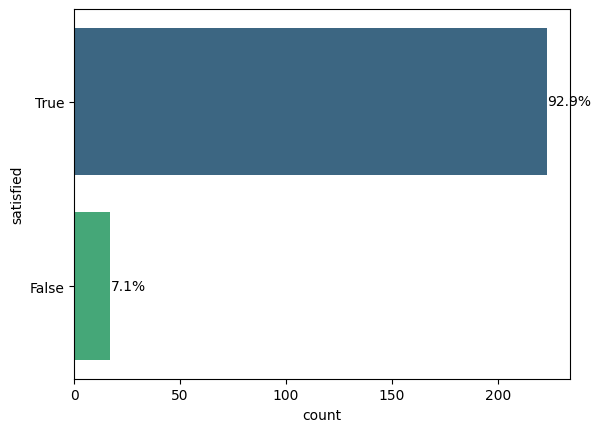

In [39]:
plot_judge_results(
    optimized_dspy_judge_results.to_pandas()
)

### Look at where the improvement has come

In [52]:
optimized_result = optimized_dspy_judge_results.to_pandas()[["conversation_id","output_transcript","explanation","satisfied"]]
optimized_result = optimized_result.rename(
    columns={
        "output_transcript":"optimized_output_transcript",
        "explanation":"optimized_explanation",
        "satisfied":"optimized_satisfied"
    }
)
optimized_result["conversation_id"] = optimized_result["conversation_id"].astype(str)

In [53]:
baseline_result = baseline_dspy_judge_results.to_pandas()[["conversation_id","output_transcript","explanation","satisfied"]]
baseline_result = baseline_result.rename(
    columns={
        "output_transcript":"baseline_output_transcript",
        "explanation":"baseline_explanation",
        "satisfied":"baseline_satisfied"
    }
)
baseline_result["conversation_id"] = baseline_result["conversation_id"].astype(str)

In [55]:
combined_result = baseline_result.merge(
    optimized_result,on=["conversation_id"]
)

In [58]:
switched_results = combined_result[combined_result["baseline_satisfied"]!=combined_result["optimized_satisfied"]]

In [61]:
for judge_value in switched_results["optimized_satisfied"].unique():

    print("*"*30)
    print(f"Optimized generator result = {judge_value}")
    tmp = switched_results[switched_results["optimized_satisfied"]==judge_value]
    for i, row in tmp.iterrows():
        print("-"*30)
        print("Baseline output")
        print(row["baseline_output_transcript"])
        print("Baseline critique")
        print(row["baseline_explanation"])
        print("Optimized output")
        print(row["optimized_output_transcript"])
        print("Optimized critique")
        print(row["optimized_explanation"])

******************************
Optimized generator result = True
------------------------------
Baseline output
Company: ArgosHelpers
Transcript so far: Customer: why don't you care about customer
Support: I'm sorry to hear that you feel that way. Can you please provide more details so I can assist you better?
Baseline critique
The agent apologized but didn't address the customer's concern directly.  More information is needed.
Optimized output
Company: ArgosHelpers
Transcript so far: Customer: why don't you care about customer
Support: I'm really sorry to hear that you feel this way. Customer satisfaction is our top priority at ArgosHelpers, and it's concerning to hear that you don't feel cared for. Could you please provide more details so that I can better understand your specific concerns and assist you accordingly?
Optimized critique
Agent apologizes, acknowledges the customer's feelings, and requests more information to help.
------------------------------
Baseline output
Company: